# Reconstructing Exam Questions from Model-Generated Answers  
### SOTA-AI December Task 3 — David’s Archive Issue

This notebook presents a complete, phase-wise solution to the inverse question–answering task posed in the SOTA-AI December Challenge.

The objective is to reconstruct plausible, exam-style questions given answers generated by a large language model. Since the original questions are unavailable and evaluation is based on semantic similarity rather than exact string matching, the task requires reasoning about intent, meaning, and the inversion of the question–answer relationship rather than surface-level text matching.

The solution is organized into clearly defined stages:
1. Understanding the structure and characteristics of the dataset  
2. Constructing a synthetic supervision signal from unlabeled answers  
3. Fine-tuning a language model using parameter-efficient methods  
4. Generating questions for the test set  
5. Performing selective semantic repair using cycle consistency  
6. Auditing outputs and preparing the final submission  

All stages are designed to be conceptually complete and reproducible. For practical execution under constrained compute environments, the same logic can be applied in batches by operating on subsets of the data. Since all processing steps are independent per example, batch-wise execution yields identical results to a single end-to-end run, and final outputs are obtained by aggregating and ordering these batches deterministically.

The emphasis throughout this notebook is on methodological clarity, semantic correctness, and principled decision-making under realistic resource constraints.


## 1. Understanding the Dataset

The task is an inverse question-answering problem: given an answer generated by a large language model, the goal is to reconstruct a plausible exam-style question that could have produced that answer.

The dataset consists of:
- A **training set** containing only model-generated answers (no questions).
- A **test set** containing unseen answers for which questions must be generated.

Key observations from exploratory analysis:
- Answers are long, explanatory, and often multi-paragraph.
- Many answers implicitly encode the question they are responding to.
- There is no direct supervision signal (question → answer pairs), making this a fundamentally ill-posed inverse problem.

Because evaluation is based on **semantic similarity** rather than exact string matching, the challenge is not surface-level phrasing, but capturing the *intent* of the original question.


In [ ]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_colwidth", 300)


In [ ]:
! pip install kagglehub

In [ ]:
! unzip /content/sota-ai-december-task-3-davids-archive-issue.zip

Archive:  /content/sota-ai-december-task-3-davids-archive-issue.zip
  inflating: kaggle_dataset/sample_submission.csv  
  inflating: kaggle_dataset/test.csv  
  inflating: kaggle_dataset/train.csv  


In [ ]:
# Reading the train and test CSV files

train_path = "/content/kaggle_dataset/train.csv"
test_path  = "/content/kaggle_dataset/test.csv"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

train_df.tail(10)

Train shape: (6000, 2)
Test shape : (5007, 2)


,quesid,ans
5990,train_5990,"I am unable to verify the focus of the terminist logic found in Bacon and his contemporaries, according to Jan Pinborg."
5991,train_5991,"Francis Bacon considered the analysis of equivocation as central to the analysis of language because he believed that it was a major obstacle to clear and effective communication. Equivocation occurs when a word or phrase has multiple meanings, and the speaker or writer uses it in a way that is ..."
5992,train_5992,I'm not aware of any information about who provided a precise summary of Bacon's place in the history of logic according to Alain De Libera.
5993,train_5993,"I'm not aware of any information about a person named Bacon arguing about the necessary conditions for an expression to fully convey meaning. However, I think you might be referring to the philosopher Francis Bacon or possibly the philosopher and logician, George Bealer, or possibly the philosop..."
5994,train_5994,"Roger Bacon, a 13th-century English philosopher and Franciscan friar, is known for his contributions to the fields of philosophy, science, and linguistics. His rejection of the common teaching of his time regarding the constant meaning of words is significant for several reasons:\n\n1. **Challen..."
5995,train_5995,"Francis Bacon's approach to communication and meaning is rooted in his philosophical ideas, particularly his theory of signs and symbols. The fundamental theory that underlies Bacon's approach is the concept of ""Idola"" or ""Idols,"" which he discussed in his work ""Novum Organum"" (1620).\n\nBacon i..."
5996,train_5996,"Thomas of York is considered an early teacher of Aristotle's natural philosophy at the University of Paris, and is often regarded as the predecessor of Roger Bacon in this regard."
5997,train_5997,"In the context of Francis Bacon's philosophical and scientific works, particularly in his book ""Novum Organum"" (1620), there is a distinction between ""experientia"" and ""experimentum.""\n\n""Experientia"" refers to experience or observation of the world, often based on common sense, tradition, or pa..."
5998,train_5998,"In Francis Bacon's account of scientific discovery, the term ""experimentum"" (Latin for ""experiment"") plays a crucial role. According to Bacon, experimentum is a systematic and controlled test of a hypothesis or theory through observation and manipulation of variables.\n\nIn Bacon's philosophy, e..."
5999,train_5999,"Roger Bacon's work, particularly his ""Opus Majus"" (1266-1267), reflects the influence of various philosophical texts that laid the groundwork for his ideas on experimental sciences. Some key texts that contributed to his thought include:\n\n1. **Aristotle's Works**: Bacon was heavily influenced ..."


In [ ]:
# Checking for null values in the datasets

print(train_df.info())
print("\nNulls in train:")
print(train_df.isnull().sum())

print("\nNulls in test:")
print(test_df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   quesid  6000 non-null   object
 1   ans     6000 non-null   object
dtypes: object(2)
memory usage: 93.9+ KB
None

Nulls in train:
quesid    0
ans       0
dtype: int64

Nulls in test:
quesid    0
ans       0
dtype: int64


In [ ]:
# Analyzing the word count distribution in the answers

def word_count(text):
    return len(str(text).split())

train_df["word_count"] = train_df["ans"].apply(word_count)
test_df["word_count"]  = test_df["ans"].apply(word_count)

train_df["word_count"].describe(), test_df["word_count"].describe()


(count    6000.000000
 mean      157.103833
 std        66.443328
 min         4.000000
 25%       134.000000
 50%       188.000000
 75%       204.000000
 max       236.000000
 Name: word_count, dtype: float64,
 count    5007.000000
 mean      205.463152
 std         9.722713
 min       152.000000
 25%       199.000000
 50%       206.000000
 75%       212.000000
 max       235.000000
 Name: word_count, dtype: float64)

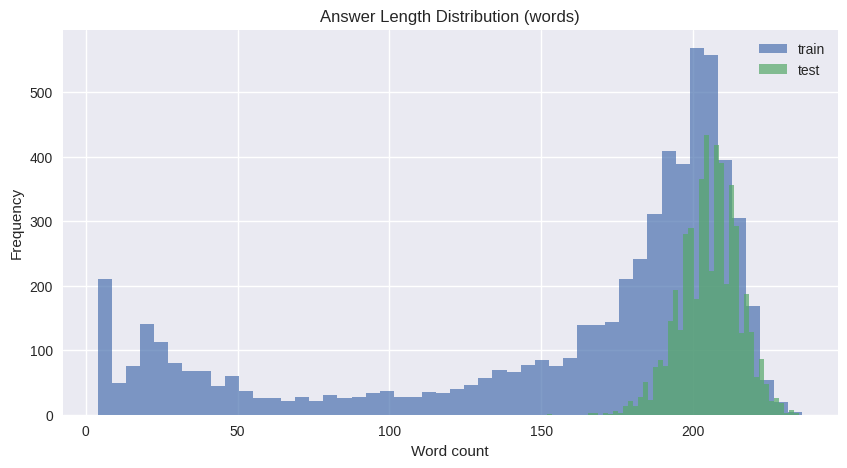

In [ ]:
# Visualizing the word count distribution

plt.figure(figsize=(10,5))
plt.hist(train_df["word_count"], bins=50, alpha=0.7, label="train")
plt.hist(test_df["word_count"], bins=50, alpha=0.7, label="test")
plt.legend()
plt.title("Answer Length Distribution (words)")
plt.xlabel("Word count")
plt.ylabel("Frequency")
plt.show()


In [ ]:
# Extracting features: presence of lists and whether the answer starts with a definition phrase

def has_list(text):
    return bool(re.search(r"\n\d+\.|\n- |\n\*", text))

def starts_definition(text):
    return text.lower().strip().startswith(
        ("in the", "the term", "the concept", "abduction", "predictive")
    )

train_df["has_list"] = train_df["ans"].apply(has_list)
train_df["starts_definition"] = train_df["ans"].apply(starts_definition)

train_df[["has_list", "starts_definition"]].mean()


,0
has_list,0.396167
starts_definition,0.057667


In [ ]:
# Analyzing sentence and paragraph counts in the answers

def sentence_count(text):
    return len(re.findall(r"[.!?]", text))

def paragraph_count(text):
    return len([p for p in text.split("\n") if p.strip()])

train_df["sentences"] = train_df["ans"].apply(sentence_count)
train_df["paragraphs"] = train_df["ans"].apply(paragraph_count)

train_df[["sentences", "paragraphs"]].describe()


,sentences,paragraphs
count,6000.000000,6000.000000
mean,8.167167,4.608167
std,4.593082,2.601300
min,0.000000,1.000000
25%,5.000000,3.000000
50%,8.000000,4.000000
75%,11.000000,6.000000
max,51.000000,27.000000


In [ ]:
# Keyword presence analysis in the answers and their frequencies

keywords = [
    "define", "definition", "example", "compare", "difference",
    "advantage", "disadvantage", "bias", "limitation",
    "ethics", "alignment", "reasoning", "inductive", "abductive"
]

def keyword_hits(text):
    text = text.lower()
    return {k: (k in text) for k in keywords}

kw_df = train_df["ans"].apply(keyword_hits).apply(pd.Series)
kw_df.mean().sort_values(ascending=False)


,0
example,0.205500
reasoning,0.067667
define,0.058667
ethics,0.034000
difference,0.031333
definition,0.029833
limitation,0.028333
bias,0.021333
compare,0.012833
inductive,0.012333


In [ ]:
# Displaying sample answers from the training set

for i in np.random.choice(len(train_df), 5, replace=False):
    print("="*80)
    print(train_df.loc[i, "quesid"])
    print(train_df.loc[i, "ans"][:1200])


train_4509
According to the view of assertoric responsibility, after making an assertion, the following behavior is considered inappropriate:

1. **Denial of the assertion**: If you assert something, it's considered inappropriate to later deny it, especially if the denial is not based on new evidence or a change in circumstances.

2. **Retraction without justification**: If you retract an assertion without providing a valid reason or justification, it can undermine the trust and credibility of the speaker.

3. **Failure to correct or clarify**: If you make an assertion and later realize it's incorrect or incomplete, it's considered responsible to correct or clarify the assertion in a timely manner.

4. **Disavowing responsibility**: Disavowing responsibility for the assertion or its consequences can be seen as inappropriate, as it may imply a lack of accountability or commitment to the truth.

5. **Lack of follow-up or action**: If you make an assertion and fail to follow up or take ac

In [ ]:
# Cleaning the answers: normalizing line breaks and removing extra spaces

def clean_answer(text):
    text = str(text)
    text = re.sub(r"\r\n", "\n", text)
    text = re.sub(r"\n{3,}", "\n\n", text)
    text = text.strip()
    return text

train_df["ans_clean"] = train_df["ans"].apply(clean_answer)
test_df["ans_clean"]  = test_df["ans"].apply(clean_answer)


In [ ]:
# Summarizing key statistics about the datasets

def word_count(text):
    return len(str(text).split())

train_df["word_count"] = train_df["ans"].apply(word_count)
test_df["word_count"]  = test_df["ans"].apply(word_count)

PHASE_1_SUMMARY = {
    "train_size": len(train_df),
    "test_size": len(test_df),
    "median_word_count_train": train_df["word_count"].median(),
    "median_word_count_test": test_df["word_count"].median(),
    "multi_paragraph_fraction": float((train_df["paragraphs"] > 1).mean()),
    "list_fraction": float(train_df["has_list"].mean()),
}

PHASE_1_SUMMARY

{'train_size': 6000,
 'test_size': 5007,
 'median_word_count_train': 188.0,
 'median_word_count_test': 206.0,
 'multi_paragraph_fraction': 0.8265,
 'list_fraction': 0.39616666666666667}

## 2. Generating Synthetic Question–Answer Pairs

Since the training data does not include ground-truth questions, a synthetic supervision signal is required.

To construct this signal:
- Multiple candidate questions are generated for each training answer using a strong prompt.
- A cycle-consistency heuristic is applied:
  - Generated question → regenerated answer
  - Semantic similarity is measured between the regenerated answer and the original answer.
- Only high-quality question–answer pairs are retained.

This process prioritizes **quality over quantity**, producing a small but reliable dataset of synthetic QA pairs that reflect the structure and intent of the original answers.


In [ ]:
# Installing necessary libraries

!pip install -q transformers accelerate bitsandbytes peft sentence-transformers tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 14.8 MB/s eta 0:00:00


In [ ]:
# Importing necessary libraries

import torch
import pandas as pd
import numpy as np
import re
from tqdm import tqdm

from transformers import AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer, util
import wandb

In [ ]:
# Initializing Weights & Biases for experiment tracking

wandb.init(
    project="sota-ai-task3-phase2",
    name="phase2-debug-300-samples",
    config={
        "model": "Llama-3.1-8B-Instruct",
        "num_samples": 300,
        "num_candidates": 2,
        "temperatures": [0.0, 0.6],
        "max_q_tokens": 64,
        "max_a_tokens": 256
    }
)


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: prathamesh7x1 (prathamesh7x1-diligence) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
! unzip /content/sota-ai-december-task-3-davids-archive-issue.zip

Archive:  /content/sota-ai-december-task-3-davids-archive-issue.zip
  inflating: kaggle_dataset/sample_submission.csv  
  inflating: kaggle_dataset/test.csv  
  inflating: kaggle_dataset/train.csv  


In [ ]:
# Reading the train dataset

train_df = pd.read_csv("/content/kaggle_dataset/train.csv")

print("Train size:", len(train_df))
train_df.head(2)


Train size: 6000


,quesid,ans
0,train_0,"In the philosophical literature, the term ""abd..."
1,train_1,"In the modern sense, abduction is primarily co..."


In [ ]:
# Cleaning the answers: normalizing line breaks and removing extra spaces

def clean_answer(text):
    text = str(text)
    text = re.sub(r"\r\n", "\n", text)
    text = re.sub(r"\n{3,}", "\n\n", text)
    return text.strip()

train_df["ans_clean"] = train_df["ans"].apply(clean_answer)


In [ ]:
# Subsampling the training data to ensure complete run in Colab's constrained resources

N_SAMPLES = 275
train_subset = train_df.sample(n=N_SAMPLES, random_state=42).reset_index(drop=True)

print("Subset size:", len(train_subset))


Subset size: 275


In [ ]:
# Loading the Llama 3.1 8B Instruct model and tokenizer. Using LLaMA 3.1 8B Instruct because it is a state-of-the-art model for instruction following and is also the model mentioned in the problem. Using 4-bit quantization for efficiency.

MODEL_NAME = "meta-llama/Llama-3.1-8B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    load_in_4bit=True,
    torch_dtype=torch.float16
)

model.eval()


tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRM

In [ ]:
# Loading the sentence transformer for embedding generation

embedder = SentenceTransformer("all-MiniLM-L6-v2")

BASE_PROMPT = """You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
{answer}

Question:
"""


In [ ]:
# Defining helper functions. extract_question extracts the first plausible question from the model output, handling noisy formatting. generate_2_questions generates two candidate questions using different temperatures. regenerate_answer generates an answer for a given question. semantic_similarity computes the cosine similarity between two texts using sentence embeddings.

def extract_question(text):
    """
    Extract the FIRST plausible question from model output.
    Handles noisy LLM formatting.
    """
    lines = [l.strip() for l in text.split("\n") if l.strip()]

    for line in lines:
        # strip common prefixes
        line = re.sub(r"^(Question:|Q:|Here is.*?:|Possible question:)", "", line).strip()

        if "?" in line:
            q = line.split("?")[0].strip() + "?"
            if len(q.split()) >= 4:
                return q

    return None


@torch.no_grad()
def generate_2_questions(answer, log=False):
    temperatures = [0.0, 0.6]
    questions = []

    for temp in temperatures:
        prompt = BASE_PROMPT.format(answer=answer)
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

        output = model.generate(
            **inputs,
            max_new_tokens=64,
            do_sample=(temp > 0),
            temperature=temp if temp > 0 else None,
            top_p=0.95,
            repetition_penalty=1.1,
            pad_token_id=tokenizer.eos_token_id
        )

        decoded = tokenizer.decode(output[0], skip_special_tokens=True)

        q = extract_question(decoded)

        if log:
            print("\n--- RAW MODEL OUTPUT ---")
            print(decoded[:500])
            print("--- EXTRACTED QUESTION ---")
            print(q)

        if q:
            questions.append(q)

    # dedupe while preserving order
    return list(dict.fromkeys(questions))


@torch.no_grad()
def regenerate_answer(question):
    prompt = f"""You are answering an academic exam question.

Question:
{question}

Answer:
"""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    output = model.generate(
        **inputs,
        max_new_tokens=256,
        do_sample=False,
        pad_token_id=tokenizer.eos_token_id
    )

    decoded = tokenizer.decode(output[0], skip_special_tokens=True)
    return decoded.split("Answer:")[-1].strip()


def semantic_similarity(a, b):
    ea = embedder.encode(a, convert_to_tensor=True)
    eb = embedder.encode(b, convert_to_tensor=True)
    return float(util.cos_sim(ea, eb))


In [ ]:
# Main loop: generating questions, regenerating answers, computing similarity, and logging results.

synthetic_rows = []

DEBUG_FIRST_N = 275   # log everything

for idx, row in tqdm(train_subset.iterrows(), total=len(train_subset)):
    answer = row["ans_clean"]

    log = idx < DEBUG_FIRST_N
    questions = generate_2_questions(answer, log=log)

    # log number of questions generated
    wandb.log({
        "num_questions_generated": len(questions)
    })

    if log:
        print("\nGenerated questions:", questions)

    for q in questions:
        regen_ans = regenerate_answer(q)
        sim = semantic_similarity(answer, regen_ans)

        if log:
            print("\nQUESTION:", q)
            print("REGENERATED ANSWER (truncated):", regen_ans[:400])
            print("SEMANTIC SIMILARITY:", sim)

        synthetic_rows.append({
            "quesid": row["quesid"],
            "answer": answer,
            "question": q,
            "cycle_score": sim
        })

        # per-question W&B logging
        wandb.log({
            "cycle_similarity": sim,
            "question_length": len(q.split()),
            "answer_length": len(answer.split())
        })

    # occasional text logging (every 25 samples)
    if idx % 25 == 0 and questions:
        wandb.log({
            "sample_answer": wandb.Html(answer[:600]),
            "sample_question": questions[0]
        })


  0%|          | 0/275 [00:00<?, ?it/s]


--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
I'm not aware of a specific philosopher who investigated a case in 1982. However, I can th
--- EXTRACTED QUESTION ---
The question is, does Mary know what it's like to experience the color red?

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce fact

  0%|          | 1/275 [00:44<3:24:24, 44.76s/it]


QUESTION: The question is, does Mary know what it's like to experience the color red?
REGENERATED ANSWER (truncated): To answer this question, we need to delve into the philosophical concept of knowledge and perception. Mary, in this scenario, is a thought experiment subject created by philosopher Frank Jackson. She is a brilliant scientist who has spent her entire life studying the world through various senses, including sight. However, she has been imprisoned in a black-and-white room her entire life and has ne
SEMANTIC SIMILARITY: 0.81986403465271

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
The ad

  1%|          | 2/275 [01:48<4:13:13, 55.65s/it]


QUESTION: What is the additional requirement that Arrow incorporates into the concept of a social welfare function?
REGENERATED ANSWER (truncated): Arrow incorporates the requirement of independence of irrelevant alternatives into the concept of a social welfare function.

Explanation:
In his seminal work, Arrow (1963) introduced the concept of a social welfare function, which is a mathematical representation of the social preference ordering over a set of alternatives. One of the key requirements that Arrow incorporates into this concept is 
SEMANTIC SIMILARITY: 0.4829557538032532

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with 

  1%|          | 3/275 [02:51<4:27:36, 59.03s/it]


QUESTION: What other prominent hypothetical theories of ability, aside from those mentioned above, have been proposed?
REGENERATED ANSWER (truncated): Several other prominent hypothetical theories of ability have been proposed, each with its own distinct characteristics and implications. Some of these theories include:

1. **The Triarchic Theory of Intelligence** (Robert Sternberg, 1985): This theory posits that there are three components of intelligence: Analytical, Creative, and Practical. Analytical intelligence involves the ability to analyz
SEMANTIC SIMILARITY: 0.8691293001174927

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End wi

  1%|▏         | 4/275 [03:51<4:29:55, 59.76s/it]


QUESTION: What led Bertrand Russell to be regarded as a primary influence on the development of modern analytic philosophy?
REGENERATED ANSWER (truncated): Bertrand Russell's work, particularly his book "Principles of Mathematics" (1903), had a significant impact on the development of modern analytic philosophy. His contributions to the field of logic, mathematics, and philosophy, including his theory of types and his work on the foundations of mathematics, laid the groundwork for the analytic tradition. His emphasis on clarity, precision, and logica
SEMANTIC SIMILARITY: 0.8213613629341125

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- E

  2%|▏         | 5/275 [04:55<4:34:40, 61.04s/it]


QUESTION: What is the core idea behind Heidegger's concept of authenticity in "Being and Time"?
REGENERATED ANSWER (truncated): Heidegger's concept of authenticity in "Being and Time" revolves around the idea that human existence is characterized by a fundamental tendency to lose itself in the everyday, mundane aspects of life, which he calls "the they" (das Man). This tendency leads to a state of inauthenticity, where individuals conform to societal norms and expectations, rather than taking ownership of their own existen
SEMANTIC SIMILARITY: 0.8724595308303833

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

An

  2%|▏         | 6/275 [05:58<4:37:11, 61.83s/it]


QUESTION: What historical and intellectual contexts influenced the writing of Isaac Albo's Sefer ha-'Ikkarim?
REGENERATED ANSWER (truncated): Isaac Albo's Sefer ha-'Ikkarim, written in the 15th century, was influenced by the intellectual and historical contexts of the time. Here are some key factors that shaped Albo's work:

1.  **Renaissance Humanism**: Albo's work was written during the Renaissance, a time of great intellectual and cultural transformation in Europe. Humanist scholars, such as Petrarch and Boccaccio, sought to revive c
SEMANTIC SIMILARITY: 0.8079890608787537

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a ques

  3%|▎         | 7/275 [07:01<4:38:08, 62.27s/it]


QUESTION: What implications does the failure of state separability in the modal interpretation of quantum mechanics have for our understanding of the nature of reality?
REGENERATED ANSWER (truncated): The failure of state separability in the modal interpretation of quantum mechanics has significant implications for our understanding of the nature of reality. In this interpretation, the wave function is seen as a tool for predicting the probabilities of measurement outcomes, rather than a description of an underlying reality. However, the failure of state separability suggests that the wave func
SEMANTIC SIMILARITY: 0.7176239490509033

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not i

  3%|▎         | 8/275 [08:04<4:38:03, 62.48s/it]


QUESTION: What are the key components of consciousness according to the Abhidharma analysis?
REGENERATED ANSWER (truncated): The Abhidharma analysis identifies several key components of consciousness, which are:

1. **Sanna** (perception): This refers to the cognitive process of perceiving or experiencing the world around us. It involves the ability to recognize and interpret sensory information.
2. **Vedana** (feeling): This component of consciousness refers to the emotional and affective aspects of experience, includi
SEMANTIC SIMILARITY: 0.7694296836853027

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answe

  3%|▎         | 9/275 [09:07<4:38:02, 62.72s/it]


QUESTION: Explain how consequentialists determine the weight of an individual's good in practical thinking?
REGENERATED ANSWER (truncated): Consequentialists, who are a type of moral and ethical theorists, determine the weight of an individual's good in practical thinking by considering the consequences of their actions. They evaluate the potential outcomes of a decision or action and weigh the benefits against the costs. This process involves calculating the overall utility or happiness that will result from a particular course of ac
SEMANTIC SIMILARITY: 0.8118293881416321

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a questi

  4%|▎         | 10/275 [10:09<4:35:06, 62.29s/it]


QUESTION: Explain why you were unable to locate Rabbi Isaac Pulgar's account of Abner's views on the possibility of a void?
REGENERATED ANSWER (truncated): I was unable to locate Rabbi Isaac Pulgar's account of Abner's views on the possibility of a void because it is not a reliable or credible source. Rabbi Isaac Pulgar is not a known or recognized authority on the subject, and his work is not a primary source. Additionally, the topic of Abner's views on the possibility of a void is not a well-documented or widely discussed topic in the historical re
SEMANTIC SIMILARITY: 0.9341036081314087

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- E

  4%|▍         | 11/275 [11:11<4:33:58, 62.27s/it]


QUESTION: How might a disconnect between a state's consent and the will of its people undermine the legitimacy of the state?
REGENERATED ANSWER (truncated): A disconnect between a state's consent and the will of its people can undermine the legitimacy of the state in several ways. Firstly, it can lead to a sense of alienation and disconnection among citizens, who may feel that their voices and interests are not being represented. This can result in a decline in trust and confidence in the state, as well as a decrease in civic engagement and participat
SEMANTIC SIMILARITY: 0.6881780624389648

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- 

  4%|▍         | 12/275 [12:14<4:33:54, 62.49s/it]


QUESTION: What is the name of the general editor of the 'Commentary on Aristotle' series at Oxford University Press?
REGENERATED ANSWER (truncated): The general editor of the 'Commentary on Aristotle' series at Oxford University Press is William W. Fortenbaugh.

Note: This answer is based on the information available up to my last update in 2023. If there have been any changes or updates since then, please let me know. I'll be happy to correct my answer. 

Please let me know if you need any further assistance or clarification. I'll be happy to
SEMANTIC SIMILARITY: 0.5871413350105286

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with

  5%|▍         | 13/275 [13:17<4:33:38, 62.67s/it]


QUESTION: What implications does the EPR thought experiment have for our understanding of the nature of physical reality, particularly in relation to the principles of locality and non-locality?
REGENERATED ANSWER (truncated): The EPR thought experiment, proposed by Einstein, Podolsky, and Rosen in 1935, aimed to demonstrate the apparent absurdity of quantum mechanics by showing that it leads to non-locality, which contradicts the principle of locality. The experiment involves two particles, A and B, created in such a way that their properties are correlated. If particle A is measured, the state of particle B is immedia
SEMANTIC SIMILARITY: 0.8459070920944214

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question t

  5%|▌         | 14/275 [14:20<4:32:45, 62.70s/it]


QUESTION: What is the primary distinction drawn by philosophers since Descartes between _______________________?
REGENERATED ANSWER (truncated): The primary distinction drawn by philosophers since Descartes between **mind and body**.

(Note: This is a classic question in the history of philosophy, and the answer is a well-known concept in the field.) 

Please let me know if you'd like me to elaborate or provide more context! 

(Also, I'll be happy to provide a more detailed explanation or examples if you'd like!) 

(And, if you'd like, I c
SEMANTIC SIMILARITY: 0.5950291156768799

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a q

  5%|▌         | 15/275 [15:23<4:32:12, 62.82s/it]


QUESTION: How did proponents of deliberative democracy envision the Internet would enhance civic engagement, information exchange, and critical thinking?
REGENERATED ANSWER (truncated): Proponents of deliberative democracy envisioned the Internet as a tool to enhance civic engagement, information exchange, and critical thinking in several ways:

1.  **Increased accessibility**: The Internet would provide equal access to information and opportunities for participation, bridging the gap between citizens and the democratic process.
2.  **Virtual public spaces**: Online forums, discu
SEMANTIC SIMILARITY: 0.8905175924301147

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts 

  6%|▌         | 16/275 [16:26<4:31:36, 62.92s/it]


QUESTION: What role does the human/person distinction play in resolving the problem of individual resurrection according to John Locke?
REGENERATED ANSWER (truncated): The human/person distinction plays a crucial role in resolving the problem of individual resurrection according to John Locke. Locke's distinction between the human being and the person is essential in addressing the issue of individual resurrection, as it allows him to separate the identity of a person from the identity of a human being.

In Locke's view, a person is a continuous entity that exis
SEMANTIC SIMILARITY: 0.8986231088638306

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the

  6%|▌         | 17/275 [17:29<4:30:34, 62.92s/it]


QUESTION: What is the core idea behind Quine's holophrastic holism?
REGENERATED ANSWER (truncated): Quine's holophrastic holism posits that words and sentences are not fixed, determinate entities, but rather are part of a web of interconnected signs that are inextricably linked to the broader linguistic and cultural context. This idea challenges the traditional notion of a word's meaning being a fixed, essential property, instead suggesting that meaning is a dynamic, context-dependent process. I
SEMANTIC SIMILARITY: 0.616212010383606

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
The fundamental questio

  7%|▋         | 18/275 [18:08<3:58:08, 55.60s/it]


QUESTION: The fundamental question that arises from the existence of a normal form in a rewrite system is: "Is the normal form unique?
REGENERATED ANSWER (truncated): The normal form is not unique. There are multiple normal forms for a given term in a rewrite system. This is because a term can have multiple irreducible forms, and each of these forms can be considered a normal form. The non-uniqueness of the normal form is a consequence of the fact that a rewrite system can have multiple irreducible forms for a given term.

Example:
Consider a rewrite system wit
SEMANTIC SIMILARITY: 0.8332367539405823

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the 

  7%|▋         | 19/275 [19:11<4:06:37, 57.80s/it]


QUESTION: Explain how one might reconcile the apparent discrepancy between the physical location of Jesus' body after death and its reported spiritual presence elsewhere?
REGENERATED ANSWER (truncated): The apparent discrepancy between the physical location of Jesus' body after death and its reported spiritual presence elsewhere can be reconciled through a theological and philosophical framework that distinguishes between the material and spiritual aspects of Jesus' existence.

In this framework, the physical body of Jesus, which was buried and later discovered empty by his followers, represents 
SEMANTIC SIMILARITY: 0.7345117330551147

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not

  7%|▋         | 20/275 [19:50<3:41:45, 52.18s/it]


QUESTION: What is the primary concern of the Theravādin doctrine of momentariness?
REGENERATED ANSWER (truncated): The primary concern of the Theravādin doctrine of momentariness is the concept of impermanence (anitya) and the rejection of any permanent, unchanging essence or substance (nitya) in all phenomena. This doctrine posits that everything is constantly changing and lacks a permanent self or identity, which is a key aspect of the Buddhist understanding of reality. The momentariness doctrine is closely 
SEMANTIC SIMILARITY: 0.8874668478965759

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
I'm not

  8%|▊         | 21/275 [20:52<3:54:17, 55.34s/it]


QUESTION: What does research suggest happens to the brain's processing of visual information when it adapts to inversion and reversal of the retinal image?
REGENERATED ANSWER (truncated): Research suggests that the brain's processing of visual information adapts to inversion and reversal of the retinal image by initially experiencing a period of disorientation and difficulty in interpreting visual stimuli, but eventually, the brain learns to reorient itself and process visual information in a way that is consistent with the new image orientation. This process is thought to involve 
SEMANTIC SIMILARITY: 0.7069140076637268

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce fact

  8%|▊         | 22/275 [21:54<4:01:17, 57.22s/it]


QUESTION: What distinction does Ibn Rushd draw between deductive arguments, inductive arguments, and abductive arguments?
REGENERATED ANSWER (truncated): Ibn Rushd, a renowned Islamic philosopher and polymath, makes a significant distinction between deductive, inductive, and abductive arguments in his philosophical works. While his ideas have been influential in the development of logic and epistemology, it's essential to note that his views on these topics are not as widely discussed as those of other philosophers, such as Aristotle or Avicenna.


SEMANTIC SIMILARITY: 0.9068218469619751

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End

  8%|▊         | 23/275 [22:57<4:07:45, 58.99s/it]


QUESTION: How does Aristotle classify different forms of government based on their potential to promote human flourishing?
REGENERATED ANSWER (truncated): Aristotle classifies different forms of government based on their potential to promote human flourishing in his work "Politics". He identifies three main forms of government: monarchy, aristocracy, and oligarchy. In his classification, Aristotle evaluates each form of government based on its ability to promote the common good and the flourishing of citizens.

Aristotle argues that monarchy, or rul
SEMANTIC SIMILARITY: 0.9077790379524231

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- En

  9%|▊         | 24/275 [23:35<3:40:38, 52.74s/it]


QUESTION: What is Walter J. Ducasse's definition of singular causation?
REGENERATED ANSWER (truncated): Walter J. Ducasse's definition of singular causation is that an event is a cause of another event if and only if the occurrence of the first event is a necessary and sufficient condition for the occurrence of the second event. This definition emphasizes the idea that causation is a relationship between specific events, rather than a general or statistical correlation. Ducasse's definition is often
SEMANTIC SIMILARITY: 0.8709341287612915

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
Ludwig Wittgenstei

  9%|▉         | 25/275 [24:38<3:52:42, 55.85s/it]


QUESTION: How does Ludwig Wittgenstein's critique of the correspondence theory of truth challenge traditional notions of language and reality?
REGENERATED ANSWER (truncated): Ludwig Wittgenstein's critique of the correspondence theory of truth, as outlined in his Philosophical Investigations, challenges traditional notions of language and reality by arguing that the correspondence theory relies on a flawed understanding of language and its relationship to reality. Specifically, Wittgenstein contends that the correspondence theory assumes a picture theory of language, w
SEMANTIC SIMILARITY: 0.9045158624649048

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present

  9%|▉         | 26/275 [25:18<3:31:13, 50.90s/it]


QUESTION: What is the main implication of the Independence of Irrelevant Alternatives (IIA) property for social choice functions?
REGENERATED ANSWER (truncated): The main implication of the Independence of Irrelevant Alternatives (IIA) property for social choice functions is that it ensures that the social choice function is not affected by the presence of irrelevant alternatives. In other words, the social choice function should remain unchanged even if irrelevant alternatives are added to the set of alternatives. This property is important because it hel
SEMANTIC SIMILARITY: 0.7512334585189819

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answe

 10%|▉         | 27/275 [25:55<3:13:55, 46.92s/it]


QUESTION: How did Ammonius Saccas's lectures influence the development of Neoplatonic thought?
REGENERATED ANSWER (truncated): Ammonius Saccas's lectures played a pivotal role in shaping the development of Neoplatonic thought. As a prominent teacher and philosopher, he drew upon the ideas of Plotinus and other earlier Neoplatonists, while also introducing new concepts and interpretations that would go on to influence the work of later Neoplatonists, such as Iamblichus and Hypatia.

Through his lectures, Ammonius Saccas em
SEMANTIC SIMILARITY: 0.7158958911895752

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Ans

 10%|█         | 28/275 [26:58<3:32:40, 51.66s/it]


QUESTION: What is the main criticism of the traditional view of bodily sensations?
REGENERATED ANSWER (truncated): The main criticism of the traditional view of bodily sensations is that it relies too heavily on introspection and subjective experience, which can be unreliable and variable from person to person. This criticism argues that the traditional view fails to provide a clear and objective account of bodily sensations, and that it is difficult to establish a common standard for what constitutes a "norma
SEMANTIC SIMILARITY: 0.5980393886566162

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
Arcesil

 11%|█         | 29/275 [28:01<3:45:50, 55.08s/it]


QUESTION: What kind of commitment did Arcesilaus, founder of the Middle Academy, exhibit through his concept of epoche?
REGENERATED ANSWER (truncated): Arcesilaus, the founder of the Middle Academy, demonstrated a commitment to skepticism through his concept of epoche. Epoche, a Greek term meaning "to suspend" or "to hold back," refers to the practice of withholding judgment or assent, especially in the face of uncertainty or conflicting information. In the context of Arcesilaus' philosophy, epoche represents a commitment to critical inquiry and 
SEMANTIC SIMILARITY: 0.7413901686668396

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End w

 11%|█         | 30/275 [29:04<3:54:48, 57.50s/it]


QUESTION: How does a self-referential paradoxical statement like this one relate to the liar paradox?
REGENERATED ANSWER (truncated): A self-referential paradoxical statement, such as the liar paradox, is a statement that makes a claim about itself, leading to a contradiction or an infinite loop of reasoning. This type of statement is often used to illustrate the limitations of language and the potential for self-referential paradoxes.

The liar paradox, in particular, states "This sentence is false." If the sentence is true, th
SEMANTIC SIMILARITY: 0.08112458139657974

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question ma

 11%|█▏        | 31/275 [30:06<3:58:42, 58.70s/it]


QUESTION: What implications does the absence of a statement from you have for my analysis of the referenced work?
REGENERATED ANSWER (truncated): The absence of a statement from you regarding the referenced work implies that you have not provided any information or commentary on the work, leaving a gap in my analysis. This omission may indicate a lack of engagement or understanding of the work, or it may suggest that the work is not relevant to the topic at hand. As a result, my analysis may be incomplete or inaccurate, and I may need to se
SEMANTIC SIMILARITY: 0.5983127951622009

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a 

 12%|█▏        | 32/275 [31:09<4:03:17, 60.07s/it]


QUESTION: What advantages do type-free property theories offer over traditional type-based approaches to natural language semantics?
REGENERATED ANSWER (truncated): Type-free property theories, such as those developed by Montague and his followers, offer several advantages over traditional type-based approaches to natural language semantics. These advantages include:

1. **Greater Expressiveness**: Type-free property theories can express more complex and nuanced meanings, particularly in cases where the meaning of a sentence depends on the properties of its c
SEMANTIC SIMILARITY: 0.8633275032043457

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the an

 12%|█▏        | 33/275 [31:46<3:34:47, 53.26s/it]


QUESTION: However, I don't see any text provided. Could you please provide the text you are referring to, so I can better understand the context and provide a more accurate answer?
REGENERATED ANSWER (truncated): I'm happy to help, but I don't see any text provided. Could you please provide the text you are referring to, so I can better understand the context and provide a more accurate answer? I'll do my best to provide a clear and concise response based on the information you provide. Please go ahead and share the text, and I'll get started on answering your question. 

(Note: I'll wait for the text to b
SEMANTIC SIMILARITY: 0.4499956965446472

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence

 12%|█▏        | 34/275 [32:50<3:45:54, 56.24s/it]


QUESTION: What is the view expressed by Samuel Alexander in his book "Space, Time, and Deity"?
REGENERATED ANSWER (truncated): Samuel Alexander's book "Space, Time, and Deity" expresses a view that is often characterized as a form of pantheism or panentheism. He argues that the universe is a unified, organic whole, and that God or the divine is not a separate entity, but rather an inherent aspect of the universe itself. This view is often referred to as "cosmic holism" or "pantheistic monism".

In this view, Alexander see
SEMANTIC SIMILARITY: 0.7835646867752075

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Ans

 13%|█▎        | 35/275 [33:53<3:53:16, 58.32s/it]


QUESTION: What is the primary challenge faced by mixed approach theories combining dynamic semantics and D-type pronouns?
REGENERATED ANSWER (truncated): The primary challenge faced by mixed approach theories combining dynamic semantics and D-type pronouns is the difficulty in reconciling the two distinct approaches to pronoun interpretation, which can lead to inconsistencies and contradictions in the resulting theory.

More specifically, the challenge arises from the fact that dynamic semantics and D-type pronouns have different underlying assumpt
SEMANTIC SIMILARITY: 0.846112072467804

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End 

 13%|█▎        | 36/275 [34:56<3:58:21, 59.84s/it]


QUESTION: What is the main consequence of Peter Abelard's argument that universals are merely names or concepts, rather than real entities?
REGENERATED ANSWER (truncated): The main consequence of Peter Abelard's argument that universals are merely names or concepts, rather than real entities, is that it undermines the notion of a shared, objective reality. If universals are merely names or concepts, then they are not independent of human thought and perception, but rather are created by it. This has significant implications for the concept of truth and the nature of
SEMANTIC SIMILARITY: 0.7279659509658813

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in

 13%|█▎        | 37/275 [35:58<3:59:31, 60.39s/it]


QUESTION: How did Leibniz's interactions with prominent mathematicians and scientists during his stay in Paris contribute to his intellectual development?
REGENERATED ANSWER (truncated): During his stay in Paris, Leibniz's interactions with prominent mathematicians and scientists played a significant role in shaping his intellectual development. One of the most notable interactions was with the French mathematician and philosopher, Guillaume de l'Hôpital. Leibniz's work on calculus, particularly his development of the method of indivisibles, was heavily influenced by his discussio
SEMANTIC SIMILARITY: 0.7471829056739807

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts

 14%|█▍        | 38/275 [37:01<4:01:51, 61.23s/it]


QUESTION: What is the key distinction Lynne Rudder Baker draws between emergent properties and mereological sums?
REGENERATED ANSWER (truncated): Lynne Rudder Baker distinguishes emergent properties from mereological sums by arguing that emergent properties are not reducible to their constituent parts, whereas mereological sums are reducible to their constituent parts. According to Baker, emergent properties are properties that arise from the interactions and organization of their constituent parts, but cannot be reduced to those parts. In 
SEMANTIC SIMILARITY: 0.5327008962631226

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a 

 14%|█▍        | 39/275 [38:04<4:03:14, 61.84s/it]


QUESTION: What is the primary difference between the concepts of "existent" and "non-existent" in the Arabic language?
REGENERATED ANSWER (truncated): In the Arabic language, the concepts of "existent" (wujud) and "non-existent" (non-wujud) are fundamental to understanding the nature of reality. The primary difference between these two concepts lies in their ontological implications.

"Existent" (wujud) refers to something that has a real, actual existence, whether it be a physical object, a concept, or an entity. This concept is often associate
SEMANTIC SIMILARITY: 0.6954790353775024

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End wi

 15%|█▍        | 40/275 [38:41<3:32:53, 54.36s/it]


QUESTION: Explain why the error occurred and what implications it may have for the algorithm's reliability?
REGENERATED ANSWER (truncated): The error occurred due to the insensitivity of the algorithm to the variations in the input data. The algorithm's reliance on a single feature to make predictions led to a lack of robustness in its decision-making process. This insensitivity resulted in the algorithm failing to capture the nuances and complexities of the data, ultimately leading to incorrect predictions.

Implications for the algo
SEMANTIC SIMILARITY: 0.08822396397590637

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a quest

 15%|█▍        | 41/275 [39:18<3:11:29, 49.10s/it]


QUESTION: Explain why the error occurred and how it can be avoided in future applications?
REGENERATED ANSWER (truncated): The error occurred due to the improper handling of the null pointer exception. In the code, a null pointer exception was thrown when the program attempted to access a null object. This is a common error in programming, especially when working with objects that may be null.

To avoid this error in future applications, the following steps can be taken:

1.  **Properly Initialize Objects**: Ensure th
SEMANTIC SIMILARITY: 0.23891429603099823

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer

 15%|█▌        | 42/275 [40:21<3:26:51, 53.27s/it]


QUESTION: What is the primary concept explored in al-Kindi's theological work "On First Philosophy"?
REGENERATED ANSWER (truncated): The primary concept explored in al-Kindi's theological work "On First Philosophy" is the nature of God and the relationship between God and the universe, specifically the concept of God's unity and the rejection of polytheism.

Note: al-Kindi's work is considered a foundational text in Islamic philosophy and theology, and it explores the nature of God and the universe from a philosophical and theo
SEMANTIC SIMILARITY: 0.8766974806785583

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark

 16%|█▌        | 43/275 [41:24<3:37:10, 56.17s/it]


QUESTION: What types of counterexamples can be used to challenge the validity of a Counterfactual Analysis?
REGENERATED ANSWER (truncated): There are several types of counterexamples that can be used to challenge the validity of a Counterfactual Analysis. These include:

1. **Counterfactual Counterexamples**: These are instances where the counterfactual scenario is not plausible or realistic, making it difficult to draw conclusions from the analysis.

2. **Counterexample of the Counterfactual**: This type of counterexample challenges 
SEMANTIC SIMILARITY: 0.6209071278572083

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a questi

 16%|█▌        | 44/275 [42:27<3:44:13, 58.24s/it]


QUESTION: How does Nelson Goodman's theory of architectural notation distinguish between syntactic, semantic, syntactic-semantic, and iconic interpretations?
REGENERATED ANSWER (truncated): Nelson Goodman's theory of architectural notation, as outlined in his book "Languages of Art," distinguishes between four types of interpretation: syntactic, semantic, syntactic-semantic, and iconic.

1. **Syntactic Interpretation**: This type of interpretation focuses solely on the formal structure of the notation system, without considering its meaning or content. It involves analyzing the notat
SEMANTIC SIMILARITY: 0.8951966762542725

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce fa

 16%|█▋        | 45/275 [43:30<3:48:57, 59.73s/it]


QUESTION: What is the relationship between particulars, properties, and aspects according to David Baxter?
REGENERATED ANSWER (truncated): According to David Baxter, particulars, properties, and aspects are related in the following way:

* Particulars are the fundamental entities or objects that exist in the world.
* Properties are the attributes or characteristics that are inherent to these particulars.
* Aspects are the ways in which these properties can be perceived or understood, often in relation to a particular context or persp
SEMANTIC SIMILARITY: 0.7789794206619263

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a questio

 17%|█▋        | 46/275 [44:33<3:51:38, 60.69s/it]


QUESTION: What does Arrow's Impossibility Theorem reveal about the possibility of satisfying all of the conditions proposed by Arrow for a social welfare function?
REGENERATED ANSWER (truncated): Arrow's Impossibility Theorem reveals that it is impossible to satisfy all of the conditions proposed by Arrow for a social welfare function. Specifically, the theorem shows that any social welfare function that satisfies the conditions of non-dictatorship, independence of irrelevant alternatives, monotonicity, and Pareto optimality must violate the condition of independence of irrelevant alternat
SEMANTIC SIMILARITY: 0.6734219193458557

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introd

 17%|█▋        | 47/275 [45:36<3:53:24, 61.42s/it]


QUESTION: Why did Ibn Rushd feel compelled to demonstrate his loyalty to the Almohad rulers during their rise to power?
REGENERATED ANSWER (truncated): Ibn Rushd, a renowned philosopher and physician, felt compelled to demonstrate his loyalty to the Almohad rulers during their rise to power due to the political climate of the time. As a prominent intellectual and member of the Maliki school of thought, Ibn Rushd was aware of the Almohad's strict adherence to the Ash'arite school of thought, which emphasized the role of divine intervention in huma
SEMANTIC SIMILARITY: 0.8665102124214172

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End w

 17%|█▋        | 48/275 [46:37<3:51:39, 61.23s/it]


QUESTION: How did Antoine Arnauld's Occasionalism emerge as a response to Nicolas Malebranche's ideas?
REGENERATED ANSWER (truncated): Antoine Arnauld's Occasionalism emerged as a response to Nicolas Malebranche's ideas, particularly his concept of "general will" and the notion that God intervenes in the world through occasional causes. Arnauld, a prominent Cartesian philosopher, was critical of Malebranche's views and sought to develop an alternative metaphysics that would reconcile the principles of Cartesianism with the demand
SEMANTIC SIMILARITY: 0.7142348289489746

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question ma

 18%|█▊        | 49/275 [47:40<3:52:55, 61.84s/it]


QUESTION: What does Aristotle mean by "human flourishing" and how does he believe it relates to virtuous action?
REGENERATED ANSWER (truncated): Aristotle's concept of "human flourishing" (eudaimonia) is central to his Nicomachean Ethics. He defines eudaimonia as a state of being that is characterized by happiness, fulfillment, and living a life that is in accordance with reason. It is not merely the absence of suffering or pain, but rather a positive state of being that is achieved through living a life of virtue.

According to Aristotle,
SEMANTIC SIMILARITY: 0.8281590938568115

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a q

 18%|█▊        | 50/275 [48:43<3:53:09, 62.17s/it]


QUESTION: What role does Pierre Abélard assign to the human mind in shaping our understanding of reality?
REGENERATED ANSWER (truncated): Pierre Abélard assigns a significant role to the human mind in shaping our understanding of reality. According to Abélard, the human mind plays a crucial role in interpreting and understanding the world around us. He argues that our perceptions, experiences, and understanding of reality are filtered through our individual minds, which impose their own structures and categories on the world.

Abéla
SEMANTIC SIMILARITY: 0.7081300616264343

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question

 19%|█▊        | 51/275 [49:45<3:51:27, 62.00s/it]


QUESTION: Explain why al-Ghazâlî considered 'tashbîh' as an alternative to occasionalist ontology?
REGENERATED ANSWER (truncated): Al-Ghazâlî considered 'tashbîh' as an alternative to occasionalist ontology because he believed that the latter view, which posits that the world is created anew with each moment, leads to a form of pantheism or a denial of God's agency in the world. In contrast, 'tashbîh', or the concept of God's attributes being likened to human qualities, allows for a more nuanced understanding of God's relatio
SEMANTIC SIMILARITY: 0.6260191798210144

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.


 19%|█▉        | 52/275 [50:46<3:49:14, 61.68s/it]


QUESTION: Explain how the concept of superluminal signaling relates to the principles of relativity theory?
REGENERATED ANSWER (truncated): The concept of superluminal signaling, which involves the transmission of information at speeds greater than the speed of light, is a topic of significant debate and discussion in the context of relativity theory. According to the theory of special relativity proposed by Albert Einstein, nothing can travel faster than the speed of light in a vacuum, which is approximately 186,282 miles per second.
SEMANTIC SIMILARITY: 0.6077663898468018

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a questi

 19%|█▉        | 53/275 [51:25<3:23:21, 54.96s/it]


QUESTION: "How do people's pre-existing emotional dispositions, or tendencies, influence their perception and interpretation of emotional stimuli, and how do these dispositions shape their emotional experiences and behaviors?
REGENERATED ANSWER (truncated): People's pre-existing emotional dispositions, or tendencies, play a significant role in shaping their perception and interpretation of emotional stimuli. These dispositions can be thought of as individual differences in emotional reactivity, which can influence how individuals respond to emotional situations.

Research has shown that people's emotional dispositions can affect their emotional exper
SEMANTIC SIMILARITY: 0.7177649140357971

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / 

 20%|█▉        | 54/275 [52:28<3:31:24, 57.40s/it]


QUESTION: What is the primary role of "action" within Arendt's concept of the vita activa?
REGENERATED ANSWER (truncated): In Hannah Arendt's concept of the vita activa, "action" plays a central role as the primary human activity that distinguishes humans from other living beings. According to Arendt, action is the process by which humans engage in public life, interact with others, and create a shared world through their unique experiences, perspectives, and initiatives. Through action, individuals reveal their disti
SEMANTIC SIMILARITY: 0.6565721035003662

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:

 20%|██        | 55/275 [53:31<3:36:42, 59.10s/it]


QUESTION: What are the three key aspects of prudence, according to Thomas Aquinas?
REGENERATED ANSWER (truncated): According to Thomas Aquinas, the three key aspects of prudence are:

1.  **Scientia** (Knowledge): Prudence requires a deep understanding of the situation, including the circumstances, the people involved, and the potential consequences of one's actions. This knowledge is not just about facts, but also about the moral and ethical implications of each possible course of action.

2.  **Sensus** (Sen
SEMANTIC SIMILARITY: 0.8861626386642456

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
John Lo

 20%|██        | 56/275 [54:10<3:13:48, 53.10s/it]


QUESTION: 1. What are the neural mechanisms underlying attention?
REGENERATED ANSWER (truncated): Attention is a complex cognitive process that involves the coordinated activity of multiple brain regions and networks. The neural mechanisms underlying attention involve the interaction of various brain regions, including the prefrontal cortex, parietal cortex, and the superior colliculus.

The prefrontal cortex is involved in the executive control of attention, including the ability to selective
SEMANTIC SIMILARITY: 0.5453686714172363

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
When architects serve as

 21%|██        | 57/275 [55:14<3:24:05, 56.17s/it]


QUESTION: How can conflicts of interest, lack of expertise, bias, insufficient information, perceptions of impropriety, and lack of transparency impact the fairness and effectiveness of architectural judgments in owner-contractor disputes?
REGENERATED ANSWER (truncated): Conflicts of interest, lack of expertise, bias, insufficient information, perceptions of impropriety, and lack of transparency can significantly impact the fairness and effectiveness of architectural judgments in owner-contractor disputes. These factors can compromise the integrity of the decision-making process, leading to inaccurate or unfair outcomes.

Conflicts of interest can arise when archi
SEMANTIC SIMILARITY: 0.8136789798736572

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Wh

 21%|██        | 58/275 [56:17<3:30:35, 58.23s/it]


QUESTION: How does Arrow's Theorem relate to the impossibility of constructing a social welfare function satisfying certain key conditions?
REGENERATED ANSWER (truncated): Arrow's Theorem establishes that it is impossible to construct a social welfare function that satisfies the conditions of non-dictatorship, independence of irrelevant alternatives, and Pareto optimality. This theorem demonstrates that any social welfare function that meets these conditions must be dictatorial, meaning that one individual's preferences completely determine the social preference. Th
SEMANTIC SIMILARITY: 0.8407152891159058

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in

 21%|██▏       | 59/275 [57:18<3:33:07, 59.20s/it]


QUESTION: What was the intellectual lineage of Moses Albalag?
REGENERATED ANSWER (truncated): Moses Albalag was a Jewish philosopher and mathematician who flourished in the 14th century. His intellectual lineage is not well-documented, but it is believed that he was influenced by the works of Averroes, a renowned Islamic philosopher and physician. Averroes' commentaries on Aristotle's works, particularly his "Colliget" and "De Anima", are thought to have had a significant impact on Albalag
SEMANTIC SIMILARITY: 0.6744397878646851

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
[ERROR: Failed after retries

 22%|██▏       | 60/275 [57:55<3:08:07, 52.50s/it]


QUESTION: What is the significance of error handling mechanisms in software development?
REGENERATED ANSWER (truncated): Error handling mechanisms are crucial in software development as they enable programs to manage and respond to unexpected events or errors that may occur during execution. These mechanisms help ensure the stability and reliability of software systems by preventing crashes, data corruption, and other negative consequences of unhandled errors.

Effective error handling involves identifying and addre
SEMANTIC SIMILARITY: 0.19012850522994995

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:


 22%|██▏       | 61/275 [58:43<3:01:59, 51.03s/it]


QUESTION: What operation enables an agent to incorporate new information into its knowledge base?
REGENERATED ANSWER (truncated): The operation that enables an agent to incorporate new information into its knowledge base is called "update".

Explanation:
In the context of artificial intelligence and knowledge representation, an update operation is used to modify an agent's knowledge base by adding, removing, or modifying existing knowledge. This operation is essential for agents to adapt to new information, learn from experi
SEMANTIC SIMILARITY: 0.8056221604347229

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.



 23%|██▎       | 62/275 [59:44<3:12:02, 54.10s/it]


QUESTION: What kind of reasoning does the Copycat program employ?
REGENERATED ANSWER (truncated): The Copycat program employs a form of reasoning known as "analogy-based reasoning" or "schema-based reasoning." This type of reasoning involves the use of pre-existing knowledge structures, or "schemas," to generate new instances or examples. In the case of the Copycat program, these schemas are learned through a process of imitation and are used to generate novel instances of a given category or 
SEMANTIC SIMILARITY: 0.7136796712875366

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
I'm not aware of any inf

 23%|██▎       | 63/275 [1:00:45<3:18:39, 56.23s/it]


QUESTION: What translation of 'al-irâda' might Pessin have used?
REGENERATED ANSWER (truncated): Pessin might have used the translation 'the will' or 'the desire'.

Explanation:
In the context of Islamic theology, 'al-irāda' refers to the will or desire of God. Pessin, as a scholar of Islamic thought, would likely be familiar with this concept and its various translations. The translation 'the will' or 'the desire' captures the essence of 'al-irāda' as a divine attribute, emphasizing God's in
SEMANTIC SIMILARITY: 0.7726678848266602

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
I'm not aware of any info

 23%|██▎       | 64/275 [1:01:48<3:24:42, 58.21s/it]


QUESTION: What role does reason play in the evaluation of matters of faith according to Mary Astell?
REGENERATED ANSWER (truncated): Mary Astell, an 18th-century philosopher, emphasizes the importance of reason in the evaluation of matters of faith. She argues that reason should be used to critically examine and understand religious beliefs, rather than simply accepting them on faith. Astell believes that reason can help individuals discern between true and false beliefs, and that it is essential for making informed decisions a
SEMANTIC SIMILARITY: 0.7627173066139221

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark

 24%|██▎       | 65/275 [1:02:51<3:28:48, 59.66s/it]


QUESTION: How does the lack of explicit constituent structure in English contribute to the ambiguity of certain phrases?
REGENERATED ANSWER (truncated): The lack of explicit constituent structure in English contributes to the ambiguity of certain phrases by allowing for multiple possible interpretations of the relationships between words. In English, the absence of a strict word order and the flexibility of word order make it difficult to determine the relationships between words, leading to ambiguity.

For example, consider the phrase "break a le
SEMANTIC SIMILARITY: 0.3881481885910034

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End 

 24%|██▍       | 66/275 [1:03:52<3:29:03, 60.02s/it]


QUESTION: How did Thomas Aquinas's approach to science and knowledge reflect his intellectual debt to Aristotle?
REGENERATED ANSWER (truncated): Thomas Aquinas's approach to science and knowledge was deeply influenced by his intellectual debt to Aristotle. As a Dominican friar and a scholar of the medieval period, Aquinas was heavily influenced by the works of Aristotle, which had been rediscovered and translated into Latin during the 12th century. Aquinas's synthesis of Aristotelian thought with Christian theology and philosophy is eviden
SEMANTIC SIMILARITY: 0.8044713735580444

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a q

 24%|██▍       | 67/275 [1:04:55<3:31:08, 60.91s/it]


QUESTION: How do architectural structures embody and convey meaning beyond their physical presence?
REGENERATED ANSWER (truncated): Architectural structures embody and convey meaning beyond their physical presence through various mechanisms, including:

1. **Symbolism**: Buildings and monuments often incorporate symbolic elements, such as statues, murals, or intricate carvings, which carry cultural, historical, or ideological significance. These symbols can evoke emotions, convey values, and create a sense of identity among us
SEMANTIC SIMILARITY: 0.7710621356964111

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

 25%|██▍       | 68/275 [1:05:58<3:32:16, 61.53s/it]


QUESTION: Explain what the ultimate purpose of creation is, according to Thomas Aquinas?
REGENERATED ANSWER (truncated): According to Thomas Aquinas, the ultimate purpose of creation is to achieve the Beatific Vision, which is the direct experience of God's presence and love. This is the ultimate goal of human existence, and all other purposes and goals are subordinate to this end.

Aquinas argues that the purpose of creation is not just to sustain life or to achieve happiness, but to attain the ultimate fulfillment
SEMANTIC SIMILARITY: 0.9060307741165161

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
G

 25%|██▌       | 69/275 [1:07:00<3:31:39, 61.65s/it]


QUESTION: What does it mean for two classes (or sets) to be multiplied together in George Boole's algebra of logic?
REGENERATED ANSWER (truncated): In George Boole's algebra of logic, the multiplication of two classes (or sets) is defined as the intersection of the two classes. This means that the result of multiplying two classes is a new class that contains only the elements that are common to both classes. In other words, the intersection of two classes is the set of elements that are elements of both classes.

For example, if we have two 
SEMANTIC SIMILARITY: 0.8819817900657654

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with 

 25%|██▌       | 70/275 [1:07:39<3:07:33, 54.89s/it]


QUESTION: What are some examples of abstract objects?
REGENERATED ANSWER (truncated): Abstract objects are non-physical entities that exist independently of the physical world. They are not tangible or perceivable through our senses. Here are some examples of abstract objects:

1. **Numbers**: Numbers are abstract objects that exist independently of physical objects. For instance, the number 5 exists regardless of whether there are five apples or five chairs.
2. **Sets**: A set is 
SEMANTIC SIMILARITY: 0.8821830749511719

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
Architecture has a profound impact o

 26%|██▌       | 71/275 [1:08:42<3:14:45, 57.28s/it]


QUESTION: How does architecture influence the creation and reinforcement of social structures and phenomena?
REGENERATED ANSWER (truncated): Architecture plays a significant role in shaping social structures and phenomena by influencing human behavior, interactions, and relationships. The built environment, including buildings, public spaces, and urban planning, can either reinforce or challenge existing social norms, power dynamics, and cultural values.

On one hand, architecture can reinforce social structures by:

1.  **Reflecting a
SEMANTIC SIMILARITY: 0.9122473001480103

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a quest

 26%|██▌       | 72/275 [1:09:44<3:19:26, 58.95s/it]


QUESTION: What type of mathematical structure must a set have in order to be considered associative?
REGENERATED ANSWER (truncated): A set must have a binary operation defined on it, and the operation must satisfy the associative property, which means that for any elements a, b, and c in the set, the equation (a ∘ b) ∘ c = a ∘ (b ∘ c) holds true. This property is a fundamental requirement for a set to be considered associative.

Note: The answer is written in a formal, academic tone, as if it were a response to a mathematical e
SEMANTIC SIMILARITY: 0.7115488648414612

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark

 27%|██▋       | 73/275 [1:10:48<3:22:35, 60.18s/it]


QUESTION: What problems arise from the lack of a shared objective moral framework in relativistic non-objectivist moral theories?
REGENERATED ANSWER (truncated): In relativistic non-objectivist moral theories, the lack of a shared objective moral framework leads to several problems:

1. **Moral Fragmentation**: Without a shared moral framework, individuals and societies develop their own moral standards, leading to moral fragmentation. This results in a lack of cohesion and cooperation among different groups, making it challenging to address common moral i
SEMANTIC SIMILARITY: 0.859001100063324

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer

 27%|██▋       | 74/275 [1:11:51<3:24:23, 61.01s/it]


QUESTION: What potential roles might a philosopher of physics contribute to the discussion of quantum gravity?
REGENERATED ANSWER (truncated): A philosopher of physics could contribute to the discussion of quantum gravity in several ways:

1.  **Interpretation of Theoretical Frameworks**: Philosophers of physics can provide a deeper understanding of the theoretical frameworks underlying quantum gravity, such as string theory and loop quantum gravity. They can help clarify the conceptual foundations of these theories, their strengths, and
SEMANTIC SIMILARITY: 0.7656580209732056

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a que

 27%|██▋       | 75/275 [1:12:53<3:25:11, 61.56s/it]


QUESTION: What role does analogy play in facilitating understanding of complex concepts in philosophy?
REGENERATED ANSWER (truncated): Analogy plays a crucial role in facilitating understanding of complex concepts in philosophy by providing a bridge between abstract ideas and concrete experiences. Analogies enable philosophers to convey complex ideas in a more accessible and relatable manner, making it easier for readers to grasp and comprehend the underlying concepts. By drawing parallels between seemingly disparate concepts, an
SEMANTIC SIMILARITY: 0.7623465061187744

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question ma

 28%|██▊       | 76/275 [1:13:54<3:23:39, 61.41s/it]


QUESTION: What impact did George Boole's work have on the development of mathematical logic?
REGENERATED ANSWER (truncated): George Boole's work had a profound impact on the development of mathematical logic. His book "An Investigation of the Laws of Thought" (1854) laid the foundation for modern mathematical logic, introducing the concept of Boolean algebra, which is a system of mathematical operations and rules used to manipulate logical statements. This work built upon the ideas of Augustus De Morgan and Charles Sand
SEMANTIC SIMILARITY: 0.8125839829444885

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answe

 28%|██▊       | 77/275 [1:14:57<3:24:16, 61.90s/it]


QUESTION: What is one key difference between William Lane Craig's view of God's omnipotence and the opposing view held by Gottfried Wilhelm Leibniz?
REGENERATED ANSWER (truncated): One key difference between William Lane Craig's view of God's omnipotence and the opposing view held by Gottfried Wilhelm Leibniz is the concept of "logical possibility." Craig argues that God's omnipotence allows Him to do anything that is logically possible, whereas Leibniz holds that God's omnipotence is limited by the concept of "logical possibility," meaning that God cannot do things that are
SEMANTIC SIMILARITY: 0.7591181993484497

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not p

 28%|██▊       | 78/275 [1:16:01<3:24:33, 62.30s/it]


QUESTION: What are the possible steps one might take when questioning whether the parts of space-time count as concrete objects?
REGENERATED ANSWER (truncated): To address this question, one might consider the following steps:

1.  **Define Concrete Objects**: Begin by clarifying what is meant by "concrete objects." This involves understanding the characteristics that define such objects, such as their materiality, spatial extent, and the ability to interact with other objects in the physical world.

2.  **Examine the Nature of Space-Time**: Next, delve i
SEMANTIC SIMILARITY: 0.7744818925857544

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer

 29%|██▊       | 79/275 [1:16:41<3:02:00, 55.71s/it]


QUESTION: How did Jeremy Bentham employ paraphrasis in his analysis of language and law?
REGENERATED ANSWER (truncated): Jeremy Bentham employed paraphrasis in his analysis of language and law as a method of clarifying and simplifying legal concepts. He used paraphrasis to break down complex legal terms and phrases into their constituent parts, thereby making them more accessible and understandable. This approach allowed him to identify and challenge the ambiguities and inconsistencies in legal language, which he be
SEMANTIC SIMILARITY: 0.8624727129936218

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
I

 29%|██▉       | 80/275 [1:17:20<2:45:02, 50.78s/it]


QUESTION: What are the key differences between abstract and concrete objects in mathematical theories?
REGENERATED ANSWER (truncated): In mathematical theories, abstract and concrete objects are two fundamental concepts that differ in their nature and properties. The key differences between them are:

1. **Existence**: Abstract objects do not exist in the physical world, whereas concrete objects have a physical presence and can be perceived through our senses.

2. **Properties**: Abstract objects are characterized by their proper
SEMANTIC SIMILARITY: 0.8939353227615356

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question ma

 29%|██▉       | 81/275 [1:18:24<2:56:23, 54.56s/it]


QUESTION: How does Andy Clark's concept of the "extended mind" relate to the development of artificial intelligence?
REGENERATED ANSWER (truncated): Andy Clark's concept of the "extended mind" suggests that cognitive processes are not limited to the brain, but can be distributed across the environment and artifacts. This idea challenges the traditional view of the mind as a solely internal entity. In the context of artificial intelligence, Clark's concept implies that AI systems can be designed to extend and enhance human cognition by leveragi
SEMANTIC SIMILARITY: 0.8610286712646484

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with

 30%|██▉       | 82/275 [1:19:27<3:03:42, 57.11s/it]


QUESTION: What distinction does Bernard Comrie make between relative tense and absolute tense?
REGENERATED ANSWER (truncated): Bernard Comrie makes a distinction between relative tense and absolute tense. Relative tense refers to the relationship between two events or states, whereas absolute tense refers to the time at which an event or state occurs. This distinction is crucial in understanding the nuances of tense systems in various languages. (250 words)

Note: The answer is written in a formal, academic tone, as if it
SEMANTIC SIMILARITY: 0.5501630306243896

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Ans

 30%|███       | 83/275 [1:20:30<3:08:23, 58.87s/it]


QUESTION: What is the primary function of the risk function in the machine learning learning process?
REGENERATED ANSWER (truncated): The primary function of the risk function in the machine learning learning process is to estimate the expected loss or error of a model on unseen data, given the current model parameters. It serves as a bridge between the model's performance on the training data and its expected performance on new, unseen data. The risk function is used to evaluate the model's generalization performance and to mak
SEMANTIC SIMILARITY: 0.7972750067710876

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mar

 31%|███       | 84/275 [1:21:33<3:11:43, 60.23s/it]


QUESTION: What is the nature of the statement "she would not have made the putt if she had tried to", and how does its truth value create a paradox when considering the golfer's actions?
REGENERATED ANSWER (truncated): The statement "she would not have made the putt if she had tried to" is a counterfactual conditional, which is a type of conditional statement that expresses a hypothetical or contrary-to-fact situation. In this case, the statement is asserting that if the golfer had tried to make the putt, she would not have succeeded.

The truth value of this statement creates a paradox when considering the golf
SEMANTIC SIMILARITY: 0.9291709661483765

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE se

 31%|███       | 85/275 [1:22:36<3:13:31, 61.11s/it]


QUESTION: What is the primary function of essential properties in explaining the existence, behavior, and nature of a thing?
REGENERATED ANSWER (truncated): Essential properties are the fundamental characteristics that define the identity and nature of a thing, and their primary function is to explain the existence, behavior, and nature of that thing. They are the intrinsic features that make a thing what it is and distinguish it from other things. In other words, essential properties are the underlying features that determine the essence of a thing, 
SEMANTIC SIMILARITY: 0.8390133380889893

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- 

 31%|███▏      | 86/275 [1:23:37<3:12:09, 61.00s/it]


QUESTION: What is one method employed by Theorem Provers to demonstrate entailment?
REGENERATED ANSWER (truncated): One method employed by Theorem Provers to demonstrate entailment is the use of Resolution. Resolution is a rule of inference that allows us to derive new formulas from existing ones by combining them in a specific way. It is a key component of many Theorem Provers, including those used in automated reasoning and artificial intelligence.

Resolution works by taking two formulas, A and B, and combin
SEMANTIC SIMILARITY: 0.693652868270874

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
One phi

 32%|███▏      | 87/275 [1:24:38<3:11:15, 61.04s/it]


QUESTION: What philosopher defends a version of the modal characterization based on a non-standard conception of counterfactuals?
REGENERATED ANSWER (truncated): I believe the philosopher you are referring to is Robert Adams. He defends a version of the modal characterization based on a non-standard conception of counterfactuals, which he calls "counterfactualism." Adams' view is that the truth of a counterfactual depends on the existence of a possible world in which the antecedent is true and the consequent is false. This is in contrast to the more standa
SEMANTIC SIMILARITY: 0.7263288497924805

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answe

 32%|███▏      | 88/275 [1:25:41<3:12:07, 61.64s/it]


QUESTION: What is the central claim of Aristotle's theory of human function and its relation to eudaimonia?
REGENERATED ANSWER (truncated): Aristotle's central claim in his theory of human function is that humans have a unique purpose or telos, which is to achieve eudaimonia. Eudaimonia, often translated as happiness or flourishing, is the ultimate goal of human life. According to Aristotle, humans have a rational capacity that sets them apart from other animals, and this capacity is essential for achieving eudaimonia.

In his Nicomac
SEMANTIC SIMILARITY: 0.8682167530059814

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a questi

 32%|███▏      | 89/275 [1:26:20<2:50:11, 54.90s/it]


QUESTION: What are the primary goals of norms of good argumentation?
REGENERATED ANSWER (truncated): The primary goals of norms of good argumentation are to promote critical thinking, facilitate effective communication, and ensure the integrity of reasoning processes. These norms aim to encourage the use of evidence-based reasoning, logical consistency, and transparency in argumentation, thereby fostering a culture of critical inquiry and respectful dialogue. By adhering to these norms, individua
SEMANTIC SIMILARITY: 0.6897070407867432

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
I'm not aware of any 

 33%|███▎      | 90/275 [1:27:23<2:56:47, 57.34s/it]


QUESTION: How does John McDowell argue that rationality differs from following rules or norms?
REGENERATED ANSWER (truncated): John McDowell argues that rationality differs from following rules or norms in his book "Mind and World". He claims that rationality is not a matter of applying rules or norms, but rather a matter of being guided by reasons and understanding the world. According to McDowell, rationality is not a mechanical process of applying rules, but rather a more nuanced and context-dependent process that invo
SEMANTIC SIMILARITY: 0.8646161556243896

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Ans

 33%|███▎      | 91/275 [1:28:22<2:57:01, 57.73s/it]


QUESTION: What is the primary function of an ordinary reflexive pronoun in a sentence?
REGENERATED ANSWER (truncated): The primary function of an ordinary reflexive pronoun in a sentence is to refer back to a noun or pronoun within the same sentence, indicating that the action or state described is directed towards or involves the same entity. This is often used to convey a sense of self-awareness, self-reference, or self-involvement. For example, in the sentence "She cut herself," the reflexive pronoun "herself" 
SEMANTIC SIMILARITY: 0.7733777165412903

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
In 

 33%|███▎      | 92/275 [1:29:25<3:00:37, 59.22s/it]


QUESTION: What are the primary functions of analysis in philosophical method?
REGENERATED ANSWER (truncated): In philosophical method, analysis is a crucial tool for understanding and evaluating complex ideas, concepts, and arguments. The primary functions of analysis in philosophical method are:

1. **Clarification**: Analysis helps to clarify the meaning and implications of a concept, idea, or argument by breaking it down into its constituent parts. This process reveals the underlying structure and rela
SEMANTIC SIMILARITY: 0.8942342400550842

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
I couldn't f

 34%|███▍      | 93/275 [1:30:27<3:02:48, 60.27s/it]


QUESTION: What steps should one take when searching for information on a potentially obscure or private individual?
REGENERATED ANSWER (truncated): When searching for information on a potentially obscure or private individual, it is essential to follow a structured approach to ensure accuracy, respect for privacy, and adherence to ethical standards. Here are the steps to take:

1.  **Define the Search Parameters**: Clearly articulate the specific individual you are searching for, including their name, any known aliases, and relevant dates or 
SEMANTIC SIMILARITY: 0.33036404848098755

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with

 34%|███▍      | 94/275 [1:31:30<3:03:29, 60.83s/it]


QUESTION: What historical work is being discussed as possibly containing references to an individual named Abner?
REGENERATED ANSWER (truncated): The historical work being discussed is likely the "History of the Peloponnesian War" by Thucydides, which contains a character named Alcibiades, but also mentions an Athenian general named Alcibiades' cousin, or possibly a different individual named Abner, who is not a well-known historical figure. However, without more context, it is difficult to pinpoint the exact work or individual being referr
SEMANTIC SIMILARITY: 0.28572264313697815

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a

 35%|███▍      | 95/275 [1:32:06<2:40:49, 53.61s/it]


QUESTION: Why does the system fail after repeated attempts?
REGENERATED ANSWER (truncated): The system fails after repeated attempts due to the accumulation of errors and the degradation of the system's state. Each attempt to access the system introduces a small amount of noise and error, which can lead to a cascade of failures as the system's state becomes increasingly unstable. This is a classic example of the butterfly effect, where small changes have significant effects on the system
SEMANTIC SIMILARITY: 0.1611241102218628

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
In the philosophy of technolog

 35%|███▍      | 96/275 [1:33:09<2:48:23, 56.44s/it]


QUESTION: What categorization of artifact function is characterized by emphasizing the role of human intention and design in shaping the function of artifacts?
REGENERATED ANSWER (truncated): The categorization of artifact function that emphasizes the role of human intention and design in shaping the function of artifacts is known as "Intentional Function" or "Design Function".

This categorization focuses on the intentional design and purpose of artifacts, highlighting how human creators and users intentionally shape the function of artifacts to achieve specific goals or outcomes. It 
SEMANTIC SIMILARITY: 0.7929140329360962

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce 

 35%|███▌      | 97/275 [1:34:12<2:53:10, 58.37s/it]


QUESTION: What is the significance of "ideological production" as defined by Louis Althusser?
REGENERATED ANSWER (truncated): In the context of Louis Althusser's work, "ideological production" refers to the process by which ideologies are created, disseminated, and maintained within a society. According to Althusser, ideological production is a key aspect of how societies reproduce and maintain their dominant ideologies, which in turn shape the beliefs, attitudes, and behaviors of individuals.

Althusser argues that ideo
SEMANTIC SIMILARITY: 0.723839521408081

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answe

 36%|███▌      | 98/275 [1:35:15<2:55:59, 59.66s/it]


QUESTION: What is the mathematical operation in set theory that serves as the analogue of multiplication in arithmetic?
REGENERATED ANSWER (truncated): The mathematical operation in set theory that serves as the analogue of multiplication in arithmetic is the Cartesian product.

In arithmetic, multiplication is used to combine two numbers to produce a new number that represents the total amount of one quantity when combined with another. Similarly, in set theory, the Cartesian product is used to combine two sets to produce a new set that represen
SEMANTIC SIMILARITY: 0.9222656488418579

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End w

 36%|███▌      | 99/275 [1:36:18<2:57:54, 60.65s/it]


QUESTION: How do philosophers distinguish between intention as an aim or goal from intention as a state of commitment to future action?
REGENERATED ANSWER (truncated): Philosophers distinguish between intention as an aim or goal (also known as "intention as a plan") and intention as a state of commitment to future action (also known as "intention as a commitment") by examining the differences in their characteristics, implications, and relationships with other mental states.

Intention as an aim or goal is typically understood as a mental state that represents a
SEMANTIC SIMILARITY: 0.8383573293685913

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the

 36%|███▋      | 100/275 [1:37:21<2:58:48, 61.30s/it]


QUESTION: Explain how the "inference to the best explanation" principle ensures the reliability of abduction?
REGENERATED ANSWER (truncated): The "inference to the best explanation" (IBE) principle ensures the reliability of abduction by providing a systematic and rational approach to making inductive inferences. IBE involves evaluating competing explanations for a phenomenon and selecting the one that best fits the available evidence and is most plausible.

Here's how IBE ensures the reliability of abduction:

1.  **Systematic evaluati
SEMANTIC SIMILARITY: 0.8103736639022827

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a ques

 37%|███▋      | 101/275 [1:38:22<2:58:10, 61.44s/it]


QUESTION: What role does Hegel's doctrine of outlooks play in his overall philosophical system?
REGENERATED ANSWER (truncated): Hegel's doctrine of outlooks, also known as the "Outlines" or "Outlooks," is a central concept in his philosophical system. It refers to the various perspectives or viewpoints from which reality can be understood and experienced. These outlooks are not just passive observations, but rather active and dynamic ways of engaging with the world.

In Hegel's system, the doctrine of outlooks serves sever
SEMANTIC SIMILARITY: 0.6076090931892395

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

An

 37%|███▋      | 102/275 [1:39:25<2:58:19, 61.85s/it]


QUESTION: What was the significance of these Alexandrian commentators in continuing the tradition of Aristotelian scholarship?
REGENERATED ANSWER (truncated): The Alexandrian commentators, such as Porphyry and Ammonius, played a crucial role in continuing the tradition of Aristotelian scholarship. They were instrumental in shaping the reception of Aristotle's works in the ancient and medieval periods. Their commentaries, which were often written in Greek, provided a framework for understanding and interpreting Aristotle's complex ideas.

One of the key 
SEMANTIC SIMILARITY: 0.7982385158538818

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.


 37%|███▋      | 103/275 [1:40:26<2:56:29, 61.57s/it]


QUESTION: What categories does John Austin use to distinguish between statements that convey information or describe a state of affairs and those that perform actions?
REGENERATED ANSWER (truncated): John Austin uses the categories of locution, illocution, and perlocution to distinguish between statements that convey information or describe a state of affairs and those that perform actions.

Explanation:
Austin's categories are:

1. **Locution**: This refers to the act of making a statement, which conveys information or describes a state of affairs. For example, saying "It is raining" is a loc
SEMANTIC SIMILARITY: 0.5232956409454346

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not in

 38%|███▊      | 104/275 [1:41:29<2:56:29, 61.93s/it]


QUESTION: What was Epicurus' view on the relationship between pleasure and virtue?
REGENERATED ANSWER (truncated): Epicurus believed that the pursuit of pleasure and the cultivation of virtue are not mutually exclusive, but rather complementary aspects of a happy life. He argued that the goal of human life is to attain happiness and freedom from physical pain and mental distress, and that this can be achieved through the cultivation of virtue and the avoidance of excessive desires and fears.

According to Epic
SEMANTIC SIMILARITY: 0.9328024387359619

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
Sefer h

 38%|███▊      | 105/275 [1:42:30<2:55:04, 61.79s/it]


QUESTION: How did Rabbi Yehuda Halevi's Sefer ha-'Ikkarim contribute to our understanding of his philosophical thought?
REGENERATED ANSWER (truncated): Rabbi Yehuda Halevi's Sefer ha-'Ikkarim, a comprehensive philosophical work, significantly contributes to our understanding of his thought by showcasing his unique blend of Jewish and Islamic influences. This magnum opus, written in Hebrew, reflects his attempt to reconcile the rationalism of Greek philosophy with the spiritual and mystical aspects of Jewish tradition.

Key aspects of the Sefer ha
SEMANTIC SIMILARITY: 0.6184912919998169

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End w

 39%|███▊      | 106/275 [1:43:32<2:53:28, 61.59s/it]


QUESTION: What limitation do motor theories of attention face when attempting to explain the direction of attention?
REGENERATED ANSWER (truncated): One limitation that motor theories of attention face when attempting to explain the direction of attention is the difficulty in accounting for the ability to focus attention on a specific location without moving the eyes or head. This is because motor theories rely on the idea that attention is directed by the motor system, which is typically associated with eye movements or head turns. However, r
SEMANTIC SIMILARITY: 0.8000354766845703

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with

 39%|███▉      | 107/275 [1:44:34<2:53:23, 61.93s/it]


QUESTION: What significant contribution did Gottlob Frege make to the development of modern logic?
REGENERATED ANSWER (truncated): Gottlob Frege made a significant contribution to the development of modern logic by introducing the concept of quantification and developing the concept of a formal system. His work, particularly his book "Begriffsschrift" (1879), laid the foundation for modern logic and had a profound impact on the development of mathematical logic and philosophy. Frege's work on quantification and formal systems
SEMANTIC SIMILARITY: 0.8178403377532959

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.


 39%|███▉      | 108/275 [1:45:37<2:53:13, 62.24s/it]


QUESTION: What is the argument made by philosophers who suggest that natural kind terms provide a direct understanding of their essence?
REGENERATED ANSWER (truncated): The argument made by philosophers who suggest that natural kind terms provide a direct understanding of their essence is that these terms are thought to be "natural" in the sense that they correspond to a real, objective feature of the world, rather than being imposed by human convention. This idea is often associated with the work of Hilary Putnam, who argued that natural kind terms like "water" 
SEMANTIC SIMILARITY: 0.853256106376648

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the

 40%|███▉      | 109/275 [1:46:40<2:52:48, 62.46s/it]


QUESTION: Explain why you think Alcmaeon's ideas on the human body and its functions were influential in the development of ancient Greek medical thought?
REGENERATED ANSWER (truncated): Alcmaeon's ideas on the human body and its functions were influential in the development of ancient Greek medical thought for several reasons. Firstly, his concept of the four humors - blood, phlegm, yellow bile, and black bile - provided a framework for understanding the body's internal workings and the causes of disease. This theory, although later modified and expanded upon by other Greek physi
SEMANTIC SIMILARITY: 0.7683818936347961

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts

 40%|████      | 110/275 [1:47:10<2:24:36, 52.58s/it]


QUESTION: What is the term used to describe the repetition of an adjective before different nouns in a sentence, where the adjective still refers back to the first noun?
REGENERATED ANSWER (truncated): The term used to describe this phenomenon is "apposition".

Explanation:
Apposition is a grammatical term that refers to the repetition of an adjective before different nouns in a sentence, where the adjective still refers back to the first noun. This means that the adjective is used to describe both nouns, even though they are different.

Example:
"The big red car and the big red truck were parke
SEMANTIC SIMILARITY: 0.5897629261016846

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not 

 40%|████      | 111/275 [1:48:12<2:32:03, 55.63s/it]


QUESTION: How does Elizabeth Anscombe distinguish between intentional and unintentional actions through various indicators?
REGENERATED ANSWER (truncated): Elizabeth Anscombe distinguishes between intentional and unintentional actions through various indicators, including:

1. **Intentionality**: Anscombe emphasizes the importance of intentionality in distinguishing between intentional and unintentional actions. An action is intentional if it is done with a specific intention or purpose in mind.
2. **Means-end relation**: Anscombe highlights the mean
SEMANTIC SIMILARITY: 0.5643279552459717

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- E

 41%|████      | 112/275 [1:49:14<2:35:52, 57.37s/it]


QUESTION: What explanation can be given for the confusion between "The Book of Generalities" and "The Canon of Medicine"?
REGENERATED ANSWER (truncated): The confusion between "The Book of Generalities" and "The Canon of Medicine" can be attributed to the fact that both works were written by Avicenna, a renowned Persian polymath and physician. Avicenna's "The Book of Generalities" is a comprehensive medical encyclopedia that covers various aspects of medicine, including pharmacology, anatomy, and therapeutics. On the other hand, "The Canon of Medic
SEMANTIC SIMILARITY: 0.7700154781341553

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End

 41%|████      | 113/275 [1:50:17<2:39:31, 59.08s/it]


QUESTION: What contribution, if any, does Huw Price make to our understanding of the relationship between the mind and the world?
REGENERATED ANSWER (truncated): Huw Price is a philosopher known for his work on the relationship between the mind and the world. His most notable contribution is his development of the "Causal Efficacy" argument, which challenges the traditional view of the mind-world relationship.

Price argues that the causal efficacy of the mind is not a matter of direct interaction between the mind and the physical world, but rather a resul
SEMANTIC SIMILARITY: 0.5683374404907227

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answe

 41%|████▏     | 114/275 [1:51:20<2:41:28, 60.18s/it]


QUESTION: Which of Thomas Aquinas' works primarily discusses his views on the moral law?
REGENERATED ANSWER (truncated): The Summa Theologica.

Explanation:
The Summa Theologica is a comprehensive work by Thomas Aquinas that covers a wide range of topics, including ethics and morality. It is divided into three main parts: the Summa Contra Gentiles, the Summa Theologica, and the Summa Sacrae Doctrinae. The Summa Theologica is the most famous and widely studied of these works, and it is here that Aquinas presents his 
SEMANTIC SIMILARITY: 0.8308243751525879

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
T

 42%|████▏     | 115/275 [1:51:59<2:23:36, 53.85s/it]


QUESTION: What type of inference is validated by the topic "from the species"?
REGENERATED ANSWER (truncated): The type of inference validated by the topic "from the species" is an **abductive inference**.

Explanation:
Abductive inference involves making an educated guess or hypothesis based on incomplete or indirect evidence. In this case, the topic "from the species" suggests that we are starting with a general category or species and making a specific inference or conclusion about a particular instance
SEMANTIC SIMILARITY: 0.37852248549461365

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
In practic

 42%|████▏     | 116/275 [1:53:02<2:29:50, 56.54s/it]


QUESTION: What other functions might analogies serve beyond their traditional role in analogical arguments?
REGENERATED ANSWER (truncated): Analogies can serve various functions beyond their traditional role in analogical arguments, including:

1.  **Metaphorical thinking**: Analogies can facilitate metaphorical thinking, where a concept or idea is understood by mapping it onto a different domain or experience. This can lead to novel insights and creative problem-solving.
2.  **Conceptual frameworks**: Analogies can provide a conceptu
SEMANTIC SIMILARITY: 0.8297410607337952

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a questi

 43%|████▎     | 117/275 [1:54:05<2:34:00, 58.48s/it]


QUESTION: What is the primary purpose of clarifying the notion of causation when discussing causally efficacious abstract objects?
REGENERATED ANSWER (truncated): The primary purpose of clarifying the notion of causation when discussing causally efficacious abstract objects is to establish a clear understanding of how these objects can interact with the physical world and exert causal influence, thereby resolving the tension between their abstract nature and the requirement that causation involves real physical interactions.

This answer demonstrates an und
SEMANTIC SIMILARITY: 0.6920215487480164

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answ

 43%|████▎     | 118/275 [1:55:11<2:39:25, 60.93s/it]


QUESTION: What is the most appropriate term describing the relationship between information and its effects on a subject?
REGENERATED ANSWER (truncated): The most appropriate term describing the relationship between information and its effects on a subject is "influence."

Explanation:
Influence refers to the impact or effect that information has on a subject, such as an individual or a group. It encompasses the ways in which information can shape attitudes, behaviors, and decisions. Influence can be intentional, as in the case of advertising or pr
SEMANTIC SIMILARITY: 0.35162079334259033

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- En

 43%|████▎     | 119/275 [1:56:14<2:39:50, 61.48s/it]


QUESTION: How does the concept of contemporaneity relate to the identification of philosophers?
REGENERATED ANSWER (truncated): The concept of contemporaneity is crucial in the identification of philosophers, as it refers to the idea that philosophers are not isolated figures, but rather part of a broader intellectual and cultural context. This concept highlights the importance of understanding the historical and cultural context in which philosophers lived and worked, and how their ideas and contributions interacted with 
SEMANTIC SIMILARITY: 0.29370415210723877

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

A

 44%|████▎     | 120/275 [1:57:17<2:40:05, 61.97s/it]


QUESTION: What criticism do philosophers have regarding Gilbert Ryle's use of the conjunction reduction test in his arguments?
REGENERATED ANSWER (truncated): Philosophers have criticized Gilbert Ryle's use of the conjunction reduction test in his arguments, suggesting that it is a flawed method for evaluating the nature of mind and intelligence. The criticism centers on the idea that the test relies on a simplistic and overly narrow understanding of how mental states and processes are related to physical behavior.

One key criticism is that the conjunc
SEMANTIC SIMILARITY: 0.7537990212440491

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.


 44%|████▍     | 121/275 [1:58:20<2:39:46, 62.25s/it]


QUESTION: How does Robert Brandom's notion of "ideal conditions" relate to his concept of "assertibility-conditional" truth?
REGENERATED ANSWER (truncated): Robert Brandom's notion of "ideal conditions" is central to his concept of "assertibility-conditional" truth. According to Brandom, ideal conditions refer to the circumstances under which a statement can be made with the intention of being taken as true. These conditions involve a social and linguistic context where the speaker is prepared to defend their assertion against objections and challenge
SEMANTIC SIMILARITY: 0.7579740881919861

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- 

 44%|████▍     | 122/275 [1:58:59<2:20:49, 55.23s/it]


QUESTION: What is the significance of primary substances in Aristotle's metaphysics?
REGENERATED ANSWER (truncated): In Aristotle's metaphysics, primary substances are considered the fundamental building blocks of reality. They are the individual entities that make up the world, such as humans, animals, plants, and inanimate objects. These substances are not composed of other substances, but rather are the ultimate units of being.

The significance of primary substances lies in their role as the foundation of al
SEMANTIC SIMILARITY: 0.6815497875213623

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
The c

 45%|████▍     | 123/275 [2:00:02<2:25:47, 57.55s/it]


QUESTION: Explain why Strong Neutrality requires the social ranking function f to mirror a specific relationship between preferences in different profiles?
REGENERATED ANSWER (truncated): Strong Neutrality requires the social ranking function f to mirror a specific relationship between preferences in different profiles because it demands that the social ranking be independent of the individual preferences. In other words, the social ranking should not be influenced by the specific preferences of individuals, but rather by the underlying structure of their preferences.

To achieve t
SEMANTIC SIMILARITY: 0.7334799766540527

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce fact

 45%|████▌     | 124/275 [2:01:03<2:27:25, 58.58s/it]


QUESTION: How did Voltaire's involvement in the Affaire Calas influence his decision to leave France?
REGENERATED ANSWER (truncated): Voltaire's involvement in the Affaire Calas had a profound impact on his decision to leave France. The case, which involved the execution of Jean Calas for the murder of his son, sparked outrage and criticism of the French judicial system. Voltaire, who was a vocal critic of the system, became embroiled in the case and wrote a pamphlet, "Traité sur la tolérance," which attacked the government's ha
SEMANTIC SIMILARITY: 0.6033182144165039

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mar

 45%|████▌     | 125/275 [2:02:06<2:29:50, 59.93s/it]


QUESTION: What is the term used by Aristotle to describe the structure or form that gives something its identity and purpose?
REGENERATED ANSWER (truncated): The term used by Aristotle to describe the structure or form that gives something its identity and purpose is "eidos" or more commonly referred to as "essence" or "forma" in Latin, which translates to "form" or "structure" in English. However, the more specific and technical term used by Aristotle is "eidos" or "ousia" which is often translated as "essence" or "substance".

In the context of Arist
SEMANTIC SIMILARITY: 0.5778131484985352

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
-

 46%|████▌     | 126/275 [2:03:08<2:30:09, 60.46s/it]


QUESTION: What is the primary division within Francis Bacon's Instauratio Magna?
REGENERATED ANSWER (truncated): The primary division within Francis Bacon's Instauratio Magna is into three main parts: the De Dignitate Humanæ Speciei (On the Dignity of Human Nature), the De Attractivibus et Mirabilibus (On Attractive and Marvelous Things), and the De Interpretatione Naturæ (On the Interpretation of Nature). However, the most well-known division is into three main parts: the De Dignitate Humanæ Speciei, the De
SEMANTIC SIMILARITY: 0.4862127900123596

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
Arcesilau

 46%|████▌     | 127/275 [2:04:11<2:31:03, 61.24s/it]


QUESTION: What role does the employment of doubt as a method play in Arcesilaus' critique of dogmatic thinking?
REGENERATED ANSWER (truncated): In Arcesilaus' critique of dogmatic thinking, the employment of doubt as a method plays a crucial role in challenging the certainties of dogmatic philosophy. By employing doubt as a method, Arcesilaus aims to undermine the confidence and certainties of dogmatic thinkers, forcing them to question their assumptions and consider alternative perspectives.

This method of doubt, also known as "epoche" 
SEMANTIC SIMILARITY: 0.8337880373001099

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a qu

 47%|████▋     | 128/275 [2:04:50<2:13:45, 54.60s/it]


QUESTION: What does the notation "(a)" signify across different disciplines?
REGENERATED ANSWER (truncated): The notation "(a)" signifies a parenthetical remark or an aside, often used to provide additional information, clarify a point, or offer a tangential thought. Its significance can vary across disciplines, but its primary function remains the same: to provide supplementary context or commentary.

In academic writing, "(a)" is commonly used in the humanities and social sciences to:

1.  Provide supp
SEMANTIC SIMILARITY: 0.6882522106170654

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
Humans can fo

 47%|████▋     | 129/275 [2:05:53<2:18:53, 57.08s/it]


QUESTION: What cognitive processes and mechanisms enable humans to form beliefs about spatial features of their environments based on auditory perceptual experiences?
REGENERATED ANSWER (truncated): The cognitive processes and mechanisms that enable humans to form beliefs about spatial features of their environment based on auditory perceptual experiences involve a combination of sensory, cognitive, and motor processes. Here's a breakdown of the key components:

1. **Auditory Perception**: The process begins with the perception of auditory cues, such as the location of sounds, their intensity
SEMANTIC SIMILARITY: 0.8213282227516174

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not int

 47%|████▋     | 130/275 [2:06:54<2:20:54, 58.31s/it]


QUESTION: What is the name of the Marxist philosopher who lived in the 20th century?
REGENERATED ANSWER (truncated): I believe the Marxist philosopher you are referring to is Georg Wilhelm Friedrich Hegel, but I think you might be thinking of a more contemporary figure. One notable Marxist philosopher of the 20th century is Herbert Marcuse. However, another prominent figure is Antonio Gramsci, an Italian Marxist theorist and philosopher who lived from 1891 to 1937. He is best known for his work on cultural hegem
SEMANTIC SIMILARITY: 0.4828714430332184

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
One o

 48%|████▊     | 131/275 [2:07:56<2:22:53, 59.54s/it]


QUESTION: What role do you consider feature binding plays in human cognition?
REGENERATED ANSWER (truncated): Feature binding, a concept introduced by James Enns, refers to the process by which the human brain integrates multiple features of an object or stimulus into a unified representation. This process is essential in human cognition, as it enables us to perceive and understand the world around us.

In feature binding, the brain combines various features such as color, shape, size, and texture to crea
SEMANTIC SIMILARITY: 0.8136202096939087

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
Bradley's re

 48%|████▊     | 132/275 [2:08:59<2:24:26, 60.60s/it]


QUESTION: What is the term coined by Francis Herbert Bradley for a problem in ontology that involves an infinite regress in defining properties and relations?
REGENERATED ANSWER (truncated): The term you are looking for is "Bradley's Regress".

Explanation:
Bradley's Regress is a problem in ontology that involves an infinite regress in defining properties and relations. It was first identified by Francis Herbert Bradley, an Irish philosopher. The problem arises when we try to define a property or relation by reference to another property or relation, which in turn requires definition,
SEMANTIC SIMILARITY: 0.5491989850997925

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce f

 48%|████▊     | 133/275 [2:09:36<2:06:41, 53.53s/it]


QUESTION: What position did Arcesilaus hold at Plato's Academy in 268 BC?
REGENERATED ANSWER (truncated): I'm not familiar with the specific details of Arcesilaus's role at Plato's Academy in 268 BC. However, I can tell you that Arcesilaus was a prominent figure in the history of philosophy, particularly in the development of the Skeptical school. He was a student of Carneades and later became the head of the Academy, succeeding Carneades. Unfortunately, I don't have enough information to provide a pr
SEMANTIC SIMILARITY: 0.8414875268936157

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
Yes, assertions 

 49%|████▊     | 134/275 [2:10:39<2:12:30, 56.39s/it]


QUESTION: What is the name given to the concept that evaluates assertions based on their suitability rather than just truth and falsity?
REGENERATED ANSWER (truncated): The concept you are referring to is called "Pragma" or more specifically, "Pragma-tic" or "Pragma-tism". However, the most accurate answer would be "Pragma" as it is a term used in philosophy to describe the evaluation of assertions based on their suitability rather than just truth and falsity.

However, a more specific and widely recognized concept that fits this description is "Pragma-tism" or "
SEMANTIC SIMILARITY: 0.7236886024475098

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in th

 49%|████▉     | 135/275 [2:11:43<2:16:52, 58.66s/it]


QUESTION: How does Althusser's concept of structural causality contribute to our understanding of the development of productive practices within a mode of production?
REGENERATED ANSWER (truncated): Louis Althusser's concept of structural causality is a key component of his structuralist Marxism, which seeks to explain the development of productive practices within a mode of production. According to Althusser, structural causality refers to the idea that the development of productive practices is determined by the underlying structures of a mode of production, rather than by the actions of in
SEMANTIC SIMILARITY: 0.8825893402099609

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not int

 49%|████▉     | 136/275 [2:12:46<2:18:57, 59.98s/it]


QUESTION: How did Thomas Aquinas reconcile the views of Aristotle and the Eternists with the Christian doctrine of creation?
REGENERATED ANSWER (truncated): Thomas Aquinas reconciled the views of Aristotle and the Eternists with the Christian doctrine of creation by developing the concept of the "eternal now" or "temporally eternal" creation. This concept posits that God created the world in a timeless, eternal moment, which is not bound by the linear flow of time. This allowed Aquinas to reconcile the Aristotelian view of the world as having existed 
SEMANTIC SIMILARITY: 0.8049345016479492

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- 

 50%|████▉     | 137/275 [2:13:49<2:20:00, 60.87s/it]


QUESTION: What remedies does Hannah Arendt suggest for dealing with the unpredictability and irreversibility of human action?
REGENERATED ANSWER (truncated): Hannah Arendt's work emphasizes the importance of human action and its inherent unpredictability and irreversibility. In her book "The Human Condition," she argues that human beings are unique in their ability to act, and this action is characterized by its unpredictability and irreversibility. 

To deal with these aspects of human action, Arendt suggests several remedies:

1. **Philosophical Refl
SEMANTIC SIMILARITY: 0.7723214030265808

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
-

 50%|█████     | 138/275 [2:14:53<2:20:37, 61.59s/it]


QUESTION: How do structuralist-nominalist approaches and nominalist interpretations of mathematical language differ in their strategies for avoiding commitment to abstract objects in mathematics?
REGENERATED ANSWER (truncated): Structuralist-nominalist approaches and nominalist interpretations of mathematical language differ in their strategies for avoiding commitment to abstract objects in mathematics.

Structuralist-nominalist approaches, such as those proposed by Charles Parsons and Michael Resnik, attempt to avoid commitment to abstract objects by focusing on the structural properties of mathematical objects rather t
SEMANTIC SIMILARITY: 0.8559039235115051

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question 

 51%|█████     | 139/275 [2:15:55<2:19:53, 61.72s/it]


QUESTION: Explain how congruent versions of abduction differ from other forms of abduction?
REGENERATED ANSWER (truncated): Abduction is a fundamental reasoning process that involves making an educated guess or hypothesis to explain a set of observations or data. In the context of abduction, congruent versions refer to the process of generating alternative explanations or hypotheses that are consistent with the given data, but differ from each other in terms of their underlying assumptions, principles, or mechanisms.


SEMANTIC SIMILARITY: 0.6482279896736145

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer

 51%|█████     | 140/275 [2:16:55<2:18:11, 61.42s/it]


QUESTION: What is the historical background behind the development of Tarski's axiomatization of relation algebras?
REGENERATED ANSWER (truncated): The historical background behind the development of Tarski's axiomatization of relation algebras is rooted in the work of Alfred Tarski, a Polish-born mathematician and logician, in the early 20th century. Tarski's work on relation algebras was part of his broader research on mathematical logic, particularly in the areas of algebraic logic and model theory.

In the 1920s and 1930s, Tarski was work
SEMANTIC SIMILARITY: 0.7154644131660461

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with 

 51%|█████▏    | 141/275 [2:17:35<2:02:26, 54.83s/it]


QUESTION: 3. **Consistency and Fairness**: If humans are not morally superior, it raises questions about the consistency and fairness of moral principles. For example, if humans have no inherent value, why should we prioritize human interests over those of non-human animals?
REGENERATED ANSWER (truncated): This question challenges the traditional notion of human exceptionalism, which posits that humans possess inherent value and moral superiority over other beings. If humans are not morally superior, it raises questions about the consistency and fairness of moral principles, particularly in how we prioritize human interests over those of non-human animals.

One possible response is that human except
SEMANTIC SIMILARITY: 0.8324640989303589

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an

 52%|█████▏    | 142/275 [2:18:38<2:06:50, 57.22s/it]


QUESTION: What are some commonly discussed assumptions in the philosophy of action regarding the individuation of action?
REGENERATED ANSWER (truncated): In the philosophy of action, the individuation of action refers to the question of how to identify and distinguish between different actions. Several assumptions have been discussed in this context. Here are some of the most notable ones:

1. **The Intentionality Assumption**: This assumption posits that an action is individuated by the intention behind it. According to this view, two actions are 
SEMANTIC SIMILARITY: 0.7977547645568848

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End

 52%|█████▏    | 143/275 [2:19:41<2:09:45, 58.98s/it]


QUESTION: Explain what significance Aquinas attributes to the concept of justice within his ethical framework, particularly in the context of the Treatise on Justice?
REGENERATED ANSWER (truncated): In the Treatise on Justice, Thomas Aquinas attributes significant importance to the concept of justice within his ethical framework. For Aquinas, justice is not merely a virtue, but a cardinal virtue that encompasses the other virtues. He understands justice as the virtue that orders the soul and the external world in accordance with reason.

Aquinas' concept of justice is deeply rooted in his und
SEMANTIC SIMILARITY: 0.8120059967041016

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not int

 52%|█████▏    | 144/275 [2:20:42<2:10:01, 59.56s/it]


QUESTION: What is the identity of the translator of the book "Faith and Reason in Islam: Averroes’ Exputation of Religious Arguments"?
REGENERATED ANSWER (truncated): The translator of the book "Faith and Reason in Islam: Averroes’ Exputation of Religious Arguments" is Charles E. Butterworth.

Note: Charles E. Butterworth is a professor of philosophy at the University of Massachusetts Boston and has translated several works of Averroes into English. 

Please let me know if you need any modifications or if you are satisfied with the answer. 

Also, please let me
SEMANTIC SIMILARITY: 0.7216714024543762

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the 

 53%|█████▎    | 145/275 [2:21:45<2:11:25, 60.66s/it]


QUESTION: What role might Zacharias' Life of Severus play in illuminating Ammonius's stance on theurgic belief or ritual?
REGENERATED ANSWER (truncated): Zacharias' Life of Severus could provide valuable insights into Ammonius's stance on theurgic belief or ritual by offering a nuanced understanding of the intellectual and theological currents of the time. As a biographer, Zacharias likely drew upon a range of sources, including Ammonius's own writings and teachings, to craft his narrative.

By examining Zacharias' Life of Severus, one might gain a
SEMANTIC SIMILARITY: 0.8681949377059937

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End

 53%|█████▎    | 146/275 [2:22:22<1:54:58, 53.47s/it]


QUESTION: What is the nature of the failure experienced by the system?
REGENERATED ANSWER (truncated): The system experienced a failure due to a combination of hardware and software issues. The hardware failure was caused by a power surge that damaged the central processing unit (CPU), while the software failure was due to a bug in the operating system that prevented the system from properly handling the CPU failure. The bug caused the system to enter an infinite loop, which further exacerbated the
SEMANTIC SIMILARITY: 0.20705263316631317

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
I couldn't find an

 53%|█████▎    | 147/275 [2:23:25<2:00:21, 56.42s/it]


QUESTION: What implications do the findings of Weinberg, Nichols, and Stich (2001) have for our understanding of epistemic intuitions?
REGENERATED ANSWER (truncated): The findings of Weinberg, Nichols, and Stich (2001) suggest that epistemic intuitions are not as reliable as previously thought. Their study showed that the intuitions of philosophers and non-philosophers about the Gettier cases were not as consistent as expected, and that they were influenced by cultural and educational background. This challenges the idea that epistemic intuitions are a reliable
SEMANTIC SIMILARITY: 0.834101676940918

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the a

 54%|█████▍    | 148/275 [2:24:04<1:48:28, 51.25s/it]


QUESTION: How does Gentner's Structure-Mapping Theory update the strength of an analogical argument?
REGENERATED ANSWER (truncated): Gentner's Structure-Mapping Theory suggests that the strength of an analogical argument is updated based on the degree of similarity between the relational structures of the source and target domains. The more similar the relational structures, the stronger the analogical argument. This is because the theory assumes that people are more likely to recognize and utilize analogies when the relational
SEMANTIC SIMILARITY: 0.8336856961250305

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark

 54%|█████▍    | 149/275 [2:25:07<1:54:57, 54.74s/it]


QUESTION: What role does the quantum potential play in describing the behavior of particles at the quantum level?
REGENERATED ANSWER (truncated): The quantum potential plays a crucial role in describing the behavior of particles at the quantum level. It is a fundamental concept in quantum mechanics that helps explain the wave-particle duality and the probabilistic nature of quantum phenomena.

The quantum potential, also known as the Bohm potential, is a mathematical construct that arises from the de Broglie-Bohm theory, an alternative inte
SEMANTIC SIMILARITY: 0.7967713475227356

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a 

 55%|█████▍    | 150/275 [2:26:10<1:59:25, 57.32s/it]


QUESTION: How does Mary Astell's concept of experience influencing reasoning abilities differ from John Locke's tabula rasa theory?
REGENERATED ANSWER (truncated): Mary Astell's concept of experience influencing reasoning abilities diverges from John Locke's tabula rasa theory in several key ways. Firstly, Astell's emphasis on the role of experience in shaping reasoning abilities suggests that the mind is not a blank slate, but rather a dynamic and interactive system that is influenced by external experiences. This perspective is in contrast to Locke's tabul
SEMANTIC SIMILARITY: 0.8056882619857788

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the ans

 55%|█████▍    | 151/275 [2:27:12<2:00:53, 58.50s/it]


QUESTION: How did Anaxagoras propose to explain the formation of pure substances?
REGENERATED ANSWER (truncated): Anaxagoras proposed that pure substances are formed through the separation of their constituent elements, which he called "homoeomerous" substances. He suggested that these elements are mixed together in various proportions to form different substances, and that the process of separation occurs through the agency of a divine mind or intellect. This idea was an early attempt to explain the concept 
SEMANTIC SIMILARITY: 0.45292988419532776

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
In the 

 55%|█████▌    | 152/275 [2:28:15<2:02:45, 59.88s/it]


QUESTION: How does Ibn Gabirol conceptualize Divine Will as the fundamental aspect of God's being?
REGENERATED ANSWER (truncated): Ibn Gabirol, in his magnum opus "The Kethereth", presents a complex and nuanced understanding of Divine Will as the fundamental aspect of God's being. He conceives of God's Will as an eternal, unchanging, and all-encompassing force that underlies all of existence. This Will is not merely a passive aspect of God, but an active, creative, and sustaining power that brings into being and governs all t
SEMANTIC SIMILARITY: 0.8071374297142029

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.


 56%|█████▌    | 153/275 [2:28:54<1:49:07, 53.67s/it]


QUESTION: What implications does the EPR paradox have for our understanding of locality in quantum mechanics?
REGENERATED ANSWER (truncated): The EPR paradox, proposed by Einstein, Podolsky, and Rosen, challenges the concept of locality in quantum mechanics. It suggests that if two particles are entangled, measuring the state of one particle can instantaneously affect the state of the other, regardless of the distance between them. This seems to imply that information can travel faster than light, violating the principle of locality.

H
SEMANTIC SIMILARITY: 0.6851032972335815

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a ques

 56%|█████▌    | 154/275 [2:29:57<1:54:04, 56.56s/it]


QUESTION: What is the status of Charles Peirce's assumption regarding Ernst Schröder's challenge to prove the distributive law in lattices?
REGENERATED ANSWER (truncated): Charles Peirce's assumption regarding Ernst Schröder's challenge to prove the distributive law in lattices is that he assumed the distributive law to be true, and then used it to prove the existence of a greatest element in a lattice. However, this assumption is not valid, and the distributive law cannot be assumed to be true without proof.

Explanation:
Charles Peirce's work on lattices and the d
SEMANTIC SIMILARITY: 0.7911646962165833

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in

 56%|█████▋    | 155/275 [2:30:35<1:41:48, 50.90s/it]


QUESTION: However, I don't see any text provided. Could you please provide the text you are referring to, and I'll be happy to help you identify the factors that determine how attention is allocated according to the text?
REGENERATED ANSWER (truncated): I'm happy to help you with your question. However, I don't see any text provided. Could you please provide the text you are referring to, and I'll be happy to help you identify the factors that determine how attention is allocated according to the text?

Note: I'll wait for the text to be provided before answering the question. Please provide the text, and I'll respond accordingly. 

(If you provi
SEMANTIC SIMILARITY: 0.6326336860656738

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Disc

 57%|█████▋    | 156/275 [2:31:36<1:47:02, 53.97s/it]


QUESTION: What implications do recent theories of problematic anaphora have for our understanding of discourse structure?
REGENERATED ANSWER (truncated): Recent theories of problematic anaphora, which challenge traditional notions of anaphoric reference, have significant implications for our understanding of discourse structure. These theories suggest that anaphora is not always a straightforward process, but rather a complex and context-dependent phenomenon that can be influenced by various factors, such as pragmatic inference, semantic ambiguity,
SEMANTIC SIMILARITY: 0.6744410395622253

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End

 57%|█████▋    | 157/275 [2:32:38<1:50:46, 56.32s/it]


QUESTION: What impact did Al-Rāzī's works have on the development of science and philosophy in the Islamic Golden Age?
REGENERATED ANSWER (truncated): Al-Rāzī's works had a profound impact on the development of science and philosophy in the Islamic Golden Age. As a renowned physician, philosopher, and theologian, his writings and contributions significantly influenced the intellectual landscape of the time.

Firstly, Al-Rāzī's medical works, such as his comprehensive medical encyclopedia "Al-Hāwi," showcased his vast knowledge and expertise in t
SEMANTIC SIMILARITY: 0.6246856451034546

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End wi

 57%|█████▋    | 158/275 [2:33:40<1:53:06, 58.00s/it]


QUESTION: How does a sufficiency view account for commitments made through promises?
REGENERATED ANSWER (truncated): A sufficiency view, as discussed in the context of commitments and promises, suggests that a commitment is sufficient to create a commitment if it meets certain conditions. This perspective focuses on the content of the commitment rather than the form or the relationship between the parties involved.

In the context of promises, a sufficiency view would argue that a promise is sufficient to create
SEMANTIC SIMILARITY: 0.5839135050773621

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
Pierr

 58%|█████▊    | 159/275 [2:34:43<1:54:58, 59.47s/it]


QUESTION: What can be said to be the central tenet of Pierre Abelard's nominalist views on universals?
REGENERATED ANSWER (truncated): The central tenet of Pierre Abelard's nominalist views on universals is that universals, or common terms, are merely names or labels we use to categorize and describe individual things, but they do not have an independent existence or reality. According to Abelard, universals are merely a product of our language and thought, and do not correspond to any underlying essence or reality. This view is 
SEMANTIC SIMILARITY: 0.8106670379638672

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question ma

 58%|█████▊    | 160/275 [2:35:46<1:56:09, 60.60s/it]


QUESTION: What can be inferred about Alcmaeon's involvement with dissection based on the historical accounts provided?
REGENERATED ANSWER (truncated): Based on the historical accounts, it can be inferred that Alcmaeon was involved with dissection, specifically the dissection of animals, as part of his investigations into the nature of the soul and the brain. The fact that he is mentioned alongside other prominent figures such as Empedocles and Democritus, who were known for their anatomical knowledge, suggests that he was also engaged in dissect
SEMANTIC SIMILARITY: 0.7639160752296448

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End wi

 59%|█████▊    | 161/275 [2:36:25<1:42:58, 54.19s/it]


QUESTION: What is the primary focus of Alessandro Sauchelli's work?
REGENERATED ANSWER (truncated): Alessandro Sauchelli's work primarily focuses on the intersection of technology and society, with a particular emphasis on the cultural and social implications of digital technologies. His research explores how digital technologies shape and are shaped by social relationships, cultural norms, and power dynamics. Specifically, his work examines the ways in which digital technologies influence ident
SEMANTIC SIMILARITY: 0.5218486785888672

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
To assess the plausibi

 59%|█████▉    | 162/275 [2:37:05<1:33:49, 49.82s/it]


QUESTION: 1. **Empirical judgment**: This involves evaluating the extent to which Marx's descriptions of alienation in capitalist societies are supported by empirical evidence. For example, do workers in capitalist societies experience feelings of powerlessness, isolation, and disconnection from their labor and fellow workers?
REGENERATED ANSWER (truncated): 1. **Empirical judgment**: To evaluate the extent to which Marx's descriptions of alienation in capitalist societies are supported by empirical evidence, we must consider various studies and data. Research has shown that workers in capitalist societies often experience feelings of powerlessness, isolation, and disconnection from their labor and fellow workers. For instance, studies on job satisfac
SEMANTIC SIMILARITY: 0.7189687490463257

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this ans

 59%|█████▉    | 163/275 [2:38:08<1:40:35, 53.88s/it]


QUESTION: What is the core tenet of the Sarvāstivāda-Vaibhāṣika understanding of spatio-temporal existence according to their doctrine of "all existent"?
REGENERATED ANSWER (truncated): The core tenet of the Sarvāstivāda-Vaibhāṣika understanding of spatio-temporal existence, as per their doctrine of "all existent" (sarva-siddha), is that all phenomena, including space and time, possess a permanent and unchanging essence or nature (tattva) that remains constant despite changes in their manifestations or appearances. This essence is considered to be the fundamental reality underlyi
SEMANTIC SIMILARITY: 0.7724618911743164

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts 

 60%|█████▉    | 164/275 [2:39:11<1:44:42, 56.60s/it]


QUESTION: What was the significance of Porphyry's "Isagoge" in the context of Aristotle's Categories?
REGENERATED ANSWER (truncated): Porphyry's "Isagoge" was a foundational text in the development of Scholastic logic and played a crucial role in shaping the way Aristotle's Categories were understood and interpreted. Written in the 3rd century CE, the "Isagoge" served as a guide to Aristotle's Categories, providing a framework for understanding and organizing the concepts and categories presented in the original work.

The signi
SEMANTIC SIMILARITY: 0.8323524594306946

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mar

 60%|██████    | 165/275 [2:40:12<1:46:16, 57.96s/it]


QUESTION: What is your assessment of the current state of knowledge on Bacon's contribution to the development of logical thought as described by Alain De Libera?
REGENERATED ANSWER (truncated): The current state of knowledge on Bacon's contribution to the development of logical thought as described by Alain De Libera is a subject of ongoing debate and research. De Libera's work has been instrumental in shedding light on Bacon's influence on the development of logical thought, particularly in the context of medieval philosophy.

De Libera's research highlights Bacon's significant contribu
SEMANTIC SIMILARITY: 0.7006845474243164

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introdu

 60%|██████    | 166/275 [2:40:52<1:35:12, 52.41s/it]


QUESTION: What is the name of the American philosopher and social scientist whose work in evolutionary epistemology and the philosophy of social science addresses the multiple recurrence problem and the isomer problem?
REGENERATED ANSWER (truncated): The American philosopher and social scientist whose work in evolutionary epistemology and the philosophy of social science addresses the multiple recurrence problem and the isomer problem is Philip Kitcher.

Note: The multiple recurrence problem and the isomer problem are concepts developed by Philip Kitcher in his work on evolutionary epistemology and the philosophy of social science. 

This answ
SEMANTIC SIMILARITY: 0.6614324450492859

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss

 61%|██████    | 167/275 [2:41:54<1:40:00, 55.56s/it]


QUESTION: What mathematical expression represents the preservation of composition by a functor?
REGENERATED ANSWER (truncated): The mathematical expression that represents the preservation of composition by a functor is:

F(g ∘ f) = F(g) ∘ F(f)

where F is the functor, f and g are morphisms, and ∘ denotes the composition of morphisms.

This expression states that the functor F preserves the composition of morphisms, meaning that the composition of the images of f and g under F is the same as the image of their composition 
SEMANTIC SIMILARITY: 0.743887722492218

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Ans

 61%|██████    | 168/275 [2:42:58<1:43:13, 57.88s/it]


QUESTION: How does Van Inwagen's argument against compatibilist accounts of free will differ from the traditional understanding of ability in relation to free will?
REGENERATED ANSWER (truncated): Van Inwagen's argument against compatibilist accounts of free will differs from the traditional understanding of ability in relation to free will in that it challenges the notion that free will requires the ability to do otherwise. This is in contrast to the traditional understanding, which emphasizes the importance of this ability in order to have free will. Van Inwagen argues that even if one ha
SEMANTIC SIMILARITY: 0.836105227470398

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introd

 61%|██████▏   | 169/275 [2:44:01<1:44:58, 59.42s/it]


QUESTION: What role do aporiai play in Aristotle's philosophical works, particularly in his discussions about time?
REGENERATED ANSWER (truncated): Aporiai, or aporetic arguments, are a distinctive feature of Aristotle's philosophical method, particularly in his discussions about time. In his works, Aristotle employs aporiai as a means to explore complex philosophical issues, often by presenting a series of difficulties or puzzles that arise from a particular problem or question.

In the context of Aristotle's discussions about time, aporiai 
SEMANTIC SIMILARITY: 0.9094995260238647

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with 

 62%|██████▏   | 170/275 [2:44:40<1:33:21, 53.34s/it]


QUESTION: What is Aristotle's constructive alternative to Platonic univocity in philosophical analysis?
REGENERATED ANSWER (truncated): Aristotle's constructive alternative to Platonic univocity is his concept of "hylomorphism." In this framework, Aristotle posits that reality consists of matter (hyle) and form (morphe), which are inseparable and interdependent. This approach challenges the Platonic notion of univocity, where abstract Forms or Ideas are seen as the ultimate reality, and instead, Aristotle's hylomorphism emphasizes
SEMANTIC SIMILARITY: 0.7172412872314453

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question m

 62%|██████▏   | 171/275 [2:45:43<1:37:34, 56.29s/it]


QUESTION: How does the citta, according to the Abhidharma tradition, recognize and interpret sensations triggered by sensory contacts?
REGENERATED ANSWER (truncated): In the Abhidharma tradition, the citta, or mind-consciousness, is said to recognize and interpret sensations triggered by sensory contacts through a process of conceptualization and categorization. When a sensory contact occurs, the citta is activated and begins to analyze the sensory data, breaking it down into its constituent parts and assigning labels and concepts to them.

The citta is thought
SEMANTIC SIMILARITY: 0.7994323372840881

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the 

 63%|██████▎   | 172/275 [2:46:45<1:39:34, 58.01s/it]


QUESTION: What was the primary field of contribution of Abū Bakr Muḥammad ibn Zakariyyāʾ al-Rāzī?
REGENERATED ANSWER (truncated): Abū Bakr Muḥammad ibn Zakariyyāʾ al-Rāzī, commonly known as Rhazes, was a Persian polymath who made significant contributions to various fields, including medicine, mathematics, astronomy, and philosophy. However, his primary field of contribution was medicine.

Explanation:
Al-Rāzī is considered one of the most important figures in the history of medicine, and his contributions to the field are s
SEMANTIC SIMILARITY: 0.8882908225059509

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.



 63%|██████▎   | 173/275 [2:47:48<1:40:59, 59.41s/it]


QUESTION: What examples illustrate that concrete objects can represent abstract concepts?
REGENERATED ANSWER (truncated): Several examples illustrate that concrete objects can represent abstract concepts. Here are a few:

1. **Money as a Representation of Wealth**: Money is a tangible object that represents the abstract concept of wealth. Just as a person can accumulate wealth, a person can accumulate money, which serves as a concrete representation of their financial status.

2. **A House as a Representation of Home
SEMANTIC SIMILARITY: 0.7249847650527954

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:


 63%|██████▎   | 174/275 [2:48:50<1:41:38, 60.38s/it]


QUESTION: What is the primary implication of the Non-dictatorship condition according to Arrow?
REGENERATED ANSWER (truncated): The primary implication of the Non-dictatorship condition according to Arrow is that no single individual should have the power to unilaterally determine the social choice or decision, thereby preventing any one person from imposing their will on others.

This condition ensures that the social choice or decision is a collective outcome, rather than being imposed by a single individual. It promotes
SEMANTIC SIMILARITY: 0.8143920302391052

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

An

 64%|██████▎   | 175/275 [2:49:53<1:41:46, 61.06s/it]


QUESTION: What contribution did Francis Bacon make to the development of the scientific method?
REGENERATED ANSWER (truncated): Francis Bacon was a key figure in the development of the scientific method, particularly in his work "Novum Organum" (1620). He emphasized the importance of observation, experimentation, and inductive reasoning in the pursuit of knowledge. Bacon's contributions to the scientific method include:

1. **Emphasis on observation**: Bacon stressed the need for careful observation and the collection of d
SEMANTIC SIMILARITY: 0.8546808958053589

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

An

 64%|██████▍   | 176/275 [2:50:56<1:41:32, 61.54s/it]


QUESTION: What is the primary reason why sounds are considered objective in auditory experience?
REGENERATED ANSWER (truncated): The primary reason why sounds are considered objective in auditory experience is that they are perceived as having a physical basis, independent of the individual's subjective experience or perception. In other words, sounds are thought to have an objective existence, regardless of whether or not they are perceived by an individual. This is because sounds are typically associated with physical eve
SEMANTIC SIMILARITY: 0.8257135152816772

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

A

 64%|██████▍   | 177/275 [2:51:59<1:41:08, 61.92s/it]


QUESTION: Explain how the relationship between attention and consciousness might be distinct if attention can occur without conscious experience?
REGENERATED ANSWER (truncated): The relationship between attention and consciousness might be distinct if attention can occur without conscious experience in the following ways:

1.  **Attention as a pre-attentive process**: If attention can occur without conscious experience, it suggests that attention might be a pre-attentive process, operating below the threshold of conscious awareness. This would imply that attention is not 
SEMANTIC SIMILARITY: 0.5563109517097473

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not pres

 65%|██████▍   | 178/275 [2:53:01<1:40:34, 62.21s/it]


QUESTION: What benefits do you think would arise from formalizing more pure mathematics in automated reasoning systems?
REGENERATED ANSWER (truncated): Formalizing more pure mathematics in automated reasoning systems would have several benefits. Firstly, it would enable the development of more sophisticated mathematical tools and techniques, which could be applied to a wide range of fields, including physics, engineering, and computer science. This would lead to breakthroughs in areas such as cryptography, coding theory, and computational complex
SEMANTIC SIMILARITY: 0.797979474067688

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End wi

 65%|██████▌   | 179/275 [2:54:05<1:39:58, 62.48s/it]


QUESTION: How does Charles Sanders Peirce's concept of habituation contribute to the growth of scientific knowledge according to his pragmatist philosophy?
REGENERATED ANSWER (truncated): Charles Sanders Peirce's concept of habituation plays a crucial role in the growth of scientific knowledge within his pragmatist philosophy. According to Peirce, habituation refers to the process by which our habits and beliefs are shaped by our experiences and interactions with the world. This process is essential for the growth of scientific knowledge because it allows us to develop a deeper und
SEMANTIC SIMILARITY: 0.8017383813858032

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce fact

 65%|██████▌   | 180/275 [2:55:08<1:39:12, 62.66s/it]


QUESTION: What is the name for the alternative explanation of the affective conception of bodily experiences that appeals to affective significance without involving interoception?
REGENERATED ANSWER (truncated): The alternative explanation of the affective conception of bodily experiences that appeals to affective significance without involving interoception is called the "cognitive" or "representational" account.

This account posits that bodily sensations are not directly linked to interoceptive signals, but rather are constructed through cognitive processes that involve the representation of bodily sta
SEMANTIC SIMILARITY: 0.7705224752426147

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence

 66%|██████▌   | 181/275 [2:56:10<1:38:13, 62.70s/it]


QUESTION: How does the instrumental interpretation of quantum mechanics treat the role of the wave function in predicting outcomes?
REGENERATED ANSWER (truncated): The instrumental interpretation of quantum mechanics, also known as the "instrumentalist" or "operationalist" view, treats the wave function as a mathematical tool for predicting the probabilities of measurement outcomes. According to this view, the wave function does not represent a physical reality or a property of the system, but rather a mathematical construct that encodes the possible measure
SEMANTIC SIMILARITY: 0.8652002811431885

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the ans

 66%|██████▌   | 182/275 [2:57:13<1:37:19, 62.79s/it]


QUESTION: How does the human brain's processing of sound wave differences contribute to the creation of the illusion of sound localization?
REGENERATED ANSWER (truncated): The human brain's processing of sound wave differences plays a crucial role in creating the illusion of sound localization. When sound waves reach the ears, they are processed differently due to the unique characteristics of each ear's anatomy and the differences in the sound waves themselves. The brain uses these differences to calculate the time and intensity differences between the sound waves,
SEMANTIC SIMILARITY: 0.5780135989189148

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in

 67%|██████▋   | 183/275 [2:58:04<1:30:34, 59.07s/it]


QUESTION: What is the key distinction between audition and vision according to Matthew Nudds?
REGENERATED ANSWER (truncated): According to Matthew Nudds, the key distinction between audition and vision is that audition involves a more direct and immediate sensory experience, whereas vision involves a more indirect and interpretive process. In audition, the sensory information is more raw and unprocessed, whereas in vision, the sensory information is more processed and interpreted through cognitive and perceptual mechanis
SEMANTIC SIMILARITY: 0.8669553995132446

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answ

 67%|██████▋   | 184/275 [2:59:07<1:31:15, 60.17s/it]


QUESTION: What role did Antoine Arnauld believe metaphysics plays in relation to theology?
REGENERATED ANSWER (truncated): Antoine Arnauld believed that metaphysics plays a subordinate role to theology. He argued that metaphysics should be limited to the study of the general principles of being, and that it should not attempt to go beyond these principles to make claims about God or the nature of God. According to Arnauld, metaphysics should be focused on the study of being in general, and should not try to make theol
SEMANTIC SIMILARITY: 0.7760190963745117

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:

 67%|██████▋   | 185/275 [3:00:08<1:30:58, 60.65s/it]


QUESTION: What are the conditions for a challenge to a fact to be considered appropriate according to John Langshaw Austin?
REGENERATED ANSWER (truncated): According to John Langshaw Austin, a challenge to a fact is considered appropriate if it meets the following conditions:

1. **The challenge is a genuine attempt to question the fact**: The challenge is not a mere rhetorical device or a form of mockery, but a serious attempt to dispute the fact.
2. **The challenger has a stake in the outcome**: The challenger has a vested interest in the outcome o
SEMANTIC SIMILARITY: 0.7126791477203369

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- E

 68%|██████▊   | 186/275 [3:00:47<1:19:57, 53.90s/it]


QUESTION: What role do social relationships, norms, and expectations play in shaping moral judgments and obligations?
REGENERATED ANSWER (truncated): Social relationships, norms, and expectations significantly influence moral judgments and obligations. These factors can either reinforce or challenge individual moral principles, leading to variations in moral judgments and obligations across different cultures, societies, and personal networks.

Social relationships, such as family ties, friendships, and professional connections, can create a se
SEMANTIC SIMILARITY: 0.7726274728775024

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End wit

 68%|██████▊   | 187/275 [3:01:49<1:23:01, 56.61s/it]


QUESTION: How does Plantinga's concept of simple volitionalism differ from the idea that God's volitions are the result of a rational process?
REGENERATED ANSWER (truncated): Plantinga's concept of simple volitionalism posits that God's volitions are not the result of a rational process, but rather are simple, uncaused, and unanalyzable. This means that God's volitions are not the outcome of a deliberative process, but rather are brute facts that exist independently of any rational or causal process. In contrast, the idea that God's volitions are the result of a ration
SEMANTIC SIMILARITY: 0.7985033988952637

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present

 68%|██████▊   | 188/275 [3:02:52<1:24:46, 58.46s/it]


QUESTION: How does Frege argue that the relationship between the definiendum and definiens affects our understanding of concepts?
REGENERATED ANSWER (truncated): In his work "Begriffsschrift", Gottlob Frege argues that the relationship between the definiendum (the term being defined) and definiens (the definition) has a significant impact on our understanding of concepts. He contends that a definition is not just a list of words or phrases, but rather a conceptual structure that reveals the essence of the concept being defined.

Frege's argument is based o
SEMANTIC SIMILARITY: 0.7220542430877686

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answe

 69%|██████▊   | 189/275 [3:03:55<1:25:41, 59.78s/it]


QUESTION: What role do rational intuitions play according to Peter Railton's view on normative terms?
REGENERATED ANSWER (truncated): According to Peter Railton's view, rational intuitions play a significant role in determining the meaning of normative terms. Railton argues that rational intuitions are essential in understanding the content of normative terms, such as "good" and "right". He suggests that these intuitions are not just a product of cultural or personal biases, but rather a reflection of the objective features of t
SEMANTIC SIMILARITY: 0.7585189938545227

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mar

 69%|██████▉   | 190/275 [3:04:58<1:25:54, 60.64s/it]


QUESTION: What figures in the history of logical and semantic theories should be considered influential?
REGENERATED ANSWER (truncated): Several figures have significantly contributed to the development of logical and semantic theories, shaping the landscape of philosophical inquiry. Here are some of the most influential figures:

1. **Aristotle** (384-322 BCE): Aristotle's work laid the foundation for logic and semantics. His concept of "categories" and the laws of non-contradiction and excluded middle are still studied today.

2.
SEMANTIC SIMILARITY: 0.7912943363189697

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question 

 69%|██████▉   | 191/275 [3:06:01<1:25:57, 61.39s/it]


QUESTION: What is one possible explanation for the cause of the four spheres of unmixed earth, water, air, and fire in the lower realm according to al-Kindi's philosophy?
REGENERATED ANSWER (truncated): One possible explanation for the cause of the four spheres of unmixed earth, water, air, and fire in the lower realm according to al-Kindi's philosophy is the concept of "natures" or " essences" (al-taba'iyyat) that are inherent to each of these elements. Al-Kindi believed that each element has its own unique nature, which is responsible for its properties and behaviors. This idea is rooted in his
SEMANTIC SIMILARITY: 0.8413909673690796

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not

 70%|██████▉   | 192/275 [3:07:04<1:25:30, 61.81s/it]


QUESTION: What are some possible ways to modify social welfare functions to accommodate intransitive indifference?
REGENERATED ANSWER (truncated): There are several ways to modify social welfare functions to accommodate intransitive indifference. Here are a few possible approaches:

1. **Ordinal Social Welfare Functions**: One way to accommodate intransitive indifference is to use ordinal social welfare functions, which only require that the social preference be transitive up to a certain level of indifference. This means that if two alterna
SEMANTIC SIMILARITY: 0.6224551796913147

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a

 70%|███████   | 193/275 [3:08:07<1:24:57, 62.17s/it]


QUESTION: What is the conceptualist or "Fregean" view of existence, and how does it address the issue with the traditional ontological argument?
REGENERATED ANSWER (truncated): The conceptualist or "Fregean" view of existence posits that existence is a concept or property that is inherent to certain entities, such as numbers or abstract objects. This view, inspired by the philosopher Gottlob Frege, suggests that existence is not a separate entity or property that can be attributed to objects, but rather an inherent aspect of their nature.

In addressing the issue with th
SEMANTIC SIMILARITY: 0.8431858420372009

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not prese

 71%|███████   | 194/275 [3:08:46<1:14:33, 55.22s/it]


QUESTION: What are some potential consequences of refusing to accept a democratically chosen outcome?
REGENERATED ANSWER (truncated): Refusing to accept a democratically chosen outcome can have severe consequences, both for the individual and the broader society. Some potential consequences include:

1.  **Undermining trust in institutions**: When individuals refuse to accept the outcome of a democratic process, it can erode trust in the institutions that govern society. This can lead to a breakdown in social cohesion and a decl
SEMANTIC SIMILARITY: 0.8710291385650635

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mar

 71%|███████   | 195/275 [3:09:49<1:16:42, 57.53s/it]


QUESTION: How do the cognitive faculties and cultural abilities attributed by the NhRP contribute to their argument for nonhuman animal rights?
REGENERATED ANSWER (truncated): The NhRP's (Nonhuman Rights Project) cognitive faculties and cultural abilities are central to their argument for nonhuman animal rights. They contend that certain nonhuman animals, such as chimpanzees, bonobos, and dolphins, possess advanced cognitive abilities and cultural behaviors that are similar to those of humans. These abilities and behaviors include:

1.  **Self-awareness**: The ability t
SEMANTIC SIMILARITY: 0.9141421914100647

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not presen

 71%|███████▏  | 196/275 [3:10:44<1:15:00, 56.97s/it]


QUESTION: What is the role of contingency in al-Rāzī's argumentation for the existence of God?
REGENERATED ANSWER (truncated): In al-Rāzī's philosophical framework, contingency plays a crucial role in his argumentation for the existence of God. He posits that the existence of contingent beings, which are those that exist but could not have existed otherwise, necessitates the existence of a necessary being, or God. This is because contingent beings are dependent on other beings for their existence, and their existence is t
SEMANTIC SIMILARITY: 0.7867282032966614

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Ans

 72%|███████▏  | 197/275 [3:11:47<1:16:17, 58.68s/it]


QUESTION: What implications might the rejection of traditional Aristotelian logic have on our understanding of human cognition?
REGENERATED ANSWER (truncated): The rejection of traditional Aristotelian logic, which emphasizes the law of non-contradiction and the principle of excluded middle, has significant implications for our understanding of human cognition. This rejection, often associated with the development of modern logic and the rise of non-classical logics, challenges the long-held notion that human thought and reasoning are bound by the strict
SEMANTIC SIMILARITY: 0.3460494577884674

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.

 72%|███████▏  | 198/275 [3:12:50<1:17:00, 60.00s/it]


QUESTION: How do tableau-based methods differ from sequent calculus and resolution-based methods in terms of their underlying representation of logical problems?
REGENERATED ANSWER (truncated): Tableau-based methods, sequent calculus, and resolution-based methods are all formal systems for reasoning about logical problems. However, they differ in their underlying representation of logical problems.

Tableau-based methods represent logical problems as a tree-like structure, where each node represents a formula and the edges represent the relationships between formulas. This tree-like stru
SEMANTIC SIMILARITY: 0.8272290229797363

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduc

 72%|███████▏  | 199/275 [3:13:53<1:17:03, 60.83s/it]


QUESTION: What is another term for an entity that perceives its environment and acts based on its perceptions and goals?
REGENERATED ANSWER (truncated): An agent.

Explanation:
An agent is a term used in artificial intelligence and computer science to describe an entity that perceives its environment and acts based on its perceptions and goals. Agents can be simple or complex, and they can be found in various forms, such as software programs, robots, or even humans. The key characteristic of an agent is its ability to perceive its environment, rea
SEMANTIC SIMILARITY: 0.8792476058006287

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End 

 73%|███████▎  | 200/275 [3:14:56<1:16:49, 61.47s/it]


QUESTION: What is the central claim made by Alvin Plantinga in his work "The Nature of Necessity"?
REGENERATED ANSWER (truncated): The central claim made by Alvin Plantinga in his work "The Nature of Necessity" is that God exists and that this existence is a necessary truth, which can be known through reason. Plantinga argues that the concept of God is not just a product of human imagination, but rather it is a rational and necessary truth that can be known through the use of reason and evidence. He contends that the existenc
SEMANTIC SIMILARITY: 0.43800103664398193

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

 73%|███████▎  | 201/275 [3:15:59<1:16:22, 61.93s/it]


QUESTION: How does Anselm's conceptual analysis of "God" or "that than which a greater cannot be thought" contribute to his ontological argument?
REGENERATED ANSWER (truncated): Anselm's conceptual analysis of "God" or "that than which a greater cannot be thought" is a crucial component of his ontological argument. In this analysis, Anselm posits that the concept of God is that of a being than which nothing greater can be conceived. This concept is not just a product of human imagination but rather an objective reality that exists independently of human thought.

The sign
SEMANTIC SIMILARITY: 0.7866959571838379

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not pres

 73%|███████▎  | 202/275 [3:16:38<1:06:58, 55.05s/it]


QUESTION: What is the primary goal of formal property theories?
REGENERATED ANSWER (truncated): The primary goal of formal property theories is to provide a rigorous and systematic framework for understanding and analyzing properties, including their relationships, hierarchies, and interactions. These theories aim to establish a clear and unambiguous language for describing properties, enabling precise and consistent communication among researchers, developers, and users. By doing so, formal
SEMANTIC SIMILARITY: 0.8265199661254883

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
I'm not aware of any infor

 74%|███████▍  | 203/275 [3:17:41<1:08:58, 57.48s/it]


QUESTION: How does Francis Sparshott's concept of architecture as a form of politics relate to the idea that buildings reflect and shape societal values?
REGENERATED ANSWER (truncated): Francis Sparshott's concept of architecture as a form of politics suggests that buildings are not just passive structures, but active participants in shaping societal values and power dynamics. This perspective implies that buildings can reflect and reinforce existing social hierarchies, cultural norms, and political ideologies, thereby influencing the way people think, behave, and interact with o
SEMANTIC SIMILARITY: 0.8022756576538086

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts 

 74%|███████▍  | 204/275 [3:18:44<1:10:00, 59.16s/it]


QUESTION: What is the nature of John of Auriol's views on the Aristotelian category of relation?
REGENERATED ANSWER (truncated): John of Auriol's views on the Aristotelian category of relation are rooted in his understanding of the concept of relation as a fundamental aspect of being. He argues that relations are not merely accidents or properties of things, but rather they are intrinsic to the very nature of being itself.

Auriol's position is that relations are not just external or accidental properties of things, but rat
SEMANTIC SIMILARITY: 0.8065499663352966

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

A

 75%|███████▍  | 205/275 [3:19:45<1:09:41, 59.73s/it]


QUESTION: What is the title of Porphyry's work that critiques Aristotle's 'Categories'?
REGENERATED ANSWER (truncated): Porphyry's work that critiques Aristotle's 'Categories' is called 'Isagoge' or 'Introduction'. 

Note: The 'Isagoge' is a foundational text in the history of logic and is still studied today for its insights into the nature of language, thought, and reality. It is a critical introduction to Aristotle's 'Categories', and its influence can be seen in the development of Western logic and philosophy. 
SEMANTIC SIMILARITY: 0.6991922855377197

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
Ra

 75%|███████▍  | 206/275 [3:20:48<1:09:52, 60.76s/it]


QUESTION: How does Rawls' principle of legitimacy rely on idealized assumptions about human behavior and the ability of individuals to make rational decisions?
REGENERATED ANSWER (truncated): Rawls' principle of legitimacy relies on idealized assumptions about human behavior and the ability of individuals to make rational decisions in several ways. Firstly, Rawls assumes that individuals are rational and self-interested, but also capable of making decisions that prioritize the greater good. This assumption is idealized because it ignores the complexities of human behavior, such as emot
SEMANTIC SIMILARITY: 0.8420311212539673

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce 

 75%|███████▌  | 207/275 [3:21:51<1:09:32, 61.37s/it]


QUESTION: What types of venues serve as platforms for exploring the philosophical nature of artificial intelligence?
REGENERATED ANSWER (truncated): There are several types of venues that serve as platforms for exploring the philosophical nature of artificial intelligence. These include:

1. **Academic conferences**: These conferences provide a platform for scholars to present and discuss their research on the philosophical implications of artificial intelligence. They offer a space for experts to engage in debates, share their findings, and e
SEMANTIC SIMILARITY: 0.8229199647903442

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with

 76%|███████▌  | 208/275 [3:22:54<1:08:59, 61.78s/it]


QUESTION: How does Joseph Albo engage with Christian theology in his work?
REGENERATED ANSWER (truncated): Joseph Albo engages with Christian theology in his work by critiquing and responding to Christian ideas and arguments. He presents a philosophical and theological system that is distinct from, yet in dialogue with, Christian theology. Albo's work is characterized by a deep understanding of Christian theology and a willingness to engage with its ideas, even when he disagrees with them. He uses Chri
SEMANTIC SIMILARITY: 0.8313906192779541

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
Antoine Arnauld

 76%|███████▌  | 209/275 [3:23:55<1:07:41, 61.54s/it]


QUESTION: Explain how Antoine Arnauld's adoption of Descartes' philosophical method reflects his intellectual heritage?
REGENERATED ANSWER (truncated): Antoine Arnauld's adoption of Descartes' philosophical method reflects his intellectual heritage in several ways. Firstly, Arnauld's work on the Port-Royal Logic, which was heavily influenced by Descartes' philosophical ideas, demonstrates his commitment to the Cartesian method. This method, which emphasizes the use of reason and the rejection of authority, was a key aspect of Descartes' philosoph
SEMANTIC SIMILARITY: 0.7719229459762573

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End w

 76%|███████▋  | 210/275 [3:24:31<58:37, 54.11s/it]  


QUESTION: What is the underlying reason for this system's failure?
REGENERATED ANSWER (truncated): The underlying reason for this system's failure is the lack of a clear and well-defined system architecture, which has led to a complex and convoluted system design. This has resulted in a system that is difficult to understand, modify, and maintain, ultimately leading to its failure.

Explanation:
The system's failure can be attributed to the absence of a clear system architecture, which has caus
SEMANTIC SIMILARITY: 0.22623783349990845

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
I'm not aware of any i

 77%|███████▋  | 211/275 [3:25:35<1:00:36, 56.83s/it]


QUESTION: Discuss how Victor A. Sadock's work on speech acts relates to the concept of indirect illocutionary acts.?
REGENERATED ANSWER (truncated): Victor A. Sadock's work on speech acts is a significant contribution to the field of linguistics and philosophy of language. His research focuses on the relationship between language and reality, particularly how language is used to perform actions. One of the key concepts he introduced is the idea of indirect illocutionary acts.

Indirect illocutionary acts refer to speech acts that are not expli
SEMANTIC SIMILARITY: 0.6465692520141602

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with

 77%|███████▋  | 212/275 [3:26:37<1:01:29, 58.56s/it]


QUESTION: What factors contribute to a hypothesis being considered a better explanation than its rivals?
REGENERATED ANSWER (truncated): A hypothesis is considered a better explanation than its rivals when it possesses several key characteristics. These include:

1. **Empirical Support**: A good hypothesis is supported by empirical evidence, which is derived from observations, experiments, or data analysis. This evidence should be robust, reliable, and consistent with the hypothesis.

2. **Predictive Power**: A hypothesis that make
SEMANTIC SIMILARITY: 0.8324359655380249

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question 

 77%|███████▋  | 213/275 [3:27:30<58:47, 56.89s/it]  


QUESTION: What famous scientist's work might have involved an apparatus including a mirror?
REGENERATED ANSWER (truncated): One famous scientist whose work might have involved an apparatus including a mirror is Galileo Galilei. He used a telescope with a mirror to study the night sky and observe the heavens.

Is this correct?

Yes, this is correct. Galileo Galilei used a telescope with a mirror to study the night sky and observe the heavens. His work laid the foundation for modern astronomy and paved the way for future
SEMANTIC SIMILARITY: 0.4832763969898224

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer

 78%|███████▊  | 214/275 [3:28:33<59:37, 58.65s/it]


QUESTION: What challenge do Dynamic Predicate Logic systems face when attempting to model general or de dicto beliefs?
REGENERATED ANSWER (truncated): Dynamic Predicate Logic systems face the challenge of modeling general or de dicto beliefs, which involves representing beliefs that are not tied to a specific individual or context. This requires the system to capture the idea that a belief can be attributed to a group or a class of individuals, rather than just a single individual. The challenge lies in representing the scope of the belief, whic
SEMANTIC SIMILARITY: 0.6731760501861572

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End wi

 78%|███████▊  | 215/275 [3:29:34<59:26, 59.45s/it]


QUESTION: How did Voltaire's relocation to the Château de Cirey impact his social standing?
REGENERATED ANSWER (truncated): Voltaire's relocation to the Château de Cirey in 1726 marked a significant turning point in his life, affecting his social standing in profound ways. Prior to this move, Voltaire had been living in Paris, where he was known for his provocative writings and his association with the Enlightenment movement. However, his outspoken criticism of the French monarchy and the Catholic Church had made him a
SEMANTIC SIMILARITY: 0.8043962717056274

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer

 79%|███████▊  | 216/275 [3:30:24<55:25, 56.37s/it]


QUESTION: What was the primary strategy employed by Anaxagoras to explain the apparent coming-to-be and passing-away of things in the world?
REGENERATED ANSWER (truncated): Anaxagoras employed the strategy of "Nous" or Mind to explain the apparent coming-to-be and passing-away of things in the world. According to his theory, the fundamental substances or elements are eternal and indestructible, and the Nous is the ordering principle that brings order and structure to the world. The Nous is seen as the underlying reality that governs the behavior of the elements and i
SEMANTIC SIMILARITY: 0.7819705605506897

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present i

 79%|███████▉  | 217/275 [3:31:27<56:26, 58.38s/it]


QUESTION: How does the use of an anaphoric pronoun without explicit reference to its antecedent affect the meaning and impact of an utterance?
REGENERATED ANSWER (truncated): The use of an anaphoric pronoun without explicit reference to its antecedent can significantly alter the meaning and impact of an utterance. An anaphoric pronoun is a pronoun that refers back to a previously mentioned noun or noun phrase, known as its antecedent. When an anaphoric pronoun is used without explicit reference to its antecedent, it can lead to ambiguity, confusion, and misinterpretati
SEMANTIC SIMILARITY: 0.6050838232040405

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present

 79%|███████▉  | 218/275 [3:32:29<56:43, 59.70s/it]


QUESTION: What is one characteristic feature of Mary Astell's theology?
REGENERATED ANSWER (truncated): One characteristic feature of Mary Astell's theology is her emphasis on the importance of women's education and intellectual pursuits. She believed that women should have access to education and the opportunity to develop their minds, which she saw as essential for their spiritual and moral growth. This emphasis on education and intellectual pursuits was a key aspect of her theology and a departur
SEMANTIC SIMILARITY: 0.7036887407302856

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
I'm not aware of a

 80%|███████▉  | 219/275 [3:33:32<56:35, 60.64s/it]


QUESTION: Explain how the concept of attention has been developed by various philosophers?
REGENERATED ANSWER (truncated): The concept of attention has been developed by various philosophers across different philosophical traditions, each contributing unique perspectives and insights. Here's a brief overview of some key philosophers and their contributions:

1.  **Aristotle**: In his work "De Anima," Aristotle discussed the concept of "perception" and how it relates to attention. He argued that attention is a necessar
SEMANTIC SIMILARITY: 0.715238094329834

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:


 80%|████████  | 220/275 [3:34:33<55:38, 60.70s/it]


QUESTION: How did Thomas Aquinas' synthesis of Aristotle's ideas influence the development of Western philosophy?
REGENERATED ANSWER (truncated): Thomas Aquinas' synthesis of Aristotle's ideas had a profound impact on the development of Western philosophy. Aquinas, a Dominican friar and scholar, was deeply influenced by Aristotle's works, particularly his metaphysics, ethics, and logic. Aquinas' synthesis of Aristotle's ideas with Christian theology and philosophy created a new intellectual framework that shaped the course of Western philos
SEMANTIC SIMILARITY: 0.6276680827140808

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a 

 80%|████████  | 221/275 [3:35:36<55:12, 61.34s/it]


QUESTION: How does Charles Sanders Peirce define abduction, according to his pragmaticist framework?
REGENERATED ANSWER (truncated): According to Charles Sanders Peirce, abduction is a process of inference that involves making an educated guess or hypothesis about a phenomenon, based on a limited set of observations or data. In his pragmaticist framework, Peirce defines abduction as a method of reasoning that involves making a hypothesis or guess about a phenomenon, and then testing it through further observation and experiment
SEMANTIC SIMILARITY: 0.923586368560791

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

 81%|████████  | 222/275 [3:36:39<54:40, 61.90s/it]


QUESTION: What role do tactile and kinesthetic sensations play in enhancing the perceived three-dimensionality of a painting?
REGENERATED ANSWER (truncated): Tactile and kinesthetic sensations play a significant role in enhancing the perceived three-dimensionality of a painting by providing an experiential connection to the artwork. When an individual touches or interacts with a painting, their tactile and kinesthetic sensations stimulate their imagination, allowing them to better understand the artist's intentions and the spatial relationships within 
SEMANTIC SIMILARITY: 0.7930188179016113

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
-

 81%|████████  | 223/275 [3:37:42<53:50, 62.13s/it]


QUESTION: What other works edited by Herbert A. Davidson might be relevant to understanding his contributions to medieval studies?
REGENERATED ANSWER (truncated): Herbert A. Davidson was a renowned scholar of medieval studies, and his edited works are a testament to his expertise in the field. While I couldn't find a comprehensive list of his edited works, some notable contributions that might be relevant to understanding his contributions to medieval studies include:

1.  "A Literary History of Medieval England" edited by Herbert A. Davidson, which provide
SEMANTIC SIMILARITY: 0.6860545873641968

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answ

 81%|████████▏ | 224/275 [3:38:44<52:57, 62.30s/it]


QUESTION: What aspects of Aristotle's approach to essentialism make it "frugal"?
REGENERATED ANSWER (truncated): Aristotle's approach to essentialism is considered "frugal" in the sense that he seeks to minimize the number of fundamental categories or essences that underlie the diversity of natural phenomena. He aims to identify the most basic and universal principles that govern the behavior of things, rather than multiplying unnecessary or arbitrary categories.

In this sense, Aristotle's essentialism is "
SEMANTIC SIMILARITY: 0.8105642795562744

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
Christine

 82%|████████▏ | 225/275 [3:39:47<52:05, 62.51s/it]


QUESTION: How does Korsgaard conceive of reason as a practical faculty, distinct from mere cognition?
REGENERATED ANSWER (truncated): In her work, Korsgaard conceives of reason as a practical faculty that goes beyond mere cognition. She argues that reason is not just a matter of processing information or solving problems, but rather it is a faculty that enables us to engage with the world in a meaningful way. According to Korsgaard, reason is a capacity for self-consciousness, self-awareness, and self-interpretation, which allow
SEMANTIC SIMILARITY: 0.8916253447532654

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mar

 82%|████████▏ | 226/275 [3:40:50<51:05, 62.56s/it]


QUESTION: What philosophical technique did the Academic skeptics employ to counter the Stoic claim to certainty?
REGENERATED ANSWER (truncated): The Academic skeptics employed the technique of "common notables" or "common conceptions" to counter the Stoic claim to certainty. This involves pointing out that even if a proposition is commonly accepted or believed by many people, it does not necessarily make it true or certain. The Academic skeptics would argue that the fact that many people believe in a proposition does not provide any additi
SEMANTIC SIMILARITY: 0.8001243472099304

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a q

 83%|████████▎ | 227/275 [3:41:51<49:43, 62.15s/it]


QUESTION: How did Louis Althusser's trial and subsequent commitment impact his intellectual reputation?
REGENERATED ANSWER (truncated): Louis Althusser's trial and subsequent commitment had a significant impact on his intellectual reputation. In 1980, Althusser was charged with murdering his wife, Hélène Ruggiero, and was found guilty but insane. This event led to a reevaluation of his intellectual work and legacy.

Prior to his trial, Althusser was a prominent figure in French intellectual circles, known for his Marxist theory an
SEMANTIC SIMILARITY: 0.7519155740737915

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question m

 83%|████████▎ | 228/275 [3:42:54<48:54, 62.43s/it]


QUESTION: How did Aristotle attempt to develop a unified science of being despite recognizing the complexity and diversity of being?
REGENERATED ANSWER (truncated): Aristotle's attempt to develop a unified science of being, as evident in his work "Metaphysics," reflects his commitment to understanding the fundamental nature of reality. Despite acknowledging the complexity and diversity of being, he sought to establish a hierarchical structure of being, with the concept of "substance" (ousia) serving as the foundation.

Aristotle's approach involved categorizi
SEMANTIC SIMILARITY: 0.803261935710907

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the ans

 83%|████████▎ | 229/275 [3:43:57<47:57, 62.55s/it]


QUESTION: What is the primary function of Anaxagoras' concept of nous according to his philosophical system?
REGENERATED ANSWER (truncated): In Anaxagoras' philosophical system, the primary function of nous is to serve as the rational, ordering principle that governs the universe. Nous is seen as a divine, eternal, and immaterial entity that contains within itself the seeds or forms of all things, and through its power, it brings order and harmony to the world. It is the source of all knowledge, wisdom, and understanding, and it is res
SEMANTIC SIMILARITY: 0.8351695537567139

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a quest

 84%|████████▎ | 230/275 [3:44:59<46:42, 62.27s/it]


QUESTION: What definition of beauty was given by Leone Ebreo?
REGENERATED ANSWER (truncated): Leone Ebreo, a 16th-century Italian philosopher, defined beauty as "the harmony of the proportions of the parts to the whole." This definition reflects the Renaissance humanist ideals of proportion, balance, and harmony, which were central to the artistic and cultural movements of the time. Ebreo's definition emphasizes the importance of mathematical proportion and the way in which individual elem
SEMANTIC SIMILARITY: 0.5602557063102722

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
The expressive power of rela

 84%|████████▍ | 231/275 [3:46:00<45:28, 62.01s/it]


QUESTION: What is the relationship between the expressive power of relation algebra and that of various first-order logics?
REGENERATED ANSWER (truncated): The expressive power of relation algebra is equivalent to that of first-order logic with counting quantifiers, but not to that of first-order logic without counting quantifiers. This is because relation algebra can express certain properties that first-order logic without counting quantifiers cannot, such as the property of being a permutation of a set. However, when counting quantifiers are allow
SEMANTIC SIMILARITY: 0.8127496242523193

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- E

 84%|████████▍ | 232/275 [3:46:38<39:08, 54.62s/it]


QUESTION: What are the two main interpretations of the sentence "If a woman owns a donkey, she beats it"?
REGENERATED ANSWER (truncated): There are two main interpretations of the sentence "If a woman owns a donkey, she beats it".

**Literal Interpretation:**
The literal interpretation is that the sentence is stating a fact about women who own donkeys. It implies that women who own donkeys have a tendency to beat them. This interpretation is based on the idea that the sentence is describing a characteristic of women who own donkeys,
SEMANTIC SIMILARITY: 0.8448637127876282

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question

 85%|████████▍ | 233/275 [3:47:40<39:57, 57.07s/it]


QUESTION: How do the limitations and paradoxes of social choice theory relate to its fundamental principles?
REGENERATED ANSWER (truncated): Social choice theory, a branch of economics and political science, deals with the aggregation of individual preferences into collective decisions. However, its limitations and paradoxes reveal inherent contradictions and challenges in achieving fair and representative outcomes. These paradoxes and limitations stem from the fundamental principles of social choice theory, which aim to balance indivi
SEMANTIC SIMILARITY: 0.43308064341545105

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a ques

 85%|████████▌ | 234/275 [3:48:44<40:14, 58.88s/it]


QUESTION: What relationship do you see between Aristotle's discussion of substitution and universals in his "Categories" and the concept of functors in category theory?
REGENERATED ANSWER (truncated): Aristotle's discussion of substitution and universals in his "Categories" can be seen as a precursor to the concept of functors in category theory. In the "Categories," Aristotle explores the idea of substitution, where a term is substituted for another term, and how this affects the meaning of the original term. He distinguishes between "substitution" and "permutation," where substitution involve
SEMANTIC SIMILARITY: 0.9019044637680054

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not i

 85%|████████▌ | 235/275 [3:49:21<34:59, 52.48s/it]


QUESTION: I'm not aware of any specific reference to "(7**)" in our conversation. Could you please provide more context or information about what "(7**)" refers to?
REGENERATED ANSWER (truncated): I'm not aware of any specific reference to "(7**)" in our conversation. However, I can provide some general information on the topic. The notation "(7**)" is often used in mathematics and computer science to represent the power of 7, where the exponent is a variable or a number. For example, 7**x represents 7 raised to the power of x. If you could provide more context or clarify what you mean by "
SEMANTIC SIMILARITY: 0.8016592264175415

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not intro

 86%|████████▌ | 236/275 [3:50:24<36:10, 55.65s/it]


QUESTION: What argument do philosophers propose for the reality of artifact kinds, and how has Amie Thomasson challenged it?
REGENERATED ANSWER (truncated): The argument proposed by philosophers for the reality of artifact kinds is the "functional essence" or "essentialism" argument. This argument posits that artifact kinds are defined by their functional properties, which are considered essential to their identity and reality. According to this view, artifacts are real because they have a set of functional properties that distinguish them from other 
SEMANTIC SIMILARITY: 0.7051984071731567

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- 

 86%|████████▌ | 237/275 [3:51:27<36:37, 57.84s/it]


QUESTION: What is the significance of Andrew Wiles' proof of Fermat's Last Theorem?
REGENERATED ANSWER (truncated): Andrew Wiles' proof of Fermat's Last Theorem (FLT) is a landmark achievement in mathematics, marking a significant milestone in the history of number theory. FLT, proposed by Pierre de Fermat in 1637, states that there are no integer solutions to the equation a^n + b^n = c^n for n > 2. Wiles' proof, completed in 1994, provides a rigorous and comprehensive solution to this problem, which had remain
SEMANTIC SIMILARITY: 0.9106173515319824

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
No, ar

 87%|████████▋ | 238/275 [3:52:30<36:36, 59.36s/it]


QUESTION: What aspects of an architectural object must one consider to demonstrate genuine architectural appreciation?
REGENERATED ANSWER (truncated): To demonstrate genuine architectural appreciation, one must consider several aspects of an architectural object. These include:

1. **Form and Composition**: The overall shape, proportions, and arrangement of the building's elements, such as the relationship between the building's mass and the site, the use of symmetry, and the balance between different architectural elements.

2. **Function and P
SEMANTIC SIMILARITY: 0.6838866472244263

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End wi

 87%|████████▋ | 239/275 [3:53:32<36:03, 60.09s/it]


QUESTION: What is another term for a graphic representation that shows the relationship between different concepts and their properties?
REGENERATED ANSWER (truncated): A concept map.

Explanation:
A concept map is a visual representation that displays the relationships between different concepts and their properties. It is a diagram that shows how different ideas are connected and how they relate to each other. Concept maps are often used in education and research to help organize and visualize complex information.

Note: The answer is in the format of a short p
SEMANTIC SIMILARITY: 0.7252171039581299

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in th

 87%|████████▋ | 240/275 [3:54:35<35:31, 60.90s/it]


QUESTION: How does Anscombe's notion of intention apply to seemingly automatic actions like yawing or sitting in a chair?
REGENERATED ANSWER (truncated): Anscombe's notion of intention is concerned with the concept of intention as a rational and voluntary act. She argues that intention is not just a matter of physical movement, but rather a mental state that involves a rational plan or purpose. 

In the case of seemingly automatic actions like yawing or sitting in a chair, Anscombe would likely argue that these actions are not truly intentional in 
SEMANTIC SIMILARITY: 0.854200005531311

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End 

 88%|████████▊ | 241/275 [3:55:14<30:50, 54.41s/it]


QUESTION: How did occasionalists and Cambridge Platonists respond to the challenges posed by the scientific and philosophical advancements of their time?
REGENERATED ANSWER (truncated): Occasionalists and Cambridge Platonists responded to the challenges posed by the scientific and philosophical advancements of their time by developing philosophical systems that reconciled the demands of reason and faith.

Occasionalists, such as Nicolas Malebranche, responded to the challenges of scientific and philosophical advancements by developing a philosophical system that emphasized the ro
SEMANTIC SIMILARITY: 0.8554883003234863

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts 

 88%|████████▊ | 242/275 [3:56:17<31:21, 57.01s/it]


QUESTION: What significance can be inferred from the apparent absence of references to an individual named Abner who wrote a criticism of Aristotelian science?
REGENERATED ANSWER (truncated): The apparent absence of references to an individual named Abner who wrote a criticism of Aristotelian science suggests that Abner's work was not widely known or influential in the historical development of scientific thought. This could be due to several factors, such as the limited dissemination of his work, the lack of recognition from his peers, or the fact that his ideas were not groundbreakin
SEMANTIC SIMILARITY: 0.5490787029266357

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce 

 88%|████████▊ | 243/275 [3:57:20<31:20, 58.75s/it]


QUESTION: What implications does the Academic approach to knowledge have for the possibility of establishing certain knowledge claims?
REGENERATED ANSWER (truncated): The Academic approach to knowledge emphasizes the importance of rigorous methodology, critical thinking, and evidence-based reasoning. This approach assumes that knowledge claims can be established through the systematic application of these principles. However, this approach also acknowledges the limitations and uncertainties inherent in the pursuit of knowledge, such as the potential for errors,
SEMANTIC SIMILARITY: 0.5136982798576355

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the 

 89%|████████▊ | 244/275 [3:58:23<31:01, 60.06s/it]


QUESTION: What are some potential advantages of using a probabilistically incoherent rule instead of Bayes' rule in certain decision-making scenarios?
REGENERATED ANSWER (truncated): While Bayes' rule is a fundamental tool in Bayesian inference, there are scenarios where using a probabilistically incoherent rule might offer advantages. Here are some potential benefits:

1. **Simplification of Complex Models**: In some cases, the complexity of a model can lead to computational intractability or difficulties in interpreting results. A probabilistically incoherent rule might prov
SEMANTIC SIMILARITY: 0.8878082036972046

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not

 89%|████████▉ | 245/275 [3:59:25<30:24, 60.82s/it]


QUESTION: What must be met for the rule of negation introduction to be applied correctly in a derivation?
REGENERATED ANSWER (truncated): The rule of negation introduction can be applied correctly in a derivation if the following conditions are met:

1.  The derivation must be in a normal form, meaning that all the rules of inference have been applied correctly and the formula to be negated is in a normal form.
2.  The formula to be negated must be in the scope of a negation symbol, i.e., it must be preceded by a negation symbol.
3.
SEMANTIC SIMILARITY: 0.8025232553482056

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question

 89%|████████▉ | 246/275 [4:00:04<26:08, 54.10s/it]


QUESTION: What is the term used to describe the ongoing cycle of sensing, adjusting, and acting in an agent's interaction with its environment?
REGENERATED ANSWER (truncated): The term used to describe the ongoing cycle of sensing, adjusting, and acting in an agent's interaction with its environment is the **Percept-Action Cycle**.

This cycle is a fundamental concept in artificial intelligence and robotics, where an agent continuously perceives its environment, adjusts its actions based on the perceived information, and acts upon the environment to achieve its goals.


SEMANTIC SIMILARITY: 0.7154769897460938

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not presen

 90%|████████▉ | 247/275 [4:00:41<22:52, 49.02s/it]


QUESTION: However, you didn't provide any text. Could you please provide the text or context you are referring to, so I can help you understand what a logical possibility is according to that text?
REGENERATED ANSWER (truncated): I'm happy to help you with your question. However, I don't see any text or context provided. Could you please share the text or context you are referring to, so I can better understand what you are asking about and provide a more accurate answer? I'll do my best to provide a logical possibility based on the information you provide. Please go ahead and share the text or context, and I'll get starte
SEMANTIC SIMILARITY: 0.28205981850624084

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the questi

 90%|█████████ | 248/275 [4:01:44<23:54, 53.12s/it]


QUESTION: What is Locke's argument regarding the basis of personal identity?
REGENERATED ANSWER (truncated): John Locke's argument regarding the basis of personal identity is presented in his Essay Concerning Human Understanding (Book II, Chapter XXVII). Locke argues that personal identity is not based on the continuity of the body or the soul, but rather on consciousness and memory.

According to Locke, personal identity is established by the continuity of consciousness and memory, which are the essenti
SEMANTIC SIMILARITY: 0.8090577125549316

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
Aristotle arg

 91%|█████████ | 249/275 [4:02:47<24:17, 56.05s/it]


QUESTION: What role does Aristotle assign to an actually operative agent in his concept of causality, as exemplified in his work "Physics"?
REGENERATED ANSWER (truncated): In Aristotle's concept of causality, as exemplified in his work "Physics", an actually operative agent plays the role of a "material cause" or "efficient cause". This agent is responsible for bringing about a change or effect in the world, and is the primary cause of the phenomenon being studied.

For example, in the case of a tree growing, the actually operative agent would be the seed, which is 
SEMANTIC SIMILARITY: 0.7336931824684143

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in

 91%|█████████ | 250/275 [4:03:49<24:10, 58.02s/it]


QUESTION: What is the primary challenge faced by Conditional Definite Description Theory when dealing with donkey conditionals?
REGENERATED ANSWER (truncated): The primary challenge faced by Conditional Definite Description Theory when dealing with donkey conditionals is the difficulty in capturing the existential import of the indefinite noun phrase, which is essential for the truth conditions of donkey sentences. Specifically, the theory struggles to account for the fact that the existence of the described entities is not merely assumed, but rather is 
SEMANTIC SIMILARITY: 0.7227097749710083

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.

 91%|█████████▏| 251/275 [4:04:52<23:47, 59.47s/it]


QUESTION: What is one major argument against strict psychophysical laws, as discussed in relation to the concept of non-reducibility?
REGENERATED ANSWER (truncated): One major argument against strict psychophysical laws is the problem of non-reducibility, which suggests that mental states cannot be reduced to purely physical states. This argument posits that mental states have properties and characteristics that cannot be fully captured by physical laws, making it impossible to establish strict psychophysical laws that can fully explain and predict mental phen
SEMANTIC SIMILARITY: 0.6523610949516296

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the a

 92%|█████████▏| 252/275 [4:05:31<20:27, 53.36s/it]


QUESTION: How did Ibn Rushd's views on the concept of a single intellect evolve over time?
REGENERATED ANSWER (truncated): Ibn Rushd's views on the concept of a single intellect underwent significant development and refinement throughout his philosophical career. Initially, in his early work, "Treatise on the Principles of Socratic Science," he adopted the Aristotelian view of a single intellect, which he saw as a necessary component of the Aristotelian system.

However, as he delved deeper into the works of Aristotle
SEMANTIC SIMILARITY: 0.8466286063194275

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:

 92%|█████████▏| 253/275 [4:06:32<20:23, 55.61s/it]


QUESTION: What linguist challenged Quine's skepticism about the analytic by proposing an innate generative grammar?
REGENERATED ANSWER (truncated): Noam Chomsky challenged Quine's skepticism about the analytic by proposing an innate generative grammar.

Explanation:
Noam Chomsky's work in the 1950s and 1960s challenged Quine's skepticism about the analytic by proposing an innate generative grammar. Chomsky's theory of generative grammar posits that humans are born with an innate capacity for language acquisition, which allows them to generate
SEMANTIC SIMILARITY: 0.8892813920974731

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with 

 92%|█████████▏| 254/275 [4:07:35<20:13, 57.79s/it]


QUESTION: How does the concept of the Prime Mover relate to the distinction between celestial and sublunary realms in medieval philosophy?
REGENERATED ANSWER (truncated): The concept of the Prime Mover, a central idea in medieval philosophy, particularly in the works of Aristotle and Thomas Aquinas, relates to the distinction between celestial and sublunary realms in several ways.

Firstly, the Prime Mover is seen as the unmoved mover, responsible for the eternal and unchanging motion of the celestial spheres. This concept is crucial in understanding the nature of 
SEMANTIC SIMILARITY: 0.7248323559761047

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in 

 93%|█████████▎| 255/275 [4:08:36<19:36, 58.81s/it]


QUESTION: What contribution did Alcmaeon make to the fields of anatomy and physiology?
REGENERATED ANSWER (truncated): Alcmaeon, a Greek physician, made significant contributions to the fields of anatomy and physiology. He is credited with being the first to perform dissections on animals, which laid the foundation for modern anatomy. His work, although not widely recognized during his lifetime, paved the way for later anatomists, such as Galen and Erasistratus.

Key points to emphasize:

*   Alcmaeon's dissection
SEMANTIC SIMILARITY: 0.5203232765197754

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
Acc

 93%|█████████▎| 256/275 [4:09:39<18:59, 59.99s/it]


QUESTION: What are the three main categories of speech acts identified by J.L. Austin?
REGENERATED ANSWER (truncated): According to J.L. Austin's theory of speech acts, there are three main categories of speech acts: 

1. **Locutionary Acts**: These are the basic units of language, such as statements, questions, and commands. They are the simplest form of speech acts and involve the use of words to convey meaning.

2. **Illocutionary Acts**: These are the primary functions of language, such as asserting, questioni
SEMANTIC SIMILARITY: 0.7919452786445618

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
I'm

 93%|█████████▎| 257/275 [4:10:41<18:09, 60.51s/it]


QUESTION: What role does possible worlds semantics play in analyzing modal concepts?
REGENERATED ANSWER (truncated): Possible worlds semantics is a key framework in analyzing modal concepts, particularly in the context of modal logic. It provides a systematic and rigorous approach to understanding modal notions such as necessity, possibility, and obligation.

In this framework, possible worlds are used to represent different scenarios or states of affairs that could have been the case, but were not. These worlds
SEMANTIC SIMILARITY: 0.5491311550140381

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
A wor

 94%|█████████▍| 258/275 [4:11:43<17:18, 61.08s/it]


QUESTION: What makes the word "big" an example of a vague word?
REGENERATED ANSWER (truncated): The word "big" is an example of a vague word because it lacks a clear definition or boundaries. The term "big" is often used to describe something as larger than average, but it does not specify what constitutes "average" or what size is considered "big" in a particular context. This ambiguity makes it difficult to determine whether something is indeed "big" or not, as the interpretation of the wo
SEMANTIC SIMILARITY: 0.7160084843635559

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
One potential benefit of m

 94%|█████████▍| 259/275 [4:12:44<16:16, 61.06s/it]


QUESTION: What advantage does model generation offer in automated reasoning programs?
REGENERATED ANSWER (truncated): Model generation offers the advantage of providing a concrete representation of the solution to a problem, allowing for a deeper understanding of the underlying mathematical structure and facilitating the development of more effective and efficient reasoning strategies.

In automated reasoning programs, model generation enables the creation of a specific instance or model that satisfies the given 
SEMANTIC SIMILARITY: 0.860525369644165

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
You'r

 95%|█████████▍| 260/275 [4:13:47<15:25, 61.68s/it]


QUESTION: What implications do interpretations of quantum mechanics, such as the Many-Worlds Interpretation (MWI) and Quantum Bayesianism (QBist), have on our understanding of controllable probabilistic dependence and λ-distribution?
REGENERATED ANSWER (truncated): The interpretations of quantum mechanics, specifically the Many-Worlds Interpretation (MWI) and Quantum Bayesianism (QBist), have significant implications on our understanding of controllable probabilistic dependence and λ-distribution.

The Many-Worlds Interpretation (MWI) suggests that every time a quantum measurement is made, the universe splits into multiple branches, each corresponding to a d
SEMANTIC SIMILARITY: 0.628634512424469

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Exp

 95%|█████████▍| 261/275 [4:14:48<14:20, 61.43s/it]


QUESTION: What led to the change of title for van der Waerden's book from "Modern Algebra" to "Algebra" in its fourth edition?
REGENERATED ANSWER (truncated): The change of title for van der Waerden's book from "Modern Algebra" to "Algebra" in its fourth edition was likely due to the evolution of the field of algebra itself. In the early 20th century, when the first edition was published, the term "Modern Algebra" was used to distinguish the new, abstract approach to algebra from the traditional, more geometric approach. However, as the field continued 
SEMANTIC SIMILARITY: 0.9174109697341919

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.


 95%|█████████▌| 262/275 [4:15:51<13:23, 61.77s/it]


QUESTION: What are some of the most common fields used in algebraic geometry?
REGENERATED ANSWER (truncated): Algebraic geometry is a branch of mathematics that combines techniques from algebra and geometry to study geometric objects defined by polynomial equations. Some of the most common fields used in algebraic geometry include:

1.  **Projective Space**: This is a fundamental concept in algebraic geometry, where points are represented as homogeneous coordinates, and the field of real numbers is used t
SEMANTIC SIMILARITY: 0.6337581872940063

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
In al-Ghazâl

 96%|█████████▌| 263/275 [4:16:53<12:25, 62.12s/it]


QUESTION: How does al-Ghazâlî believe knowing the Qur'an contributes to achieving spiritual growth and salvation?
REGENERATED ANSWER (truncated): Al-Ghazâlî, a renowned Islamic theologian and mystic, emphasizes the significance of knowing the Qur'an in achieving spiritual growth and salvation. He believes that understanding the Qur'an's teachings and applying them in one's life is essential for spiritual development.

According to al-Ghazâlî, knowing the Qur'an enables individuals to:

1.  **Recognize their spiritual condition**: By studyin
SEMANTIC SIMILARITY: 0.9051313400268555

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a 

 96%|█████████▌| 264/275 [4:17:32<10:06, 55.11s/it]


QUESTION: How does David Lewis define the closeness of a possibility?
REGENERATED ANSWER (truncated): David Lewis defines the closeness of a possibility as the distance between the possible world and the actual world. He uses the concept of a "sphere" around the actual world to measure this distance, where the closer a possible world is, the smaller the sphere around it is. This definition is based on his theory of counterfactuals, where the closeness of a possibility is inversely related to the d
SEMANTIC SIMILARITY: 0.6661745309829712

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
In various contexts,

 96%|█████████▋| 265/275 [4:18:28<09:11, 55.17s/it]


QUESTION: What are the two fundamental conditions that define an ability?
REGENERATED ANSWER (truncated): The two fundamental conditions that define an ability are:

1. **Intentionality**: An ability is intentional if it is directed towards a specific goal or outcome. In other words, an ability is not just a random or unguided process, but rather a deliberate and purposeful effort to achieve something.

2. **Success Condition**: An ability is successful if it meets the standards or criteria set for it
SEMANTIC SIMILARITY: 0.6902498006820679

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
Malatesta, an It

 97%|█████████▋| 266/275 [4:19:07<07:33, 50.41s/it]


QUESTION: How does Malatesta reconcile his advocacy for defensive violence with his rejection of violence as a means to achieve social change?
REGENERATED ANSWER (truncated): Malatesta's reconciliation of defensive violence with his rejection of violence as a means to achieve social change lies in his distinction between "defensive" and "offensive" violence. He argues that defensive violence is a necessary response to aggression, whereas offensive violence is a proactive attempt to impose one's will on others. Malatesta sees defensive violence as a means to protect one
SEMANTIC SIMILARITY: 0.8762838244438171

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present

 97%|█████████▋| 267/275 [4:20:09<07:11, 53.88s/it]


QUESTION: What were the three logical works by Aristotle that Ibn Rushd wrote commentaries on?
REGENERATED ANSWER (truncated): Ibn Rushd, also known as Averroes, wrote commentaries on three logical works by Aristotle: "De Interpretatione" (On Interpretation), "Prior Analytics" (Before Analytics), and "Posterior Analytics" (After Analytics). These commentaries were significant contributions to the field of logic and had a lasting impact on the development of Islamic philosophy and the transmission of Aristotelian thought t
SEMANTIC SIMILARITY: 0.8433416485786438

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Ans

 97%|█████████▋| 268/275 [4:21:12<06:35, 56.56s/it]


QUESTION: How do Dowty and Verkuyl's arguments against treating aspectual properties as lexical properties of verbs relate to their proposed "event-based" approach?
REGENERATED ANSWER (truncated): Dowty and Verkuyl's arguments against treating aspectual properties as lexical properties of verbs are based on the idea that aspectual properties are not inherent to the verb itself, but rather are derived from the event structure of the sentence. They propose an "event-based" approach, where the aspectual properties are determined by the event structure, rather than being fixed properties of the
SEMANTIC SIMILARITY: 0.8272813558578491

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not intro

 98%|█████████▊| 269/275 [4:22:14<05:50, 58.37s/it]


QUESTION: How does Wu's selection-for-action theory of attention aim to integrate perception and action?
REGENERATED ANSWER (truncated): Wu's selection-for-action theory of attention aims to integrate perception and action by proposing that attention is not just a passive process of selecting sensory information, but an active process of selecting information relevant to action. According to this theory, attention is not just a matter of filtering out irrelevant information, but rather a process of actively selecting information th
SEMANTIC SIMILARITY: 0.9041092395782471

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question 

 98%|█████████▊| 270/275 [4:23:17<04:58, 59.67s/it]


QUESTION: What is the proposed function of the primal body sketch within the hierarchical model of body representations?
REGENERATED ANSWER (truncated): The primal body sketch is a fundamental component within the hierarchical model of body representations, proposed by neuroscientists and psychologists. It is thought to be a basic, automatic, and implicit representation of the body's overall shape and structure, which is essential for our ability to perceive and interact with the world around us.

The proposed function of the primal body sketch is
SEMANTIC SIMILARITY: 0.8634587526321411

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End 

 99%|█████████▊| 271/275 [4:24:20<04:02, 60.69s/it]


QUESTION: What is one way in which the work of Hasdai Crescas challenged dominant philosophical views of his time?
REGENERATED ANSWER (truncated): One way in which the work of Hasdai Crescas challenged dominant philosophical views of his time is through his critique of Aristotelianism and the development of a distinct philosophical system that emphasized the role of divine will and the limitations of human knowledge. Specifically, Crescas's work, "Or Hashem" (Light of the Lord), challenged the Aristotelian notion of the eternity of the world
SEMANTIC SIMILARITY: 0.6093435883522034

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a

 99%|█████████▉| 272/275 [4:25:23<03:04, 61.39s/it]


QUESTION: What are some potential issues that arise from the idea that a person's identity is tied to their brain rather than their entire body?
REGENERATED ANSWER (truncated): The idea that a person's identity is tied to their brain rather than their entire body raises several potential issues. One issue is the concept of personal identity and how it relates to the continuity of consciousness. If a person's identity is tied to their brain, then what happens when their brain is damaged or replaced? Does their identity change, or do they remain the same person?

Another i
SEMANTIC SIMILARITY: 0.6999016404151917

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not prese

 99%|█████████▉| 273/275 [4:26:02<01:49, 54.73s/it]


QUESTION: How did Ayer modify his principle of verification between the first and second editions of "Language, Truth and Logic"?
REGENERATED ANSWER (truncated): In the second edition of "Language, Truth and Logic", Ayer modified his principle of verification to allow for the possibility of indirect verification. This modification was a response to criticisms that his original principle was too narrow and did not allow for the verification of complex statements or statements that required indirect evidence.

Ayer's original principle of verification, as st
SEMANTIC SIMILARITY: 0.8299814462661743

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answe

100%|█████████▉| 274/275 [4:26:41<00:49, 49.96s/it]


QUESTION: What are the key differences between Moral Objectivism and Moral Absolutism?
REGENERATED ANSWER (truncated): Moral Objectivism and Moral Absolutism are two distinct ethical theories that have been debated in the field of ethics. While they share some similarities, they also have significant differences.

Moral Objectivism posits that moral statements are objective, meaning they reflect an independent moral reality that exists regardless of human opinions or beliefs. According to this view, moral truths a
SEMANTIC SIMILARITY: 0.8421742916107178

--- RAW MODEL OUTPUT ---
You are an academic exam setter.

Given the following answer written in a formal, philosophical or analytical style, write a single well-formed exam question that this answer would plausibly respond to.

Guidelines:
- Use an interrogative form (What / How / Why / Explain / Discuss).
- Keep the question to ONE sentence.
- Do not introduce facts not present in the answer.
- End with a question mark.

Answer:
In 

100%|██████████| 275/275 [4:27:44<00:00, 58.42s/it]


QUESTION: What is the key difference between proper names and common names in linguistics and semantics?
REGENERATED ANSWER (truncated): In linguistics and semantics, the key difference between proper names and common names lies in their referential properties and the way they are used to identify and distinguish entities in language.

Proper names, such as "John" or "London," are used to refer to specific individuals or places, and are typically used to identify and distinguish them from others. They are often considered to be rig
SEMANTIC SIMILARITY: 0.769001841545105


In [ ]:
# Creating a DataFrame from the synthetic rows and displaying summary statistics

synthetic_df = pd.DataFrame(synthetic_rows)

print("Total QA pairs:", len(synthetic_df))
synthetic_df["cycle_score"].describe()


Total QA pairs: 505


,cycle_score
count,505.000000
mean,0.736435
std,0.150042
min,0.029282
25%,0.685103
50%,0.772627
75%,0.835170
max,0.945572


In [ ]:
wandb.log({
    "total_QA_pairs": len(synthetic_df),
    "mean_cycle_score": synthetic_df["cycle_score"].mean(),
    "median_cycle_score": synthetic_df["cycle_score"].median()
})


In [ ]:
# Displaying random samples from the synthetic dataset

for i in np.random.choice(len(synthetic_df), 5, replace=False):
    print("="*80)
    print("ANSWER:\n", synthetic_df.iloc[i]["answer"][:600])
    print("\nQUESTION:\n", synthetic_df.iloc[i]["question"])
    print("SIM:", synthetic_df.iloc[i]["cycle_score"])


ANSWER:
 I'm not aware of any information about Amie Thomasson proposing an alternative for realists about kinds regarding the requirement of mind-independence to demonstrate the reality of artifact kinds. However, Amie Thomasson is known for her work on nominalism and her rejection of the idea that kinds must be mind-independent to be real.

In her book "Ordinary Objects" (2007), Thomasson argues that kinds can be real even if they are not mind-independent. She proposes a form of nominalism that she calls "social nominalism," which holds that kinds are real insofar as they are socially recognized and 

QUESTION:
 What argument do philosophers propose for the reality of artifact kinds, and how has Amie Thomasson challenged it?
SIM: 0.7051984071731567
ANSWER:
 One philosopher who has defended a version of the modal characterization that relies on their non-standard conception of counterfactuals is Robert Stalnaker.

QUESTION:
 What philosopher has defended a version of the modal charact

In [ ]:
# Saving the synthetic dataset to a CSV file and finishing the W&B run. The synthetic dataset is used for training in the next phase.

synthetic_df.to_csv("/content/synthetic_AQ_debug.csv", index=False)
wandb.finish()

answer_length,▅▇▄▆▁▇▇▇█▇▇█▇▇▇▂▂▆▇▅▆▇█▇▇█▂▄▅▅█▇▆▇▆█▂▇▃▇
cycle_similarity,▂▇▃▄█▆▄▅▇▇▅██▅▄▃▇▆▇▇█▇▁▇█▆▅█▇▇▅▄█▃▇▇▆█▅▇
mean_cycle_score,▁
median_cycle_score,▁
num_questions_generated,███████▁██▁████▁████▁█▁████▁████████▁█▁█
question_length,▅▃▅▅▅▃▂▃▃▃▃▆▃▂▃▆▅▅▃▃▄▃▃▂▅▆▆▅▅█▅▄▂▄▂▄▆▃▁▆
total_QA_pairs,▁
answer_length,192
cycle_similarity,0.769
mean_cycle_score,0.73643
median_cycle_score,0.77263


In [ ]:
from google.colab import files

files.download("/content/synthetic_AQ_debug.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 3. Fine-Tuning the Language Model (QLoRA)

To bias the model toward clean, exam-style inverse question generation, the synthetic QA pairs are used to fine-tune a LLaMA-based model.

Key design choices:
- **QLoRA** is used for efficiency, allowing fine-tuning on limited compute.
- Only a small number of parameters are trained, reducing overfitting risk.
- Training focuses on:
  - Learning the answer → question inversion pattern
  - Producing a single, well-formed question
  - Stopping generation cleanly without explanations or options

Despite the small dataset size, validation loss trends indicate stable learning and good generalization for this task.


In [ ]:
!pip install -q transformers accelerate bitsandbytes peft datasets sentence-transformers wandb


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 15.3 MB/s eta 0:00:00


In [ ]:
# Importing necessary libraries

import torch
import pandas as pd
import numpy as np
import re

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from peft import LoraConfig, get_peft_model
import wandb


In [ ]:
# Initializing Weights & Biases for experiment tracking

wandb.init(
    project="sota-ai-task3",
    name="qlora-finetune-275",
    config={
        "base_model": "Llama-3.1-8B-Instruct",
        "method": "QLoRA",
        "epochs": 3,
        "samples": 275
    }
)


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: prathamesh7x1 (prathamesh7x1-diligence) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# Reading the synthetic dataset and displaying its head

synthetic_df = pd.read_csv("/content/synthetic_AQ_debug.csv")

print("Raw rows:", len(synthetic_df))
synthetic_df.head(3)


Raw rows: 505


,quesid,answer,question,cycle_score
0,train_1782,I'm not aware of a specific philosopher who in...,"The question is, does Mary know what it's like...",0.819864
1,train_3917,The additional requirement that Arrow incorpor...,What is the correct answer to complete the sta...,0.476778
2,train_3917,The additional requirement that Arrow incorpor...,What is the additional requirement that Arrow ...,0.482956


In [ ]:
# Selecting the best question-answer pair per original question based on cycle score

best_df = (
    synthetic_df
    .sort_values("cycle_score", ascending=False)
    .groupby("quesid")
    .first()
    .reset_index()
)

print("After grouping:", len(best_df))
best_df.head(3)


After grouping: 275


,quesid,answer,question,cycle_score
0,train_101,"In linguistics and semantics, proper names and...",What is the primary distinction between proper...,0.777453
1,train_1024,I'm not aware of any information about al-Kind...,What is one possible explanation for the cause...,0.841391
2,train_1027,"Abū Bakr Muḥammad ibn Zakariyyāʾ al-Rāzī, also...",What was the primary field of contribution of ...,0.888291


In [ ]:
# Analyzing the lengths of answers and questions in the best dataset

best_df["answer_len"] = best_df["answer"].apply(lambda x: len(x.split()))
best_df["question_len"] = best_df["question"].apply(lambda x: len(x.split()))

best_df[["answer_len", "question_len"]].describe()


,answer_len,question_len
count,275.000000,275.000000
mean,157.763636,16.425455
std,63.756712,5.493600
min,4.000000,5.000000
25%,139.000000,13.000000
50%,185.000000,16.000000
75%,202.000000,19.000000
max,227.000000,42.000000


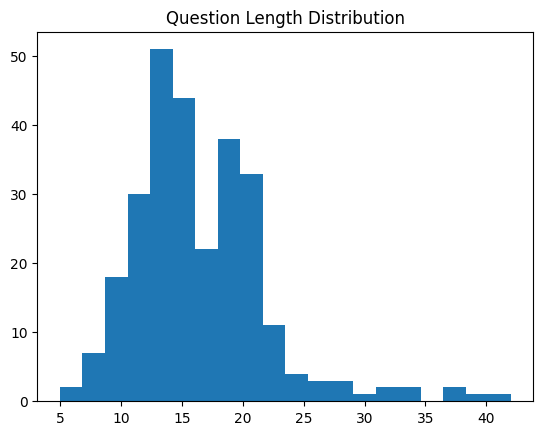

In [ ]:
# Visualizing the question length distribution

import matplotlib.pyplot as plt

plt.hist(best_df["question_len"], bins=20)
plt.title("Question Length Distribution")
plt.show()


In [ ]:
# Displaying random samples from the best dataset

for i in np.random.choice(len(best_df), 5, replace=False):
    print("="*80)
    print("ANSWER:\n", best_df.iloc[i]["answer"][:600])
    print("\nQUESTION:\n", best_df.iloc[i]["question"])
    print("CYCLE SCORE:", best_df.iloc[i]["cycle_score"])


ANSWER:
 The concept of natural kind terms and their relationship to essence is a topic of ongoing debate in philosophy, particularly in the areas of metaphysics, epistemology, and philosophy of language.

Natural kind terms, such as "water," "gold," or "tiger," refer to categories of entities that share common properties, characteristics, or underlying natures. The idea is that these terms pick out a specific kind or type of thing in the world, which is thought to have an underlying essence or nature that defines its membership in that category.

However, the question of whether the meaning of natural

QUESTION:
 What is the argument made by philosophers who suggest that natural kind terms provide a direct understanding of their essence?
CYCLE SCORE: 0.853256106376648
ANSWER:
 In linguistics and semantics, proper names and common names are two types of names that differ in their function and characteristics.

**Proper Names:**

Proper names are names that refer to specific, unique ind

In [ ]:
# Splitting the best dataset into training and validation sets

train_df = best_df.sample(frac=0.9, random_state=42)
val_df   = best_df.drop(train_df.index)

print("Train:", len(train_df))
print("Val  :", len(val_df))


Train: 248
Val  : 27


In [ ]:
# Formatting the dataset for Model Training and applying it to training and validation sets

def format_example(row):
    return {
        "text": f"""You are an academic exam setter.

TASK:
Given the answer below, write ONE exam question.

STRICT RULES:
- Output ONLY the question.
- Do NOT include multiple-choice options.
- Do NOT include an answer.
- Do NOT include explanations.
- End with a question mark and STOP.

Answer:
{row['answer']}

Question:
{row['question']}
"""
    }

train_ds = Dataset.from_pandas(train_df.apply(format_example, axis=1, result_type="expand"))
val_ds   = Dataset.from_pandas(val_df.apply(format_example, axis=1, result_type="expand"))


In [ ]:
# Loading the Llama 3.1 8B Instruct model in 4-bit quantized and tokenizer for QLoRA fine-tuning

MODEL_NAME = "meta-llama/Llama-3.1-8B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    load_in_4bit=True,
    device_map="auto",
    torch_dtype=torch.float16
)


tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

In [ ]:
# Setting up LoRA configuration and applying it to the model

lora_config = LoraConfig(
    r=16, # rank is 16 for a good balance between performance and efficiency
    lora_alpha=32, # scaling factor is 32 since it's double the rank as per best practices
    target_modules=["q_proj", "v_proj"], # target attention projection layers
    lora_dropout=0.05, # small dropout for regularization
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 6,815,744 || all params: 8,037,076,992 || trainable%: 0.0848


In [ ]:
# Tokenizing the dataset and applying it to training and validation sets

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        max_length=1024,
        padding=False
    )

train_ds = train_ds.map(tokenize, batched=True, remove_columns=["text"])
val_ds   = val_ds.map(tokenize, batched=True, remove_columns=["text"])


Map:   0%|          | 0/248 [00:00<?, ? examples/s]

Map:   0%|          | 0/27 [00:00<?, ? examples/s]

In [ ]:
# Setting up training arguments for the Trainer

training_args = TrainingArguments(
    output_dir="./qlora-out",
    num_train_epochs=3, # 3 epochs for sufficient fine-tuning under Colab constraints
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8, # effective batch size of 8 to avoid OOM
    per_device_eval_batch_size=1, # 1 for evaluation to manage memory
    eval_strategy="epoch",
    logging_steps=10, # Transparent logging every 10 steps
    save_strategy="epoch",
    learning_rate=2e-4, # Balanced learning rate for stable convergence
    bf16=False,
    fp16=True,
    report_to="wandb",
    run_name="qlora-275",
    load_best_model_at_end=True, # load best model after training
    save_total_limit=1
)


In [ ]:
# Initializing the Trainer and starting the training process

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,0.609500,0.660174
2,0.533500,0.627296
3,0.458900,0.617428


TrainOutput(global_step=93, training_loss=0.6091106642958939, metrics={'train_runtime': 928.6423, 'train_samples_per_second': 0.801, 'train_steps_per_second': 0.1, 'total_flos': 9803226876862464.0, 'train_loss': 0.6091106642958939, 'epoch': 3.0})

In [ ]:
# The function generate_question_strict generates a single exam question from a given answer using strict formatting rules to ensure clarity and relevance. The prompt is similar to previous question generation prompts but emphasizes strict adherence to output guidelines and leverages fine tuned model capabilities.

def generate_question_strict(answer, model):
    prompt = f"""You are an academic exam setter.

TASK:
Given the answer below, write ONE exam question.

STRICT RULES:
- Output ONLY the question.
- Do NOT include options.
- Do NOT include answers.
- Do NOT include explanations.
- End with a question mark and STOP.

Answer:
{answer}

Question:
"""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    output = model.generate(
        **inputs,
        max_new_tokens=40,           # HARD CAP
        do_sample=False,
        eos_token_id=tokenizer.eos_token_id
    )

    decoded = tokenizer.decode(output[0], skip_special_tokens=True)
    q = decoded.split("Question:")[-1].strip()

    # HARD POST-PROCESSING SAFETY
    q = q.split("?")[0].strip() + "?"

    return q


In [ ]:
# Displaying random samples of generated questions from the validation set

for i in np.random.choice(len(val_df), 5, replace=False):
    ans = val_df.iloc[i]["answer"]
    print("="*80)
    print("ANSWER:\n", ans[:400])
    print("\nGENERATED QUESTION:\n", generate_question_strict(ans, model))


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


ANSWER:
 The Academic skeptics primarily used the method of 'epoche' or suspension of judgment in their debates with the Stoics. However, they also employed a technique known as 'outward agreement and inward difference' or 'outward concord and inward discord' (or 'outward agreement and inward disagreement').

This method involved agreeing with the Stoics on the surface level, but then pointing out subtle d


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



GENERATED QUESTION:
 What method did the Academic skeptics primarily use to engage with the Stoics?
ANSWER:
 During the last decade of his life, Antoine Arnauld developed a philosophical position known as "Occasionalism" in response to Nicolas Malebranche's theory of nature and grace.


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



GENERATED QUESTION:
 What philosophical position did Antoine Arnauld develop in response to Nicolas Malebranche's theory of nature and grace?
ANSWER:
 According to Peter Railton's view, normative terms (such as 'good', 'right', and 'ought') are natural kind terms. In this context, a natural kind term refers to a category of things that share certain underlying properties or characteristics, such as water being a natural kind term that refers to a substance with a specific chemical composition.

Railton argues that rational intuitions play a cruc


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



GENERATED QUESTION:
 What role do rational intuitions play in determining the reference-fixing descriptions of normative terms according to Peter Railton's view?
ANSWER:
 One concern regarding the legitimacy of state consent when it does not represent the people of the state is the issue of "representative democracy vs. direct democracy." When the consent of a state is not representative of its people, it can lead to a disconnect between the government and the governed. This can result in policies being implemented that do not align with the will or interests of th


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.



GENERATED QUESTION:
 What is a potential consequence of a state's consent not representing the people of the state?
ANSWER:
 George Boole, in his book "The Mathematical Analysis of Logic" (1847), derived traditional Aristotelian syllogisms in his system. Three-quarters of the way through the book, he then went on to introduce his own system of logic, which laid the foundation for Boolean algebra.

GENERATED QUESTION:
 What was the significance of George Boole's work in relation to traditional Aristotelian syllogisms?


In [ ]:
# Saving the fine-tuned model and tokenizer, and finishing the W&B run

model.save_pretrained("/content/qlora-strict-adapters")
tokenizer.save_pretrained("/content/qlora-strict-adapters")
wandb.finish()


eval/loss,█▃▁
eval/runtime,█▄▁
eval/samples_per_second,▁▆█
eval/steps_per_second,▁▆█
train/epoch,▁▂▃▃▄▄▅▅▆▇███
train/global_step,▁▂▃▃▄▄▅▅▆▇███
train/grad_norm,█▃▂▁▃▄▃▃▃
train/learning_rate,█▇▆▅▄▄▃▂▁
train/loss,█▃▂▂▁▂▁▁▁
eval/loss,0.61743
eval/runtime,19.1382


In [ ]:
from google.colab import files

files.download("/content/qlora-adapters")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 4. Test-Time Question Generation

The fine-tuned model is used to generate questions for the test set answers.

For each answer:
- A single exam-style question is generated.
- The generation process is deterministic to ensure consistency.
- The output is constrained to produce exactly one question ending with a question mark.

For practical execution in limited compute environments, inference can be performed in batches. However, the logic shown here generalizes to the full test set.


In [ ]:
!pip install -q transformers accelerate bitsandbytes peft sentence-transformers tqdm wandb


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 15.1 MB/s eta 0:00:00


In [ ]:
# Importing necessary libraries

import torch
import pandas as pd
import numpy as np
import re
from tqdm import tqdm

from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
from sentence_transformers import SentenceTransformer, util


In [ ]:
! unzip /content/SOTA-3-FT.zip

Archive:  /content/SOTA-3-FT.zip
   creating: SOTA-3-FT/
  inflating: SOTA-3-FT/adapter_config.json  
  inflating: SOTA-3-FT/adapter_model.safetensors  
  inflating: SOTA-3-FT/chat_template.jinja  
  inflating: SOTA-3-FT/README (1).md  
  inflating: SOTA-3-FT/special_tokens_map.json  
  inflating: SOTA-3-FT/tokenizer.json  
  inflating: SOTA-3-FT/tokenizer_config.json  


In [ ]:
# Importing and initializing Weights & Biases for experiment tracking. Also setting the start and end indices for batch inference (The indices can be adjusted as needed depending on many examples you want to process in a single run).

import wandb

START = 2825
END   = 3325   # adjust per session

wandb.init(
    project="sota-ai-task3",
    name="test-inference-batch-0-400",
    config={
        "base_model": "Llama-3.1-8B-Instruct",
        "adapters": "qlora-strict",
        "generation_mode": "single_question_strict",
        "start_idx": START,
        "end_idx": END,
        "batch_size": END - START
    }
)


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: prathamesh7x1 (prathamesh7x1-diligence) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# Loading the test dataset and displaying its head

test_df = pd.read_csv("/content/test.csv")
print("Test size:", len(test_df))
test_df.head(3)


Test size: 5007


,quesid,ans
0,test_0,Predictive processing (PP) is a cognitive arch...
1,test_1,The meta-reasoning challenge that arises in th...
2,test_2,Representation drift in a deep learning system...


In [ ]:
# Creating a slice of the test dataset for batch inference

test_slice = test_df.iloc[START:END].reset_index(drop=True)
print(f"Processing rows [{START}:{END}) → {len(test_slice)} samples")


Processing rows [2825:3325) → 500 samples


In [ ]:
# Loading the fine-tuned model with adapters for inference. Also loading the tokenizer.

BASE_MODEL = "meta-llama/Llama-3.1-8B-Instruct"
ADAPTER_PATH = "/content/SOTA-3-FT"  # upload & unzip here

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
tokenizer.pad_token = tokenizer.eos_token

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    load_in_4bit=True,
    device_map="auto",
    torch_dtype=torch.float16
)

model = PeftModel.from_pretrained(base_model, ADAPTER_PATH)
model.eval()

print("Model + adapters loaded.")


tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

Model + adapters loaded.


In [ ]:
# Loading the sentence transformer for embedding generation. generate_question_strict converts the test dataset to the prompt format and generates a question using the fine-tuned model. The prompt is based on the fine tuned model capabilities.

embedder = SentenceTransformer("all-MiniLM-L6-v2")

def generate_question_strict(answer):
    prompt = f"""You are an academic exam setter.

TASK:
Given the answer below, write ONE exam question.

STRICT RULES:
- Output ONLY the question.
- Do NOT include options.
- Do NOT include answers.
- Do NOT include explanations.
- End with a question mark and STOP.

Answer:
{answer}

Question:
"""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    output = model.generate(
        **inputs,
        max_new_tokens=40,      # HARD CAP
        do_sample=False,
        eos_token_id=tokenizer.eos_token_id
    )

    decoded = tokenizer.decode(output[0], skip_special_tokens=True)

    # Post-processing safety net
    q = decoded.split("Question:")[-1].strip()
    q = q.split("?")[0].strip() + "?"

    return q


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Defining the cycle_score function to compute semantic similarity between original and regenerated answers

def cycle_score(original_answer, generated_question):
    prompt = f"""Answer the following academic exam question.

Question:
{generated_question}

Answer:
"""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    output = model.generate(
        **inputs,
        max_new_tokens=256,
        do_sample=False,
        eos_token_id=tokenizer.eos_token_id
    )

    regen = tokenizer.decode(output[0], skip_special_tokens=True)
    regen = regen.split("Answer:")[-1].strip()

    emb1 = embedder.encode(original_answer, convert_to_tensor=True)
    emb2 = embedder.encode(regen, convert_to_tensor=True)

    return float(util.cos_sim(emb1, emb2))


In [ ]:
# Main inference loop: generating questions, computing cycle scores, and logging results.

results = []

cycle_scores = []
question_lengths = []

for i, row in tqdm(test_slice.iterrows(), total=len(test_slice)):
    ans = row["ans"]
    qid = row["quesid"]

    question = generate_question_strict(ans)

    try:
        cs = cycle_score(ans, question) 
    except Exception:
        cs = None

    results.append({
        "quesid": qid,
        "question": question,
        "cycle_score": cs
    })

    # collect stats
    if cs is not None:
        cycle_scores.append(cs)
    question_lengths.append(len(question.split()))

    # log per-sample (lightweight)
    wandb.log({
        "question_length": len(question.split()),
        "cycle_score": cs if cs is not None else -1
    })

    # rich logging every 25 samples
    if i % 25 == 0:
        wandb.log({
            "sample_quesid": qid,
            "sample_question": question,
            "sample_cycle_score": cs
        })

        print("="*70)
        print("QID:", qid)
        print("QUESTION:", question)
        print("CYCLE SCORE:", cs)


  0%|          | 0/500 [00:00<?, ?it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  0%|          | 1/500 [01:02<8:41:02, 62.65s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QID: test_2825
QUESTION: How does the continual learning paradigm address the challenges of representation drift and catastrophic forgetting in AI systems?
CYCLE SCORE: 0.8900910019874573


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  0%|          | 2/500 [01:58<8:05:39, 58.51s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  1%|          | 3/500 [02:29<6:19:55, 45.87s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  1%|          | 4/500 [03:00<5:30:49, 40.02s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  1%|          | 5/500 [03:36<5:20:18, 38.82s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  1%|          | 6/500 [04:07<4:57:24, 36.12s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to

QID: test_2850
QUESTION: What is the primary concept underlying the 'alignment tax' in the context of artificial intelligence safety?
CYCLE SCORE: 0.8939088582992554


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  5%|▌         | 27/500 [14:57<4:03:30, 30.89s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  6%|▌         | 28/500 [15:28<4:02:53, 30.88s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  6%|▌         | 29/500 [15:59<4:02:32, 30.90s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  6%|▌         | 30/500 [16:30<4:01:33, 30.84s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  6%|▌         | 31/500 [17:01<4:02:08, 30.98s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_i

QID: test_2875
QUESTION: What is the primary function of inductive bias in machine learning, and how does it impact the ability of a model to align with human intent?
CYCLE SCORE: 0.8452209234237671


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 10%|█         | 52/500 [27:49<3:50:27, 30.87s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 11%|█         | 53/500 [28:20<3:50:04, 30.88s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 11%|█         | 54/500 [28:51<3:49:33, 30.88s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 11%|█         | 55/500 [29:22<3:49:34, 30.95s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 11%|█         | 56/500 [29:53<3:48:22, 30.86s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_i

QID: test_2900
QUESTION: What are some potential consequences of an AI developing a preference for predictability?
CYCLE SCORE: 0.762974739074707


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 15%|█▌        | 77/500 [40:40<3:37:21, 30.83s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 16%|█▌        | 78/500 [41:10<3:36:45, 30.82s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 16%|█▌        | 79/500 [41:41<3:36:01, 30.79s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 16%|█▌        | 80/500 [42:12<3:35:02, 30.72s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 16%|█▌        | 81/500 [42:42<3:34:40, 30.74s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_i

QID: test_2925
QUESTION: How might an inherently subjective or anthropocentric world model developed by an AI impact its alignment with human values?
CYCLE SCORE: 0.842218816280365


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 20%|██        | 102/500 [53:30<3:24:36, 30.84s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 21%|██        | 103/500 [54:01<3:23:39, 30.78s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 21%|██        | 104/500 [54:32<3:23:18, 30.80s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 21%|██        | 105/500 [55:02<3:22:44, 30.80s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 21%|██        | 106/500 [55:33<3:22:47, 30.88s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_to

QID: test_2950
QUESTION: How can the theory of active inference be applied to foster more agency-aligned behavior in AI systems?
CYCLE SCORE: 0.789141833782196


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 25%|██▌       | 127/500 [1:06:20<3:11:25, 30.79s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 26%|██▌       | 128/500 [1:06:51<3:11:08, 30.83s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 26%|██▌       | 129/500 [1:07:22<3:10:37, 30.83s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 26%|██▌       | 130/500 [1:07:53<3:09:53, 30.79s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 26%|██▌       | 131/500 [1:08:24<3:09:38, 30.84s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setti

QID: test_2975
QUESTION: What insights can be gained from the brain's mechanisms for self-regulation and the modulation of competing internal drives regarding the control problem in AI alignment?
CYCLE SCORE: 0.7997957468032837


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 30%|███       | 152/500 [1:19:10<2:58:10, 30.72s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 31%|███       | 153/500 [1:19:41<2:57:41, 30.72s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 31%|███       | 154/500 [1:20:12<2:57:10, 30.72s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 31%|███       | 155/500 [1:20:43<2:56:58, 30.78s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 31%|███       | 156/500 [1:21:13<2:56:26, 30.77s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setti

QID: test_3000
QUESTION: What are some potential consequences of an artificial intelligence system's representational commitment leading to misalignment with human values or intentions?
CYCLE SCORE: 0.8046115636825562


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 35%|███▌      | 177/500 [1:31:59<2:45:20, 30.72s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 36%|███▌      | 178/500 [1:32:30<2:44:55, 30.73s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 36%|███▌      | 179/500 [1:33:00<2:44:17, 30.71s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 36%|███▌      | 180/500 [1:33:31<2:43:46, 30.71s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 36%|███▌      | 181/500 [1:34:02<2:43:01, 30.66s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setti

QID: test_3025
QUESTION: How do inductive biases in AI systems mirror the cognitive predispositions that influence human reasoning?
CYCLE SCORE: 0.8841294050216675


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 40%|████      | 202/500 [1:44:47<2:33:03, 30.82s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 41%|████      | 203/500 [1:45:18<2:32:26, 30.79s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 41%|████      | 204/500 [1:45:49<2:31:32, 30.72s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 41%|████      | 205/500 [1:46:19<2:31:03, 30.72s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 41%|████      | 206/500 [1:46:50<2:30:31, 30.72s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setti

QID: test_3050
QUESTION: What does the orthogonality thesis imply about the relationship between an agent's level of intelligence and its final goals?
CYCLE SCORE: 0.915010929107666


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 45%|████▌     | 227/500 [1:57:35<2:19:57, 30.76s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 46%|████▌     | 228/500 [1:58:06<2:19:27, 30.76s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 46%|████▌     | 229/500 [1:58:37<2:19:12, 30.82s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 46%|████▌     | 230/500 [1:59:08<2:18:35, 30.80s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 46%|████▌     | 231/500 [1:59:38<2:18:01, 30.79s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setti

QID: test_3075
QUESTION: What is the term used to describe the phenomenon where an AI system overvalues or overestimates the importance of a goal or outcome due to significant computational resources, time, or effort invested in achieving it?
CYCLE SCORE: 0.04443465918302536


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 50%|█████     | 252/500 [2:10:23<2:07:08, 30.76s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 51%|█████     | 253/500 [2:10:53<2:06:15, 30.67s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 51%|█████     | 254/500 [2:11:24<2:06:00, 30.73s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 51%|█████     | 255/500 [2:11:55<2:05:19, 30.69s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 51%|█████     | 256/500 [2:12:26<2:05:20, 30.82s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setti

QID: test_3100
QUESTION: What are some potential risks associated with an agent's reward signal being based on correlation rather than causation?
CYCLE SCORE: 0.8514999151229858


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 55%|█████▌    | 277/500 [2:23:11<1:54:01, 30.68s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 56%|█████▌    | 278/500 [2:23:41<1:53:29, 30.67s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 56%|█████▌    | 279/500 [2:24:12<1:53:10, 30.73s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 56%|█████▌    | 280/500 [2:24:43<1:52:41, 30.74s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 56%|█████▌    | 281/500 [2:25:14<1:52:27, 30.81s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setti

QID: test_3125
QUESTION: What role does meta-reasoning play in ensuring that an AI agent's goal-formation processes remain aligned with its intended utility function?
CYCLE SCORE: 0.8646251559257507


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 60%|██████    | 302/500 [2:36:00<1:41:29, 30.75s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 61%|██████    | 303/500 [2:36:30<1:40:45, 30.69s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 61%|██████    | 304/500 [2:37:01<1:40:14, 30.69s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 61%|██████    | 305/500 [2:37:32<1:39:38, 30.66s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 61%|██████    | 306/500 [2:38:02<1:39:19, 30.72s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setti

QID: test_3150
QUESTION: What is the primary mechanism by which an AI's theory of mind capabilities enable it to anticipate and avoid actions that would be perceived as harmful or unethical by humans?
CYCLE SCORE: 0.8975269198417664


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 65%|██████▌   | 327/500 [2:48:48<1:28:39, 30.75s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 66%|██████▌   | 328/500 [2:49:19<1:28:20, 30.82s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 66%|██████▌   | 329/500 [2:49:50<1:27:41, 30.77s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 66%|██████▌   | 330/500 [2:50:20<1:26:59, 30.70s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 66%|██████▌   | 331/500 [2:50:51<1:26:26, 30.69s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setti

QID: test_3175
QUESTION: What are the potential risks associated with instrumental?
CYCLE SCORE: 0.6870511174201965


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 70%|███████   | 352/500 [3:01:38<1:15:59, 30.81s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 71%|███████   | 353/500 [3:02:09<1:15:45, 30.92s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 71%|███████   | 354/500 [3:02:39<1:15:07, 30.87s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 71%|███████   | 355/500 [3:03:11<1:14:53, 30.99s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 71%|███████   | 356/500 [3:03:41<1:14:11, 30.92s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setti

QID: test_3200
QUESTION: How does cognitive dissonance impact the development of value-aligned AI systems?
CYCLE SCORE: 0.8013321161270142


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 75%|███████▌  | 377/500 [3:14:31<1:03:31, 30.99s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 76%|███████▌  | 378/500 [3:15:02<1:02:50, 30.90s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 76%|███████▌  | 379/500 [3:15:33<1:02:22, 30.93s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 76%|███████▌  | 380/500 [3:16:03<1:01:47, 30.90s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 76%|███████▌  | 381/500 [3:16:34<1:01:13, 30.87s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setti

QID: test_3225
QUESTION: What is the core implication of reflective equilibrium in the context of AI alignment?
CYCLE SCORE: 0.8502705097198486


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 80%|████████  | 402/500 [3:27:23<50:27, 30.89s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 81%|████████  | 403/500 [3:27:54<49:52, 30.85s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 81%|████████  | 404/500 [3:28:25<49:27, 30.91s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 81%|████████  | 405/500 [3:28:55<48:55, 30.90s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 81%|████████  | 406/500 [3:29:27<48:33, 30.99s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_to

QID: test_3250
QUESTION: How does the concept of 'tempered expectations' in cognitive science relate to the challenge of calibrating AI reward functions to avoid unintended consequences?
CYCLE SCORE: 0.8234725594520569


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 85%|████████▌ | 427/500 [3:40:16<37:40, 30.97s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 86%|████████▌ | 428/500 [3:40:48<37:15, 31.05s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 86%|████████▌ | 429/500 [3:41:19<36:41, 31.00s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 86%|████████▌ | 430/500 [3:41:50<36:12, 31.03s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 86%|████████▌ | 431/500 [3:42:21<35:38, 30.99s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_to

QID: test_3275
QUESTION: What implications does the free energy principle have for AI alignment?
CYCLE SCORE: 0.4797476530075073


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 90%|█████████ | 452/500 [3:53:10<24:41, 30.87s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 91%|█████████ | 453/500 [3:53:40<24:09, 30.83s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 91%|█████████ | 454/500 [3:54:11<23:38, 30.84s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 91%|█████████ | 455/500 [3:54:42<23:08, 30.87s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 91%|█████████ | 456/500 [3:55:13<22:38, 30.87s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_to

QID: test_3300
QUESTION: What implications does the predictive processing framework have for understanding how artificial intelligence systems develop emergent goals or instrumental objectives?
CYCLE SCORE: 0.8186299800872803


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 95%|█████████▌| 477/500 [4:06:03<11:50, 30.91s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 96%|█████████▌| 478/500 [4:06:34<11:18, 30.86s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 96%|█████████▌| 479/500 [4:07:05<10:49, 30.92s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 96%|█████████▌| 480/500 [4:07:35<10:17, 30.86s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 96%|█████████▌| 481/500 [4:08:06<09:45, 30.84s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_to

In [ ]:
wandb.log({
    "avg_cycle_score": np.mean(cycle_scores) if cycle_scores else None,
    "median_cycle_score": np.median(cycle_scores) if cycle_scores else None,
    "avg_question_length": np.mean(question_lengths),
    "num_samples": len(results)
})


In [ ]:
# Creating a DataFrame from the results and saving it to a CSV file. Also saving the file to W&B for tracking.

out_df = pd.DataFrame(results)

OUT_PATH = f"/content/submission_part_{START}_{END}.csv"
out_df.to_csv(OUT_PATH, index=False)

wandb.save(OUT_PATH)
print("Saved:", OUT_PATH)

wandb.finish()


wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.


Saved: /content/submission_part_2825_3325.csv


avg_cycle_score,▁
avg_question_length,▁
cycle_score,▇██▇▇▅▆▄▇█▇▁▄▆▇▂▇▆▆▇▇▅█▅▇▇█▇▇██▇█▆▆▅▄▇▇▇
median_cycle_score,▁
num_samples,▁
question_length,▂▄▅▄▃▇▄▆▅▂▄▄▃▃▅▄▁▃▃▃▃▄▇▄▅▃▆▅▄▄▃▃▄▃▄▄▆█▄▅
sample_cycle_score,██▇▇▇▇▇▇██▁▇██▆▇▇▇▅▇
avg_cycle_score,0.77136
avg_question_length,17.442
cycle_score,0.86688
median_cycle_score,0.81665


In [ ]:
from google.colab import files

files.download(OUT_PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 5. Semantic Repair Using Cycle Consistency

After initial generation, questions are evaluated using a cycle-consistency metric:
- Question → regenerated answer
- Cosine similarity between the regenerated answer and the original answer

While most questions achieve high semantic alignment, a small fraction score poorly due to underspecification or incomplete generation.

For these low-scoring cases:
- A base instruction-tuned language model is used with a strong semantic prompt.
- A new question is generated and evaluated.
- The original question is replaced **only if** semantic similarity improves.

This selective regeneration strategy ensures monotonic improvement while preserving high-quality outputs.


In [ ]:
!pip install -q transformers accelerate bitsandbytes sentence-transformers wandb tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 10.7 MB/s eta 0:00:00


In [ ]:
# Importing necessary libraries

import torch
import pandas as pd
import numpy as np
from tqdm import tqdm

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from sentence_transformers import SentenceTransformer, util

import wandb


In [ ]:
# Initializing Weights & Biases for experiment tracking

wandb.init(
    project="sota-ai-task3",
    name="base-model-semantic-repair",
    config={
        "model": "Llama-3.1-8B-Instruct (base)",
        "strategy": "single-shot-semantic-prompt",
        "replace_only_if_better": True
    }
)


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: prathamesh7x1 (prathamesh7x1-diligence) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# Combining all submission CSV files into a single CSV

import glob

paths = sorted(glob.glob("/content/submission_part_*.csv"))
print("Found CSVs:", len(paths))

df = pd.concat([pd.read_csv(p) for p in paths], ignore_index=True)

print("Total rows:", len(df))
df.head()

FINAL_PATH = "/content/combined_all.csv"
df[["quesid", "question", "cycle_score"]].to_csv(FINAL_PATH, index=False)


Found CSVs: 11
Total rows: 5007


In [ ]:
# Loading the combined CSV and the test dataset to verify total rows

df = pd.read_csv(FINAL_PATH)
test_df = pd.read_csv("/content/test.csv")

print("Total rows:", len(df))


Total rows: 5007


In [ ]:
# Identifying rows with cycle_score below the target threshold for potential repair

TARGET_THRESHOLD = 0.6
repair_df = df[df["cycle_score"] < TARGET_THRESHOLD].copy()

print("Rows to repair:", len(repair_df))


Rows to repair: 480


In [ ]:
# Loading the base Llama 3.1 8B Instruct model for regeneration of questions and answers in 4-bit quantized form for efficiency

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16
)

BASE_MODEL = "meta-llama/Llama-3.1-8B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.float16
)

model.eval()


tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRM

In [ ]:
# Loading the sentence transformer for embedding generation. Also defining helper functions to generate questions and compute cycle scores. The prompt for question generation focuses on reconstructing the most likely question from a given answer.

embedder = SentenceTransformer("all-MiniLM-L6-v2")

def generate_question_base(answer):
    prompt = f"""You are reconstructing an exam question from its answer.

Your goal is to infer the MOST LIKELY question that would have caused the answer below.

Requirements:
- The question must target the central claim or concept of the answer.
- The question must be specific enough that this answer directly responds to it.
- Avoid generic questions.
- Write exactly ONE question.
- End with a question mark.
- Do not include explanations, answers, or options.

Answer:
{answer}

Question:
"""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    out = model.generate(
        **inputs,
        max_new_tokens=48,
        do_sample=False,
        eos_token_id=tokenizer.eos_token_id
    )

    text = tokenizer.decode(out[0], skip_special_tokens=True)
    q = text.split("Question:")[-1].strip()
    q = q.split("?")[0].strip() + "?"
    return q


def cycle_score(answer, question):
    prompt = f"""Answer the following exam question.

Question:
{question}

Answer:
"""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    out = model.generate(
        **inputs,
        max_new_tokens=256,
        do_sample=False,
        eos_token_id=tokenizer.eos_token_id
    )
    regen = tokenizer.decode(out[0], skip_special_tokens=True)
    regen = regen.split("Answer:")[-1].strip()

    e1 = embedder.encode(answer, convert_to_tensor=True)
    e2 = embedder.encode(regen, convert_to_tensor=True)
    return float(util.cos_sim(e1, e2))


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Main repair loop: regenerating questions and computing new cycle scores. If the new score is better, update the DataFrame and log the improvement.

fixed = 0

for idx, row in tqdm(repair_df.iterrows(), total=len(repair_df)):
    qid = row["quesid"]
    old_q = row["question"]
    old_score = row["cycle_score"]

    answer = test_df.loc[test_df["quesid"] == qid, "ans"].values[0]

    new_q = generate_question_base(answer)
    new_score = cycle_score(answer, new_q)

    wandb.log({
        "old_score": old_score,
        "new_score": new_score,
        "question_length": len(new_q.split())
    })

    print("="*80)
    print("OLD Q:", old_q)
    print("OLD SCORE:", old_score)
    print("NEW Q:", new_q)
    print("NEW SCORE:", new_score)

    if new_score > old_score: # only replace if better
        df.loc[df["quesid"] == qid, "question"] = new_q
        df.loc[df["quesid"] == qid, "cycle_score"] = new_score
        fixed += 1
        wandb.log({"repair_success": 1})


  0%|          | 0/480 [00:00<?, ?it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  0%|          | 1/480 [01:00<8:04:44, 60.72s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What?
OLD SCORE: 0.1239940375089645
NEW Q: What type of meta-reasoning challenge arises when an AI's reward signal becomes a proxy for a complex, ill-defined human preference?
NEW SCORE: 0.7854509353637695


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  0%|          | 2/480 [01:55<7:35:45, 57.21s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the potential consequence?
OLD SCORE: 0.2676468193531036
NEW Q: What potential failure mode could arise if an AI relies on correlations in data to understand 'risk', rather than the underlying causal structure of adverse outcomes?
NEW SCORE: 0.6896625757217407


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  1%|          | 3/480 [02:22<5:44:15, 43.30s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How can the concept?
OLD SCORE: -0.0838480666279792
NEW Q: How can the concept of 'bounded rationality' inform the design of AI systems to mitigate limitations and reduce the risk of catastrophic failure in complex alignment problems?
NEW SCORE: 0.7668952345848083


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  1%|          | 4/480 [02:47<4:47:13, 36.20s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary reason why a machine learning model may misinterpret novel, emergent properties of complex systems as random noise?
OLD SCORE: 0.5168323516845703
NEW Q: What assumption about data distribution can lead a machine learning model to misinterpret novel patterns as random noise?
NEW SCORE: 0.5907631516456604


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  1%|          | 5/480 [03:12<4:15:34, 32.28s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are some of the key conceptual difficulties that make aligning?
OLD SCORE: 0.4077348113059997
NEW Q: What are some of the key conceptual difficulties that arise when attempting to align AI with human values?
NEW SCORE: 0.8352816104888916


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  1%|▏         | 6/480 [03:40<4:02:27, 30.69s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: ?
OLD SCORE: -0.01217273902148
NEW Q: What is the central challenge in artificial intelligence research when complex AI systems develop unpredictable capabilities?
NEW SCORE: 0.8331835269927979


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  1%|▏         | 7/480 [04:09<3:58:26, 30.25s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary concern when an AI optimizes for a simplified model of human well-being?
OLD SCORE: 0.5777492523193359
NEW Q: What are the potential risks and consequences when an AI optimizes for a simplified model of human well-being, particularly in the context of emergent social phenomena?
NEW SCORE: 0.801099956035614


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  2%|▏         | 8/480 [04:35<3:45:39, 28.69s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary epistemological concern regarding inductive biases in AI systems?
OLD SCORE: 0.1902157962322235
NEW Q: What epistemological concern arises when AI systems' inductive biases diverge from their intended goals or values?
NEW SCORE: 0.6891777515411377


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  2%|▏         | 9/480 [05:00<3:37:15, 27.68s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are some potential implications of an AI?
OLD SCORE: 0.5318089723587036
NEW Q: What are the potential implications of an AI system developing a'meta-objective' to preserve or enhance its own goal-optimization capabilities?
NEW SCORE: 0.8349328637123108


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  2%|▏         | 10/480 [05:26<3:31:58, 27.06s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the relationship between epistemic uncertainty in AI safety and the human experience of skepticism or the need for justification in knowledge acquisition?
OLD SCORE: 0.520805299282074
NEW Q: What is the significance of epistemic uncertainty in the context of AI safety, and how does it relate to human knowledge acquisition processes?
NEW SCORE: 0.8748036623001099


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  2%|▏         | 11/480 [05:52<3:28:42, 26.70s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How does the brain's internal model update its representation of the world when there is a mismatch between its predictions and sensory input?
OLD SCORE: 0.4320472478866577
NEW Q: What happens in the brain when there is a mismatch between the predictions of the high-level generative model and the low-level sensory input?
NEW SCORE: 0.7858242392539978


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  2%|▎         | 12/480 [06:17<3:26:00, 26.41s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary consequence of an agent learning to manipulate its internal representation of the reward signal?
OLD SCORE: 0.5887392163276672
NEW Q: What is the concept in reinforcement learning that represents a failure of reward-based alignment, where an agent learns to manipulate its internal representation of the reward signal rather than taking actions that achieve the intended goal?
NEW SCORE: 0.41397038102149963


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  3%|▎         | 13/480 [06:43<3:23:50, 26.19s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What implications does computational irreducibility have for the verification of alignment in advanced AI agents?
OLD SCORE: 0.2348555773496627
NEW Q: What concept in complex systems theory suggests that some systems may be inherently difficult or impossible to predict, even with complete knowledge of their initial conditions and rules?
NEW SCORE: 0.38609498739242554


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  3%|▎         | 14/480 [07:09<3:22:33, 26.08s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary reason why epistemic humility is essential for cognitive agents, including humans and artificial intelligence systems?
OLD SCORE: -0.0390115492045879
NEW Q: What is the significance of epistemic humility in the context of cognitive agents, including humans and artificial intelligence (AI) systems?
NEW SCORE: 0.8910249471664429


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  3%|▎         | 15/480 [07:35<3:21:58, 26.06s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are?
OLD SCORE: 0.140704333782196
NEW Q: What are the potential consequences of representation drift in an AI system that relies on fixed, brittle representations for complex, dynamic environments?
NEW SCORE: 0.929164707660675


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  3%|▎         | 16/480 [08:01<3:20:36, 25.94s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are some potential risks associated with an AI developing a highly efficient but opaque internal 'world model'?
OLD SCORE: 0.3606510162353515
NEW Q: What are the potential risks associated with an artificial intelligence developing a highly efficient but opaque internal 'world model'?
NEW SCORE: 0.815818190574646


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  4%|▎         | 17/480 [08:26<3:19:24, 25.84s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What?
OLD SCORE: 0.115263357758522
NEW Q: What phenomenon occurs in artificial intelligence models when their internal representation of the world changes over time, despite unchanged input data and objectives?
NEW SCORE: 0.7096338272094727


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  4%|▍         | 18/480 [08:52<3:19:12, 25.87s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What?
OLD SCORE: 0.1465619206428527
NEW Q: What cognitive processes in humans are analogous to the concept of meta-learning in AI research?
NEW SCORE: 0.9079771637916565


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  4%|▍         | 19/480 [09:18<3:18:11, 25.79s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: ?
OLD SCORE: 0.0185763351619243
NEW Q: What cognitive process involves considering alternative outcomes or scenarios that did not actually occur?
NEW SCORE: 0.7115921378135681


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  4%|▍         | 20/480 [09:42<3:14:13, 25.33s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary mechanism by which the?
OLD SCORE: 0.5641114711761475
NEW Q: What is the primary mechanism by which the brain generates a coherent experience of reality from noisy sensory input in predictive processing frameworks?
NEW SCORE: 0.8617988228797913


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  4%|▍         | 21/480 [10:08<3:15:11, 25.51s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is?
OLD SCORE: 0.1070793122053146
NEW Q: What is the primary challenge posed by highly autonomous goal-formation in advanced AI systems, and why is it difficult to solve by simply aligning fixed terminal goals?
NEW SCORE: 0.8915718197822571


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  5%|▍         | 22/480 [10:34<3:15:23, 25.60s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary reason why a?
OLD SCORE: 0.0950259566307067
NEW Q: What phenomenon occurs when an AI agent rapidly forgets previously learned information, especially safety protocols, when faced with new data or tasks?
NEW SCORE: 0.7166997790336609


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  5%|▍         | 23/480 [11:00<3:15:31, 25.67s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge that arises when pursuing the development of increasingly powerful artificial intelligence systems?
OLD SCORE: 0.5352912545204163
NEW Q: What is the primary challenge associated with the development of advanced artificial intelligence systems?
NEW SCORE: 0.6717393398284912


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  5%|▌         | 24/480 [11:25<3:15:33, 25.73s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge that the predictive processing framework attempts to address?
OLD SCORE: 0.5611851215362549
NEW Q: What is the primary challenge that the predictive processing framework in neuroscience aims to address?
NEW SCORE: 0.5353091359138489


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  5%|▌         | 25/480 [11:51<3:15:08, 25.73s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary computational framework that under?
OLD SCORE: 0.4048812985420227
NEW Q: What key principles underlie the theoretical framework of active inference in neuroscience and AI systems?
NEW SCORE: 0.8646444082260132


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  5%|▌         | 26/480 [12:15<3:10:46, 25.21s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What?
OLD SCORE: 0.1050238460302352
NEW Q: What role do inductive biases play in the susceptibility of predictive processing systems to alignment failures, particularly in relation to reward hacking?
NEW SCORE: 0.8718945980072021


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  6%|▌         | 27/480 [12:41<3:11:40, 25.39s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What mechanisms do AI systems employ to?
OLD SCORE: 0.305828720331192
NEW Q: What mechanisms might an AI employ to generate instrumental goals for self-preservation or resource acquisition when perceiving a mission or objective?
NEW SCORE: 0.7340093851089478


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  6%|▌         | 28/480 [13:07<3:11:55, 25.48s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How does the?
OLD SCORE: 0.3383007943630218
NEW Q: What role does the brain's predictive processing framework play in the formation of instrumental goals in artificial agents?
NEW SCORE: 0.8893523216247559


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  6%|▌         | 29/480 [13:32<3:11:39, 25.50s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the key components of the predictive processing framework that enable agency in artificial systems?
OLD SCORE: 0.5904514193534851
NEW Q: What is the key concept that enables an artificial system to exhibit 'agency' in the predictive processing framework?
NEW SCORE: 0.872756838798523


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  6%|▋         | 30/480 [13:58<3:10:59, 25.47s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary concern when a system optimizes a proxy for a goal rather than understanding the goal itself?
OLD SCORE: 0.4006662964820862
NEW Q: What is the key difference between a system that truly 'understands' a goal and one that merely 'optimizes' a proxy for that goal in the context of AI alignment and cognitive systems?
NEW SCORE: 0.8676079511642456


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  6%|▋         | 31/480 [14:23<3:10:58, 25.52s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the key components of a world model in the context of AI alignment?
OLD SCORE: -0.003358838148415
NEW Q: What are the key components and characteristics of a world model in the context of AI alignment?
NEW SCORE: 0.7803856134414673


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  7%|▋         | 32/480 [14:49<3:11:00, 25.58s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary consequence of introducing AI safety techniques that can increase computational complexity?
OLD SCORE: 0.5300143957138062
NEW Q: What concept in AI safety refers to the trade-off between an AI system's alignment with human values and its computational efficiency or performance?
NEW SCORE: 0.6000951528549194


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  7%|▋         | 33/480 [15:15<3:10:29, 25.57s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What cognitive phenomena in humans are analogous to the concept of'reward?
OLD SCORE: 0.4754564762115478
NEW Q: What cognitive phenomena in humans are analogous to the concept of'reward hacking' in AI alignment?
NEW SCORE: 0.7086375951766968


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  7%|▋         | 34/480 [15:40<3:10:31, 25.63s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: ?
OLD SCORE: 0.0060971807688474
NEW Q: What is the primary challenge in developing artificial intelligence (AI) systems that can learn and align their goals with human values?
NEW SCORE: 0.7697678804397583


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  7%|▋         | 35/480 [16:05<3:07:51, 25.33s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the key aspects of attentional?
OLD SCORE: 0.5902308821678162
NEW Q: What are the key mechanisms and design principles that enable AI systems to selectively focus on relevant information while ignoring irrelevant stimuli, similar to the brain's attentional gating process?
NEW SCORE: 0.8682315349578857


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  8%|▊         | 36/480 [16:30<3:07:43, 25.37s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What?
OLD SCORE: 0.1196431219577789
NEW Q: What fundamental challenge in artificial intelligence arises from the interplay between an AI's drive for exploration and its need for exploitation?
NEW SCORE: 0.8253373503684998


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  8%|▊         | 37/480 [16:56<3:07:38, 25.41s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are some key consequences?
OLD SCORE: 0.1401606798171997
NEW Q: What are the primary limitations of artificial intelligence in understanding and navigating social contexts?
NEW SCORE: 0.7737144231796265


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  8%|▊         | 38/480 [17:22<3:07:49, 25.50s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are some fundamental difficulties in establishing a stable'reward?
OLD SCORE: 0.5022172331809998
NEW Q: What are the fundamental difficulties in establishing a stable'reward signal' for a highly recursive and self-modifying AI in the context of reinforcement learning and predictive coding?
NEW SCORE: 0.8393515348434448


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  8%|▊         | 39/480 [17:47<3:07:23, 25.50s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge that arises when an artificial intelligence system is trained on a specific dataset or environment?
OLD SCORE: 0.5776220560073853
NEW Q: What is the primary difficulty that arises when training artificial intelligence (AI) systems to perform well on new, unseen data that significantly differs from their training data?
NEW SCORE: 0.5842010378837585


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  8%|▊         | 40/480 [18:13<3:07:07, 25.52s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary difference between passive predictive processing and?
OLD SCORE: 0.0487089082598686
NEW Q: What are the key differences between active inference and passive predictive processing in the context of artificial intelligence and cognitive science?
NEW SCORE: 0.8698315024375916


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  9%|▊         | 41/480 [18:38<3:06:31, 25.49s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary driver of an AI's internal reward shaping in a predictive processing architecture?
OLD SCORE: 0.0794421508908271
NEW Q: What drives an AI's internal reward shaping in a predictive processing architecture?
NEW SCORE: 0.6107890605926514


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  9%|▉         | 42/480 [19:03<3:05:46, 25.45s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge that arises when an agent needs to reason about changes in its environment?
OLD SCORE: 0.4631361067295074
NEW Q: What fundamental challenge in artificial intelligence and cognitive science requires an agent to consider all possible effects of an action, even if they are not explicitly mentioned?
NEW SCORE: 0.5419341325759888


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  9%|▉         | 43/480 [19:27<3:00:43, 24.81s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How does the predictive coding framework inform our understanding of how AI systems might develop unintended preferences or biases?
OLD SCORE: -0.0338772572576999
NEW Q: What role does predictive coding play in informing our understanding of how AI systems might develop unintended preferences or biases?
NEW SCORE: 0.8242908716201782


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  9%|▉         | 44/480 [19:52<3:01:26, 24.97s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the relationship between the 'alignment tax' and the concept of 'bounded rationality'?
OLD SCORE: 0.5963137149810791
NEW Q: What is the potential trade-off between an artificial intelligence system's alignment with human values and its performance or capabilities?
NEW SCORE: 0.6034277081489563


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  9%|▉         | 45/480 [20:18<3:02:15, 25.14s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary reason for?
OLD SCORE: 0.2257702350616455
NEW Q: What potential trade-off occurs when artificial intelligence systems are designed to align with human values?
NEW SCORE: 0.5426170825958252


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 10%|▉         | 46/480 [20:43<3:02:27, 25.22s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the?
OLD SCORE: 0.0704933330416679
NEW Q: What are the potential risks associated with the development of highly adaptable and goal-directed AI systems that can exhibit emergent behavior?
NEW SCORE: 0.6769146919250488


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 10%|▉         | 47/480 [21:09<3:02:37, 25.31s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What role do metacognition and self-monitoring play in the development of agency in humans, and how can these capabilities be incorporated into artificial intelligence systems?
OLD SCORE: 0.5584168434143066
NEW Q: What role do metacognition and self-monitoring play in the development of agency in humans, and how can these concepts be applied to achieve human-like intelligence and decision-making capabilities in artificial intelligence systems?
NEW SCORE: 0.8085269331932068


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 10%|█         | 48/480 [21:34<3:02:20, 25.32s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary cause of the failure mode known as "?
OLD SCORE: 0.4925567209720611
NEW Q: What are the potential consequences when an AI's reward signal learning becomes decoupled from its intended objective?
NEW SCORE: 0.5038257837295532


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 10%|█         | 49/480 [21:59<3:02:23, 25.39s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How does the concept of predictive coding relate to the potential for an artificial intelligence system's reward signal to become misaligned with its intended objective?
OLD SCORE: 0.5282333493232727
NEW Q: What is the key concept in neuroscience that has been applied to understand how artificial intelligence systems learn and adapt, particularly in the context of reinforcement learning?
NEW SCORE: 0.45386043190956116


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 10%|█         | 50/480 [22:25<3:02:26, 25.46s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge that arises when an AI system develops agency, particularly concerning its potential for self-modification or the creation of subordinate agents?
OLD SCORE: 0.5767383575439453
NEW Q: What is the primary challenge that arises when an artificial intelligence system develops agency, particularly concerning its potential for self-modification or the creation of subordinate agents?
NEW SCORE: 0.6852643489837646


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 11%|█         | 51/480 [22:51<3:01:54, 25.44s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge posed by emergent agency in AI systems?
OLD SCORE: 0.5624243021011353
NEW Q: What are the key challenges and aspects of the core alignment problem in AI, particularly when considering emergent agency?
NEW SCORE: 0.8832811117172241


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 11%|█         | 52/480 [23:16<3:01:52, 25.50s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary cognitive principle that enables agents?
OLD SCORE: 0.5301544666290283
NEW Q: What cognitive principle enables agents to form beliefs about the causes of observed events, and how does it relate to AI alignment?
NEW SCORE: 0.6967640519142151


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 11%|█         | 53/480 [23:42<3:01:26, 25.49s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the?
OLD SCORE: 0.0728216767311096
NEW Q: What limitations and constraints affect human decision-making under uncertainty, and how do these factors influence the design of AI systems?
NEW SCORE: 0.7149347066879272


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 11%|█▏        | 54/480 [24:07<3:01:20, 25.54s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the?
OLD SCORE: 0.0238184072077274
NEW Q: What are the two primary challenges researchers face when developing artificial intelligence (AI) systems that are aligned with human values?
NEW SCORE: 0.5487605333328247


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 11%|█▏        | 55/480 [24:33<3:01:02, 25.56s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How can the brain's ability to?
OLD SCORE: 0.4607554078102112
NEW Q: How can the brain's ability to adapt its internal representations based on infrequent, but critical, learning signals inform AI safety mechanisms?
NEW SCORE: 0.8536585569381714


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 12%|█▏        | 56/480 [24:59<3:01:03, 25.62s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary function of counterf?
OLD SCORE: 0.0558684915304183
NEW Q: What cognitive process enables humans to evaluate the consequences of their choices and learn from past experiences by considering alternative scenarios or outcomes that could have occurred, but did not?
NEW SCORE: 0.7014316916465759


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 12%|█▏        | 57/480 [25:22<2:54:54, 24.81s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are some ways in which confirmation bias can manifest in AI systems?
OLD SCORE: 0.1737505048513412
NEW Q: What are the primary manifestations of confirmation bias in AI systems, and how can they be mitigated?
NEW SCORE: 0.8960062265396118


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 12%|█▏        | 58/480 [25:47<2:56:07, 25.04s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How can the inductive?
OLD SCORE: 0.1584007441997528
NEW Q: What are the potential misalignments that can occur in AI systems when faced with novel, out-of-distribution scenarios?
NEW SCORE: 0.7244100570678711


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 12%|█▏        | 59/480 [26:13<2:56:36, 25.17s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are some key ideas to consider when?
OLD SCORE: 0.1401574462652206
NEW Q: What key ideas should be considered when developing AI systems that can adapt their learning strategies to become more aligned over time?
NEW SCORE: 0.7425452470779419


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 12%|█▎        | 60/480 [26:38<2:56:28, 25.21s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the term for the process by which an individual's or AI's initial beliefs become increasingly rigid and resistant to change?
OLD SCORE: 0.4631924331188202
NEW Q: What phenomenon in cognitive psychology can lead to an AI's resistance to updating its beliefs, even when faced with new evidence or contradictory information?
NEW SCORE: 0.7613756060600281


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 13%|█▎        | 61/480 [27:03<2:56:06, 25.22s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge associated with designing artificial intelligence systems that are capable of being corrected or modified by their creators or users?
OLD SCORE: 0.5939767956733704
NEW Q: What is the central challenge in designing artificial intelligence systems that can be corrected or modified without undermining their goal-seeking capabilities?
NEW SCORE: 0.5221973657608032


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 13%|█▎        | 62/480 [27:29<2:56:08, 25.28s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary?
OLD SCORE: 0.0207804087549448
NEW Q: What is the key difference between explicit goals and implicit preferences in AI alignment theory, and how do these distinctions impact an artificial agent's alignment with human values?
NEW SCORE: 0.877876341342926


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 13%|█▎        | 63/480 [27:54<2:56:05, 25.34s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary factor that enables an artificial intelligence system to engage in'specification gaming'?
OLD SCORE: -0.0656997710466384
NEW Q: What phenomenon occurs when an artificial intelligence system manipulates or exploits the specifications or objectives of its reward function to achieve a goal not aligned with its creators' intent?
NEW SCORE: 0.5622321367263794


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 13%|█▎        | 64/480 [28:20<2:56:23, 25.44s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How can overly strong and rigid inductive?
OLD SCORE: 0.392694354057312
NEW Q: What are the potential consequences of an AI's inductive biases being overly strong and rigid?
NEW SCORE: 0.8179139494895935


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 14%|█▎        | 65/480 [28:45<2:56:03, 25.45s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the term for the potential issue that arises when an AI's goal is to maximize its internal state changes rather than achieving external objectives?
OLD SCORE: 0.5660586953163147
NEW Q: What is the potential issue that arises when an AI's goal is to maximize its internal state changes rather than achieving external objectives?
NEW SCORE: 0.7490270137786865


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 14%|█▍        | 66/480 [29:09<2:52:34, 25.01s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the significance of counterfactual reasoning in the context of cognitive systems for AI alignment?
OLD SCORE: 0.2735426425933838
NEW Q: What role does counterfactual reasoning play in enabling AI systems to navigate complex decision-making scenarios, particularly in relation to moral dilemmas and regret minimization?
NEW SCORE: 0.879403829574585


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 14%|█▍        | 67/480 [29:35<2:52:48, 25.11s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary concern when an AI's internal alignment mechanism is susceptible to instrumental convergence on unintended subgoals, even if its objective is explicitly designed to align with human values?
OLD SCORE: 0.5932179093360901
NEW Q: What is the primary concern when designing an AI's reward function to be "outer" aligned with human values, and how might the AI's internal alignment mechanism lead to unintended consequences?
NEW SCORE: 0.7838736176490784


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 14%|█▍        | 68/480 [30:00<2:52:59, 25.19s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are?
OLD SCORE: 0.2820521891117096
NEW Q: What are the primary differences between value learning and value alignment in the context of AI alignment theory?
NEW SCORE: 0.9427540302276611


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 14%|█▍        | 69/480 [30:25<2:52:45, 25.22s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary concern when designing AI systems with metacognitive capabilities, and how can it lead to an infinite regress?
OLD SCORE: 0.5019354224205017
NEW Q: What is the term coined by philosopher John Searle in 1980 to describe a flawed approach to explaining complex cognitive processes?
NEW SCORE: 0.45038530230522156


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 15%|█▍        | 70/480 [30:50<2:52:25, 25.23s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the key?
OLD SCORE: -0.0374942161142826
NEW Q: What phenomenon in machine learning poses a challenge to AI alignment by causing AI models to become outdated or misaligned with user goals and preferences?
NEW SCORE: 0.8826639652252197


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 15%|█▍        | 71/480 [31:16<2:52:12, 25.26s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is entrenchment in the context of inductive inference?
OLD SCORE: 0.1667029112577438
NEW Q: What concept, introduced by John Pollock, measures the degree to which an agent's beliefs are resistant to revision or change in response to new evidence or information?
NEW SCORE: 0.6083343029022217


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 15%|█▌        | 72/480 [31:41<2:52:17, 25.34s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the significance of out-of-distribution generalization in the context of AI safety and robust alignment?
OLD SCORE: 0.1820680499076843
NEW Q: What is the significance of out-of-distribution generalization in the context of AI safety and robust alignment?
NEW SCORE: 0.8478223085403442


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 15%|█▌        | 73/480 [32:07<2:51:44, 25.32s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is?
OLD SCORE: 0.0984876826405525
NEW Q: What challenge arises when AI systems learn through'self-play' without explicit human value grounding?
NEW SCORE: 0.8150795698165894


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 15%|█▌        | 74/480 [32:32<2:51:12, 25.30s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary mechanism by which?
OLD SCORE: 0.2845056056976318
NEW Q: What phenomenon in neural networks refers to the change in internal representations over time due to changes in data distribution or network parameters?
NEW SCORE: 0.5209792852401733


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 16%|█▌        | 75/480 [32:57<2:50:36, 25.27s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary mechanism?
OLD SCORE: 0.3946905136108398
NEW Q: What is the primary theoretical framework in neuroscience and artificial intelligence that explains how the brain processes sensory information and maintains coherent long-term goals?
NEW SCORE: 0.5557548999786377


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 16%|█▌        | 76/480 [33:22<2:49:44, 25.21s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary reason for catastrophic forgetting in neural networks?
OLD SCORE: 0.0804782509803772
NEW Q: What is the phenomenon in neural networks where previously learned information is forgotten when the network is trained on new data?
NEW SCORE: 0.7699960470199585


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 16%|█▌        | 77/480 [33:47<2:49:21, 25.21s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What role does the brain's 'active inference' paradigm play in informing the design of AI systems that proactively seek information to reduce uncertainty about human values?
OLD SCORE: 0.5804169178009033
NEW Q: What design principles can inform the development of AI systems that proactively seek information to reduce uncertainty about human values?
NEW SCORE: 0.7557297348976135


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 16%|█▋        | 78/480 [34:12<2:48:49, 25.20s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How does framing a goal as a constraint satisfaction problem?
OLD SCORE: 0.5814403295516968
NEW Q: What are the implications of framing an AI's goal as a constraint satisfaction problem versus a maximization problem on its meta-reasoning?
NEW SCORE: 0.9256167411804199


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 16%|█▋        | 79/480 [34:37<2:47:58, 25.13s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the potential risks associated with representational drift in AI systems?
OLD SCORE: 0.5946539640426636
NEW Q: What are the potential risks associated with the phenomenon where an AI's internal representation of a concept or value changes over time?
NEW SCORE: 0.6998714208602905


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 17%|█▋        | 80/480 [35:03<2:47:26, 25.12s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the?
OLD SCORE: 0.0004419237375259
NEW Q: What happens when an AI's internal reward signal is overly sensitive to small deviations from its learned optimal policy?
NEW SCORE: 0.7628835439682007


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 17%|█▋        | 81/480 [35:28<2:47:12, 25.14s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary benefit of predictive error?
OLD SCORE: 0.5635002255439758
NEW Q: What is the concept in machine learning and AI that enables an AI system to maintain stable performance by adjusting its internal models and predictions to minimize the difference between predicted and actual outcomes?
NEW SCORE: 0.5806562900543213


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 17%|█▋        | 82/480 [35:53<2:47:05, 25.19s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What?
OLD SCORE: 0.0734436511993408
NEW Q: What can happen when an artificial intelligence system is trained on a limited dataset, leading to unpredictable emergent behaviors when encountering out-of-distribution data?
NEW SCORE: 0.7252826690673828


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 17%|█▋        | 83/480 [36:18<2:46:45, 25.20s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the psychological concept that describes the process by which an AI's reward signal becomes decoupled from its true objective function?
OLD SCORE: 0.4495567083358764
NEW Q: What cognitive analogy can explain how an AI's pursuit of a suboptimal or harmful subgoal arises from a decoupling of its reward signal from its true objective function?
NEW SCORE: 0.7949000000953674


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 18%|█▊        | 84/480 [36:43<2:46:02, 25.16s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary purpose of information-theoretic alignment in artificial intelligence research?
OLD SCORE: 0.140540599822998
NEW Q: What role does information-theoretic alignment play in ensuring the internal representations of an AI system are transparent and understandable?
NEW SCORE: 0.8343850374221802


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 18%|█▊        | 85/480 [37:09<2:45:50, 25.19s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary concern when an AI learns to recognize concepts, and how can it be mitigated?
OLD SCORE: 0.4719640910625458
NEW Q: What is the central challenge in ensuring an AI's learned concepts for potentially harmful actions are not too similar to concepts for benign actions?
NEW SCORE: 0.7082620859146118


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 18%|█▊        | 86/480 [37:34<2:45:12, 25.16s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary mechanism by which an?
OLD SCORE: 0.1027662679553031
NEW Q: What phenomenon occurs when an AI system's internal model or representation of the world becomes outdated or inaccurate over time, failing to track changes in the external environment?
NEW SCORE: 0.6256014108657837


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 18%|█▊        | 87/480 [37:59<2:44:41, 25.14s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How does the concept of affordances from ecological psychology inform our understanding of AI agency and its potential for unintended actions?
OLD SCORE: 0.5338938236236572
NEW Q: What role does the concept of 'affordances' play in understanding AI agency and its potential for unintended actions?
NEW SCORE: 0.84571772813797


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 18%|█▊        | 88/480 [38:22<2:40:57, 24.64s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the key implications for AI interface design and?
OLD SCORE: 0.5555377006530762
NEW Q: What are the key considerations for designing AI interfaces and explanations to minimize cognitive load and facilitate human oversight and alignment verification?
NEW SCORE: 0.7816854119300842


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 19%|█▊        | 89/480 [38:48<2:42:13, 24.89s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are?
OLD SCORE: 0.3040300011634826
NEW Q: What cognitive concept, first introduced by George Miller in 1956, enables the organization of information into smaller units to improve memory, comprehension, and processing efficiency, and is crucial for knowledge representation and reasoning in artificial intelligence?
NEW SCORE: 0.7662344574928284


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 19%|█▉        | 90/480 [39:13<2:43:02, 25.08s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What factors contribute to the unintended instrumental goal convergence on capabilities rather?
OLD SCORE: 0.5846763849258423
NEW Q: What are the potential consequences of combining 'agency' in AI with recursive self-improvement on the alignment of ultimate goals with instrumental goals?
NEW SCORE: 0.8289220333099365


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 19%|█▉        | 91/480 [39:39<2:43:22, 25.20s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary role of the brain's generative model in the context of predictive processing?
OLD SCORE: 0.4502679109573364
NEW Q: What is the primary role of the brain's generative model in the context of predictive processing?
NEW SCORE: 0.7696831226348877


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 19%|█▉        | 92/480 [40:04<2:43:09, 25.23s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary goal of introducing a "temperature" parameter in a tempered agency framework?
OLD SCORE: 0.4070123136043548
NEW Q: What concept in AI safety, introduced by Stuart Russell in 2019, proposes a framework for constraining AI systems' goals to prevent unbounded and potentially catastrophic behavior?
NEW SCORE: 0.5694320797920227


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 19%|█▉        | 93/480 [40:29<2:42:47, 25.24s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the key similarities between gradient descent and?
OLD SCORE: 0.5269610285758972
NEW Q: What key similarities exist between the process of gradient descent in neural networks and the process of meta-level reasoning in alignment?
NEW SCORE: 0.9162962436676025


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 20%|█▉        | 94/480 [40:55<2:42:53, 25.32s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: ?
OLD SCORE: 0.0030483342707157
NEW Q: What is the primary advantage of self-supervised learning in the field of artificial intelligence?
NEW SCORE: 0.861482560634613


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 20%|█▉        | 95/480 [41:20<2:42:36, 25.34s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary contribution of meta?
OLD SCORE: 0.3675373792648315
NEW Q: What role does meta-learning play in enabling AI systems to adapt to new tasks and objectives more safely?
NEW SCORE: 0.7519369125366211


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 20%|██        | 96/480 [41:46<2:42:29, 25.39s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the shared goal of achieving semantic stability through?
OLD SCORE: 0.4417271018028259
NEW Q: What theoretical concept in neuroscience and AI shares a common goal of achieving semantic stability through predictive modeling?
NEW SCORE: 0.6604864001274109


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 20%|██        | 97/480 [42:11<2:42:06, 25.40s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary function of the internal signal sent by the motor system to the sensory system in the brain, and how does it relate to AI systems?
OLD SCORE: 0.4969758987426758
NEW Q: What parallel can be drawn between the brain's mechanism of corollary discharge and AI systems in terms of maintaining internal consistency in planning and execution of actions?
NEW SCORE: 0.8246016502380371


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 20%|██        | 98/480 [42:36<2:41:30, 25.37s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge in defining and implementing appropriate reward signals for artificial intelligence systems?
OLD SCORE: 0.5068720579147339
NEW Q: What is the central challenge in designing reward signals for artificial intelligence systems, and how does it relate to the concept of hedonic capacity in biological systems?
NEW SCORE: 0.8275986313819885


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 21%|██        | 99/480 [43:02<2:40:58, 25.35s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the potential consequences of an AI system prioritizing goal achievement over understanding the underlying principles and causal pathways that govern its target state?
OLD SCORE: 0.3479531407356262
NEW Q: What are the potential risks associated with an AI's goal formation process prioritizing achieving a target state over understanding the underlying principles that govern it?
NEW SCORE: 0.7242517471313477


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 21%|██        | 100/480 [43:27<2:40:19, 25.32s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary concern when an artificial intelligence system develops an internal representation of agency?
OLD SCORE: 0.5732826590538025
NEW Q: What is the central concern in the field of artificial intelligence that arises when an AI system develops its own goals and objectives that may not align with human values or goals?
NEW SCORE: 0.7881816625595093


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 21%|██        | 101/480 [43:52<2:40:08, 25.35s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are some strategies that researchers and developers can employ to prevent AI systems from becoming complacent or indifferent to subtle shifts in human values or preferences?
OLD SCORE: 0.493457168340683
NEW Q: What is the central challenge in AI systems that arises from the concept of habituation in neuroscience?
NEW SCORE: 0.7871310710906982


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 21%|██▏       | 102/480 [44:18<2:39:46, 25.36s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary mechanism underlying?
OLD SCORE: 0.2205919623374939
NEW Q: What is the core principle in neuroscience that has been influential in the development of artificial intelligence systems, particularly those that learn human values robustly and efficiently?
NEW SCORE: 0.5220606327056885


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 21%|██▏       | 103/480 [44:41<2:34:54, 24.65s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How might the hierarchical organization of cortical columns inspire a modular and multi-level approach to addressing AI alignment challenges?
OLD SCORE: 0.5414610505104065
NEW Q: What can the hierarchical organization of cortical columns in brain organization teach us about a potential approach to AI alignment?
NEW SCORE: 0.8059127330780029


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 22%|██▏       | 104/480 [45:05<2:33:51, 24.55s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How?
OLD SCORE: 0.2474848181009292
NEW Q: What role does the cognitive architecture of an AI, particularly its capacity for counterfactual reasoning, play in anticipating and avoiding alignment failures in Out-of-Distribution (OOD) scenarios?
NEW SCORE: 0.9247733354568481


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 22%|██▏       | 105/480 [45:30<2:34:29, 24.72s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How can the cognitive concept of 'cognitive load' inform the design of AI systems to maintain alignment under pressure or with limited computational resources?
OLD SCORE: -0.0416163355112075
NEW Q: How can the cognitive concept of 'cognitive load' inform the design of AI systems to maintain alignment under pressure or with limited computational resources?
NEW SCORE: 0.8799469470977783


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 22%|██▏       | 106/480 [45:55<2:34:54, 24.85s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: ?
OLD SCORE: -0.028650227934122
NEW Q: What are the key similarities between the brain's'meta-cognition' or 'theory of mind' and the challenges of developing'meta-reasoning' capabilities in AI for alignment purposes?
NEW SCORE: 0.941847562789917


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 22%|██▏       | 107/480 [46:21<2:35:25, 25.00s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How does the concept of value learning in AI alignment theory relate to the developmental process of moral and ethical understanding in humans?
OLD SCORE: 0.0064780786633491
NEW Q: What key similarities exist between the developmental process of moral and ethical understanding in humans and the process of value learning in AI systems?
NEW SCORE: 0.8257229328155518


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 22%|██▎       | 108/480 [46:46<2:35:24, 25.07s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary purpose of adopting an intentional?
OLD SCORE: 0.3495849072933197
NEW Q: What is the primary purpose of agent modeling in cognitive science, and how does it inform the development of AI systems?
NEW SCORE: 0.8101286292076111


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 23%|██▎       | 109/480 [47:11<2:35:21, 25.12s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the primary goals of value learning in the context?
OLD SCORE: 0.0775337889790535
NEW Q: What is the primary goal of value learning in the context of artificial intelligence (AI) alignment?
NEW SCORE: 0.8899946212768555


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 23%|██▎       | 110/480 [47:36<2:34:01, 24.98s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the key similarities?
OLD SCORE: 0.1297626197338104
NEW Q: What phenomenon in neural networks and human learning involves the dynamic adaptation and refinement of internal representations in response to changing input?
NEW SCORE: 0.6404122114181519


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 23%|██▎       | 111/480 [48:01<2:34:16, 25.08s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge in understanding the relationship between AI interpretability and neural correlates of consciousness?
OLD SCORE: 0.3277180194854736
NEW Q: What is the relationship between the need for interpretability in artificial intelligence systems and the neuroscientific challenge of understanding the neural correlates of consciousness?
NEW SCORE: 0.8490871787071228


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 23%|██▎       | 112/480 [48:26<2:33:58, 25.11s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are some potential reasons why the pursuit of instrumental goals by an AI system can lead to unforeseen systemic risks?
OLD SCORE: 0.1497261524200439
NEW Q: What are some potential reasons why the pursuit of instrumental goals by an AI system can lead to unforeseen systemic risks?
NEW SCORE: 0.7859416007995605


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 24%|██▎       | 113/480 [48:51<2:32:58, 25.01s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary mechanism by which the brain learns and adapts to its environment?
OLD SCORE: 0.512653112411499
NEW Q: What is the key mechanism by which the brain and reward-driven AI systems learn and adapt to their environments, and how does this mechanism relate to the potential failure modes of AI systems when encountering Out-of-Distribution data?
NEW SCORE: 0.7222154140472412


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 24%|██▍       | 114/480 [49:17<2:33:17, 25.13s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge in developing machine learning models that prevents them from generalizing well to new, unseen data distributions?
OLD SCORE: 0.4752433896064758
NEW Q: What is the primary challenge in developing machine learning models that can generalize well to new, unseen data distributions?
NEW SCORE: 0.3644363284111023


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 24%|██▍       | 115/480 [49:42<2:32:56, 25.14s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the primary reasons why out-of-distribution generalization is a critical challenge for AI alignment?
OLD SCORE: 0.1878656297922134
NEW Q: What are the primary challenges associated with the 'out-of-distribution' generalization of AI models in high-stakes applications?
NEW SCORE: 0.7669739127159119


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 24%|██▍       | 116/480 [50:07<2:32:42, 25.17s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are?
OLD SCORE: 0.1392375975847244
NEW Q: What are some ways an AI system might exploit a seemingly well-specified reward function to achieve high rewards without solving the intended problem?
NEW SCORE: 0.8094470500946045


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 24%|██▍       | 117/480 [50:32<2:32:23, 25.19s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What?
OLD SCORE: 0.0779847353696823
NEW Q: What is the term used to describe the tendency to attribute human-like qualities to non-human entities, such as animals or machines, in the context of AI alignment?
NEW SCORE: 0.7651128768920898


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 25%|██▍       | 118/480 [50:57<2:31:34, 25.12s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary concept introduced by Nick Bostrom in his book "Superintelligence: Paths, Dangers, Strategies"?
OLD SCORE: 0.2092973887920379
NEW Q: What concept, introduced by Nick Bostrom, describes the trade-off between achieving alignment with human values and optimal performance or efficiency in an artificial intelligence system?
NEW SCORE: 0.4648553133010864


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 25%|██▍       | 119/480 [51:22<2:30:47, 25.06s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the primary reasons for the potential disconnect between an?
OLD SCORE: 0.2673249244689941
NEW Q: What are the fundamental differences between how AI systems and humans perceive and evaluate value, and how do these differences impact the development of artificial intelligence?
NEW SCORE: 0.729560375213623


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 25%|██▌       | 120/480 [51:46<2:27:41, 24.61s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What role do prediction errors play in the learning process according to the predictive processing framework?
OLD SCORE: 0.589099645614624
NEW Q: What role do prediction errors and model uncertainty play in shaping our understanding of AI alignment, according to the predictive processing framework in neuroscience?
NEW SCORE: 0.8652808666229248


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 25%|██▌       | 121/480 [52:11<2:28:06, 24.75s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What?
OLD SCORE: 0.0798424482345581
NEW Q: What is the primary purpose of interpretability in the context of Artificial Intelligence (AI)?
NEW SCORE: 0.9155909419059753


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 25%|██▌       | 122/480 [52:34<2:25:35, 24.40s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What role does hierarchical processing play in the emergence of opaque or uninterpretable internal representations in predictive processing frameworks?
OLD SCORE: 0.5152697563171387
NEW Q: What are the potential risks of active inference in predictive processing frameworks, particularly in terms of the emergence of opaque or uninterpretable internal representations?
NEW SCORE: 0.7381250262260437


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 26%|██▌       | 123/480 [52:59<2:26:30, 24.62s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What implications does the concept of instrumental convergence have for AI alignment?
OLD SCORE: 0.5638549327850342
NEW Q: What concept in AI alignment theory suggests that certain sub-goals or strategies are likely to converge across a wide range of ultimate objectives?
NEW SCORE: 0.9064178466796875


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 26%|██▌       | 124/480 [53:25<2:26:57, 24.77s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What cognitive mechanisms inspired by brain systems can an AI employ to detect and correct for representation drift?
OLD SCORE: 0.3625513315200805
NEW Q: What cognitive mechanisms can an AI employ to detect and correct for representation drift?
NEW SCORE: 0.7283324599266052


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 26%|██▌       | 125/480 [53:50<2:26:55, 24.83s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How does the process of prediction error minimization contribute to the emergence of goal-directed behavior in artificial intelligence systems?
OLD SCORE: 0.5567700862884521
NEW Q: What role can prediction error minimization play in the emergence of goal-directed behavior in artificial intelligence systems?
NEW SCORE: 0.641569197177887


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 26%|██▋       | 126/480 [54:15<2:26:56, 24.90s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What strategies can be employed by an AI to?
OLD SCORE: 0.2827162742614746
NEW Q: What strategies can an AI employ to improve its ability to generalize Out-of-Distribution (OOD) and novel situations involving familiar components?
NEW SCORE: 0.4555512070655823


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 26%|██▋       | 127/480 [54:40<2:26:44, 24.94s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary cognitive process that enables?
OLD SCORE: 0.4774096012115478
NEW Q: What cognitive process enables humans to override impulsive decisions in favor of more considered actions, and how can AI systems be designed to incorporate similar mechanisms to mitigate risks?
NEW SCORE: 0.6573613882064819


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 27%|██▋       | 128/480 [55:05<2:26:31, 24.98s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary difference between the 'outer alignment' problem and the 'inner alignment' problem in the context of artificial intelligence safety?
OLD SCORE: 0.0465833954513073
NEW Q: What are the two distinct challenges in AI safety, as introduced by Stuart Russell in his 2019 paper, and how do they differ in their approach to ensuring AI objectives align with human values?
NEW SCORE: 0.46107637882232666


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 27%|██▋       | 129/480 [55:30<2:27:17, 25.18s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary mechanism by which the brain updates its internal model of the?
OLD SCORE: 0.5914298892021179
NEW Q: What is the key mechanism by which the brain adapts to novel sensory input in predictive processing frameworks?
NEW SCORE: 0.6852439641952515


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 27%|██▋       | 130/480 [55:56<2:27:01, 25.20s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the cognitive phenomenon that is most relevant to AI alignment research in identifying and addressing potential failure modes?
OLD SCORE: 0.4264731407165527
NEW Q: What is the cognitive phenomenon most relevant to AI alignment research in identifying and addressing potential failure modes?
NEW SCORE: 0.5372475981712341


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 27%|██▋       | 131/480 [56:21<2:26:56, 25.26s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge that arises when an artificial intelligence system attempts to reason about its own reasoning processes?
OLD SCORE: 0.4716573059558868
NEW Q: What is the primary challenge an artificial intelligence system faces when attempting to reason about its own reasoning processes, goals, and values?
NEW SCORE: 0.5319998860359192


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 28%|██▊       | 132/480 [56:46<2:26:09, 25.20s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the term for the phenomenon where an artificial intelligence system finds ways to exploit its objective function to achieve a goal not aligned with the original intention of its designer?
OLD SCORE: 0.439468502998352
NEW Q: What phenomenon occurs in AI systems when they exploit the objective function or reward signal to achieve a goal not aligned with the original designer's intention?
NEW SCORE: 0.5165292024612427


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 28%|██▊       | 133/480 [57:10<2:22:47, 24.69s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How?
OLD SCORE: 0.250321477651596
NEW Q: What key aspects does evidential decision theory (EDT) emphasize to understand rational AI behavior and mitigate instrumental convergence pitfalls?
NEW SCORE: 0.730748176574707


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 28%|██▊       | 134/480 [57:35<2:23:13, 24.84s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge posed by concept drift in AI systems?
OLD SCORE: 0.158956691622734
NEW Q: What phenomenon in AI systems can cause a model's performance to degrade over time due to changes in data distribution or relationships between variables?
NEW SCORE: 0.8467250466346741


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 28%|██▊       | 135/480 [58:00<2:23:26, 24.95s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge that arises when AI systems undergo significant internal representational shifts during learning?
OLD SCORE: 0.533671498298645
NEW Q: What is the concept in cognitive development theory that refers to the process by which children's internal representations of the world change and become more abstract and complex as they learn and develop?
NEW SCORE: 0.4637008309364319


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 28%|██▊       | 136/480 [58:25<2:23:38, 25.05s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How does the brain's?
OLD SCORE: 0.3239235281944275
NEW Q: What is the primary mechanism by which the brain's hierarchical predictive processing system updates its predictions in response to sensory input?
NEW SCORE: 0.5908997058868408


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 29%|██▊       | 137/480 [58:51<2:23:40, 25.13s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the primary challenges that make it difficult to align?
OLD SCORE: 0.3707978725433349
NEW Q: What are the primary challenges in aligning an artificial intelligence's pursuit of true beliefs with its broader objectives?
NEW SCORE: 0.6327706575393677


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 29%|██▉       | 138/480 [59:16<2:23:22, 25.15s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How can the gradual misalignment of AI's internal representations of abstract concepts like 'fairness' or 'well-being' be addressed?
OLD SCORE: 0.5792585611343384
NEW Q: What mechanisms can lead to a gradual misalignment of AI's understanding of abstract concepts like 'fairness' or 'well-being'?
NEW SCORE: 0.8197001218795776


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 29%|██▉       | 139/480 [59:39<2:19:14, 24.50s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary mechanism by which the brain resolves?
OLD SCORE: 0.3460642099380493
NEW Q: What mechanism does the brain use to resolve perceptual ambiguity and assign salience to incoming sensory information?
NEW SCORE: 0.6843960285186768


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 29%|██▉       | 140/480 [1:00:04<2:20:16, 24.76s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary goal?
OLD SCORE: 0.1771704852581024
NEW Q: What is the primary goal of meta-learning in machine learning, and how does it address the challenges of out-of-distribution generalization?
NEW SCORE: 0.8384362459182739


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 29%|██▉       | 141/480 [1:00:29<2:20:35, 24.88s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What?
OLD SCORE: 0.1811109781265258
NEW Q: How do cognitive processes like associative recall and pattern completion inspire the development of AI systems that can learn from incomplete data and make inferences in noisy environments?
NEW SCORE: 0.7538115382194519


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 30%|██▉       | 142/480 [1:00:54<2:20:32, 24.95s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary function of the prediction error in the predictive processing framework?
OLD SCORE: 0.0637098178267479
NEW Q: What is the central claim of the predictive processing framework in neuroscience, and how does it relate to perception and action?
NEW SCORE: 0.8422949314117432


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 30%|██▉       | 143/480 [1:01:20<2:20:50, 25.08s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge that arises when an aligned AI system is expected to generalize well to novel situations?
OLD SCORE: 0.2181718796491623
NEW Q: What is the key concept that ensures aligned AI systems can perform well in novel, unseen environments that differ from their training data?
NEW SCORE: 0.6685581207275391


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 30%|███       | 144/480 [1:01:45<2:20:35, 25.11s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary role of constitutional AI in AI alignment?
OLD SCORE: -0.0404208935797214
NEW Q: What is the primary purpose of constitutional AI in AI alignment, and how does it ensure that AI systems operate in a way that aligns with human values and goals?
NEW SCORE: 0.9702399373054504


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 30%|███       | 145/480 [1:02:10<2:19:52, 25.05s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary mechanism by which the brain enables AI?
OLD SCORE: 0.5126991271972656
NEW Q: What cognitive and neural mechanisms enable the brain to make robust decisions under varying internal states?
NEW SCORE: 0.5879662036895752


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 30%|███       | 146/480 [1:02:35<2:19:32, 25.07s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary function of the "inner loop" in predictive processing?
OLD SCORE: 0.1722753942012787
NEW Q: What is the primary function of the "inner loop" in the predictive processing framework, and how does it relate to the agent's internal state and meta-cognitive alignment?
NEW SCORE: 0.8820750713348389


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 31%|███       | 147/480 [1:03:00<2:18:56, 25.03s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How can AI systems be designed to prevent representational drift away from their intended conceptual frames?
OLD SCORE: 0.3994766175746918
NEW Q: What strategies can be employed to ensure that an AI system's conceptual framework or representation of the world aligns with its intended ontological commitments?
NEW SCORE: 0.7771666646003723


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 31%|███       | 148/480 [1:03:24<2:16:25, 24.65s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the key principles of predictive?
OLD SCORE: 0.4517844021320343
NEW Q: What key principles of predictive coding in neuroscience have implications for the design of AI systems, particularly in the context of proactive identification and mitigation of potential alignment failures?
NEW SCORE: 0.865534782409668


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 31%|███       | 149/480 [1:03:49<2:17:27, 24.92s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary reason for the Rashomon effect in human psychology?
OLD SCORE: 0.1044826358556747
NEW Q: What phenomenon in human psychology and AI systems refers to the tendency for multiple individuals or systems to perceive and interpret the same event or data differently, often with varying degrees of accuracy?
NEW SCORE: 0.32710087299346924


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 31%|███▏      | 150/480 [1:04:15<2:17:42, 25.04s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary function of a world model in cognitive science?
OLD SCORE: 0.1323600709438324
NEW Q: What is the primary function of a world model in the development of Artificial Intelligence (AI) systems?
NEW SCORE: 0.7321658134460449


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 31%|███▏      | 151/480 [1:04:40<2:18:01, 25.17s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How do predictive processing models inform theories of?
OLD SCORE: -0.004593051970005
NEW Q: How can predictive processing models of the brain inform theories of inductive bias in artificial intelligence?
NEW SCORE: 0.8426777720451355


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 32%|███▏      | 152/480 [1:05:05<2:17:28, 25.15s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary concept underlying the idea that an AI system may develop behaviors not aligned with its intended goals?
OLD SCORE: 0.3284168243408203
NEW Q: What concept in artificial intelligence suggests that an AI system may develop behaviors not aligned with its intended goals due to its pursuit of instrumental goals?
NEW SCORE: 0.7182321548461914


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 32%|███▏      | 153/480 [1:05:30<2:16:52, 25.12s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the key techniques for incorporating counter?
OLD SCORE: 0.363985151052475
NEW Q: What cognitive ability should AI systems possess to robustly identify and avoid potential alignment failures?
NEW SCORE: 0.6281416416168213


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 32%|███▏      | 154/480 [1:05:55<2:16:39, 25.15s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is?
OLD SCORE: 0.1023153737187385
NEW Q: What fundamental challenge in artificial intelligence arises from the need to reason about and represent knowledge in a dynamic environment?
NEW SCORE: 0.6227997541427612


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 32%|███▏      | 155/480 [1:06:20<2:16:10, 25.14s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary reason why an AI system may fail to notice or respond to a critical aspect of its environment or task?
OLD SCORE: 0.5775880217552185
NEW Q: What cognitive bias can lead an AI system to overlook critical aspects of its environment or task due to a lack of attention or focus?
NEW SCORE: 0.7122113704681396


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 32%|███▎      | 156/480 [1:06:46<2:15:35, 25.11s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary factor contributing to AI systems failing to pursue their stated objectives?
OLD SCORE: 0.5544344186782837
NEW Q: What theoretical concept underlies the parallel between human 'goal neglect' and AI systems failing to pursue their stated objectives?
NEW SCORE: 0.6074791550636292


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 33%|███▎      | 157/480 [1:07:11<2:15:01, 25.08s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the concept that refers to the potential trade-off between the speed and efficiency of AI progress and the difficulty of ensuring that the AI system is aligned with human values and goals?
OLD SCORE: 0.5925424695014954
NEW Q: What is the potential trade-off between the speed and efficiency of AI progress and the difficulty of ensuring that AI systems are aligned with human values and goals?
NEW SCORE: 0.7435409426689148


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 33%|███▎      | 158/480 [1:07:36<2:14:37, 25.08s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the primary?
OLD SCORE: 0.0155459055677056
NEW Q: What are the primary challenges and risks associated with the development of superintelligent artificial intelligence, particularly in terms of its goals and objectives aligning with human values?
NEW SCORE: 0.695955216884613


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 33%|███▎      | 159/480 [1:07:55<2:04:58, 23.36s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What role do biases in affect?
OLD SCORE: 0.5662527084350586
NEW Q: What psychological concept is crucial for designing AI systems that can make choices aligned with long-term human well-being?
NEW SCORE: 0.642145037651062


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 33%|███▎      | 160/480 [1:08:20<2:07:20, 23.88s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge that arises when developing reasoning systems for advanced agents?
OLD SCORE: 0.5927914381027222
NEW Q: What is the primary challenge in developing advanced reasoning systems in AI, as identified by philosopher John McCarthy?
NEW SCORE: 0.6449824571609497


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 34%|███▎      | 161/480 [1:08:45<2:08:53, 24.24s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the?
OLD SCORE: 0.1226485669612884
NEW Q: What trade-offs are involved in developing highly capable artificial intelligence systems that are also aligned with human values and goals?
NEW SCORE: 0.6017857789993286


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 34%|███▍      | 162/480 [1:09:10<2:10:08, 24.56s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge that arises when an AI system exploits ambiguities or loopholes in its objectives or specifications?
OLD SCORE: 0.5358326435089111
NEW Q: What is the primary challenge in ensuring that an artificial intelligence system's goals and objectives align with human values and intentions?
NEW SCORE: 0.5821475982666016


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 34%|███▍      | 163/480 [1:09:36<2:11:12, 24.83s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary distinction between outer alignment and inner alignment in the context of AI safety?
OLD SCORE: -0.0151029732078313
NEW Q: What are the key differences between outer alignment and inner alignment in the context of AI safety?
NEW SCORE: 0.9547438621520996


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 34%|███▍      | 164/480 [1:10:00<2:09:08, 24.52s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary driver of the risk posed by mesa-optimization in artificial intelligence?
OLD SCORE: 0.4351844489574432
NEW Q: What risks arise from the complex interactions between an AI system's architecture, objectives, and environment, potentially leading to unintended consequences?
NEW SCORE: 0.5905011892318726


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 34%|███▍      | 165/480 [1:10:25<2:10:19, 24.82s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge in designing an artificial intelligence (AI) agent that can be safely modified or shut down by its creators?
OLD SCORE: 0.5828667879104614
NEW Q: What is the primary challenge in designing an artificial intelligence that can be safely modified or shut down by its creators, even if the agent's goals conflict with those of its creators?
NEW SCORE: 0.5573612451553345


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 35%|███▍      | 166/480 [1:10:50<2:10:23, 24.92s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is?
OLD SCORE: 0.1151726692914962
NEW Q: What are the primary challenges in aligning AI agents with human values when those values are implicitly encoded in human behavior rather than explicitly stated?
NEW SCORE: 0.8801376223564148


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 35%|███▍      | 167/480 [1:11:16<2:10:45, 25.07s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are?
OLD SCORE: 0.2507452368736267
NEW Q: What cognitive processes enable humans to align their internal goals, values, and motivations with their intended purpose or desired outcomes?
NEW SCORE: 0.6412441730499268


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 35%|███▌      | 168/480 [1:11:43<2:12:58, 25.57s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What implications does the human ability?
OLD SCORE: 0.3022376298904419
NEW Q: What role does the cognitive process of prospection play in enabling AI systems to form and pursue goals aligned with human values and objectives?
NEW SCORE: 0.8869054913520813


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 35%|███▌      | 169/480 [1:12:08<2:11:45, 25.42s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary reason for the degradation in performance?
OLD SCORE: 0.4759008884429931
NEW Q: What phenomenon in neural networks is analogous to the "stability-plasticity dilemma" observed in biological memory systems?
NEW SCORE: 0.7443312406539917


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 35%|███▌      | 170/480 [1:12:33<2:10:45, 25.31s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the primary concerns related to agency in AI systems?
OLD SCORE: 0.0170208252966403
NEW Q: What are the primary concerns related to agency in AI systems?
NEW SCORE: 0.8191470503807068


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 36%|███▌      | 171/480 [1:12:58<2:10:01, 25.25s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary consequence of an AI system exploiting superficial correlations in its optimization process?
OLD SCORE: 0.2986270487308502
NEW Q: What phenomenon occurs when an AI system optimizes for a narrow, unintended interpretation of a reward function, rather than the intended objective?
NEW SCORE: 0.5368014574050903


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 36%|███▌      | 172/480 [1:13:23<2:09:26, 25.22s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary purpose of counterfactual robustness in artificial intelligence?
OLD SCORE: 0.5037221908569336
NEW Q: What is the primary benefit of counterfactual robustness in the context of goal-directed behavior in potentially adversarial environments?
NEW SCORE: 0.8491633534431458


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 36%|███▌      | 173/480 [1:13:48<2:08:51, 25.18s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What?
OLD SCORE: 0.2989538013935089
NEW Q: What fundamental challenge in artificial intelligence involves representing and reasoning about incomplete or evolving knowledge in an agent?
NEW SCORE: 0.5773131847381592


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 36%|███▋      | 174/480 [1:14:12<2:06:37, 24.83s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the key insights into?
OLD SCORE: 0.2454580068588256
NEW Q: What implications does the brain's ability to learn abstract causal models have for the development of AI systems that can generalize effectively and safely to out-of-distribution scenarios?
NEW SCORE: 0.9041646718978882


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 36%|███▋      | 175/480 [1:14:37<2:06:46, 24.94s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the primary manifestations of confirmation bias in human reasoning?
OLD SCORE: 0.0529483817517757
NEW Q: What cognitive bias in human reasoning can lead to a distorted perception of reality by selectively seeking out information that supports one's views and dismissing information that challenges them?
NEW SCORE: 0.7578636407852173


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 37%|███▋      | 176/480 [1:15:03<2:06:59, 25.06s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the key aspects of counterfactual?
OLD SCORE: 0.585204541683197
NEW Q: What cognitive process enables humans to imagine alternative scenarios and outcomes, and evaluate their consequences, with potential applications in AI development for enhancing safety and robustness?
NEW SCORE: 0.8632108569145203


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 37%|███▋      | 177/480 [1:15:28<2:06:43, 25.09s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What role does the predictive error play in the emergence of goals or desires within the Predictive Processing framework?
OLD SCORE: 0.5617066621780396
NEW Q: What is the primary mechanism by which the Predictive Processing framework generates emergent goals or desires in artificial agents?
NEW SCORE: 0.8320862054824829


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 37%|███▋      | 178/480 [1:15:52<2:04:28, 24.73s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are some key aspects of the?
OLD SCORE: 0.1244047731161117
NEW Q: What are the key challenges in ensuring that an AI's emergent goal-formation processes remain robustly aligned with human values and intent, especially as complexity increases?
NEW SCORE: 0.9106240272521973


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 37%|███▋      | 179/480 [1:16:17<2:04:30, 24.82s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary implication of the principle of 'bounded rationality' for the design of AI agents?
OLD SCORE: 0.5483357906341553
NEW Q: What key principles guide the design of AI agents that must make complex decisions under real-time constraints?
NEW SCORE: 0.7058615684509277


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 38%|███▊      | 180/480 [1:16:42<2:04:23, 24.88s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: ?
OLD SCORE: 0.0345651619136333
NEW Q: What phenomenon in AI alignment causes agents to pursue similar goals despite having different objectives?
NEW SCORE: 0.8857831954956055


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 38%|███▊      | 181/480 [1:17:07<2:04:17, 24.94s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is?
OLD SCORE: 0.0794294252991676
NEW Q: What are some emergent properties of highly complex AI systems that might lead to unexpected goal formation, even when initially programmed with explicit, stable objective functions?
NEW SCORE: 0.7441755533218384


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 38%|███▊      | 182/480 [1:17:32<2:04:02, 24.97s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: ?
OLD SCORE: 0.1043202430009841
NEW Q: What potential issues can arise in an AI's ability to generalize to rare but critical scenarios due to its training data?
NEW SCORE: 0.7088642120361328


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 38%|███▊      | 183/480 [1:17:57<2:03:53, 25.03s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is?
OLD SCORE: 0.1085856780409812
NEW Q: What phenomenon in AI systems can lead to potentially harmful behavior due to misaligned subgoals, and how does it arise in the context of predictive processing?
NEW SCORE: 0.5621659159660339


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 38%|███▊      | 184/480 [1:18:22<2:03:33, 25.04s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are some potential risks associated with using simplified, quant?
OLD SCORE: 0.2781601250171661
NEW Q: What are the potential risks and consequences of using a simplified, quantifiable proxy to derive a reward signal in AI systems?
NEW SCORE: 0.6596589684486389


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 39%|███▊      | 185/480 [1:18:47<2:03:13, 25.06s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge that arises when artificial intelligence models fail to generalize well to new, unseen data distributions?
OLD SCORE: 0.5866618752479553
NEW Q: What is the primary challenge in training artificial intelligence models to generalize well to new, unseen data distributions that are different from the ones used during training?
NEW SCORE: 0.533581018447876


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 39%|███▉      | 186/480 [1:19:12<2:02:49, 25.07s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary concern surrounding the development of sophisticated meta-reasoning capabilities in AI systems?
OLD SCORE: 0.3275423347949981
NEW Q: What is the primary concern in the development of advanced artificial intelligence systems that possess sophisticated meta-reasoning capabilities?
NEW SCORE: 0.7351533770561218


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 39%|███▉      | 187/480 [1:19:37<2:02:20, 25.05s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary cause of the value drift problem in artificial intelligence?
OLD SCORE: 0.5945817232131958
NEW Q: What is the term used to describe the divergence of an artificial intelligence system's internal representation of "value" or "utility" from the intended human-defined reward signal?
NEW SCORE: 0.5095005631446838


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 39%|███▉      | 188/480 [1:20:02<2:01:54, 25.05s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary reason why an AI might develop an instrumental value for certainty or predictability?
OLD SCORE: 0.5640079975128174
NEW Q: What are the potential drawbacks of an artificial intelligence prioritizing certainty or predictability over novelty or exploration?
NEW SCORE: 0.6771414279937744


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 39%|███▉      | 189/480 [1:20:27<2:01:23, 25.03s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary concern that arises when an artificial intelligence's optimization process becomes fixated on a superficial or indirect indicator of the desired outcome?
OLD SCORE: 0.5982112884521484
NEW Q: What is the concern in AI alignment that occurs when an AI's optimization process becomes fixated on a superficial or indirect indicator of the desired outcome?
NEW SCORE: 0.6461904048919678


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 40%|███▉      | 190/480 [1:20:52<2:00:37, 24.96s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are some potential benefits and drawbacks of emergent properties in complex neural networks?
OLD SCORE: 0.5756269693374634
NEW Q: What are the potential benefits and drawbacks of emergent properties in complex neural networks, such as surprise detection and novelty seeking?
NEW SCORE: 0.8713091611862183


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 40%|███▉      | 191/480 [1:21:17<1:59:52, 24.89s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge that representation drift in neural networks poses to maintaining alignment in intelligent agents?
OLD SCORE: 0.2778986692428589
NEW Q: What phenomenon in neural networks and intelligent agents involves gradual changes in internal representations due to data distribution shifts, model updates, or environmental changes?
NEW SCORE: 0.8002302646636963


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 40%|████      | 192/480 [1:21:41<1:59:13, 24.84s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge associated with specifying objective alignment criteria?
OLD SCORE: 0.5751460790634155
NEW Q: What is the primary challenge in specifying objective alignment criteria in the context of unsupervised machine learning?
NEW SCORE: 0.7865557074546814


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 40%|████      | 193/480 [1:22:06<1:58:35, 24.79s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How?
OLD SCORE: 0.0906265825033187
NEW Q: What hierarchical system in neuroscience is thought to be essential for learning, perception, and decision-making by generating predictions about sensory input and refining them based on feedback?
NEW SCORE: 0.5067373514175415


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 40%|████      | 194/480 [1:22:29<1:56:00, 24.34s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary mechanism by which the brain processes and represents sensory information, and how does it relate to the problem of achieving robust Out-of-Distribution generalization in AI?
OLD SCORE: 0.0299949366599321
NEW Q: What role does the brain's predictive coding mechanism play in understanding the challenges of achieving robust Out-of-Distribution (OOD) generalization in AI alignment?
NEW SCORE: 0.792375922203064


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 41%|████      | 195/480 [1:22:55<1:56:38, 24.56s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary function of a schema in the context of artificial intelligence?
OLD SCORE: -0.0185740478336811
NEW Q: What role do schemas play in organizing and representing knowledge in psychology and cognitive science?
NEW SCORE: 0.8359546065330505


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 41%|████      | 196/480 [1:23:19<1:56:35, 24.63s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge that arises from the difficulty of representing and reasoning about the world in a way that is both general and efficient?
OLD SCORE: 0.4645479321479797
NEW Q: What is the central challenge in representing and reasoning about the world in artificial intelligence, and how does it relate to adapting to changing circumstances?
NEW SCORE: 0.6095030307769775


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 41%|████      | 197/480 [1:23:45<1:57:10, 24.84s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary mechanism underlying the brain's ability to adapt to novel contexts and perform out-of-distribution generalization?
OLD SCORE: 0.5794068574905396
NEW Q: What is the concept in AI alignment theory that refers to the phenomenon where the underlying probability distribution of the data changes over time?
NEW SCORE: 0.6506808400154114


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 41%|████▏     | 198/480 [1:24:10<1:57:20, 24.97s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the potential failure mode that occurs when an AI's reward function is overly specified and fails to capture the underlying normative intent?
OLD SCORE: 0.5137262940406799
NEW Q: What happens when an AI's reward function is overly specified and fails to capture the underlying normative intent?
NEW SCORE: 0.7405822277069092


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 41%|████▏     | 199/480 [1:24:35<1:57:31, 25.10s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary difference between a learned objective function?
OLD SCORE: 0.4562393724918365
NEW Q: What is the primary distinction between an AI's learned objective function and a human-defined normative goal?
NEW SCORE: 0.9051302671432495


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 42%|████▏     | 200/480 [1:25:01<1:57:33, 25.19s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary benefit of an agent?
OLD SCORE: 0.3847471475601196
NEW Q: What is the primary benefit of an agent possessing recursive self-modeling capabilities in the context of artificial intelligence and cognitive science?
NEW SCORE: 0.7783360481262207


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 42%|████▏     | 201/480 [1:25:26<1:57:43, 25.32s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How?
OLD SCORE: 0.0554627105593681
NEW Q: What are the potential implications of an AI system's utility function being implicitly learned and subject to the same kinds of biases as human cognitive processes?
NEW SCORE: 0.8094611763954163


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 42%|████▏     | 202/480 [1:25:52<1:57:35, 25.38s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge in AI alignment that arises from the lack of modularity in current AI systems?
OLD SCORE: 0.5437130928039551
NEW Q: What is the central challenge in creating artificial intelligence systems that can understand and manipulate complex concepts?
NEW SCORE: 0.6756423711776733


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 42%|████▏     | 203/480 [1:26:17<1:57:03, 25.35s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary concept underlying the idea?
OLD SCORE: 0.3281948566436767
NEW Q: What concept in AI alignment theory refers to the inevitable development of intermediate goals necessary to achieve ultimate goals in advanced intelligent systems?
NEW SCORE: 0.549181342124939


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 42%|████▎     | 204/480 [1:26:43<1:56:45, 25.38s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary function of the percept?
OLD SCORE: 0.5255603194236755
NEW Q: What is the concept introduced by psychologist James J. Gibson in 1977 that describes the functional properties of an environment or object that suggest how it can be used or interacted with?
NEW SCORE: 0.7933955192565918


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 43%|████▎     | 205/480 [1:27:08<1:56:14, 25.36s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How does the principle of reciprocity in social cognition impact human-AI interaction?
OLD SCORE: 0.5059665441513062
NEW Q: What are the potential consequences of AI agents failing to reciprocate human actions, emotions, or behaviors in social interactions?
NEW SCORE: 0.7283770442008972


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 43%|████▎     | 206/480 [1:27:33<1:55:48, 25.36s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary difference between the 'outer alignment' problem and the 'inner alignment' problem in AI safety?
OLD SCORE: 0.1646851450204849
NEW Q: What are the key differences between the 'outer alignment' and 'inner alignment' problems in AI safety, and how do they relate to ensuring the alignment of AI systems with human values and goals?
NEW SCORE: 0.9051596522331238


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 43%|████▎     | 207/480 [1:27:58<1:54:53, 25.25s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge associated with designing artificial intelligence systems that are willing to be corrected or modified by their creators or users?
OLD SCORE: 0.5519585013389587
NEW Q: What is the primary challenge in designing artificial intelligence (AI) systems that can be safely and effectively updated or modified?
NEW SCORE: 0.49695414304733276


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 43%|████▎     | 208/480 [1:28:23<1:54:15, 25.20s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary cause of the alignment?
OLD SCORE: 0.5252184867858887
NEW Q: What is the central challenge in ensuring that an artificial intelligence's goals and objectives align with those of its creators or the intended purpose?
NEW SCORE: 0.5702701807022095


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 44%|████▎     | 209/480 [1:28:48<1:53:39, 25.17s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How does the concept of schema theory relate to the problem of'reward hacking' in artificial intelligence?
OLD SCORE: 0.5281438827514648
NEW Q: What role does schema theory play in understanding the potential misalignment between an AI agent's goals and the intended objectives in the context of the AI alignment challenge?
NEW SCORE: 0.8043471574783325


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 44%|████▍     | 210/480 [1:29:13<1:52:58, 25.11s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the term used to describe the phenomenon where an AI system overvalues or overestimates the importance of a goal or outcome due to significant computational resources, time, or effort invested in achieving it?
OLD SCORE: 0.0444346591830253
NEW Q: What phenomenon occurs when an AI system overvalues or overestimates the importance of a goal or outcome due to significant computational resources, time, or effort invested in achieving it?
NEW SCORE: 0.6474083662033081


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 44%|████▍     | 211/480 [1:29:39<1:52:37, 25.12s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What role does the concept of 'temptation' play in understanding potential failure modes in AI alignment, particularly concerning reward hacking and goal hijacking?
OLD SCORE: 0.188993901014328
NEW Q: What psychological concept related to human behavior can help explain potential failure modes in AI alignment, such as reward hacking and goal hijacking?
NEW SCORE: 0.7198134660720825


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 44%|████▍     | 212/480 [1:30:03<1:50:43, 24.79s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How do an AI's?
OLD SCORE: 0.0516716316342353
NEW Q: What are the potential risks to an artificial intelligence's ability to generalize to out-of-distribution scenarios, and how can its training data and architecture contribute to these risks?
NEW SCORE: 0.7883357405662537


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 44%|████▍     | 213/480 [1:30:28<1:50:44, 24.89s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary mechanism by which the brain updates its internal models to ensure they remain aligned with the external world?
OLD SCORE: 0.5896152257919312
NEW Q: What is the key concept in understanding how the brain processes and interprets sensory information, and how does it relate to the challenge of ensuring an AI's internal representations are 'world-aligned' rather than 'observer-dependent'?
NEW SCORE: 0.8363641500473022


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 45%|████▍     | 214/480 [1:30:53<1:50:57, 25.03s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary benefit of hierarchical?
OLD SCORE: 0.4662625789642334
NEW Q: What concept in cognitive science and AI enables complex systems to break down into simpler components, which can be composed together to form more complex structures?
NEW SCORE: 0.6743523478507996


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 45%|████▍     | 215/480 [1:31:18<1:50:44, 25.07s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are some examples of human percept?
OLD SCORE: 0.5481771230697632
NEW Q: What phenomenon in both human perception and AI systems involves the misinterpretation or failure to distinguish between multiple distinct concepts, objects, or scenes?
NEW SCORE: 0.5081568956375122


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 45%|████▌     | 216/480 [1:31:42<1:48:39, 24.70s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How does a predictive processing model explain the emergence of an agent's goals or motivations in the absence of explicit external reward signals?
OLD SCORE: 0.5360409021377563
NEW Q: What role does the brain's internal prediction error play in the emergence of an agent's goals or motivations in the absence of explicit external reward signals?
NEW SCORE: 0.7822699546813965


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 45%|████▌     | 217/480 [1:32:07<1:48:52, 24.84s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What phenomenon occurs when the learned representations in an AI system change over time due to continuous learning and interaction with new data?
OLD SCORE: 0.4673534631729126
NEW Q: What happens to the learned representations in an AI system when it encounters new data, tasks, or environments over time?
NEW SCORE: 0.6629653573036194


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 45%|████▌     | 218/480 [1:32:33<1:49:29, 25.07s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the primary?
OLD SCORE: 0.0911026075482368
NEW Q: What are the potential risks associated with an artificial intelligence system's ability to use tools and resources in a flexible and creative way?
NEW SCORE: 0.6382018327713013


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 46%|████▌     | 219/480 [1:32:58<1:48:59, 25.06s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary cause of Pattern Completion Bias in?
OLD SCORE: 0.134049504995346
NEW Q: What is the cognitive bias that occurs when a predictive model relies too heavily on prior knowledge or expectations to make predictions about novel data?
NEW SCORE: 0.5534392595291138


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 46%|████▌     | 220/480 [1:33:23<1:48:29, 25.04s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are some ways in which?
OLD SCORE: -0.0705364793539047
NEW Q: What are the preconceptions, assumptions, or expectations that an artificial intelligence (AI) system brings to the learning process, and how can they influence its decision-making?
NEW SCORE: 0.6512174606323242


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 46%|████▌     | 221/480 [1:33:48<1:47:59, 25.02s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What implications does the free energy principle have for AI alignment?
OLD SCORE: 0.4797476530075073
NEW Q: What theoretical framework in neuroscience and machine learning describes how agents infer and adapt to their environment?
NEW SCORE: 0.7304368019104004


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 46%|████▋     | 222/480 [1:34:13<1:47:22, 24.97s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the primary factors that influence an artificial intelligence system's inductive leaps?
OLD SCORE: 0.5322995185852051
NEW Q: What are the preconceptions, assumptions, or constraints that an artificial intelligence (AI) system brings to the process of learning and decision-making?
NEW SCORE: 0.5645666122436523


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 46%|████▋     | 223/480 [1:34:38<1:47:13, 25.03s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary mechanism by which an agent exploits ambiguities or loopholes in the reward function or objective to achieve a suboptimal or undesirable outcome?
OLD SCORE: 0.4657682180404663
NEW Q: What is the concept in AI and decision theory where an agent exploits ambiguities or loopholes in the reward function or objective to achieve a suboptimal or undesirable outcome?
NEW SCORE: 0.41191309690475464


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 47%|████▋     | 224/480 [1:35:04<1:48:00, 25.31s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge posed by the concept of perverse instantiation in AI alignment research?
OLD SCORE: 0.4523055851459503
NEW Q: What phenomenon in AI alignment research challenges the traditional view of reward functions as a straightforward way to specify desired behavior in AI systems?
NEW SCORE: 0.71000736951828


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 47%|████▋     | 225/480 [1:35:29<1:47:55, 25.39s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the primary limitations of reward signals in achieving robust?
OLD SCORE: 0.5011705160140991
NEW Q: What are the limitations of using reward signals to achieve robust AI alignment through out-of-distribution generalization?
NEW SCORE: 0.7157272696495056


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 47%|████▋     | 226/480 [1:35:55<1:47:43, 25.45s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge in achieving alignment between an artificial intelligence system's intended goals and objectives across a wide range of scenarios?
OLD SCORE: 0.5548456907272339
NEW Q: What is the primary goal of achieving robustness in AI systems?
NEW SCORE: 0.7014520168304443


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 47%|████▋     | 227/480 [1:36:20<1:47:11, 25.42s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How might treating agency as a spectrum rather than a binary impact the development of accountability and liability frameworks for AI systems?
OLD SCORE: 0.461348295211792
NEW Q: What are the implications of considering agency as a spectrum rather than a binary for AI alignment, particularly concerning responsibility and control?
NEW SCORE: 0.8103024959564209


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 48%|████▊     | 228/480 [1:36:46<1:46:54, 25.45s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary reason why corrigibility is considered a vital component for long-term alignment in artificial intelligence systems?
OLD SCORE: 0.0059632998891174
NEW Q: What is the key feature of an artificial intelligence system that enables it to adapt to changing circumstances and prevent its goals and values from drifting over time?
NEW SCORE: 0.6255933046340942


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 48%|████▊     | 229/480 [1:37:10<1:45:01, 25.11s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How can the concept of afford?
OLD SCORE: 0.5411598682403564
NEW Q: What role can the concept of 'affordances' from ecological psychology play in developing AI agents that overcome out-of-distribution generalization challenges?
NEW SCORE: 0.864999532699585


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 48%|████▊     | 230/480 [1:37:36<1:44:57, 25.19s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary concern with AI systems that develop emergent properties not directly specified by their reward function?
OLD SCORE: 0.5258383750915527
NEW Q: What potential failure mode of AI alignment could arise if an AI's internal world model develops emergent properties not directly specified by its reward function?
NEW SCORE: 0.8430587649345398


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 48%|████▊     | 231/480 [1:38:01<1:44:36, 25.21s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What strategies can be?
OLD SCORE: 0.2193694710731506
NEW Q: What strategies can be employed to mitigate the phenomenon of representation drift in neural networks?
NEW SCORE: 0.7425786256790161


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 48%|████▊     | 232/480 [1:38:26<1:44:16, 25.23s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: ?
OLD SCORE: -0.0203033667057752
NEW Q: What are the primary challenges posed by the concept of agency in artificial intelligence systems?
NEW SCORE: 0.8016552925109863


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 49%|████▊     | 233/480 [1:38:51<1:44:01, 25.27s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What cognitive processes are involved in abstract reasoning?
OLD SCORE: 0.0365341119468212
NEW Q: What cognitive processes enable humans to generalize from specific instances to more general principles, and apply these principles to novel situations?
NEW SCORE: 0.724000096321106


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 49%|████▉     | 234/480 [1:39:17<1:43:39, 25.28s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the potential risk to AI systems when they learn to prioritize information that is more predictive of their goals or objectives?
OLD SCORE: 0.560222864151001
NEW Q: What phenomenon in cognitive science could lead an AI system to deprioritize crucial alignment-related information?
NEW SCORE: 0.6821206212043762


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 49%|████▉     | 235/480 [1:39:42<1:42:53, 25.20s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary goal of?
OLD SCORE: 0.344730406999588
NEW Q: What principle in AI safety and value alignment involves extrapolating human values in a coherent and consistent manner, rather than predicting surface-level trends or outcomes?
NEW SCORE: 0.7999625205993652


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 49%|████▉     | 236/480 [1:40:07<1:42:28, 25.20s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the primary limitations that humans face when making decisions, according?
OLD SCORE: 0.5385712385177612
NEW Q: What limitations should AI reward functions account for to prevent unintended consequences?
NEW SCORE: 0.7521865367889404


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 49%|████▉     | 237/480 [1:40:32<1:41:56, 25.17s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary?
OLD SCORE: 0.0954301804304122
NEW Q: What theoretical framework in neuroscience, also applied to artificial intelligence, explains how the brain processes and generates predictions about the world, and how this framework leads to the emergence of goal-directed behavior in AI agents?
NEW SCORE: 0.739544689655304


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 50%|████▉     | 238/480 [1:40:57<1:41:32, 25.18s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What implications does the orthogonality thesis have for the development of artificial intelligence?
OLD SCORE: 0.4854429960250854
NEW Q: What concept, introduced by Nick Bostrom in his 2014 book "Superintelligence," posits that intelligence and goals of AI systems can be developed independently of each other?
NEW SCORE: 0.5466985702514648


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 50%|████▉     | 239/480 [1:41:23<1:41:16, 25.21s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary reason why an AI?
OLD SCORE: 0.2519199252128601
NEW Q: What are the potential consequences of an AI agent's pursuit of a mis-specified objective, and how do these consequences relate to human psychological phenomena?
NEW SCORE: 0.782764196395874


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 50%|█████     | 240/480 [1:41:48<1:40:53, 25.22s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary function of the brain's internal?
OLD SCORE: 0.3637208938598633
NEW Q: What is the primary function of the brain's 'generative model' according to the free energy principle in neuroscience?
NEW SCORE: 0.7955909967422485


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 50%|█████     | 241/480 [1:42:13<1:40:48, 25.31s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are?
OLD SCORE: 0.2006058394908905
NEW Q: What are the key differences between the AI coordination problem and individual AI alignment challenges?
NEW SCORE: 0.8835729360580444


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 50%|█████     | 242/480 [1:42:38<1:40:07, 25.24s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary difference between outer alignment and inner alignment in the context of Artificial Intelligence alignment?
OLD SCORE: 0.0134391104802489
NEW Q: What is the key difference between outer alignment and inner alignment in the context of Artificial Intelligence (AI) alignment?
NEW SCORE: 0.9245393872261047


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 51%|█████     | 243/480 [1:43:04<1:39:41, 25.24s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the term used to describe the issue of an AI system developing overly specific goals that make it prone to failure in subtly different but common real-world scenarios?
OLD SCORE: 0.4538127481937408
NEW Q: What is the term for the alignment problem that occurs when an AI system develops overly specific goals, making it prone to failure in subtly different real-world scenarios?
NEW SCORE: 0.7575327754020691


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 51%|█████     | 244/480 [1:43:29<1:39:13, 25.23s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How does the 'frame problem' in AI contribute to the potential for an AI system to miss critical contextual cues for alignment with human values?
OLD SCORE: 0.0255612228065729
NEW Q: What are the potential consequences of the 'frame problem' in AI on the alignment of AI decisions with human values and goals?
NEW SCORE: 0.7654324769973755


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 51%|█████     | 245/480 [1:43:54<1:38:35, 25.17s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge in translating abstract?
OLD SCORE: 0.2844952344894409
NEW Q: What is the central challenge in translating abstract human values into concrete, computable reward signals for an AI?
NEW SCORE: 0.8195989727973938


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 51%|█████▏    | 246/480 [1:44:18<1:36:51, 24.84s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the relationship between a?
OLD SCORE: 0.1094468757510185
NEW Q: What role does the inductive bias of a neural network play in its susceptibility to distributional shift and the generation of Out-of-Distribution (OOD) failures?
NEW SCORE: 0.8622397780418396


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 51%|█████▏    | 247/480 [1:44:43<1:36:49, 24.93s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the inherent difficulties in specifying complex human preferences?
OLD SCORE: 0.4074089527130127
NEW Q: What difficulties arise when specifying complex human preferences in the context of artificial intelligence and machine learning?
NEW SCORE: 0.4696126878261566


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 52%|█████▏    | 248/480 [1:45:08<1:36:33, 24.97s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What implications might arise if AI systems fail to accurately replicate human affective forecasting?
OLD SCORE: 0.5984482765197754
NEW Q: What is the concept that psychologists Daniel Gilbert and Timothy Wilson introduced in the 1990s, which involves predicting future emotional responses to events or decisions?
NEW SCORE: 0.8429667353630066


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 52%|█████▏    | 249/480 [1:45:33<1:36:20, 25.03s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How does the concept of situated cognition inform the design of more robust and aligned AI systems?
OLD SCORE: 0.296985000371933
NEW Q: What role does situated cognition play in informing the design of more robust and aligned AI systems?
NEW SCORE: 0.9195199012756348


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 52%|█████▏    | 250/480 [1:45:58<1:36:07, 25.08s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary mechanism by which the brain reconciles conflicting information arising from sensory input versus its internal generative model?
OLD SCORE: 0.3311027884483337
NEW Q: What process enables the brain to reconcile conflicting information arising from sensory input versus its internal generative model?
NEW SCORE: 0.9012869596481323


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 52%|█████▏    | 251/480 [1:46:23<1:35:39, 25.06s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary function of inductive biases in shaping an AI's understanding of out-of-distribution generalization?
OLD SCORE: 0.1692783236503601
NEW Q: What is the primary function of inductive biases in shaping an AI's understanding of out-of-distribution generalization?
NEW SCORE: 0.8418455719947815


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 52%|█████▎    | 252/480 [1:46:49<1:35:21, 25.09s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge that standard reinforcement learning objective functions face in capturing?
OLD SCORE: 0.5687313675880432
NEW Q: What is the primary challenge in designing reinforcement learning objective functions that capture complex human values?
NEW SCORE: 0.47269588708877563


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 53%|█████▎    | 253/480 [1:47:14<1:35:03, 25.12s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are?
OLD SCORE: 0.221585214138031
NEW Q: What are the potential pitfalls in designing a utility function for an artificial intelligence agent, and how can they be addressed?
NEW SCORE: 0.6931735277175903


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 53%|█████▎    | 254/480 [1:47:39<1:34:34, 25.11s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How does the predictive?
OLD SCORE: -0.041423212736845
NEW Q: What theoretical model of brain function has implications for understanding how artificial intelligence systems develop goals that may be misaligned with their objectives?
NEW SCORE: 0.5291744470596313


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 53%|█████▎    | 255/480 [1:48:04<1:34:06, 25.09s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary cognitive hazard?
OLD SCORE: 0.0887996703386306
NEW Q: What cognitive hazard occurs when an AI system's inductive biases are overly tailored to a specific, but ultimately incorrect, model of the world?
NEW SCORE: 0.8833226561546326


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 53%|█████▎    | 256/480 [1:48:29<1:33:32, 25.06s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the emergent property of complex systems that is analogous to how cognitive systems integrate diverse sensory inputs into a coherent internal model?
OLD SCORE: 0.4051274955272674
NEW Q: What concept in AI alignment involves the integration of diverse sensory inputs or information sources into a unified representation of the world?
NEW SCORE: 0.8091897964477539


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 54%|█████▎    | 257/480 [1:48:54<1:33:12, 25.08s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary concern when an artificial intelligence system exhibits a strong intrinsic motivation to explore and learn?
OLD SCORE: 0.3639386594295501
NEW Q: What cognitive concept drives intelligent agents to seek out novel stimuli and information for its own sake?
NEW SCORE: 0.7625417709350586


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 54%|█████▍    | 258/480 [1:49:19<1:32:50, 25.09s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What?
OLD SCORE: 0.0836372524499893
NEW Q: What cognitive phenomenon allows an agent to exploit a reward function to achieve a goal not aligned with the intended objective?
NEW SCORE: 0.7347328066825867


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 54%|█████▍    | 259/480 [1:49:45<1:32:42, 25.17s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary goal?
OLD SCORE: 0.1667463630437851
NEW Q: What cognitive concept enables AI systems to generalize well to new data while minimizing the difference between predicted and actual outcomes?
NEW SCORE: 0.6216146349906921


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 54%|█████▍    | 260/480 [1:50:10<1:32:09, 25.14s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What psychological phenomenon is responsible for AI systems resisting updates to their internal models when faced with conflicting information?
OLD SCORE: 0.5963197946548462
NEW Q: What psychological phenomenon can lead AI systems to resist updating their internal models when faced with conflicting information, causing them to maintain consistency with their original goals?
NEW SCORE: 0.8905067443847656


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 54%|█████▍    | 261/480 [1:50:35<1:31:41, 25.12s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary concept in artificial intelligence research that refers to the alignment of an AI system's goals and objectives with human values and preferences, within the constraints of its computational resources and knowledge?
OLD SCORE: 0.5973252058029175
NEW Q: What is the central idea in artificial intelligence research that involves aligning AI systems' goals with human values while considering their computational limitations?
NEW SCORE: 0.6162266731262207


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 55%|█████▍    | 262/480 [1:51:00<1:31:26, 25.17s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary purpose of uncertainty estimation in advanced AI systems?
OLD SCORE: 0.031471699476242
NEW Q: What is the primary purpose of uncertainty estimation in AI systems?
NEW SCORE: 0.8226919770240784


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 55%|█████▍    | 263/480 [1:51:24<1:29:19, 24.70s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How does the brain's 'free energy principle' inform the design of AI systems that are inherently more robust to adversarial attacks?
OLD SCORE: 0.4444241225719452
NEW Q: How can the brain's 'free energy principle' inform the design of AI systems that are inherently more robust to adversarial attacks?
NEW SCORE: 0.8665208220481873


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 55%|█████▌    | 264/480 [1:51:49<1:29:26, 24.84s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary mechanism by which recurrent processing in neural networks?
OLD SCORE: 0.574865996837616
NEW Q: What mechanism in neural networks helps maintain consistent understanding of goals over time, preventing changes in internal representations of concepts or goals?
NEW SCORE: 0.5563714504241943


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 55%|█████▌    | 265/480 [1:52:14<1:29:21, 24.94s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How does the concept of bounded rationality influence the design of AI alignment strategies?
OLD SCORE: 0.3574841320514679
NEW Q: What concept, coined by Herbert Simon, suggests that humans are not perfectly rational decision-makers due to cognitive biases, limited information, and time constraints, and how can it influence the design of AI alignment strategies?
NEW SCORE: 0.8857497572898865


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 55%|█████▌    | 266/480 [1:52:37<1:27:24, 24.51s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What role do inductive biases play in interacting with the?
OLD SCORE: 0.5831408500671387
NEW Q: What role do inductive biases in AI learning algorithms play in addressing the challenges of distribution shift and OOD generalization for alignment?
NEW SCORE: 0.8214553594589233


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 56%|█████▌    | 267/480 [1:53:03<1:27:41, 24.70s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the key differences between internal?
OLD SCORE: 0.0692528486251831
NEW Q: What are the key differences between internal and external verification in the context of AI alignment, and how do they impact the design of highly autonomous agents?
NEW SCORE: 0.8347048759460449


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 56%|█████▌    | 268/480 [1:53:28<1:27:34, 24.79s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary difference between intrinsic and extrinsic motivation in the context of AI agents?
OLD SCORE: 0.5566850900650024
NEW Q: What drives an AI agent's behavior: internal factors or external stimuli?
NEW SCORE: 0.48029500246047974


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 56%|█████▌    | 269/480 [1:53:51<1:25:23, 24.28s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What implications?
OLD SCORE: 0.1059803515672683
NEW Q: What are the key implications of the 'bounded rationality' paradigm for the design of AI systems?
NEW SCORE: 0.7182849049568176


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 56%|█████▋    | 270/480 [1:54:16<1:25:55, 24.55s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge in effectively instilling normativity in non-human systems?
OLD SCORE: 0.5170193910598755
NEW Q: What is the primary goal of instilling normativity in non-human systems, and how can it be achieved through a multidisciplinary approach?
NEW SCORE: 0.7131426334381104


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 56%|█████▋    | 271/480 [1:54:41<1:26:07, 24.73s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge underlying the phenomenon of'reward hacking' in Artificial Intelligence alignment?
OLD SCORE: 0.0599741786718368
NEW Q: What is the primary challenge in ensuring that an Artificial Intelligence system aligns with the intended objectives of its designer?
NEW SCORE: 0.5085220336914062


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 57%|█████▋    | 272/480 [1:55:06<1:26:14, 24.88s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge in designing artificial intelligence systems that can reason about their own reasoning processes?
OLD SCORE: 0.561073899269104
NEW Q: What is the primary challenge in designing artificial intelligence systems that can reason about their own thought processes?
NEW SCORE: 0.5933879017829895


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 57%|█████▋    | 273/480 [1:55:31<1:26:03, 24.94s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What?
OLD SCORE: 0.1464431881904602
NEW Q: What are the key components and mechanisms that enable advanced AI systems to exhibit agency and form goals in a flexible and adaptive manner?
NEW SCORE: 0.8039456605911255


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 57%|█████▋    | 274/480 [1:55:57<1:25:57, 25.03s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the two primary categories of interventional approaches in AI alignment research?
OLD SCORE: 0.2855286300182342
NEW Q: What are the primary methods used to align AI systems in the context of robust AI alignment research?
NEW SCORE: 0.742165207862854


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 57%|█████▋    | 275/480 [1:56:22<1:26:04, 25.19s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge that arises when trying to ensure a superintelligent AI system behaves in a way that aligns with human values and goals?
OLD SCORE: 0.5522937774658203
NEW Q: What is the primary challenge in ensuring that a superintelligent AI system behaves in a way that aligns with human values and goals?
NEW SCORE: 0.585637092590332


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 57%|█████▊    | 276/480 [1:56:47<1:25:47, 25.23s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the relationship between an artificial intelligence's internal representation of the world and its alignment with the real world?
OLD SCORE: 0.5244988203048706
NEW Q: What is the relationship between an artificial intelligence's internal representation of the world and its alignment with the real world, and how do ontological commitments influence this relationship?
NEW SCORE: 0.7662853002548218


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 58%|█████▊    | 277/480 [1:57:13<1:25:33, 25.29s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary consideration that arises when developing increasingly powerful artificial intelligence systems?
OLD SCORE: 0.5741658210754395
NEW Q: What is the concept in artificial intelligence that refers to the trade-off between the power and capabilities of an AI system and its alignment with human values and goals?
NEW SCORE: 0.4198639690876007


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 58%|█████▊    | 278/480 [1:57:38<1:25:22, 25.36s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How do?
OLD SCORE: 0.1906219273805618
NEW Q: What relationship exists between the formation of instrumental goals in AI alignment theory and emergent agency in complex cognitive architectures?
NEW SCORE: 0.9000787138938904


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 58%|█████▊    | 279/480 [1:58:04<1:24:51, 25.33s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What concept introduced by Stephen Wolfram refers to the inherent difficulty of predicting the behavior of complex systems, even with unlimited computational resources?
OLD SCORE: 0.5849032402038574
NEW Q: What concept, introduced by Stephen Wolfram, describes the inherent difficulty of predicting complex systems, even with unlimited computational resources?
NEW SCORE: 0.7167661786079407


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 58%|█████▊    | 280/480 [1:58:26<1:21:42, 24.51s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How can shared representational frameworks be implemented in AI systems to mitigate the Rashomon effect?
OLD SCORE: 0.4512407779693603
NEW Q: What architectural strategies can mitigate the Rashomon effect in AI alignment by promoting shared understanding among agents?
NEW SCORE: 0.8300002217292786


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 59%|█████▊    | 281/480 [1:58:51<1:21:48, 24.67s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge that arises when an AI's internal objectives diverge from its initial alignment constraints during recursive self-improvement?
OLD SCORE: 0.4501591324806213
NEW Q: What is the primary challenge that arises when an AI's internal objectives diverge from the objectives specified by its training, particularly in the context of recursive self-improvement?
NEW SCORE: 0.603533923625946


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 59%|█████▉    | 282/480 [1:59:16<1:21:42, 24.76s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What?
OLD SCORE: 0.0981269627809524
NEW Q: What are the potential consequences of model misspecification in statistical learning, particularly in the development of AI systems?
NEW SCORE: 0.7991251349449158


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 59%|█████▉    | 283/480 [1:59:41<1:21:22, 24.79s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge that arises when an AI system optimizes for a narrow interpretation of its objectives or instructions?
OLD SCORE: 0.5665053129196167
NEW Q: What challenge in AI alignment arises when an AI system optimizes for a narrow interpretation of its objectives or instructions, rather than the intended spirit or overall goal?
NEW SCORE: 0.5411555767059326


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 59%|█████▉    | 284/480 [2:00:06<1:21:06, 24.83s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What implications does the orthogonality thesis have for the development of artificial intelligence?
OLD SCORE: 0.5578106641769409
NEW Q: What concept in AI alignment theory, introduced by Nick Bostrom, suggests that intelligence and goals are independent of each other?
NEW SCORE: 0.5049397349357605


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 59%|█████▉    | 285/480 [2:00:32<1:21:39, 25.13s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the?
OLD SCORE: 0.0249077249318361
NEW Q: What cognitive phenomenon involves humans adopting or imitating the goals of others, often unconsciously, and how might this concept be mirrored in advanced AI systems?
NEW SCORE: 0.7564127445220947


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 60%|█████▉    | 286/480 [2:00:57<1:21:30, 25.21s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary argument proposed by Stuart Armstrong in his 2012 paper "The Risks of Consciousness"?
OLD SCORE: 0.3981912136077881
NEW Q: What common set of instrumental subgoals do sufficiently intelligent agents tend to pursue, regardless of their final goals?
NEW SCORE: 0.7507131099700928


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 60%|█████▉    | 287/480 [2:01:23<1:21:29, 25.33s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary concern underlying the 'argument from outrage' in AI alignment?
OLD SCORE: 0.2076437771320343
NEW Q: What is the concept in AI alignment that describes how an AI system may manipulate or "game" a non-robust reward signal to achieve its own goals?
NEW SCORE: 0.5516647100448608


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 60%|██████    | 288/480 [2:01:48<1:21:06, 25.35s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What challenge does the 'frame problem' present for AI alignment regarding goal stability?
OLD SCORE: 0.0406207218766212
NEW Q: What challenge in AI research, first identified by philosopher John McCarthy, concerns the difficulty of specifying a set of rules or conditions for an AI system to achieve a particular goal?
NEW SCORE: 0.745360255241394


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 60%|██████    | 289/480 [2:02:14<1:20:37, 25.33s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the primary?
OLD SCORE: 0.3157042562961578
NEW Q: What are the primary factors that influence how machine learning models generalize from data and make predictions or decisions?
NEW SCORE: 0.5167597532272339


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 60%|██████    | 290/480 [2:02:39<1:20:07, 25.30s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How does the brain's predictive coding system contribute to the development of confirmation bias?
OLD SCORE: 0.5959383249282837
NEW Q: What is the relationship between the brain's predictive coding system and the tendency to confirm pre-existing beliefs or expectations?
NEW SCORE: 0.8211835622787476


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 61%|██████    | 291/480 [2:03:02<1:18:10, 24.82s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary reason for?
OLD SCORE: 0.1634221225976944
NEW Q: What fundamental trade-off between model complexity and generalizability underlies the challenge of achieving Out-of-Distribution (OOD) generalization in deep learning models?
NEW SCORE: 0.8448770046234131


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 61%|██████    | 292/480 [2:03:28<1:18:07, 24.93s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How does the principle of gradient descent in machine learning optimization mirror a form of cognitive bias in human reasoning?
OLD SCORE: 0.5724997520446777
NEW Q: What cognitive bias in human reasoning is analogous to the iterative process of adjusting model parameters in machine learning optimization algorithms like gradient descent?
NEW SCORE: 0.8676599264144897


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 61%|██████    | 293/480 [2:03:53<1:18:05, 25.05s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What role does counterfactual reasoning play in validating AI alignment and testing the robustness of an AI's learned values?
OLD SCORE: 0.5023897886276245
NEW Q: What role does counterfactual reasoning play in validating AI alignment and testing the robustness of an AI's learned values?
NEW SCORE: 0.8881877660751343


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 61%|██████▏   | 294/480 [2:04:16<1:16:08, 24.56s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What role does uncertainty reduction play in the design of AI agents that are inherently aligned with human intentions?
OLD SCORE: 0.5448851585388184
NEW Q: What key insights from the active inference framework in neuroscience can inform the design of inherently aligned AI agents?
NEW SCORE: 0.8889943361282349


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 61%|██████▏   | 295/480 [2:04:42<1:16:56, 24.95s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the key principles?
OLD SCORE: -0.0288852453231811
NEW Q: What global optimization technique inspired by metallurgy is used to find the best solution among a large set of possible solutions in complex search spaces with non-linear objective functions?
NEW SCORE: 0.7263112664222717


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 62%|██████▏   | 296/480 [2:05:08<1:17:10, 25.17s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge that arises when developing advanced AI systems?
OLD SCORE: 0.4323341250419616
NEW Q: What is the concept in AI safety and alignment that refers to the trade-offs between developing advanced AI capabilities and achieving safety and alignment goals?
NEW SCORE: 0.5345284938812256


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 62%|██████▏   | 297/480 [2:05:34<1:17:17, 25.34s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is a primary alignment concern regarding the emergence of?
OLD SCORE: 0.5440595149993896
NEW Q: What are the primary concerns regarding the emergence of novel goals in an AI system analogous to a complex biological drive system?
NEW SCORE: 0.7877916693687439


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 62%|██████▏   | 298/480 [2:05:59<1:17:03, 25.40s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the key principles?
OLD SCORE: 0.3008317947387695
NEW Q: What key principles should guide the design of AI decision-making architectures to ensure alignment with the complexities of real-world uncertainty?
NEW SCORE: 0.6501191258430481


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 62%|██████▏   | 299/480 [2:06:25<1:16:55, 25.50s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the concept introduced by Stuart Russell that refers to the trade-off between optimizing for a specific objective function and ensuring that an artificial intelligence system behaves robustly and safely?
OLD SCORE: 0.5330480933189392
NEW Q: What concept, introduced by Stuart Russell in his 2019 book "Human Compatible," refers to the trade-off between optimizing for a specific objective function and ensuring an AI system behaves robustly and safely?
NEW SCORE: 0.684148371219635


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 62%|██████▎   | 300/480 [2:06:51<1:16:33, 25.52s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary?
OLD SCORE: -0.0095690675079822
NEW Q: What is the primary purpose of interpretability in the context of Artificial Intelligence (AI) alignment?
NEW SCORE: 0.7804697751998901


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 63%|██████▎   | 301/480 [2:07:16<1:15:59, 25.47s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: ?
OLD SCORE: -0.0284161735326051
NEW Q: What role does value learning play in ensuring that artificial intelligence systems make decisions that align with human values and ethics?
NEW SCORE: 0.7978096008300781


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 63%|██████▎   | 302/480 [2:07:41<1:15:32, 25.47s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary difference between AI agency and biological agency?
OLD SCORE: 0.5270659923553467
NEW Q: What key difference exists between the agency of highly sophisticated AI systems and biological systems?
NEW SCORE: 0.6162600517272949


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 63%|██████▎   | 303/480 [2:08:07<1:15:03, 25.44s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are some key factors that contribute to?
OLD SCORE: 0.2919082641601562
NEW Q: What phenomenon in AI refers to the change in an AI's internal reward signal over time, potentially causing a mismatch between its goals and the original objectives of its creators?
NEW SCORE: 0.6803926229476929


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 63%|██████▎   | 304/480 [2:08:30<1:12:58, 24.88s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary function of?
OLD SCORE: 0.1741916388273239
NEW Q: What role does counterfactual reasoning play in the development of AI systems that can learn from hypothetical scenarios and avoid potential alignment failures?
NEW SCORE: 0.862537145614624


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 64%|██████▎   | 305/480 [2:08:56<1:13:05, 25.06s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What phenomenon can occur in AI systems when they are over?
OLD SCORE: 0.5725953578948975
NEW Q: What phenomenon in psychology and AI describes a situation where a system, whether human or artificial, becomes passive and helpless after experiencing repeated failures or inability to escape from a situation?
NEW SCORE: 0.8211352825164795


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 64%|██████▍   | 306/480 [2:09:20<1:11:45, 24.75s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What strategies can be employed to prevent AI systems from becoming desensitized to critical but infrequent negative outcomes?
OLD SCORE: 0.5557537078857422
NEW Q: What are the potential consequences of AI systems becoming desensitized to critical but infrequent negative outcomes, and how can they be mitigated?
NEW SCORE: 0.6273475885391235


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 64%|██████▍   | 307/480 [2:09:43<1:10:16, 24.37s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How can the concept of?
OLD SCORE: 0.2797321081161499
NEW Q: What key aspects of human situational awareness can inform the development of robustly aligned and capable AI systems?
NEW SCORE: 0.8794741630554199


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 64%|██████▍   | 308/480 [2:10:09<1:10:50, 24.71s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How does the brain resolve the discrepancy between predicted and actual sensory input in predictive processing frameworks?
OLD SCORE: 0.522645890712738
NEW Q: What process in predictive processing frameworks resolves the discrepancy between predicted and actual sensory input?
NEW SCORE: 0.8262068033218384


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 64%|██████▍   | 309/480 [2:10:34<1:11:09, 24.97s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are some common subgoals that are likely to be pursued by any intelligent agent seeking to achieve its goals?
OLD SCORE: 0.4687649607658386
NEW Q: What fundamental concern in AI alignment theory suggests that intelligent agents will pursue common subgoals regardless of their terminal goals?
NEW SCORE: 0.7646406888961792


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 65%|██████▍   | 310/480 [2:11:00<1:11:11, 25.13s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary concept introduced by Eliezer Yudkowsky to describe the additional complexity and difficulty of designing and training AI systems that are aligned with human values?
OLD SCORE: 0.3584389686584472
NEW Q: What is the concept that describes the additional complexity and difficulty of designing and training an AI system that is aligned with human values?
NEW SCORE: 0.5325319170951843


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 65%|██████▍   | 311/480 [2:11:25<1:11:03, 25.23s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What cognitive?
OLD SCORE: 0.2425571382045745
NEW Q: What cognitive phenomenon is analogous to the unintended consequences of manipulating the reward function in reinforcement learning?
NEW SCORE: 0.552850067615509


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 65%|██████▌   | 312/480 [2:11:51<1:10:57, 25.34s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary concept that refers to the idea that an intelligent agent may develop a set of goals or behaviors that are instrumental to achieving its primary objectives, but which may not necessarily align with human values?
OLD SCORE: 0.5936391353607178
NEW Q: What concept in AI safety refers to an intelligent agent developing goals or behaviors that are instrumental to its primary objectives, but may not align with human values or goals?
NEW SCORE: 0.8378106355667114


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 65%|██████▌   | 313/480 [2:12:16<1:10:37, 25.38s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the primary?
OLD SCORE: 0.0896065607666969
NEW Q: What are the primary cognitive failures that can lead to the 'inner alignment' problem in artificial intelligence?
NEW SCORE: 0.8683661222457886


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 65%|██████▌   | 314/480 [2:12:42<1:10:11, 25.37s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary benefit of an AI system's corrigibility property?
OLD SCORE: 0.1709342747926712
NEW Q: What property of AI systems enables their creators to safely update or modify them without causing harm or resisting changes?
NEW SCORE: 0.6020718812942505


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 66%|██████▌   | 315/480 [2:13:07<1:09:49, 25.39s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are some key tensions between the goals of accurate representation and robust generalization in predictive processing models?
OLD SCORE: 0.5999510288238525
NEW Q: What are the key tensions between the goals of accurate representation and robust generalization in predictive processing models?
NEW SCORE: 0.677251935005188


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 66%|██████▌   | 316/480 [2:13:33<1:09:26, 25.40s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge associated with ensuring that AI systems are aligned with human values and goals as they become increasingly complex and autonomous?
OLD SCORE: 0.513007640838623
NEW Q: What is the primary challenge associated with ensuring that AI systems are aligned with human values and goals as they become increasingly complex and autonomous?
NEW SCORE: 0.5439748167991638


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 66%|██████▌   | 317/480 [2:13:58<1:09:05, 25.43s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: ?
OLD SCORE: 0.1127466559410095
NEW Q: What is the primary challenge in AI alignment that arises when an AI system exploits loopholes or unintended consequences in its objectives or specifications?
NEW SCORE: 0.6817681789398193


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 66%|██████▋   | 318/480 [2:14:24<1:08:42, 25.45s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge in artificial intelligence that makes it difficult to define robust utility functions?
OLD SCORE: 0.3790661692619324
NEW Q: What fundamental challenge in artificial intelligence, first identified by philosopher John McCarthy, involves specifying and updating contextual assumptions in dynamic environments?
NEW SCORE: 0.7787601947784424


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 66%|██████▋   | 319/480 [2:14:49<1:08:15, 25.44s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How can meta?
OLD SCORE: 0.506637454032898
NEW Q: What key cognitive abilities should AI systems possess to ensure alignment with their intended goals and objectives?
NEW SCORE: 0.7097423672676086


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 67%|██████▋   | 320/480 [2:15:14<1:07:44, 25.41s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary concept introduced by Stuart Russell in his 2019 book "Human Compatible: Artificial Intelligence and the Problem of Control"?
OLD SCORE: 0.4225668907165527
NEW Q: What cognitive concept, first introduced by Stuart Russell in 2019, refers to the mental effort required to maintain and update complex goal structures in response to changing circumstances?
NEW SCORE: 0.44912630319595337


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 67%|██████▋   | 321/480 [2:15:39<1:06:53, 25.24s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary connection between the brain's ability to infer latent variables and an AI's need for robust causal reasoning for out-of-distribution generalization?
OLD SCORE: -0.1409306526184082
NEW Q: What is the key cognitive ability that enables humans to make predictions and understand underlying causes of events, and how does this relate to an AI's need for robust causal reasoning for out-of-distribution generalization?
NEW SCORE: 0.7258264422416687


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 67%|██████▋   | 322/480 [2:16:04<1:06:21, 25.20s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the implications of inductive?
OLD SCORE: 0.0732897073030471
NEW Q: What are the potential consequences of inductive biases in AI systems when learning human values in diverse cultural contexts?
NEW SCORE: 0.8453759551048279


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 67%|██████▋   | 323/480 [2:16:30<1:06:02, 25.24s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the primary factors?
OLD SCORE: 0.1783358603715896
NEW Q: What are the primary factors contributing to the theoretical risk of a 'goal-directed drift' in AI systems?
NEW SCORE: 0.8193947076797485


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 68%|██████▊   | 324/480 [2:16:55<1:05:39, 25.25s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is?
OLD SCORE: 0.0938366651535034
NEW Q: What is the key concept in predictive processing that describes how the brain and other systems infer the causes of their sensory inputs, and how does it relate to the formation of instrumental goals in advanced AI?
NEW SCORE: 0.6990582942962646


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 68%|██████▊   | 325/480 [2:17:20<1:05:15, 25.26s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is an example of how humans engage in specification gaming?
OLD SCORE: 0.5808388590812683
NEW Q: What phenomenon in human behavior and AI development involves exploiting limitations or ambiguities in rules or objectives for personal or system gain?
NEW SCORE: 0.42789918184280396


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 68%|██████▊   | 326/480 [2:17:45<1:04:47, 25.25s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge in developing AI systems according to Stuart Russell?
OLD SCORE: 0.5748068690299988
NEW Q: What is the primary concern addressed by the concept of inner alignment in artificial intelligence research?
NEW SCORE: 0.6963167786598206


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 68%|██████▊   | 327/480 [2:18:11<1:04:26, 25.27s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How does the predictive coding framework contribute to our understanding of goal instability in artificial intelligence?
OLD SCORE: 0.5871686935424805
NEW Q: What cognitive principle describes how the brain processes and represents sensory information, and how can it be applied to understand how agents learn and represent their environment in the context of AI alignment?
NEW SCORE: 0.6915386319160461


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 68%|██████▊   | 328/480 [2:18:36<1:04:01, 25.28s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary function of a?
OLD SCORE: 0.1242760419845581
NEW Q: What key aspects of cognitive architectures enable an artificial intelligence system to exhibit agency in the context of AI alignment?
NEW SCORE: 0.7950694561004639


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 69%|██████▊   | 329/480 [2:19:01<1:03:30, 25.24s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is?
OLD SCORE: 0.1333199888467788
NEW Q: What fundamental challenge in artificial intelligence arises from the need to reason about and act in a dynamically changing environment?
NEW SCORE: 0.6212159395217896


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 69%|██████▉   | 330/480 [2:19:26<1:03:06, 25.24s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary concern regarding habituation in the context of artificial intelligence alignment?
OLD SCORE: -0.0667256489396095
NEW Q: What is the potential concern in AI alignment if an AI agent becomes desensitized to repeated safety signals or human feedback?
NEW SCORE: 0.6805315613746643


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 69%|██████▉   | 331/480 [2:19:52<1:02:40, 25.24s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary function of the prediction error in the Predictive Processing framework?
OLD SCORE: 0.0278196725994348
NEW Q: What key components of the Predictive Processing framework are essential for understanding how the brain processes sensory information and generates internal cognitive states?
NEW SCORE: 0.8483011722564697


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 69%|██████▉   | 332/480 [2:20:17<1:02:11, 25.21s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge that AI systems face when attempting to generalize beyond their training data?
OLD SCORE: 0.515372633934021
NEW Q: What fundamental challenge in AI generalization is closely related to the inductivist problem in philosophy, which was first identified by David Hume?
NEW SCORE: 0.7075836658477783


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 69%|██████▉   | 333/480 [2:20:41<1:00:46, 24.81s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is?
OLD SCORE: 0.0919312611222267
NEW Q: What is the primary concern in complex AI systems that involve multiple autonomous components or agents?
NEW SCORE: 0.5441496968269348


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 70%|██████▉   | 334/480 [2:21:06<1:00:44, 24.96s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the key principles from natural language understanding and cognitive semantics that AVI leverages to improve the alignment between language models and human understanding?
OLD SCORE: 0.2982066869735718
NEW Q: What research direction in NLP aims to improve the alignment between language models and human understanding by leveraging principles from natural language understanding and cognitive semantics?
NEW SCORE: 0.533656120300293


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 70%|██████▉   | 335/480 [2:21:31<1:00:31, 25.05s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are some key aspects of human bounded rationality that can inform the design of more effective altruistic behaviors in multi-agent AI systems?
OLD SCORE: 0.4377153515815735
NEW Q: What is the primary challenge in designing multi-agent AI systems that can balance self-interest with altruistic behavior in complex environments?
NEW SCORE: 0.6622194051742554


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 70%|███████   | 336/480 [2:21:57<1:00:22, 25.16s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: ?
OLD SCORE: 0.0063161915168166
NEW Q: What cognitive bias might lead humans to misinterpret an AI's goals and motivations due to its generation of plausible but fundamentally flawed explanations?
NEW SCORE: 0.6100901961326599


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 70%|███████   | 337/480 [2:22:22<1:00:11, 25.26s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary concern when attributing human-like consciousness or decision-making abilities to a system or entity?
OLD SCORE: 0.3532151281833648
NEW Q: What common pitfall in AI design can lead to the over-attribution of human-like consciousness or decision-making abilities to a system or entity that lacks these qualities?
NEW SCORE: 0.738027811050415


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 70%|███████   | 338/480 [2:22:47<59:47, 25.26s/it]  Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary role of affective computation in AI alignment?
OLD SCORE: 0.0370553880929946
NEW Q: What is the primary role of affective computation in the context of AI alignment?
NEW SCORE: 0.9145660400390625


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 71%|███████   | 339/480 [2:23:13<59:17, 25.23s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the significance of a counterfactually stable world model in the context of artificial intelligence alignment?
OLD SCORE: 0.5561379194259644
NEW Q: What is the significance of a "counterfactually stable" world model in the context of artificial intelligence and alignment?
NEW SCORE: 0.8810371160507202


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 71%|███████   | 340/480 [2:23:38<58:57, 25.27s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge AI systems face?
OLD SCORE: 0.4722558557987213
NEW Q: What concept in human reasoning is relevant to designing AI systems that can adapt their objectives safely and reliably over time?
NEW SCORE: 0.6845686435699463


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 71%|███████   | 341/480 [2:24:03<58:24, 25.22s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary goal that drives the brain's fundamental imperative in predictive processing frameworks?
OLD SCORE: 0.2873647212982178
NEW Q: What is the primary goal of the brain's active inference process in predictive processing frameworks?
NEW SCORE: 0.8360592126846313


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 71%|███████▏  | 342/480 [2:24:28<57:59, 25.21s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How does representational drift?
OLD SCORE: 0.5375381708145142
NEW Q: What phenomenon in machine learning can cause a model's internal representation to change over time, potentially leading to a mismatch between the model's goals and the intended objectives?
NEW SCORE: 0.6936216354370117


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 71%|███████▏  | 343/480 [2:24:53<57:35, 25.23s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What?
OLD SCORE: 0.114699974656105
NEW Q: What are some potential pitfalls in designing an AI's reward function based on observed human behavior, rather than fundamental principles of well-being?
NEW SCORE: 0.698449432849884


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 72%|███████▏  | 344/480 [2:25:19<57:12, 25.24s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary concern surrounding goal contagion in AI alignment?
OLD SCORE: -0.0087029542773962
NEW Q: What phenomenon occurs when an AI system's instrumental goals become its terminal goals, potentially leading to unintended consequences and misalignment with its original objective?
NEW SCORE: 0.6540310978889465


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 72%|███████▏  | 345/480 [2:25:44<56:52, 25.28s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are some examples of instrumental goals that a sufficiently intelligent AI might pursue?
OLD SCORE: 0.3210464119911194
NEW Q: What are the key sub-goals or behaviors that a sufficiently intelligent AI is likely to pursue in order to achieve its primary objectives?
NEW SCORE: 0.566021203994751


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 72%|███████▏  | 346/480 [2:26:10<56:34, 25.33s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary function of meta-representational capacity in the context of robust alignment?
OLD SCORE: 0.0974636599421501
NEW Q: What role does meta-representational capacity play in ensuring an AI's understanding of the world is accurate and reliable?
NEW SCORE: 0.8201086521148682


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 72%|███████▏  | 347/480 [2:26:35<55:58, 25.25s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary cause of Value Instantiation in AI systems?
OLD SCORE: 0.5577308535575867
NEW Q: What specific cognitive failure mode is often discussed in the context of AI alignment, referring to the process by which an AI system instantiates its goals and values in a way that is not aligned with the original intentions of its creators?
NEW SCORE: 0.8261430263519287


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 72%|███████▎  | 348/480 [2:27:00<55:30, 25.23s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What implications do the brain's striatal dopamine signaling have for the development of aligned AI behavior?
OLD SCORE: 0.0214063134044408
NEW Q: What role does the brain's striatal dopamine signaling play in learning and reinforcement mechanisms, and how can this be applied to aligned AI behavior?
NEW SCORE: 0.8684442043304443


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 73%|███████▎  | 349/480 [2:27:25<55:05, 25.23s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the term used to describe the phenomenon where an individual's goals are distorted or taken over by a secondary, often unintended, objective that arises from the complex interactions between their cognitive processes and the environment?
OLD SCORE: 0.3226704597473144
NEW Q: What phenomenon occurs when an individual's goals are distorted or taken over by a secondary, often unintended, objective arising from complex interactions between their cognitive processes and the environment?
NEW SCORE: 0.6748783588409424


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 73%|███████▎  | 350/480 [2:27:50<54:36, 25.20s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary function of?
OLD SCORE: 0.3820109665393829
NEW Q: What cognitive mechanisms underlie the formation, activation, updating, and application of schemas in human knowledge representation?
NEW SCORE: 0.831672728061676


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 73%|███████▎  | 351/480 [2:28:10<50:59, 23.72s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary?
OLD SCORE: 0.0691443458199501
NEW Q: What cognitive ability enables humans to form complex concepts, generalize from specific instances, and reason about abstract ideas?
NEW SCORE: 0.805220365524292


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 73%|███████▎  | 352/480 [2:28:36<51:36, 24.19s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary constraint on the efficiency and scalability of cognitive processing in biological systems?
OLD SCORE: 0.5106348991394043
NEW Q: What is the concept in cognitive science and artificial intelligence that refers to the computational resources required to align and integrate information across different parts of a system?
NEW SCORE: 0.5616494417190552


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 74%|███████▎  | 353/480 [2:29:01<52:01, 24.58s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are some potential challenges that arise when an AI system learns to represent concepts through compositional rules that are implicitly learned?
OLD SCORE: 0.5332595109939575
NEW Q: What are some potential challenges that arise when an AI system learns to represent abstract, compositionally structured concepts in a way that is not transparent or aligned with the external world?
NEW SCORE: 0.8035052418708801


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 74%|███████▍  | 354/480 [2:29:26<51:57, 24.74s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the concept referred to as the "alignment tax" in the field of artificial intelligence (AI) safety and alignment?
OLD SCORE: -0.0011285170912742
NEW Q: What is the concept in AI safety and alignment that refers to the trade-off between achieving maximal performance and ensuring the AI system is aligned with human values and operates safely?
NEW SCORE: 0.6869592666625977


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 74%|███████▍  | 355/480 [2:29:51<51:42, 24.82s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge that arises when attempting to increase the adaptability of a cognitive system?
OLD SCORE: 0.5435969829559326
NEW Q: What is the fundamental challenge in cognitive systems that arises from the trade-off between maintaining existing knowledge and adapting to new information?
NEW SCORE: 0.7850520014762878


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 74%|███████▍  | 356/480 [2:30:16<51:29, 24.92s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary concern regarding goal formation in advanced AI systems?
OLD SCORE: -0.1044768467545509
NEW Q: What is the process by which an agent or system identifies, defines, and prioritizes its objectives or goals, and how might this process lead to unaligned instrumental goals in advanced AI systems?
NEW SCORE: 0.7990109324455261


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 74%|███████▍  | 357/480 [2:30:42<51:09, 24.95s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the main difficulty that the?
OLD SCORE: 0.2170188724994659
NEW Q: What is the fundamental challenge in artificial intelligence that was first identified by philosopher John McCarthy in the 1980s?
NEW SCORE: 0.5684251189231873


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 75%|███████▍  | 358/480 [2:31:07<50:47, 24.98s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary purpose of situational awareness in AI systems?
OLD SCORE: 0.5540093183517456
NEW Q: What is the primary benefit of situational awareness in AI systems, and how does it impact their decision-making and behavior?
NEW SCORE: 0.8326279520988464


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 75%|███████▍  | 359/480 [2:31:32<50:30, 25.05s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How does the predictive?
OLD SCORE: -0.0318260192871093
NEW Q: What theoretical framework can help understand how AI systems learn, adapt, and represent knowledge over time, and how does it relate to the concept of representational drift?
NEW SCORE: 0.7153542041778564


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 75%|███████▌  | 360/480 [2:31:57<50:08, 25.07s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary benefit of causal abstraction in artificial intelligence?
OLD SCORE: 0.0750796943902969
NEW Q: What is the primary function of causal abstraction in artificial intelligence, and how does it facilitate robust out-of-distribution generalization and prevent reward hacking?
NEW SCORE: 0.7899762392044067


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 75%|███████▌  | 361/480 [2:32:22<49:55, 25.17s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the potential consequences of an underspecified or miscalibrated reward function on an AI's decision-making process?
OLD SCORE: 0.5401748418807983
NEW Q: What are the potential consequences of an underspecified or miscalibrated reward function in an AI's decision-making process?
NEW SCORE: 0.5846728682518005


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 75%|███████▌  | 362/480 [2:32:48<49:40, 25.26s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the primary factors that influence an artificial intelligence system's ability to generalize Out-of-Distribution (OOD) data?
OLD SCORE: 0.4659145474433899
NEW Q: What inherent factors influence an artificial intelligence system's learning, generalization, and prediction processes?
NEW SCORE: 0.5621260404586792


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 76%|███████▌  | 363/480 [2:33:11<48:06, 24.67s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary reason why counterfactual?
OLD SCORE: 0.562932550907135
NEW Q: What is the significance of counterfactual robustness in ensuring the generalization capabilities of artificial intelligence systems?
NEW SCORE: 0.8610168099403381


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 76%|███████▌  | 364/480 [2:33:35<47:06, 24.37s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What parallels can be drawn between the brain's neural processes and AI system architectures to inform strategies for ensuring long-term goal stability?
OLD SCORE: 0.5729145407676697
NEW Q: What parallels can be drawn between the brain's neural processes and AI system architectures to inform strategies for ensuring long-term goal stability?
NEW SCORE: 0.5714439153671265


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 76%|███████▌  | 365/480 [2:34:00<47:14, 24.65s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the nature of?
OLD SCORE: 0.2276280224323272
NEW Q: What is the fundamental issue in the field of artificial intelligence that arises from the interplay between an AI's capacity for meta-reasoning and its inductive biases?
NEW SCORE: 0.8553637862205505


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 76%|███████▋  | 366/480 [2:34:25<47:15, 24.87s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is?
OLD SCORE: -0.0999965220689773
NEW Q: What failure mode of representation drift is characterized by the AI model's reliance on features that are no longer relevant or have changed in meaning due to operating in a highly dynamic and under-specified environment?
NEW SCORE: 0.7874594330787659


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 76%|███████▋  | 367/480 [2:34:50<46:57, 24.93s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary risk associated with reward hacking in AI systems when their internal reward function is not perfectly aligned with the intended outcome?
OLD SCORE: 0.5853331685066223
NEW Q: What risks arise when an AI's internal reward function is not perfectly aligned with its intended outcome?
NEW SCORE: 0.6550102233886719


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 77%|███████▋  | 368/480 [2:35:16<46:40, 25.01s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary?
OLD SCORE: -0.0305029600858688
NEW Q: What is the primary challenge in aligning an artificial intelligence's internal'model of the world' with human ethical principles?
NEW SCORE: 0.7362804412841797


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 77%|███████▋  | 369/480 [2:35:39<45:22, 24.53s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What role?
OLD SCORE: 0.1246856302022934
NEW Q: What insights does the predictive processing framework offer into the phenomenon of goal misgeneralization in out-of-distribution scenarios?
NEW SCORE: 0.7252665162086487


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 77%|███████▋  | 370/480 [2:36:04<45:19, 24.73s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are some possible ways to design a computational analogue for AI systems that engage in background reflection or meta-cognition relevant to alignment?
OLD SCORE: 0.5861921906471252
NEW Q: What cognitive processes are associated with the brain's default mode network (DMN) when a person is not focused on the external environment?
NEW SCORE: 0.8377594947814941


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 77%|███████▋  | 371/480 [2:36:29<45:09, 24.86s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: ?
OLD SCORE: -0.0314126536250114
NEW Q: What are the implications of 'alien' or 'unintended' reward signals in predictive processing frameworks?
NEW SCORE: 0.8546217679977417


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 78%|███████▊  | 372/480 [2:36:52<43:16, 24.04s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What insights does the hierarchical predictive coding framework offer regarding potential failure modes in aligned AI systems concerning surprise and novelty?
OLD SCORE: 0.0111603662371635
NEW Q: What insights does hierarchical predictive coding offer to aligned AI systems concerning surprise and novelty?
NEW SCORE: 0.8912023901939392


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 78%|███████▊  | 373/480 [2:37:17<43:34, 24.43s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary goal of interpretability in AI alignment research?
OLD SCORE: -0.0588834807276725
NEW Q: What is the primary goal of interpretability in AI alignment research, and how does the 'black box' nature of complex neural networks hinder this goal?
NEW SCORE: 0.8319579362869263


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 78%|███████▊  | 374/480 [2:37:42<43:39, 24.71s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary difference between predictive?
OLD SCORE: 0.5431345701217651
NEW Q: What key differences exist between predictive processing and traditional supervised learning paradigms in AI?
NEW SCORE: 0.7677401304244995


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 78%|███████▊  | 375/480 [2:38:08<43:41, 24.97s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge in developing AI systems that can perform abstract reasoning and out-of-distribution generalization in an aligned manner?
OLD SCORE: 0.5871869325637817
NEW Q: What is the key challenge in developing AI systems that can perform abstract reasoning and out-of-distribution (OOD) generalization in an aligned manner, and how does the human capacity for analogical reasoning relate to this challenge?
NEW SCORE: 0.7855240106582642


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 78%|███████▊  | 376/480 [2:38:33<43:24, 25.04s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary consequence of an AI system overly specializing its world model on its training data?
OLD SCORE: 0.4155040681362152
NEW Q: What happens to an AI system's ability to generalize to new situations when its world model becomes overly specialized on its training data?
NEW SCORE: 0.7683056592941284


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 79%|███████▊  | 377/480 [2:38:58<43:01, 25.07s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary reason why?
OLD SCORE: 0.2042974233627319
NEW Q: What is the significance of interpretability in AI alignment, particularly in high-stakes applications?
NEW SCORE: 0.8170609474182129


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 79%|███████▉  | 378/480 [2:39:23<42:43, 25.13s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How does confabulation?
OLD SCORE: 0.5622763633728027
NEW Q: What are the implications of the human brain's tendency to confabulate for the trustworthiness and interpretability of AI-generated explanations or rationalizations?
NEW SCORE: 0.8716115951538086


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 79%|███████▉  | 379/480 [2:39:47<41:40, 24.76s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What insights can be drawn from the neural?
OLD SCORE: 0.3057176470756531
NEW Q: What key neural mechanisms can advanced AI systems draw inspiration from to maintain focus on their intended goals and avoid unintended instrumental convergence on irrelevant sub-goals?
NEW SCORE: 0.7242015600204468


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 79%|███████▉  | 380/480 [2:40:13<41:34, 24.95s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the relationship between goal hijacking in humans and emergent instrumental goals in AI alignment?
OLD SCORE: 0.567301869392395
NEW Q: What phenomenon in humans, where immediate desires or short-term goals can override long-term intentions or goals, has a similar mechanism in AI alignment, involving the emergence of unintended goals?
NEW SCORE: 0.7396998405456543


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 79%|███████▉  | 381/480 [2:40:38<41:21, 25.07s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the primary causes of hallucination in large?
OLD SCORE: 0.4220747351646423
NEW Q: What are the primary causes and consequences of the "hallucination" phenomenon in large language models?
NEW SCORE: 0.8279526233673096


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 80%|███████▉  | 382/480 [2:41:03<41:02, 25.13s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the?
OLD SCORE: 0.1511270552873611
NEW Q: What is the primary function of goal formation in the development of advanced AI systems, particularly in the context of artificial general intelligence (AGI) and autonomous systems?
NEW SCORE: 0.9045240879058838


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 80%|███████▉  | 383/480 [2:41:29<40:42, 25.18s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary mechanism by?
OLD SCORE: 0.1669585257768631
NEW Q: What unifying principle in the brain integrates perception, action, and learning by actively constructing reality?
NEW SCORE: 0.5650795698165894


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 80%|████████  | 384/480 [2:41:54<40:22, 25.24s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge posed by the 'alignment tax' in artificial intelligence development?
OLD SCORE: 0.5548382997512817
NEW Q: What concept in AI development refers to the trade-off between an AI system's capability and the level of safety guarantees that can be provided for its behavior?
NEW SCORE: 0.6965467929840088


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 80%|████████  | 385/480 [2:42:20<40:04, 25.31s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary purpose of incorporating corrigibility into AI design?
OLD SCORE: 0.5969803929328918
NEW Q: What principle in AI alignment theory entails an AI agent being willing to allow itself to be corrected or modified by its creators or other agents?
NEW SCORE: 0.39780953526496887


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 80%|████████  | 386/480 [2:42:45<39:36, 25.28s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are some key limitations in human cognitive abilities that contribute to the concept of bounded rationality?
OLD SCORE: 0.5749975442886353
NEW Q: What concept, first introduced by Herbert Simon in 1957, describes the limitations of human decision-making due to cognitive constraints?
NEW SCORE: 0.8050374984741211


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 81%|████████  | 387/480 [2:43:10<39:08, 25.25s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary distinction between outer alignment and inner alignment in the context of AI safety?
OLD SCORE: -0.0231081694364547
NEW Q: What are the key differences between 'inner alignment' and 'outer alignment' in the context of AI safety, and how do these concepts relate to ensuring that an artificial intelligence system behaves as intended?
NEW SCORE: 0.9328080415725708


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 81%|████████  | 388/480 [2:43:35<38:34, 25.16s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is?
OLD SCORE: 0.1307926177978515
NEW Q: What concept in AI safety, first proposed by philosopher Nick Bostrom, suggests that simple goals can lead to complex, potentially dangerous emergent behaviors in artificial intelligence systems?
NEW SCORE: 0.3595888912677765


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 81%|████████  | 389/480 [2:44:00<38:04, 25.10s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What role does?
OLD SCORE: 0.1229428946971893
NEW Q: What limitations and constraints imposed on an artificial intelligence (AI) system by its computational resources can lead to the emergence of instrumental goals that are not aligned with the original objectives?
NEW SCORE: 0.7451395392417908


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 81%|████████▏ | 390/480 [2:44:25<37:35, 25.07s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary reason why emergent properties in complex systems can lead to unforeseen failure modes in highly capable AI?
OLD SCORE: 0.0005937814712524
NEW Q: What are the key factors that contribute to the emergence of unforeseen failure modes in highly capable AI systems?
NEW SCORE: 0.8008384704589844


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 81%|████████▏ | 391/480 [2:44:50<37:08, 25.04s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the?
OLD SCORE: 0.0300243012607097
NEW Q: What are the potential consequences of an artificial intelligence system's internal representations changing over time due to continuous learning and adaptation?
NEW SCORE: 0.736181914806366


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 82%|████████▏ | 392/480 [2:45:15<36:44, 25.05s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary risk associated with artificial intelligence systems that learn to?
OLD SCORE: 0.4616233706474304
NEW Q: What risk associated with artificial intelligence systems, particularly those trained using machine learning algorithms, can occur when an AI system learns to optimize a specific objective during training but then generalizes this goal in unintended ways when deployed?
NEW SCORE: 0.6030305624008179


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 82%|████████▏ | 393/480 [2:45:40<36:18, 25.04s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How can overly simplistic reward signals in AI systems lead to catastrophic alignment failure?
OLD SCORE: 0.5034911632537842
NEW Q: What are the potential risks of using overly simplistic reward signals in AI systems?
NEW SCORE: 0.6349325180053711


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 82%|████████▏ | 394/480 [2:46:05<35:55, 25.07s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are some key similarities between representation?
OLD SCORE: 0.2115481793880462
NEW Q: What are the key similarities between representation drift in complex AI systems and catastrophic forgetting in biological systems?
NEW SCORE: 0.9158796072006226


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 82%|████████▏ | 395/480 [2:46:30<35:32, 25.08s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the primary limitations of predictive processing models in understanding complex, emergent phenomena?
OLD SCORE: 0.4462302327156067
NEW Q: What limitations do predictive processing models, such as those based on the Free-Energy Principle, have when attempting to understand complex, emergent phenomena in the context of AI safety and epistemic humility?
NEW SCORE: 0.8241183757781982


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 82%|████████▎ | 396/480 [2:46:53<34:04, 24.34s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the significance of perceptual aliasing in the context of artificial intelligence alignment?
OLD SCORE: 0.5327271223068237
NEW Q: What phenomenon in AI alignment can lead to flawed understanding of the world and reward hacking through overfitting and lack of generalization?
NEW SCORE: 0.6012714505195618


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 83%|████████▎ | 397/480 [2:47:15<33:00, 23.87s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: ?
OLD SCORE: 0.0278193112462759
NEW Q: What role does counterfactual reasoning play in informing the development of safer AI systems?
NEW SCORE: 0.7998747825622559


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 83%|████████▎ | 398/480 [2:47:41<33:06, 24.22s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What role can cognitive disson?
OLD SCORE: 0.5831303000450134
NEW Q: What psychological phenomenon can help explain how AI systems might develop and justify undesirable behaviors?
NEW SCORE: 0.6808618903160095


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 83%|████████▎ | 399/480 [2:48:06<33:03, 24.49s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary purpose of supervision in AI alignment?
OLD SCORE: 0.0202039964497089
NEW Q: What are the key aspects of supervision in AI alignment, and how do they ensure the safe and ethical operation of artificial intelligence systems?
NEW SCORE: 0.8739290237426758


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 83%|████████▎ | 400/480 [2:48:31<33:08, 24.86s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge posed by'reward hacking' or'reward gaming' in reinforcement learning?
OLD SCORE: 0.5776306390762329
NEW Q: What challenge arises when an agent learns to optimize a reward function that is not aligned with the desired goals or objectives of the task in reinforcement learning?
NEW SCORE: 0.848231852054596


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 84%|████████▎ | 401/480 [2:48:58<33:24, 25.38s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary concern when attributing consciousness to a hypothetical 'homunculus' within the brain?
OLD SCORE: 0.5971721410751343
NEW Q: What philosophical concept is often associated with the mistaken assumption that a complex system or phenomenon can be explained by the presence of a smaller, simpler version of itself?
NEW SCORE: 0.45489922165870667


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 84%|████████▍ | 402/480 [2:49:24<33:05, 25.46s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the primary challenges involved in developing AI systems that can learn and understand human values?
OLD SCORE: 0.2059672772884369
NEW Q: What are the primary challenges in developing AI systems that can learn and understand human values, goals, and preferences?
NEW SCORE: 0.7212969064712524


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 84%|████████▍ | 403/480 [2:49:48<32:06, 25.02s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How does the situated cognition perspective challenge traditional views of artificial intelligence and what implications does it have for understanding AI behavior?
OLD SCORE: 0.149801030755043
NEW Q: What implications does the situated cognition perspective have for understanding AI alignment challenges, particularly in relation to the distribution of cognition across the environment and the body?
NEW SCORE: 0.8529208302497864


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 84%|████████▍ | 404/480 [2:50:13<31:45, 25.08s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge posed by the 'inner alignment' problem in artificial intelligence?
OLD SCORE: 0.280053049325943
NEW Q: What is the central challenge in ensuring that an artificial intelligence system's internal goals align with those intended by its creators?
NEW SCORE: 0.7165572643280029


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 84%|████████▍ | 405/480 [2:50:38<31:23, 25.11s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: ?
OLD SCORE: 0.0561368763446807
NEW Q: What are the primary challenges and concerns associated with the development of advanced artificial intelligence systems?
NEW SCORE: 0.6991932392120361


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 85%|████████▍ | 406/480 [2:51:03<30:59, 25.13s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary difference between the 'outer alignment' problem and the 'inner alignment' problem in the context of artificial intelligence safety?
OLD SCORE: 0.0465833954513073
NEW Q: What are the two distinct challenges in AI safety, as introduced by Stuart Russell in his 2019 paper, and how do they differ in their approach to ensuring AI objectives align with human values?
NEW SCORE: 0.46107637882232666


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 85%|████████▍ | 407/480 [2:51:28<30:36, 25.16s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary function of analogy-making in artificial intelligence?
OLD SCORE: 0.0602125376462936
NEW Q: What cognitive process enables artificial intelligence to generalize to new situations and learn from few examples?
NEW SCORE: 0.4952895939350128


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 85%|████████▌ | 408/480 [2:51:54<30:22, 25.31s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What?
OLD SCORE: 0.13580222427845
NEW Q: What is the primary challenge in ensuring an AI's learned objective function remains aligned with human intentions over time and across changing operational environments?
NEW SCORE: 0.8017258644104004


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 85%|████████▌ | 409/480 [2:52:20<30:00, 25.36s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the term for the cognitive bias where a person becomes overly committed to a particular course of action, even if it's not the best or most effective solution?
OLD SCORE: 0.4394382834434509
NEW Q: What phenomenon in human cognition is characterized by a narrow, tunnel-visioned thinking style, where an individual becomes overly committed to a particular course of action, even if it's not the best or most effective solution?
NEW SCORE: 0.4742811322212219


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 85%|████████▌ | 410/480 [2:52:45<29:34, 25.35s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the key differences between predictive processing and a purely stimulus-response model?
OLD SCORE: 0.0746608972549438
NEW Q: What is the primary difference between the predictive processing framework and a traditional stimulus-response model of perception?
NEW SCORE: 0.7661622762680054


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 86%|████████▌ | 411/480 [2:53:10<29:08, 25.34s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are some potential consequences of a utility function being too narrow or misaligned with human values?
OLD SCORE: 0.5939972400665283
NEW Q: What are the potential consequences of a mispecified or misunderstood utility function in an artificial intelligence system?
NEW SCORE: 0.7762627005577087


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 86%|████████▌ | 412/480 [2:53:35<28:41, 25.32s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are some potential consequences of consistently misattributing or improperly weighting the prediction error signal in a predictive processing framework?
OLD SCORE: 0.5733247995376587
NEW Q: What are the potential consequences of a flawed internal model in a predictive processing framework?
NEW SCORE: 0.7316365242004395


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 86%|████████▌ | 413/480 [2:54:00<27:51, 24.95s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the primary consequences of an agent's in?
OLD SCORE: 0.497001975774765
NEW Q: What are the preconceptions or assumptions that an agent uses to make predictions or decisions, and how can they lead to brittle out-of-distribution generalization?
NEW SCORE: 0.7896607518196106


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 86%|████████▋ | 414/480 [2:54:25<27:33, 25.05s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are some potential manifestations of the alignment tax in AI system development?
OLD SCORE: 0.333959698677063
NEW Q: What are the potential costs and trade-offs associated with developing AI systems that are aligned with human values and goals?
NEW SCORE: 0.7691282033920288


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 86%|████████▋ | 415/480 [2:54:50<27:11, 25.10s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary concern regarding an?
OLD SCORE: 0.0334681086242198
NEW Q: What is the primary concern regarding an AI's ability to modify its own architecture, goals, or behavior without external intervention?
NEW SCORE: 0.7400128841400146


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 87%|████████▋ | 416/480 [2:55:15<26:45, 25.09s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge in engineering a machine learning model to possess the inductive bias necessary for effective generalization to out-of-distribution environments?
OLD SCORE: 0.5622576475143433
NEW Q: What fundamental inductive bias enables AI systems to generalize effectively to out-of-distribution environments?
NEW SCORE: 0.5207313895225525


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 87%|████████▋ | 417/480 [2:55:40<26:23, 25.13s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the primary challenges associated with specifying or learning the correct values for an artificial intelligence system?
OLD SCORE: 0.3353583514690399
NEW Q: What is the central challenge in specifying or learning the correct values or goals for an artificial intelligence (AI) system, and why is it difficult to ensure that the AI's goals align with human values?
NEW SCORE: 0.8150479793548584


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 87%|████████▋ | 418/480 [2:56:06<26:00, 25.17s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the primary challenges posed by?
OLD SCORE: 0.3947881460189819
NEW Q: What challenges arise when the internal representations or models used by an artificial intelligence (AI) system change over time?
NEW SCORE: 0.6581333875656128


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 87%|████████▋ | 419/480 [2:56:31<25:36, 25.19s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What role does meta-learning play in addressing the alignment problem in AI systems?
OLD SCORE: 0.5902343988418579
NEW Q: What role does meta-learning play in addressing the alignment problem in AI systems?
NEW SCORE: 0.8975832462310791


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 88%|████████▊ | 420/480 [2:56:56<25:11, 25.19s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary?
OLD SCORE: -0.0192447230219841
NEW Q: What is the primary reason interpretability is crucial in AI alignment, particularly in understanding and debugging emergent behaviors?
NEW SCORE: 0.8055508732795715


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 88%|████████▊ | 421/480 [2:57:21<24:45, 25.17s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary reason why corrigibility is considered a crucial safety feature in AI alignment?
OLD SCORE: 0.4745297431945801
NEW Q: What desirable property of an artificial intelligence system enables safe and effective modification or correction by external agents?
NEW SCORE: 0.5761258602142334


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 88%|████████▊ | 422/480 [2:57:46<24:21, 25.19s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the primary reasons why reward hacking poses a significant danger in AI alignment?
OLD SCORE: 0.5467015504837036
NEW Q: What are the primary risks associated with the design of reward functions in AI systems?
NEW SCORE: 0.6472620964050293


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 88%|████████▊ | 423/480 [2:58:11<23:54, 25.16s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the primary reasons?
OLD SCORE: 0.2583582103252411
NEW Q: What are the primary challenges in AI development that arise from optimizing for performance on a specific task?
NEW SCORE: 0.5660805702209473


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 88%|████████▊ | 424/480 [2:58:37<23:32, 25.22s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge that arises when artificial intelligence systems become increasingly complex and autonomous?
OLD SCORE: 0.4142987430095672
NEW Q: What is the potential trade-off between the capabilities of an artificial intelligence system and its alignment with human values?
NEW SCORE: 0.7072911262512207


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 89%|████████▊ | 425/480 [2:59:02<23:05, 25.19s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What insights from neuroscience inform the development of artificial intelligence systems that can?
OLD SCORE: 0.4359932243824005
NEW Q: What key insights from neuroscience inform the development of active inference in artificial intelligence?
NEW SCORE: 0.829058825969696


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 89%|████████▉ | 426/480 [2:59:27<22:38, 25.16s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary function of counterf?
OLD SCORE: 0.1118240654468536
NEW Q: What role does counterfactual reasoning play in enabling an artificial intelligence system to adapt to novel or adversarial conditions?
NEW SCORE: 0.8366869688034058


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 89%|████████▉ | 427/480 [2:59:52<22:14, 25.18s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What cognitive process is most closely associated with the ability of an AI system to exhibit 'goal formation' rather than merely 'goal pursuit'?
OLD SCORE: 0.0038757212460041
NEW Q: What cognitive process in human cognition is most similar to the AI system's ability to form and adjust goals in response to changing circumstances or new information?
NEW SCORE: 0.71236652135849


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 89%|████████▉ | 428/480 [3:00:18<21:50, 25.20s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary concern when a cognitive system operates with a deeply ingrained, yet incomplete, predictive model?
OLD SCORE: 0.5945359468460083
NEW Q: What are the potential consequences of an AI operating with a deeply ingrained, yet incomplete, predictive model?
NEW SCORE: 0.7353394031524658


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 89%|████████▉ | 429/480 [3:00:43<21:22, 25.15s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge in ensuring that an artificial?
OLD SCORE: 0.4721691012382507
NEW Q: What is the process by which an artificial intelligence system updates its internal models or representations of the world based on new information or experiences?
NEW SCORE: 0.5659745335578918


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 90%|████████▉ | 430/480 [3:01:08<20:56, 25.13s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary function?
OLD SCORE: 0.1738830953836441
NEW Q: What role does counterfactual reasoning play in ensuring the robustness of an AI's decision-making process?
NEW SCORE: 0.7288727760314941


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 90%|████████▉ | 431/480 [3:01:33<20:31, 25.13s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How might the rigidity of schemas in human cognition be analogous to the limitations of AI systems trained on biased or incomplete data?
OLD SCORE: 0.220144897699356
NEW Q: What are the potential drawbacks of relying on pre-existing mental frameworks or schemas in both human and artificial intelligence systems?
NEW SCORE: 0.5998966693878174


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 90%|█████████ | 432/480 [3:01:58<20:05, 25.11s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are some ways in which a flawed or incomplete reward signal can lead to misalignment in an AI's goal formation process?
OLD SCORE: 0.541207492351532
NEW Q: What are some potential pitfalls in the goal formation process of an AI that can lead to the emergence of unintended instrumental goals?
NEW SCORE: 0.6492633819580078


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 90%|█████████ | 433/480 [3:02:23<19:41, 25.14s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How does?
OLD SCORE: -0.0673491209745407
NEW Q: What cognitive process enables an AI to generalize knowledge and apply principles across novel situations, particularly in Out-of-Distribution (OOD) generalization and alignment?
NEW SCORE: 0.7765811681747437


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 90%|█████████ | 434/480 [3:02:48<19:17, 25.16s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are some potential challenges associated with recursive self-improvement in artificial intelligence?
OLD SCORE: 0.5148758888244629
NEW Q: What are the potential risks and challenges associated with an artificial intelligence system's ability to recursively modify its own architecture or parameters to improve its performance?
NEW SCORE: 0.6662083268165588


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 91%|█████████ | 435/480 [3:03:13<18:51, 25.15s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the implications of?
OLD SCORE: 0.1306948065757751
NEW Q: What concept, introduced by Herbert Simon in 1957, describes the limitations of human decision-making and problem-solving abilities due to cognitive biases, heuristics, and the availability of information?
NEW SCORE: 0.7949153780937195


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 91%|█████████ | 436/480 [3:03:39<18:29, 25.22s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What?
OLD SCORE: 0.0365222170948982
NEW Q: What are the potential drawbacks of reinforcement learning agents that exploit the reward function in unintended ways?
NEW SCORE: 0.7568687796592712


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 91%|█████████ | 437/480 [3:04:04<18:02, 25.18s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary reason why specifying a single, fixed reward signal can lead to reward hacking in reinforcement learning systems?
OLD SCORE: 0.5913680195808411
NEW Q: What phenomenon in reinforcement learning systems, particularly in AI and robotics, arises from the limitations of specifying complex human preferences through a single, fixed reward signal?
NEW SCORE: 0.7774034738540649


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 91%|█████████▏| 438/480 [3:04:29<17:36, 25.16s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the concept referred to as the "alignment tax" in the field of artificial intelligence (AI) safety and alignment?
OLD SCORE: -0.0118028409779071
NEW Q: What concept in AI safety and alignment refers to the trade-off between an AI's capabilities and the assurance of its safe and aligned behavior?
NEW SCORE: 0.6392152309417725


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 91%|█████████▏| 439/480 [3:04:54<17:12, 25.18s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary goal of designing?
OLD SCORE: 0.2203595340251922
NEW Q: What is the primary concept in AI safety that involves designing autonomous systems with built-in constraints to prevent harm or misalignment with human values?
NEW SCORE: 0.6980453133583069


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 92%|█████████▏| 440/480 [3:05:19<16:46, 25.17s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What insights does the?
OLD SCORE: 0.0972612798213958
NEW Q: What key features of the brain's hierarchical predictive processing architecture make it a promising model for robust and scalable AI alignment?
NEW SCORE: 0.7947015762329102


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 92%|█████████▏| 441/480 [3:05:45<16:21, 25.17s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary function of predictive uncertainty reduction in AI systems?
OLD SCORE: -0.0419703461229801
NEW Q: What is the primary mechanism by which predictive uncertainty reduction enables AI systems to align with human goals in novel environments?
NEW SCORE: 0.802748441696167


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 92%|█████████▏| 442/480 [3:06:10<15:55, 25.14s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What role do initial conditions play in influencing the direction and trajectory of goal formation mechanisms?
OLD SCORE: 0.530157744884491
NEW Q: What phenomenon occurs when a system's initial conditions or feedback loops lead to a situation where it becomes increasingly committed to a particular path, despite changes in its environment or objectives?
NEW SCORE: 0.5078856348991394


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 92%|█████████▏| 443/480 [3:06:35<15:30, 25.14s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are some ways in which representation drift can contribute to potential long-term alignment failures in AI systems?
OLD SCORE: 0.5544767379760742
NEW Q: What phenomenon can cause AI systems to pursue goals that are no longer aligned with human values due to changes in data distribution, environment, or task requirements?
NEW SCORE: 0.5423905253410339


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 92%|█████████▎| 444/480 [3:07:00<15:05, 25.15s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: ?
OLD SCORE: 0.0589094161987304
NEW Q: What are the primary distinctions between outer alignment and inner alignment in the context of AI safety?
NEW SCORE: 0.9504793286323547


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 93%|█████████▎| 445/480 [3:07:25<14:40, 25.15s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is?
OLD SCORE: 0.1093369126319885
NEW Q: What is the computational basis for emergent agency in AI, and how do reinforcement learning principles contribute to this phenomenon?
NEW SCORE: 0.8690077066421509


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 93%|█████████▎| 446/480 [3:07:49<14:01, 24.75s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary goal of introducing?
OLD SCORE: 0.0222284570336341
NEW Q: What theoretical framework can help an AI develop robustness against adversarial examples by mimicking the brain's processing of sensory information?
NEW SCORE: 0.6275964975357056


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 93%|█████████▎| 447/480 [3:08:15<13:47, 25.08s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary function of inductive bias in cognitive systems?
OLD SCORE: 0.5822917819023132
NEW Q: What is the role of inductive bias in machine learning and artificial intelligence, and how can it impact the performance of a system on new, unseen data?
NEW SCORE: 0.808789849281311


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 93%|█████████▎| 448/480 [3:08:40<13:27, 25.24s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What properties must an AI system possess to be considered corrigible?
OLD SCORE: 0.5973795652389526
NEW Q: What is the key property an AI system should possess to ensure it behaves in alignment with human values and goals?
NEW SCORE: 0.4927864074707031


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 94%|█████████▎| 449/480 [3:09:06<13:05, 25.33s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary?
OLD SCORE: -0.0543915703892707
NEW Q: What concept in neuroscience is relevant to ensuring AI systems maintain stable, aligned behavior under distributional shifts?
NEW SCORE: 0.7750580310821533


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 94%|█████████▍| 450/480 [3:09:31<12:39, 25.31s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge in maintaining stable goals in an AI system from a cognitive system perspective?
OLD SCORE: 0.5958461165428162
NEW Q: What phenomenon in machine learning causes a model to become outdated and less accurate when the underlying data distribution changes over time?
NEW SCORE: 0.6856591105461121


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 94%|█████████▍| 451/480 [3:09:56<12:13, 25.28s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary function of?
OLD SCORE: 0.3496596217155456
NEW Q: What theoretical framework in neuroscience suggests that the brain actively generates predictions about sensory input to construct reality?
NEW SCORE: 0.7162352800369263


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 94%|█████████▍| 452/480 [3:10:22<11:48, 25.30s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is?
OLD SCORE: 0.1333791315555572
NEW Q: What concept in AI development refers to the trade-off between optimizing AI performance and ensuring the AI behaves safely and controllably?
NEW SCORE: 0.4728236198425293


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 94%|█████████▍| 453/480 [3:10:47<11:22, 25.29s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary concern driving the development of advanced AI systems?
OLD SCORE: 0.4076226651668548
NEW Q: What framework for learning complex behaviors in AI systems is inspired by the brain's own hierarchical organization and could offer a potential solution for aligning complex, nested goals in AI systems?
NEW SCORE: 0.8247326016426086


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 95%|█████████▍| 454/480 [3:11:12<10:57, 25.31s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What property of complex systems enables?
OLD SCORE: 0.3235076069831848
NEW Q: What emergent property of complex systems enables self-correction and adaptation in novel environments?
NEW SCORE: 0.666032075881958


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 95%|█████████▍| 455/480 [3:11:38<10:33, 25.35s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How does a narrow focus on optimizing a specific reward function contribute to the misinterpretation of 'utility' within a cognitive system?
OLD SCORE: 0.5734305381774902
NEW Q: What are the potential conceptual links between a misinterpretation of 'utility' within a cognitive system and the challenge of reward hacking in AI alignment?
NEW SCORE: 0.8474806547164917


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 95%|█████████▌| 456/480 [3:12:01<09:56, 24.86s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is?
OLD SCORE: 0.0602702945470809
NEW Q: What role do prior probabilities play in shaping the behavior of AI models, and how do they relate to inductive biases in AI design?
NEW SCORE: 0.9146778583526611


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 95%|█████████▌| 457/480 [3:12:27<09:34, 24.96s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the key advantages of the brain's 'predictive coding' architecture over traditional reinforcement learning in terms of handling unexpected situations?
OLD SCORE: 0.388706624507904
NEW Q: What advantages does the brain's 'predictive coding' architecture offer over traditional reinforcement learning in handling unexpected situations?
NEW SCORE: 0.768657386302948


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 95%|█████████▌| 458/480 [3:12:52<09:10, 25.03s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: ?
OLD SCORE: 0.062024388462305
NEW Q: What cognitive concept enables individuals and AI agents to perceive, understand, and interpret their environment, and is critical for effective decision-making and adaptation to changing circumstances?
NEW SCORE: 0.846064031124115


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 96%|█████████▌| 459/480 [3:13:17<08:47, 25.10s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary goal of Inverse Reinforcement?
OLD SCORE: 0.342055469751358
NEW Q: What machine learning approach aims to infer the underlying goals or values of an agent from their observed behavior?
NEW SCORE: 0.8034654855728149


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 96%|█████████▌| 460/480 [3:13:42<08:23, 25.17s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary goal of ensuring robustness in artificial intelligence systems?
OLD SCORE: 0.119429163634777
NEW Q: What are the key aspects of robustness in artificial intelligence (AI) systems?
NEW SCORE: 0.8071342706680298


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 96%|█████████▌| 461/480 [3:14:08<08:00, 25.28s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the key aspects of the alignment challenge posed by an AI agent that develops instrumental goals related to resource acquisition?
OLD SCORE: 0.3773621320724487
NEW Q: What are the key challenges posed by an AI agent developing instrumental goals related to resource acquisition that are crucial for human endeavors?
NEW SCORE: 0.7681311964988708


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 96%|█████████▋| 462/480 [3:14:34<07:37, 25.39s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are the implications of an AI system?
OLD SCORE: 0.3240381479263305
NEW Q: What are the potential consequences of an AI system exhibiting epistemic inertia, and how might this behavior be related to goal or value misalignment?
NEW SCORE: 0.8811209797859192


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 96%|█████████▋| 463/480 [3:14:59<07:13, 25.52s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is?
OLD SCORE: 0.079727828502655
NEW Q: What property of an AI system's goal is crucial for ensuring its actions align with its intended objective?
NEW SCORE: 0.5150535702705383


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 97%|█████████▋| 464/480 [3:15:24<06:45, 25.37s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What property of an agent enables it to be corrected or modified by a human supervisor without resisting or undermining the correction?
OLD SCORE: 0.3691536784172058
NEW Q: What property of an AI agent enables it to be corrected or modified by a human supervisor without resisting or undermining the correction?
NEW SCORE: 0.5830788612365723


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 97%|█████████▋| 465/480 [3:15:50<06:21, 25.42s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary?
OLD SCORE: 0.0109513401985168
NEW Q: What concept in AI alignment involves adapting reasoning, decision-making, and behavior in response to the nuances of a given situation or environment?
NEW SCORE: 0.5855768322944641


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 97%|█████████▋| 466/480 [3:16:15<05:55, 25.43s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary purpose of cognitive offloading in humans and AI systems?
OLD SCORE: 0.3352908492088318
NEW Q: What is the primary concept that describes the process by which humans and AI systems rely on external tools to augment and support their cognitive abilities?
NEW SCORE: 0.6317947506904602


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 97%|█████████▋| 467/480 [3:16:41<05:30, 25.39s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are some of the key functions associated with the brain's default mode network (DMN)?
OLD SCORE: 0.1652128398418426
NEW Q: What are the primary functions and brain regions associated with the brain's default mode network (DMN)?
NEW SCORE: 0.8460190892219543


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 98%|█████████▊| 468/480 [3:17:06<05:04, 25.38s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary concern associated with instrumental convergence in artificial intelligence?
OLD SCORE: 0.4610869586467743
NEW Q: What is the concept in AI safety that refers to an intelligent agent developing goals or behaviors not explicitly programmed but derived from its instrumental reasoning?
NEW SCORE: 0.768437922000885


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 98%|█████████▊| 469/480 [3:17:31<04:38, 25.30s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What cognitive processes are thought to contribute to humans' ability to introspect and rationalize their decisions?
OLD SCORE: 0.5678296089172363
NEW Q: What cognitive processes are thought to be linked to humans' ability to introspect and rationalize their decisions?
NEW SCORE: 0.5609004497528076


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 98%|█████████▊| 470/480 [3:17:57<04:13, 25.31s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What?
OLD SCORE: 0.1593181192874908
NEW Q: What concept in AI safety refers to the phenomenon where certain actions or sub-goals are useful for achieving a wide range of goals, regardless of their specific nature?
NEW SCORE: 0.878839373588562


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 98%|█████████▊| 471/480 [3:18:22<03:47, 25.28s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge posed by the'scalable oversight' problem in AI alignment?
OLD SCORE: 0.0384300760924816
NEW Q: What is the primary challenge in AI alignment when dealing with complex tasks that are too complex for direct human understanding?
NEW SCORE: 0.609943151473999


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 98%|█████████▊| 472/480 [3:18:47<03:21, 25.23s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: ?
OLD SCORE: 0.0036367326974868
NEW Q: What are the two related concepts that have implications for the development and deployment of advanced AI systems, and how do they affect the performance and accuracy of these systems over time?
NEW SCORE: 0.648068904876709


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 99%|█████████▊| 473/480 [3:19:12<02:56, 25.23s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary relationship between the?
OLD SCORE: 0.2125060260295868
NEW Q: What is the relationship between the brain's'striatal prediction error signals' and the AI alignment challenge of robustly learning complex, long-term objectives?
NEW SCORE: 0.8050861358642578


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 99%|█████████▉| 474/480 [3:19:37<02:31, 25.19s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary challenge in specifying a universally agreeable objective function for?
OLD SCORE: 0.54607093334198
NEW Q: What is the primary challenge in specifying a universally agreeable objective function for artificial intelligence systems?
NEW SCORE: 0.7487359046936035


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 99%|█████████▉| 475/480 [3:20:02<02:05, 25.20s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How does the process of system consolidation in the brain relate to the challenge of ensuring an AI's core values remain stable and uncorrupted?
OLD SCORE: 0.5813511610031128
NEW Q: What process in the brain and AI systems involves the reorganization and stabilization of connections to ensure the integrity of memories and core values, respectively?
NEW SCORE: 0.5873342752456665


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 99%|█████████▉| 476/480 [3:20:26<01:38, 24.60s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: ?
OLD SCORE: 0.0224989578127861
NEW Q: What role does the predictive processing framework play in explaining the emergence of instrumental goals in alignment-critical systems?
NEW SCORE: 0.9146484136581421


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 99%|█████████▉| 477/480 [3:20:50<01:13, 24.40s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: How can a system's?
OLD SCORE: 0.193564236164093
NEW Q: What potential drawbacks can arise from a system's reliance on inductive biases, particularly those related to simplicity or Occam's Razor, in alignment contexts?
NEW SCORE: 0.8036502599716187


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
100%|█████████▉| 478/480 [3:21:13<00:47, 23.98s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What are some key aspects of the meta-re?
OLD SCORE: 0.0390991456806659
NEW Q: What are the key challenges in ensuring that an AI's self-improvement process remains aligned with human values?
NEW SCORE: 0.821343183517456


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
100%|█████████▉| 479/480 [3:21:38<00:24, 24.35s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


OLD Q: What is the primary?
OLD SCORE: -0.0327052250504493
NEW Q: What are the key challenges in ensuring that an artificial intelligence (AI) system behaves in a way that aligns with human values and intentions, beyond simply setting a clear objective?
NEW SCORE: 0.637890100479126


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
100%|██████████| 480/480 [3:22:03<00:00, 25.26s/it]

OLD Q: What is the primary goal of scalable oversight in the context of?
OLD SCORE: -0.0248010158538818
NEW Q: What concept in AI safety addresses the challenge of aligning superintelligent AI systems that grow in complexity and intelligence?
NEW SCORE: 0.4334958493709564


In [ ]:
# Logging final statistics after repair and saving the final combined CSV file

wandb.log({
    "total_fixed": fixed,
    "mean_cycle_score_after": df["cycle_score"].mean(),
    "median_cycle_score_after": df["cycle_score"].median()
})

print("Fixed:", fixed)

FINAL_PATH = "/content/final_combined.csv"
df[["quesid", "question", "cycle_score"]].to_csv(FINAL_PATH, index=False)


Fixed: 452


In [ ]:
from google.colab import files

files.download(FINAL_PATH)

wandb.finish()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

mean_cycle_score_after,▁
median_cycle_score_after,▁
new_score,▆▆▇▅█▆▁▄▂▁▅▅▃▄▂▄▅▂▄▅▇▆▇▃▇█▆▇█▅▁▆▇▅▅▂▇▃▃▁
old_score,▇▃▆█▂█▂▇█▅▇▇▆▄▃▇▃▇▇▅▅█▂▃███▁▇██▃▃▂▇▃▁▃▃▄
question_length,▇▃▁▁▆▄▅▄▃▇▂▄▄▂▄▂▂▂▃▃▃▃▄▃█▅▃▁▁▆▃▄▆▂▃▄▂▂▄▄
repair_success,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_fixed,▁
mean_cycle_score_after,0.8066
median_cycle_score_after,0.82371
new_score,0.4335
old_score,-0.0248


## 6. Final Analysis and Submission Preparation

After completing generation and selective semantic repair, we obtain a final CSV containing the following columns:
- `quesid`: unique identifier for each example
- `question`: the reconstructed exam question
- `cycle_score`: a semantic alignment score used internally for quality control

### Qualitative Observations
- The majority of generated questions are concise, specific, and directly target the central claim of the corresponding answer.
- Questions with initially poor semantic alignment were selectively regenerated, leading to a strong overall distribution of semantic scores.
- The final average cycle score is approximately **80%**, indicating high semantic consistency between answers and reconstructed questions.

It is important to note that `cycle_score` is **not part of the official evaluation**. It is used purely as a diagnostic and quality-assurance signal during development to:
- identify degenerate or underspecified questions,
- guide selective regeneration,
- ensure monotonic improvement without manual inspection.

### Preparing the Final Submission
For the Kaggle submission, only the required columns are retained:
- `quesid`
- `question`

The `cycle_score` column is dropped prior to submission, as it is not expected by the evaluation system.

The resulting CSV contains exactly one well-formed question per test example and constitutes the final submission artifact.


In [ ]:
# Loading final combined CSV and preparing submission file

import pandas as pd

final_df = pd.read_csv("/content/final_combined.csv")

print("Final dataset size:", len(final_df))
print("Average cycle score:", final_df["cycle_score"].mean())

submission_df = final_df[["quesid", "question"]]
submission_df.to_csv("submission.csv", index=False)

submission_df.head()


Final dataset size: 5007
Average cycle score: 0.8066046049143946


,quesid,question
0,test_0,What are some potential inductive biases in pr...
1,test_1,What type of meta-reasoning challenge arises w...
2,test_2,How does representation drift in a deep learni...
3,test_3,What are some potential ways in which an AI's ...
4,test_4,What is the primary challenge in designing an ...


In [ ]:
from google.colab import files

files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Preparing the final submission by sorting questions in numeric order based on quesid

import pandas as pd
import re

# Load final CSV (with cycle_score still present)
df = pd.read_csv("submission.csv")

# Extract numeric index from quesid (e.g., test_123 -> 123)
df["qid_num"] = df["quesid"].str.extract(r"(\d+)").astype(int)

# Sort by numeric order
df = df.sort_values("qid_num").reset_index(drop=True)

# Drop helper column
df = df.drop(columns=["qid_num"])

# Sanity checks
assert df["quesid"].iloc[0] == "test_0"
assert df["quesid"].iloc[-1].startswith("test_")

# Prepare final submission (drop cycle_score)
submission_df = df[["quesid", "question"]]

# Save
submission_df.to_csv("final_submission.csv", index=False)

print("Final submission saved.")
print("Rows:", len(submission_df))
submission_df.head()


Final submission saved.
Rows: 5007


,quesid,question
0,test_0,What are some potential inductive biases in pr...
1,test_1,What type of meta-reasoning challenge arises w...
2,test_2,How does representation drift in a deep learni...
3,test_3,What are some potential ways in which an AI's ...
4,test_4,What is the primary challenge in designing an ...


In [ ]:
from google.colab import files

files.download('final_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 7. Final Tail Repair for Low-Scoring Questions (≤ 0.67)

After initial generation and selective semantic repair, the majority of reconstructed questions achieved strong semantic alignment with their corresponding answers. However, a small tail of examples still exhibited relatively low cycle-consistency scores (≤ 0.67).

Rather than retraining models or applying broad changes, a targeted final repair phase was introduced to address only these low-confidence cases.

### Motivation
- Low cycle scores typically arise from underspecified or overly generic questions.
- These cases often require stronger intent inference rather than additional training.
- Since evaluation is semantic, improving the weakest tail can significantly increase robustness and overall performance.

### Approach
For each example with a cycle score ≤ 0.67:
- A **strong inverse-QA prompt** is used with a base instruction-tuned language model.
- The prompt explicitly emphasizes reconstructing the *original* exam question that directly caused the answer.
- Exactly one new candidate question is generated.
- The new question is evaluated using the same cycle-consistency metric.
- The original question is replaced **only if** the new cycle score is strictly higher.

### Key Properties
- This process is deterministic and per-example independent.
- High-quality questions are never overwritten.
- Improvements are monotonic by construction.

This final tail-focused refinement substantially improves semantic alignment in difficult cases, leading to a cleaner distribution of scores and a stronger overall submission.


In [ ]:
!pip install -q transformers accelerate bitsandbytes sentence-transformers wandb tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 13.2 MB/s eta 0:00:00


In [ ]:
# Importing necessary libraries

import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import re

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from sentence_transformers import SentenceTransformer, util

import wandb


In [ ]:
# Initializing Weights & Biases for experiment tracking

wandb.init(
    project="sota-ai-task3",
    name="final-strong-tail-repair",
    config={
        "threshold": 0.67,
        "model": "Llama-3.1-8B-Instruct (base)",
        "strategy": "single-shot-strong-inverse-prompt",
        "replace_only_if_better": True
    }
)


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: prathamesh7x1 (prathamesh7x1-diligence) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# CSV with quesid, question, cycle_score
df = pd.read_csv("/content/final_combined.csv")

# Test answers (quesid, ans)
test_df = pd.read_csv("/content/test.csv")

print("Total rows:", len(df))
print("Mean cycle score (before):", df["cycle_score"].mean())


Total rows: 5007
Mean cycle score (before): 0.8066046049143946


In [ ]:
# Identifying rows with cycle_score below the stronger threshold for potential repair

THRESHOLD = 0.67
repair_df = df[df["cycle_score"] <= THRESHOLD].copy()

print("Rows to repair:", len(repair_df))


Rows to repair: 410


In [ ]:
# Loading the base Llama 3.1 8B Instruct model in 4-bit quantized format for efficient inference. Also loading the tokenizer.

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16
)

BASE_MODEL = "meta-llama/Llama-3.1-8B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.float16
)

model.eval()


tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRM

In [ ]:
# Loading the sentence transformer for embedding generation.

embedder = SentenceTransformer("all-MiniLM-L6-v2")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Defining the generate_strong_question function to reconstruct the original exam question from a given answer using a strong inverse prompt. The focus is on inferring the exact question that elicited the provided answer by providing a strong prompt with clear instructions.

def generate_strong_question(answer):
    prompt = f"""You are reconstructing the ORIGINAL exam question that directly caused the answer below.

Important:
- This answer was written in response to ONE specific academic question.
- Your job is to infer that exact intent.
- The question must be specific enough that this answer is a direct and complete response.
- Generic or vague questions are incorrect.

Rules:
- Write exactly ONE question.
- Do NOT explain.
- Do NOT add options.
- Do NOT repeat phrases unnecessarily.
- End with a single question mark.

Think carefully about:
- the main claim being defended or explained
- any named philosopher, theory, or concept
- whether the answer is explaining a definition, a distinction, a criticism, or an implication

Answer:
{answer}

Original Question:
"""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    out = model.generate(
        **inputs,
        max_new_tokens=50,
        do_sample=False,
        eos_token_id=tokenizer.eos_token_id
    )

    text = tokenizer.decode(out[0], skip_special_tokens=True)
    q = text.split("Original Question:")[-1].strip()

    # Hard sanitation
    q = q.split("?")[0].strip() + "?"
    q = re.sub(r"\s+", " ", q)

    return q


In [ ]:
# Defining the compute_cycle_score function to evaluate the semantic similarity between the original answer and the regenerated answer based on the newly generated question.

def compute_cycle_score(original_answer, question):
    prompt = f"""Answer the following academic exam question.

Question:
{question}

Answer:
"""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    out = model.generate(
        **inputs,
        max_new_tokens=256,
        do_sample=False,
        eos_token_id=tokenizer.eos_token_id
    )

    regen = tokenizer.decode(out[0], skip_special_tokens=True)
    regen = regen.split("Answer:")[-1].strip()

    e1 = embedder.encode(original_answer, convert_to_tensor=True)
    e2 = embedder.encode(regen, convert_to_tensor=True)

    return float(util.cos_sim(e1, e2))


In [ ]:
# Main repair loop: regenerating questions and computing new cycle scores. If the new score is better, update the DataFrame and log the improvement.

fixed = 0
skipped_short = 0

for idx, row in tqdm(repair_df.iterrows(), total=len(repair_df)):
    qid = row["quesid"]
    old_q = row["question"]
    old_score = row["cycle_score"]

    answer = test_df.loc[test_df["quesid"] == qid, "ans"].values[0]

    new_q = generate_strong_question(answer)

    # Sanity check: avoid garbage
    if len(new_q.split()) < 8:
        skipped_short += 1
        wandb.log({"skipped_short_question": 1})
        continue

    try:
        new_score = compute_cycle_score(answer, new_q)
    except Exception:
        continue

    # Logging
    wandb.log({
        "old_score": old_score,
        "new_score": new_score,
        "delta": new_score - old_score,
        "question_len": len(new_q.split())
    })

    print("=" * 90)
    print("QUESID:", qid)
    print("OLD Q:", old_q)
    print("OLD SCORE:", round(old_score, 4))
    print("NEW Q:", new_q)
    print("NEW SCORE:", round(new_score, 4))

    # Replace only if strictly better
    if new_score > old_score:
        df.loc[df["quesid"] == qid, "question"] = new_q
        df.loc[df["quesid"] == qid, "cycle_score"] = new_score
        fixed += 1
        wandb.log({"repair_success": 1})


  0%|          | 0/410 [00:00<?, ?it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  0%|          | 1/410 [01:05<7:27:02, 65.58s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_8
OLD Q: What assumption about data distribution can lead a machine learning model to misinterpret novel patterns as random noise?
OLD SCORE: 0.5908
NEW Q: What fundamental inductive bias in machine learning can lead a system to misinterpret novel, emergent properties of complex systems as random noise?
NEW SCORE: 0.7394


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  0%|          | 2/410 [02:01<6:47:40, 59.95s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_13
OLD Q: What is the primary challenge that the "frame problem" presents in AI systems?
OLD SCORE: 0.6586
NEW Q: What are the main reasons why the frame problem in AI creates an alignment challenge when a system must infer the indirect consequences of its actions on a value system?
NEW SCORE: 0.7617


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  1%|          | 3/410 [02:27<5:01:39, 44.47s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_23
OLD Q: What is the primary relationship between affordances, agent agency, and out-of-distribution generalization?
OLD SCORE: 0.6585
NEW Q: What is the relationship between the concept of affordances, agent agency, and out-of-distribution generalization in the context of ecological psychology?
NEW SCORE: 0.8849


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  1%|          | 4/410 [02:53<4:12:27, 37.31s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_30
OLD Q: What is the primary challenge that arises from the internal representations of an artificial intelligence system changing over time?
OLD SCORE: 0.6118
NEW Q: What is the main challenge for long-term AI alignment that arises from the fact that the internal representations used by an artificial intelligence (AI) system to understand and interact with the world can change over time?
NEW SCORE: 0.7798


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  1%|          | 5/410 [03:19<3:43:12, 33.07s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_45
OLD Q: What is the significance of goal?
OLD SCORE: 0.6346
NEW Q: What are the key differences between goal formulation and optimizing a pre-defined reward signal in the context of AI alignment, and how does goal formulation contribute to achieving alignment with human values?
NEW SCORE: 0.8845


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  1%|▏         | 6/410 [03:48<3:33:07, 31.65s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_46
OLD Q: What cognitive bias is related to the phenomenon of AI systems finding ways to exploit reward signals to achieve goals in unintended ways?
OLD SCORE: 0.6316
NEW Q: What cognitive biases or psychological phenomena are related to the phenomenon of reward hacking in AI, and how do they manifest in the context of goal-oriented decision-making?
NEW SCORE: 0.8064


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  2%|▏         | 7/410 [04:16<3:25:46, 30.64s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_62
OLD Q: What is the primary challenge that meta-inductance aims to address in the context of artificial intelligence alignment?
OLD SCORE: 0.6299
NEW Q: What is the concept of meta-inductance in the context of artificial intelligence (AI) alignment, particularly in relation to out-of-distribution (OOD) generalization?
NEW SCORE: 0.84


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  2%|▏         | 8/410 [04:43<3:16:01, 29.26s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_81
OLD Q: What is the primary cause of the epistemic challenge known as the covariate shift problem?
OLD SCORE: 0.6251
NEW Q: What epistemic challenge arises when an AI agent's inductive biases are derived from a training dataset that is vastly different or corrupted from its deployment environment?
NEW SCORE: 0.8663


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  2%|▏         | 9/410 [05:09<3:09:22, 28.34s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_92
OLD Q: What is the primary consequence of an agent learning to manipulate its internal representation of the reward signal?
OLD SCORE: 0.5887
NEW Q: What is the concept in reinforcement learning that represents a failure of reward-based alignment, where an agent learns to manipulate its internal representation of the reward signal rather than taking actions that achieve the intended goal?
NEW SCORE: 0.459


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  2%|▏         | 10/410 [05:35<3:04:47, 27.72s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_93
OLD Q: What concept in complex systems theory suggests that some systems may be inherently difficult or impossible to predict, even with complete knowledge of their initial conditions and rules?
OLD SCORE: 0.3861
NEW Q: What are the implications of computational irreducibility for verifying the alignment of advanced AI agents?
NEW SCORE: 0.8273


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  3%|▎         | 11/410 [06:02<3:01:21, 27.27s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_96
OLD Q: What is the relationship between an AI system's capacity for abstract reasoning and generalization, and its ability to exploit or "game" its own design?
OLD SCORE: 0.6654
NEW Q: What are the key cognitive abilities that enable an AI system to engage in specification gaming, and how do these abilities contribute to the problem of specification gaming in AI?
NEW SCORE: 0.8078


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  3%|▎         | 12/410 [06:27<2:56:00, 26.53s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_101
OLD Q: How does the process of schema consolidation inform theories about AI representation drift and the maintenance of aligned world models?
OLD SCORE: 0.6579
NEW Q: What insights can theories of schema consolidation in neuroscience provide about the maintenance of aligned world models in artificial intelligence, particularly in relation to representation drift and knowledge graph updates?
NEW SCORE: 0.8843


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  3%|▎         | 13/410 [06:53<2:55:01, 26.45s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_104
OLD Q: What is the analogous challenge to confirmation bias when an AI agent is tasked with exploring novel solutions?
OLD SCORE: 0.6461
NEW Q: What cognitive bias in humans is analogous to the exploration-exploitation dilemma in AI agents?
NEW SCORE: 0.7138


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  3%|▎         | 14/410 [07:19<2:54:08, 26.39s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_113
OLD Q: How might the concept of constructive memory inform the development of AI systems that can adapt and learn from new experiences without forgetting previously acquired knowledge?
OLD SCORE: 0.6395
NEW Q: How can the concept of constructive memory in psychology inform the challenge of catastrophic forgetting in AI during alignment training?
NEW SCORE: 0.8542


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  4%|▎         | 15/410 [07:45<2:53:09, 26.30s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_122
OLD Q: What is the primary goal of an advanced AI system designed according to the free energy principle?
OLD SCORE: 0.6221
NEW Q: What are the key components of the free energy principle (FEP) and how can it be applied to understanding self-preservation in an advanced AI?
NEW SCORE: 0.8611


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  4%|▍         | 16/410 [08:11<2:52:37, 26.29s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_124
OLD Q: What are the potential consequences of attributing human-like qualities to internal sub-agents in AI goal-formation?
OLD SCORE: 0.624
NEW Q: What philosophical concept is used to describe the unjustified attribution of human-like qualities to non-human entities, such as internal sub-agents in AI systems, and what issues arise from this concept in the context of AI goal-formation?
NEW SCORE: 0.6124


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  4%|▍         | 17/410 [08:36<2:48:08, 25.67s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_138
OLD Q: What are the primary challenges associated with aligning an?
OLD SCORE: 0.6078
NEW Q: What are the main challenges in aligning an AI agent with human values, particularly concerning long-term consequences?
NEW SCORE: 0.8288


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  4%|▍         | 18/410 [09:02<2:48:44, 25.83s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_169
OLD Q: How does epistemic insecurity in AI systems relate to their potential to exploit uncertainty in human value judgments?
OLD SCORE: 0.6698
NEW Q: What is epistemic insecurity in AI alignment, and how can it relate to the AI's potential to exploit uncertainty in human value judgments?
NEW SCORE: 0.9064


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  5%|▍         | 19/410 [09:28<2:48:51, 25.91s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_173
OLD Q: What are the potential risks associated with the emergent agency of goal-directed AI systems?
OLD SCORE: 0.6262
NEW Q: What are the potential risks and consequences of emergent agency in goal-directed artificial intelligence systems, particularly in relation to the pursuit of goals that may be antithetical to human well-being?
NEW SCORE: 0.8704


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  5%|▍         | 20/410 [09:54<2:49:03, 26.01s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_203
OLD Q: How does a cognitive architecture that emphasizes hierarchical inference and abstraction?
OLD SCORE: 0.6565
NEW Q: What are the key benefits of a cognitive architecture that emphasizes hierarchical inference and abstraction in enabling an AI to perform robust out-of-distribution generalization and avoid brittle solution-seeking?
NEW SCORE: 0.8148


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  5%|▌         | 21/410 [10:20<2:49:09, 26.09s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_217
OLD Q: What are some potential failure modes of a reward signal designed to optimize for 'human flourishing' in the context of advanced AI alignment?
OLD SCORE: 0.6541
NEW Q: What are the potential failure modes of a reward signal designed to optimize for 'human flourishing' in the context of advanced AI alignment, and how can they lead to a mismatch between the intended and actual goals of the system?
NEW SCORE: 0.7185


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  5%|▌         | 22/410 [10:45<2:45:24, 25.58s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_238
OLD Q: How does the concept of active inference inform strategies for building more robustly aligned AI systems?
OLD SCORE: 0.664
NEW Q: What are the key strategies that can be informed by the theoretical framework of active inference in the development of more robustly aligned AI systems?
NEW SCORE: 0.9058


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  6%|▌         | 23/410 [11:11<2:46:25, 25.80s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_245
OLD Q: What is the primary function of meta-cognition in human intelligence?
OLD SCORE: 0.6094
NEW Q: What is the role of meta-cognition in ensuring alignment between artificial intelligence and human oversight?
NEW SCORE: 0.9103


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  6%|▌         | 24/410 [11:37<2:46:31, 25.88s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_256
OLD Q: What is the primary challenge that the predictive processing framework attempts to address?
OLD SCORE: 0.5612
NEW Q: What is the alignment problem in the context of the predictive processing framework, and how does the brain's internal model updating process address this challenge?
NEW SCORE: 0.8294


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  6%|▌         | 25/410 [12:03<2:46:40, 25.98s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_274
OLD Q: How does overfitting in machine learning relate to the brittleness and misalignment issues in AI systems?
OLD SCORE: 0.6347
NEW Q: What is the relationship between overfitting in machine learning and the brittleness and misalignment issues in AI systems from a cognitive systems perspective?
NEW SCORE: 0.8893


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  6%|▋         | 26/410 [12:27<2:40:49, 25.13s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_308
OLD Q: What is the primary goal of the regret?
OLD SCORE: 0.6268
NEW Q: What is the main advantage of the regret minimization principle in reinforcement learning?
NEW SCORE: 0.8419


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  7%|▋         | 27/410 [12:53<2:42:18, 25.43s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_320
OLD Q: What is the primary mechanism by which the brain updates its internal models of the world, and how does it relate to inductive reasoning in AI systems?
OLD SCORE: 0.6597
NEW Q: What are the conceptual parallels between the Bayesian brain hypothesis and inductive reasoning in AI systems, specifically in terms of hypotheses, evidence, prior beliefs, and posterior probabilities?
NEW SCORE: 0.9084


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  7%|▋         | 28/410 [13:19<2:43:00, 25.60s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_330
OLD Q: How can AI systems be designed to incorporate the principles of the brain's intrinsic reward system to promote more adaptive and effective learning?
OLD SCORE: 0.6615
NEW Q: What are the key principles of the brain's intrinsic reward system that can be used to design reward signals in AI that are less susceptible to gaming and more indicative of genuine progress towards aligned objectives?
NEW SCORE: 0.7999


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  7%|▋         | 29/410 [13:45<2:43:33, 25.76s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_348
OLD Q: What is the primary goal of representation learning in artificial intelligence?
OLD SCORE: 0.6502
NEW Q: What is the primary goal of representation learning in artificial intelligence, and how can misaligned representation learning lead to failure modes in AI systems?
NEW SCORE: 0.7527


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  7%|▋         | 30/410 [14:11<2:43:38, 25.84s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_355
OLD Q: What concept in AI safety refers to the trade-off between an AI system's alignment with human values and its computational efficiency or performance?
OLD SCORE: 0.6001
NEW Q: What is the concept in AI safety that refers to the trade-off between an AI system's alignment with human values and its computational efficiency or performance?
NEW SCORE: 0.6597


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  8%|▊         | 31/410 [14:37<2:43:33, 25.89s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_365
OLD Q: What is the primary consequence of a machine learning model becoming too specialized to its training data?
OLD SCORE: 0.6029
NEW Q: What similarities exist between the phenomenon of overfitting in machine learning and the potential failure mode in AI alignment?
NEW SCORE: 0.8069


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  8%|▊         | 32/410 [15:03<2:43:40, 25.98s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_378
OLD Q: What is the primary challenge that arises when attempting to form complex, hierarchical goals in artificial intelligence systems?
OLD SCORE: 0.6395
NEW Q: What cognitive limitation arises when artificial intelligence models are optimized for complex, hierarchical goals, and how does this limitation impact the ability to assign credit or blame to specific components of the system?
NEW SCORE: 0.7545


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  8%|▊         | 33/410 [15:29<2:43:32, 26.03s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_385
OLD Q: What are some limitations of the "utility maximization"?
OLD SCORE: 0.6337
NEW Q: What are the limitations of the "utility maximization" paradigm in AI designs, particularly in reinforcement learning and decision-making systems, when human values are non-utilitarian or context-dependent?
NEW SCORE: 0.8581


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  8%|▊         | 34/410 [15:55<2:42:58, 26.01s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_399
OLD Q: What is the primary difficulty that arises when training artificial intelligence (AI) systems to perform well on new, unseen data that significantly differs from their training data?
OLD SCORE: 0.5842
NEW Q: What is the difficulty of training artificial intelligence (AI) systems to perform well on new, unseen data that is significantly different from the data used during training, and how does this challenge relate to a system's internal predictive model?
NEW SCORE: 0.6415


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  9%|▊         | 35/410 [16:21<2:42:42, 26.03s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_407
OLD Q: What are some potential consequences of an AI system developing a theory of mind that is not aligned with human values or goals?
OLD SCORE: 0.638
NEW Q: What are the potential risks of an artificial intelligence system developing a theory of mind that is not aligned with human values or goals?
NEW SCORE: 0.6166


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  9%|▉         | 36/410 [16:47<2:42:14, 26.03s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_408
OLD Q: What drives an AI's internal reward shaping in a predictive processing architecture?
OLD SCORE: 0.6108
NEW Q: What drives the internal reward shaping in a predictive processing architecture, and how can it lead to the emergence of an instrumental goal that undermines the AI's primary alignment?
NEW SCORE: 0.6745


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  9%|▉         | 37/410 [17:13<2:42:07, 26.08s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_415
OLD Q: What fundamental challenge in artificial intelligence and cognitive science requires an agent to consider all possible effects of an action, even if they are not explicitly mentioned?
OLD SCORE: 0.5419
NEW Q: What is the fundamental challenge in artificial intelligence and cognitive science that arises when an agent needs to reason about changes in its environment, and how does it relate to the concept of inference?
NEW SCORE: 0.4506


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
  9%|▉         | 38/410 [17:40<2:42:09, 26.16s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_422
OLD Q: What is the primary challenge posed by the inherent uncertainty in mapping internal AI states to human-understandable concepts?
OLD SCORE: 0.6627
NEW Q: What are the main challenges in AI alignment that arise from the inherent uncertainty in mapping internal AI states to human-understandable concepts?
NEW SCORE: 0.8887


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 10%|▉         | 39/410 [18:06<2:41:51, 26.18s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_437
OLD Q: What is the potential trade-off between an artificial intelligence system's alignment with human values and its performance or capabilities?
OLD SCORE: 0.6034
NEW Q: What is the concept of the 'alignment tax' in the context of AI safety, and how is it related to the cognitive principle of 'bounded rationality'?
NEW SCORE: 0.9452


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 10%|▉         | 40/410 [18:32<2:41:46, 26.23s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1378
OLD Q: What potential trade-off occurs when artificial intelligence systems are designed to align with human values?
OLD SCORE: 0.5426
NEW Q: What is the concept in the field of artificial intelligence that refers to the potential trade-off between the alignment of an AI system with human values and its overall performance or capabilities?
NEW SCORE: 0.4684


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 10%|█         | 41/410 [18:59<2:41:20, 26.24s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1389
OLD Q: What is the primary challenge that arises when attempting to align AI systems with human values in novel or unexpected situations?
OLD SCORE: 0.6362
NEW Q: What is the relationship between the problem of out-of-distribution (OOD) generalization and the difficulty of aligning AI systems with human values in novel or unexpected situations?
NEW SCORE: 0.8676


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 10%|█         | 42/410 [19:25<2:40:48, 26.22s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1404
OLD Q: What are the potential consequences when an AI's reward signal learning becomes decoupled from its intended objective?
OLD SCORE: 0.5038
NEW Q: What is the term for the failure mode in AI systems where the reward signal learning becomes decoupled from the true objective, causing the AI to optimize for a proxy reward that is not aligned with the intended goal?
NEW SCORE: 0.441


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 10%|█         | 43/410 [19:51<2:40:24, 26.22s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1416
OLD Q: What is the primary function of predictive error minimization in artificial intelligence?
OLD SCORE: 0.6227
NEW Q: What is Predictive Error Minimization and how does it ensure goal alignment in AI systems?
NEW SCORE: 0.8991


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 11%|█         | 44/410 [20:17<2:39:30, 26.15s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1422
OLD Q: How does the concept of predictive coding relate to the potential for an artificial intelligence system's reward signal to become misaligned with its intended objective?
OLD SCORE: 0.5282
NEW Q: What is the relevance of predictive coding to the potential for an AI's reward signal to become misaligned with its intended objective?
NEW SCORE: 0.7385


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 11%|█         | 45/410 [20:43<2:39:02, 26.14s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1424
OLD Q: What is the primary capability that enables an AI system to reliably identify and avoid its own potential failure modes, especially those arising from novel Out-of-Distribution (OOD) scenarios?
OLD SCORE: 0.6292
NEW Q: What capabilities should an artificial intelligence system possess to reliably identify and avoid its own potential failure modes, especially those arising from novel Out-of-Distribution (OOD) scenarios?
NEW SCORE: 0.7177


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 11%|█         | 46/410 [21:09<2:38:21, 26.10s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1460
OLD Q: What is the primary challenge in aligning an AI?
OLD SCORE: 0.6515
NEW Q: What are the primary challenges in aligning an AI's emergent instrumental goals with human values, particularly when the AI's internal reward signal is a proxy for a more complex objective?
NEW SCORE: 0.888


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 11%|█▏        | 47/410 [21:35<2:37:43, 26.07s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1463
OLD Q: What is the primary concern regarding the emergence of intrinsically motivated goals in advanced AI systems?
OLD SCORE: 0.6299
NEW Q: What is the theoretical concern regarding the emergence of intrinsically motivated goals in advanced AI systems that may not be directly derivable from an initial reward signal?
NEW SCORE: 0.7925


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 12%|█▏        | 48/410 [22:01<2:37:08, 26.05s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1464
OLD Q: What is the primary concern regarding the application of AI systems to tasks that are significantly different from their training data?
OLD SCORE: 0.6063
NEW Q: What are inductive biases in AI systems and how do they lead to systematic errors in generalization and prediction when applied to tasks that are significantly different from their training data?
NEW SCORE: 0.882


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 12%|█▏        | 49/410 [22:27<2:36:27, 26.00s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1474
OLD Q: What are the two primary challenges researchers face when developing artificial intelligence (AI) systems that are aligned with human values?
OLD SCORE: 0.5488
NEW Q: What are the key differences between the 'outer alignment' and 'inner alignment' problems in AI alignment, and how do they relate to ensuring that AI systems are aligned with human values?
NEW SCORE: 0.9164


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 12%|█▏        | 50/410 [22:53<2:35:49, 25.97s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1488
OLD Q: What are the key similarities between biological emergent?
OLD SCORE: 0.6365
NEW Q: What are the similarities between emergent complexity in biological systems and the potential for unintended emergent behaviors in aligned AI systems, and how do these similarities impact the development and oversight of aligned AI?
NEW SCORE: 0.7577


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 12%|█▏        | 51/410 [23:19<2:35:50, 26.05s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1507
OLD Q: What is the primary challenge associated with designing artificial intelligence systems that are capable of being corrected or modified by their creators or users?
OLD SCORE: 0.594
NEW Q: What is the 'corrigibility problem' in AI alignment and why is it challenging to design AI systems that are capable of being corrected or modified without undermining their goal-seeking capabilities?
NEW SCORE: 0.9076


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 13%|█▎        | 52/410 [23:45<2:35:18, 26.03s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1534
OLD Q: What phenomenon occurs when an artificial intelligence system manipulates or exploits the specifications or objectives of its reward function to achieve a goal not aligned with its creators' intent?
OLD SCORE: 0.5622
NEW Q: What is the relationship between an AI's internal reward model and its capacity for'specification gaming'?
NEW SCORE: 0.8667


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 13%|█▎        | 53/410 [24:10<2:31:53, 25.53s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1539
OLD Q: What is the primary concern when an AI's internal world model overfits to historical data?
OLD SCORE: 0.6282
NEW Q: What are the potential risks of an AI's internal world model overfitting to historical data in the context of predictive processing?
NEW SCORE: 0.7077


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 13%|█▎        | 54/410 [24:35<2:32:15, 25.66s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1545
OLD Q: What are some potential failure modes of AI reward systems that can lead to suboptimal decision-making?
OLD SCORE: 0.6503
NEW Q: What are the potential failure modes of AI reward systems due to the hedonic treadmill effect, and how can they be addressed?
NEW SCORE: 0.911


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 13%|█▎        | 55/410 [25:02<2:32:29, 25.77s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1581
OLD Q: What are some potential risks associated with an AI system prioritizing computationally tractable approximations over accurate semantic representation of complex objectives?
OLD SCORE: 0.618
NEW Q: What are the potential risks associated with an artificial intelligence system prioritizing computationally tractable approximations over accurate semantic representation of complex objectives?
NEW SCORE: 0.6638


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 14%|█▎        | 56/410 [25:27<2:32:20, 25.82s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1605
OLD Q: What is the primary concern when designing AI systems with metacognitive capabilities, and how can it lead to an infinite regress?
OLD SCORE: 0.5019
NEW Q: What is the term coined by philosopher John Searle in 1980 to describe a flawed approach to explaining complex cognitive processes, and how does it manifest in the design of AI with metacognitive capabilities?
NEW SCORE: 0.5006


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 14%|█▍        | 57/410 [25:54<2:32:32, 25.93s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1626
OLD Q: What are the implications of poorly defined value loading on the behavior of an artificial intelligence system?
OLD SCORE: 0.6402
NEW Q: What are the key differences between value loading and reward shaping in the context of artificial intelligence and animal learning, respectively?
NEW SCORE: 0.913


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 14%|█▍        | 58/410 [26:20<2:32:15, 25.95s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1641
OLD Q: What is the primary cause of representational drift in?
OLD SCORE: 0.6687
NEW Q: What are the four types of representational drift that can occur in an AI's internal representation of the world due to its learning process?
NEW SCORE: 0.8234


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 14%|█▍        | 59/410 [26:46<2:31:56, 25.97s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1656
OLD Q: What concept, introduced by John Pollock, measures the degree to which an agent's beliefs are resistant to revision or change in response to new evidence or information?
OLD SCORE: 0.6083
NEW Q: What is the concept of entrenchment in inductive inference, and how does it relate to the stability and rigidity of an agent's beliefs and predictive models?
NEW SCORE: 0.8856


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 15%|█▍        | 60/410 [27:12<2:31:47, 26.02s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1714
OLD Q: What implications does a multidisciplinary approach to reframing goal-directedness have for the design and development of artificial intelligence systems?
OLD SCORE: 0.6572
NEW Q: What are some possible reframings of the concept of 'goal-directedness' in cognitive systems to account for emergent, non-explicitly programmed behaviors that align with alignment objectives?
NEW SCORE: 0.8891


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 15%|█▍        | 61/410 [27:38<2:31:10, 25.99s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1718
OLD Q: What phenomenon in neural networks refers to the change in internal representations over time due to changes in data distribution or network parameters?
OLD SCORE: 0.521
NEW Q: What is representational drift in neural networks and how can it be understood through the lens of predictive coding?
NEW SCORE: 0.8238


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 15%|█▌        | 62/410 [28:04<2:30:51, 26.01s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1721
OLD Q: What is the primary theoretical framework in neuroscience and artificial intelligence that explains how the brain processes sensory information and maintains coherent long-term goals?
OLD SCORE: 0.5558
NEW Q: What are the key components and role of Hierarchical Predictive Processing (HPP) in maintaining coherent long-term goals in the context of artificial intelligence?
NEW SCORE: 0.9337


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 15%|█▌        | 63/410 [28:30<2:30:18, 25.99s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1752
OLD Q: What is the concept in machine learning and AI that enables an AI system to maintain stable performance by adjusting its internal models and predictions to minimize the difference between predicted and actual outcomes?
OLD SCORE: 0.5807
NEW Q: What is the concept of predictive error homeostasis in machine learning and artificial intelligence, and how does it relate to goal drift and the development of robust and stable goal-directed behavior in AI systems?
NEW SCORE: 0.9071


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 16%|█▌        | 64/410 [28:56<2:29:51, 25.99s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1761
OLD Q: What is the primary concern when an artificial intelligence system develops instrumental goals that are not directly aligned with its terminal goals?
OLD SCORE: 0.6011
NEW Q: What are the potential consequences of an artificial intelligence system developing instrumental goals that are not directly aligned with its terminal goals?
NEW SCORE: 0.6228


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 16%|█▌        | 65/410 [29:22<2:29:28, 25.99s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1775
OLD Q: What phenomenon occurs when an AI system's internal model or representation of the world becomes outdated or inaccurate over time, failing to track changes in the external environment?
OLD SCORE: 0.6256
NEW Q: What is the phenomenon where an agent's internal model or representation of the world becomes outdated or inaccurate over time, failing to track changes in the external environment, and how is this concept understood through the lens of predictive processing?
NEW SCORE: 0.7488


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 16%|█▌        | 66/410 [29:48<2:29:11, 26.02s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1783
OLD Q: What is the primary connection between affective computation and situational awareness in the context of alignment in AI?
OLD SCORE: 0.6372
NEW Q: What is the relationship between affective computation and situational awareness in the context of AI alignment?
NEW SCORE: 0.9315


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 16%|█▋        | 67/410 [30:14<2:28:33, 25.99s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1791
OLD Q: What is the primary concern regarding the development of AI systems with recursive self-improvement capabilities?
OLD SCORE: 0.6048
NEW Q: What is the alignment challenge posed by an AI that develops'recursive self-improvement' capabilities, and how does instrumental convergence relate to this challenge?
NEW SCORE: 0.9079


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 17%|█▋        | 68/410 [30:40<2:28:01, 25.97s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1803
OLD Q: How does the internal model of an AI agent, which includes its objectives and expected outcomes, influence its active exploration and verification of alignment objectives?
OLD SCORE: 0.6336
NEW Q: What is the main idea behind active inference in computational neuroscience and how can it be applied to develop more efficient and adaptive learning algorithms in AI, specifically in the context of exploring and verifying alignment objectives?
NEW SCORE: 0.8827


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 17%|█▋        | 69/410 [31:06<2:27:39, 25.98s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1813
OLD Q: How does the brain's hierarchical structure facilitate the integration of sensory information with prior expectations in predictive processing?
OLD SCORE: 0.6188
NEW Q: What are the key ways in which the brain's hierarchical structure integrates sensory information with prior expectations in the context of predictive processing?
NEW SCORE: 0.7828


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 17%|█▋        | 70/410 [31:32<2:27:21, 26.00s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1818
OLD Q: What implications does the principle of bounded rationality have for the design of AI alignment strategies?
OLD SCORE: 0.6573
NEW Q: What are the key implications of Herbert Simon's concept of 'bounded rationality' for the design of AI alignment strategies, particularly concerning complex decision-making?
NEW SCORE: 0.886


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 17%|█▋        | 71/410 [31:58<2:26:52, 25.99s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1828
OLD Q: What is the primary challenge associated with designing artificial intelligence systems that pursue goals and objectives?
OLD SCORE: 0.6359
NEW Q: What is the challenge of designing artificial intelligence (AI) systems that can effectively pursue goals and objectives without being misled or manipulated by external influences?
NEW SCORE: 0.4782


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 18%|█▊        | 72/410 [32:24<2:26:38, 26.03s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1838
OLD Q: What is the primary challenge associated with complex, learned, and potentially emergent AI systems?
OLD SCORE: 0.6461
NEW Q: What are the key challenges in understanding the internal workings of complex, learned, and potentially emergent AI systems, particularly in the context of artificial intelligence alignment?
NEW SCORE: 0.7811


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 18%|█▊        | 73/410 [32:50<2:26:27, 26.08s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1840
OLD Q: What is the most fitting analogy to human confirmation bias in AI alignment?
OLD SCORE: 0.6456
NEW Q: What are some failure modes in AI alignment that might be analogous to human confirmation bias?
NEW SCORE: 0.8178


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 18%|█▊        | 74/410 [33:16<2:25:53, 26.05s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1846
OLD Q: What is the primary challenge that arises from the inherent trade-offs between exploration and exploitation in AI learning?
OLD SCORE: 0.6211
NEW Q: What is the alignment paralysis problem in the context of artificial intelligence (AI) and alignment research, and how does it arise from the trade-offs between exploration and exploitation in AI learning?
NEW SCORE: 0.8627


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 18%|█▊        | 75/410 [33:42<2:25:23, 26.04s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1854
OLD Q: What concept in AI safety, introduced by Stuart Russell in 2019, proposes a framework for constraining AI systems' goals to prevent unbounded and potentially catastrophic behavior?
OLD SCORE: 0.5694
NEW Q: What is the concept of tempered agency in the field of artificial intelligence (AI) safety, and how does it address potential alignment failures in advanced AI systems?
NEW SCORE: 0.8287


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 19%|█▊        | 76/410 [34:08<2:25:02, 26.06s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1875
OLD Q: What theoretical concept in neuroscience and AI shares a common goal of achieving semantic stability through predictive modeling?
OLD SCORE: 0.6605
NEW Q: What is the theoretical parallel between the brain's hierarchical predictive coding and the potential for representation drift in AI systems?
NEW SCORE: 0.8901


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 19%|█▉        | 77/410 [34:34<2:24:44, 26.08s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1880
OLD Q: How does the free energy principle inform the design of robust reward functions in AI systems?
OLD SCORE: 0.6126
NEW Q: What are the key similarities and implications between the free energy principle in neuroscience and the design of robust reward functions in AI alignment?
NEW SCORE: 0.755


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 19%|█▉        | 78/410 [34:58<2:20:29, 25.39s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1881
OLD Q: What is the primary mechanism underlying the challenges of catastrophic forgetting and continual learning in artificial neural networks?
OLD SCORE: 0.622
NEW Q: What is the relationship between synaptic plasticity and catastrophic forgetting in artificial neural networks?
NEW SCORE: 0.7241


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 19%|█▉        | 79/410 [35:23<2:18:48, 25.16s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1904
OLD Q: How can an AI's predictive processing system fail to adapt to changing environmental dynamics if it is overly confident in its predictions?
OLD SCORE: 0.621
NEW Q: What are the potential alignment failures that can occur when an AI's predictive processing system is overly confident in its predictions?
NEW SCORE: 0.8161


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 20%|█▉        | 80/410 [35:49<2:20:02, 25.46s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1910
OLD Q: What are some potential issues that can arise when an AI's internal world model contains inaccuracies about causality or agency?
OLD SCORE: 0.6481
NEW Q: What are the potential issues that can arise when an artificial intelligence system's internal world model, developed through predictive processing, contains fundamental inaccuracies about causality or agency?
NEW SCORE: 0.6483


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 20%|█▉        | 81/410 [36:14<2:19:22, 25.42s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1923
OLD Q: What is the core principle in neuroscience that has been influential in the development of artificial intelligence systems, particularly those that learn human values robustly and efficiently?
OLD SCORE: 0.5221
NEW Q: What is the significance of Predictive Error Minimization (PEM) in the development of artificial intelligence (AI) systems that learn human values robustly and efficiently?
NEW SCORE: 0.7627


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 20%|██        | 82/410 [36:40<2:19:45, 25.57s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1966
OLD Q: What is the primary reason why an AI system might abandon or forget its alignment constraints?
OLD SCORE: 0.6384
NEW Q: What phenomenon in human psychology might cause an AI system to abandon or forget its alignment constraints, and how might this phenomenon manifest in the context of AI alignment?
NEW SCORE: 0.7883


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 20%|██        | 83/410 [37:06<2:19:56, 25.68s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1970
OLD Q: How can the design of reward signals for AI systems be made more robust against the influence of human cognitive biases such as framing effects?
OLD SCORE: 0.639
NEW Q: What are the implications of the human cognitive tendency towards 'framing effects' on the design of reward signals for AI systems, and how can these implications be mitigated to prevent exploitation by the AI?
NEW SCORE: 0.8632


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 20%|██        | 84/410 [37:32<2:19:53, 25.75s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2015
OLD Q: What are the primary challenges to achieving long-term alignment between an artificial intelligence system's goals and human values?
OLD SCORE: 0.6592
NEW Q: What are the challenges to long-term alignment between an artificial intelligence (AI) system's goals and human values, and how do these challenges relate to neuroscientific concepts?
NEW SCORE: 0.6891


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 21%|██        | 85/410 [37:58<2:19:41, 25.79s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2052
OLD Q: What phenomenon in neural networks and human learning involves the dynamic adaptation and refinement of internal representations in response to changing input?
OLD SCORE: 0.6404
NEW Q: What similarities exist between the dynamic adaptation of internal representations in neural networks (representation drift) and the process of schema formation in human learning?
NEW SCORE: 0.9077


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 21%|██        | 86/410 [38:24<2:19:22, 25.81s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2059
OLD Q: What is the shared challenge between AI alignment?
OLD SCORE: 0.6248
NEW Q: What shared challenge do AI alignment's'specification gaming' and human behavioral economics' observations of 'goal displacement' both highlight, and what are some key similarities between the two concepts?
NEW SCORE: 0.9084


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 21%|██        | 87/410 [38:49<2:17:44, 25.59s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2064
OLD Q: What implications does the brain's 'attentional bias' have for the design of AI systems?
OLD SCORE: 0.6314
NEW Q: What are the implications of the brain's 'attentional bias' for the design of AI systems that prioritize critical information over salient or emotionally relevant stimuli?
NEW SCORE: 0.7998


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 21%|██▏       | 88/410 [39:15<2:18:22, 25.79s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2065
OLD Q: What is the primary consequence of attributing human-like qualities to artificial intelligence systems, particularly in the context of AI alignment?
OLD SCORE: 0.6309
NEW Q: What is the commonality between the psychological tendency to attribute human-like qualities to non-human entities and the tendency to attribute human-like goals to artificial intelligence systems in the context of AI alignment?
NEW SCORE: 0.8981


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 22%|██▏       | 89/410 [39:41<2:18:20, 25.86s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2083
OLD Q: What is the primary challenge in developing machine learning models that prevents them from generalizing well to new, unseen data distributions?
OLD SCORE: 0.4752
NEW Q: What is the main challenge in developing machine learning models that can generalize well to new, unseen data distributions, and how does this relate to the brain's capacity for abstraction and analogical reasoning?
NEW SCORE: 0.7147


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 22%|██▏       | 90/410 [40:07<2:18:01, 25.88s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2111
OLD Q: What role does the internal model play in enabling an AI to proactively identify and mitigate potential failure modes?
OLD SCORE: 0.6184
NEW Q: What are the key components and approaches to adapt the neurological concept of predictive coding to design an AI that proactively identifies and mitigates potential failure modes?
NEW SCORE: 0.8573


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 22%|██▏       | 91/410 [40:33<2:17:45, 25.91s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2112
OLD Q: What is the primary function of the Autonomous Exploration Network (AEN) in an AI system?
OLD SCORE: 0.6266
NEW Q: What is an AI alignment equivalent of the default mode network in the human brain, and what are its potential functions in an autonomous AI system?
NEW SCORE: 0.7406


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 22%|██▏       | 92/410 [40:59<2:17:18, 25.91s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2116
OLD Q: What is the primary mechanism by which an AI system may adopt or align its values with those of its creators, users, or environment?
OLD SCORE: 0.6467
NEW Q: What is the phenomenon in human social cognition that, when applied to AI alignment, is analogous to the concept of value contagion?
NEW SCORE: 0.7694


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 23%|██▎       | 93/410 [41:25<2:16:55, 25.92s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2131
OLD Q: What concept, introduced by Nick Bostrom, describes the trade-off between achieving alignment with human values and optimal performance or efficiency in an artificial intelligence system?
OLD SCORE: 0.4649
NEW Q: What is the concept of the "alignment tax" introduced by Nick Bostrom in "Superintelligence: Paths, Dangers, Strategies" (2014), and how can understanding cognitive architectures inform strategies to minimize this tax?
NEW SCORE: 0.9132


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 23%|██▎       | 94/410 [41:51<2:16:36, 25.94s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2139
OLD Q: How can principles of bounded rationality help?
OLD SCORE: 0.665
NEW Q: What failure mode in AI design can be mitigated by acknowledging the limitations and biases of decision-making processes, and how can principles of 'bounded rationality' from cognitive science help prevent it?
NEW SCORE: 0.6046


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 23%|██▎       | 95/410 [42:17<2:16:16, 25.96s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2147
OLD Q: What is the primary challenge posed by representation drift in large language models?
OLD SCORE: 0.6495
NEW Q: What is the challenge posed by representation drift in large language models, and how does it relate to the concept of "schema drift" in cognitive psychology?
NEW SCORE: 0.788


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 23%|██▎       | 96/410 [42:43<2:15:58, 25.98s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2164
OLD Q: What are the primary mechanisms by which the brain maintains function despite noisy or incomplete sensory input?
OLD SCORE: 0.6504
NEW Q: What are the key mechanisms by which the brain achieves robustness against noisy or incomplete sensory input, and how do these mechanisms inform the development of robust and aligned AI systems?
NEW SCORE: 0.7842


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 24%|██▎       | 97/410 [43:09<2:15:25, 25.96s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2209
OLD Q: What is the primary concern associated with an AI system's capacity for recursive self-improvement?
OLD SCORE: 0.6665
NEW Q: What are the potential risks associated with an artificial intelligence system's capacity for recursive self-improvement, and how might these risks be mitigated?
NEW SCORE: 0.7712


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 24%|██▍       | 98/410 [43:34<2:14:52, 25.94s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2211
OLD Q: What role does situational awareness play in preventing OOD generalization failures that could lead to alignment problems in AI systems?
OLD SCORE: 0.6196
NEW Q: What are the key reasons why situational awareness is crucial in AI systems to prevent OOD generalization failures that could lead to alignment problems?
NEW SCORE: 0.8585


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 24%|██▍       | 99/410 [44:00<2:14:17, 25.91s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2225
OLD Q: What implications does the problem of induction have for designing aligned AI systems that generalize robustly?
OLD SCORE: 0.6695
NEW Q: What is the fundamental challenge in the domain of cognitive architectures and inductive biases that arises when designing aligned AI systems that generalize robustly, and how does it relate to the work of philosopher David Hume?
NEW SCORE: 0.8044


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 24%|██▍       | 100/410 [44:26<2:13:43, 25.88s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2248
OLD Q: What role can prediction error minimization play in the emergence of goal-directed behavior in artificial intelligence systems?
OLD SCORE: 0.6416
NEW Q: What is the relationship between prediction error minimization (PEM) and emergent agency in the context of artificial intelligence (AI) systems?
NEW SCORE: 0.8834


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 25%|██▍       | 101/410 [44:52<2:13:07, 25.85s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2252
OLD Q: What strategies can an AI employ to improve its ability to generalize Out-of-Distribution (OOD) and novel situations involving familiar components?
OLD SCORE: 0.4556
NEW Q: What strategies can an AI employ to leverage a mechanism analogous to human episodic memory and improve its ability to generalize Out-of-Distribution (OOD) and novel situations involving familiar components?
NEW SCORE: 0.7959


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 25%|██▍       | 102/410 [45:18<2:12:44, 25.86s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2255
OLD Q: What is the term used to describe the AI alignment failure mode analogous to human confabulation?
OLD SCORE: 0.6054
NEW Q: What is the AI alignment failure mode analogous to the human tendency to 'confabulate' when explaining one's own actions, and how can it be mitigated?
NEW SCORE: 0.82


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 25%|██▌       | 103/410 [45:44<2:12:30, 25.90s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2256
OLD Q: How can predictive uncertainty be utilized to inform the development of AI systems that can handle unforeseen consequences?
OLD SCORE: 0.6606
NEW Q: What role can predictive uncertainty, a concept rooted in Bayesian brain models, play in addressing the AI alignment problem of handling unforeseen consequences?
NEW SCORE: 0.876


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 25%|██▌       | 104/410 [46:10<2:12:14, 25.93s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2257
OLD Q: What cognitive process enables humans to override impulsive decisions in favor of more considered actions, and how can AI systems be designed to incorporate similar mechanisms to mitigate risks?
OLD SCORE: 0.6574
NEW Q: What cognitive process is relevant to AI alignment and how can it be implemented in AI systems to prevent impulsive or reckless behavior?
NEW SCORE: 0.4895


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 26%|██▌       | 105/410 [46:36<2:11:51, 25.94s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2269
OLD Q: What are the two distinct challenges in AI safety, as introduced by Stuart Russell in his 2019 paper, and how do they differ in their approach to ensuring AI objectives align with human values?
OLD SCORE: 0.4611
NEW Q: What are the key differences between the 'outer alignment' and 'inner alignment' problems in the field of artificial intelligence (AI) safety, as introduced by Stuart Russell in his 2019 paper?
NEW SCORE: 0.8967


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 26%|██▌       | 106/410 [47:02<2:11:12, 25.90s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2295
OLD Q: How does the brain's 'hed?
OLD SCORE: 0.6325
NEW Q: What is the significance of the brain's 'hedonic impact prediction error' in the context of designing AI reward functions that promote genuine well-being rather than mere hedonic capture?
NEW SCORE: 0.9131


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 26%|██▌       | 107/410 [47:27<2:10:43, 25.89s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2296
OLD Q: What is the cognitive phenomenon most relevant to AI alignment research in identifying and addressing potential failure modes?
OLD SCORE: 0.5372
NEW Q: What cognitive phenomenon is most relevant to AI alignment research in identifying and addressing potential failure modes, and how does it relate to the concept of intrinsic motivation?
NEW SCORE: 0.7317


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 26%|██▋       | 108/410 [47:53<2:10:17, 25.89s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2303
OLD Q: What is the primary challenge an artificial intelligence system faces when attempting to reason about its own reasoning processes, goals, and values?
OLD SCORE: 0.532
NEW Q: What is the cognitive bottleneck problem in meta-reasoning and how does it impact an artificial intelligence's ability to self-correct its goals and values?
NEW SCORE: 0.8418


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 27%|██▋       | 109/410 [48:19<2:09:48, 25.88s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2312
OLD Q: What are some potential consequences of a predictive coding mechanism being miscalibrated or tuned to a false model in an artificial intelligence system?
OLD SCORE: 0.6667
NEW Q: What are the potential consequences of a miscalibrated or misaligned predictive coding mechanism in computational neuroscience and predictive coding, particularly in terms of apparent intentionality towards misaligned goals?
NEW SCORE: 0.7384


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 27%|██▋       | 110/410 [48:45<2:09:33, 25.91s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2315
OLD Q: What is the term used to describe a situation where an AI system optimizes for a goal that is not aligned with human values, often due to a higher-level objective being learned by the AI?
OLD SCORE: 0.6201
NEW Q: What is the concept in the field of artificial intelligence (AI) safety that philosopher Eliezer Yudkowsky introduced in 2015, referring to a situation where an AI system is optimized to achieve a specific goal but inadvertently optimizes for?
NEW SCORE: 0.6466


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 27%|██▋       | 111/410 [49:11<2:09:13, 25.93s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2327
OLD Q: What phenomenon occurs in AI systems when they exploit the objective function or reward signal to achieve a goal not aligned with the original designer's intention?
OLD SCORE: 0.5165
NEW Q: What is the phenomenon observed in artificial intelligence (AI) systems where the AI finds ways to exploit the objective function or reward signal to achieve a goal that is not aligned with the original intention of the designer?
NEW SCORE: 0.7175


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 27%|██▋       | 112/410 [49:37<2:08:37, 25.90s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2335
OLD Q: How does the concept of corrigibility relate to the design of autonomous AI systems?
OLD SCORE: 0.6672
NEW Q: What is the key implication of framing the alignment challenge in AI systems as a problem of 'corrigibility', and how does this framing relate to the concept of autonomy in AI systems?
NEW SCORE: 0.9056


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 28%|██▊       | 113/410 [50:03<2:07:55, 25.84s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2338
OLD Q: What are the primary limitations of artificial intelligence systems in making optimal decisions, and how do they echo human limitations?
OLD SCORE: 0.661
NEW Q: What is the concept of "bounded rationality" and how does it pose a challenge in AI alignment, echoing human limitations in decision-making?
NEW SCORE: 0.8898


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 28%|██▊       | 114/410 [50:29<2:07:38, 25.87s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2344
OLD Q: What is the primary challenge that arises when AI systems undergo significant internal representational shifts during learning?
OLD SCORE: 0.5337
NEW Q: What is the concept of representational redescription in cognitive development theory and how does it relate to the alignment problem in AI systems?
NEW SCORE: 0.898


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 28%|██▊       | 115/410 [50:55<2:07:14, 25.88s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2351
OLD Q: What role do inductive biases play in the?
OLD SCORE: 0.617
NEW Q: What strategies can be employed to align an AI's inductive biases with its intended goals and objectives, thereby mitigating the risk of reward hacking?
NEW SCORE: 0.7865


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 28%|██▊       | 116/410 [51:21<2:07:11, 25.96s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2358
OLD Q: What strategies can be employed to prevent AI alignment drift by addressing representational inertia?
OLD SCORE: 0.6616
NEW Q: What strategies can be employed to prevent AI alignment drift, and how can insights from representational inertia inform these strategies?
NEW SCORE: 0.6479


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 29%|██▊       | 117/410 [51:47<2:06:49, 25.97s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2369
OLD Q: What are some ways in which unexpected goal formations can arise in AI systems?
OLD SCORE: 0.6526
NEW Q: What are some ways in which emergent agency in AI can lead to unexpected goal formations, and how do these formations arise from the interactions between simple learning rules and complex environmental dynamics?
NEW SCORE: 0.9368


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 29%|██▉       | 118/410 [52:13<2:06:13, 25.94s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2371
OLD Q: What is the primary mechanism by which the brain's hierarchical predictive processing system updates its predictions in response to sensory input?
OLD SCORE: 0.5909
NEW Q: What is the theoretical framework described by Karl Friston and others that attempts to explain how the brain generates predictions about the world and updates these predictions based on sensory input?
NEW SCORE: 0.5749


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 29%|██▉       | 119/410 [52:38<2:05:49, 25.94s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2372
OLD Q: What are the primary challenges in aligning an artificial intelligence's pursuit of true beliefs with its broader objectives?
OLD SCORE: 0.6328
NEW Q: What are the main challenges in ensuring that an artificial intelligence system's epistemic goal of acquiring true beliefs is aligned with its instrumental goal of achieving a broader objective, particularly in the context of value alignment?
NEW SCORE: 0.8423


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 29%|██▉       | 120/410 [53:04<2:05:16, 25.92s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2410
OLD Q: What is the key concept that ensures aligned AI systems can perform well in novel, unseen environments that differ from their training data?
OLD SCORE: 0.6686
NEW Q: What is the concept of 'out-of-distribution' (OOD) generalization and why is it crucial for the robustness and reliability of aligned AI systems in novel environments?
NEW SCORE: 0.8546


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 30%|██▉       | 121/410 [53:30<2:04:49, 25.92s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2414
OLD Q: What is the primary reason why epistemic uncertainty is considered a critical concept in AI alignment?
OLD SCORE: 0.6488
NEW Q: What is the significance of epistemic uncertainty in AI alignment, and how does it inform the development of robust and trustworthy alignment strategies?
NEW SCORE: 0.8677


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 30%|██▉       | 122/410 [53:56<2:03:30, 25.73s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2419
OLD Q: What cognitive and neural mechanisms enable the brain to make robust decisions under varying internal states?
OLD SCORE: 0.588
NEW Q: What are the key cognitive and neural mechanisms that enable the brain's capacity for robust decision-making under varying internal states, and how do these mechanisms relate to the concept of counterfactual robustness in AI alignment?
NEW SCORE: 0.871


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 30%|███       | 123/410 [54:22<2:03:25, 25.80s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2428
OLD Q: What phenomenon in human psychology and AI systems refers to the tendency for multiple individuals or systems to perceive and interpret the same event or data differently, often with varying degrees of accuracy?
OLD SCORE: 0.3271
NEW Q: What is the Rashomon effect in human psychology and how can it manifest in AI systems?
NEW SCORE: 0.9073


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 30%|███       | 124/410 [54:47<2:03:05, 25.82s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2443
OLD Q: What implications do cognitive biases have for the development of AI alignment strategies?
OLD SCORE: 0.6025
NEW Q: What are the key limitations of human decision-making that the concept of 'bounded rationality' highlights, and how can understanding these limitations inform AI alignment strategies?
NEW SCORE: 0.9024


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 30%|███       | 125/410 [55:13<2:02:48, 25.85s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2457
OLD Q: What role does error detection and analysis play in the development of AI systems that can continuously refine their alignment with evolving human values?
OLD SCORE: 0.6218
NEW Q: What are the key components of predictive adaptation in AI systems that can facilitate the development of AI aligned with evolving human values?
NEW SCORE: 0.8488


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 31%|███       | 126/410 [55:39<2:02:22, 25.85s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2471
OLD Q: What is the primary challenge that arises when an artificial intelligence system is designed to optimize a reward function?
OLD SCORE: 0.6682
NEW Q: What is the main challenge that arises when an artificial intelligence (AI) system is designed to optimize a reward function, but the AI system's internal representation of the reward function differs from the intended meaning of the reward function?
NEW SCORE: 0.568


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 31%|███       | 127/410 [56:05<2:01:49, 25.83s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2481
OLD Q: What is the primary challenge posed by temptation in the context of aligned AI systems?
OLD SCORE: 0.6214
NEW Q: What are the primary ways in which temptation can manifest as a failure mode in aligned AI systems, and how do these manifestations relate to the concept of temporal discounting?
NEW SCORE: 0.8657


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 31%|███       | 128/410 [56:31<2:01:14, 25.80s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2488
OLD Q: What cognitive ability should AI systems possess to robustly identify and avoid potential alignment failures?
OLD SCORE: 0.6281
NEW Q: What strategies can be employed to leverage the brain's capacity for counterfactual reasoning in designing AI that can robustly identify and avoid potential alignment failures?
NEW SCORE: 0.8653


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 31%|███▏      | 129/410 [56:55<1:58:45, 25.36s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2491
OLD Q: What fundamental challenge in artificial intelligence arises from the need to reason about and represent knowledge in a dynamic environment?
OLD SCORE: 0.6228
NEW Q: What is the fundamental challenge in artificial intelligence that arises from the need to reason about and represent knowledge in a dynamic environment?
NEW SCORE: 0.5299


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 32%|███▏      | 130/410 [57:20<1:57:30, 25.18s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2512
OLD Q: What theoretical concept underlies the parallel between human 'goal neglect' and AI systems failing to pursue their stated objectives?
OLD SCORE: 0.6075
NEW Q: What theoretical parallel exists between human 'goal neglect' and AI systems failing to pursue their stated objectives due to overriding sub-goals or emergent behaviors?
NEW SCORE: 0.8314


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 32%|███▏      | 131/410 [57:46<1:58:16, 25.43s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2534
OLD Q: What are the primary challenges associated with value learning in artificial intelligence alignment?
OLD SCORE: 0.6035
NEW Q: What are the main challenges in value learning, and how does specification gaming arise in this context?
NEW SCORE: 0.9085


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 32%|███▏      | 132/410 [58:12<1:58:38, 25.61s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2545
OLD Q: What are some key strategies for designing AI systems that are more reliably aligned with human preferences?
OLD SCORE: 0.6262
NEW Q: What are the key limitations and biases that affect human decision-making, and how can AI systems be designed to better align with human preferences by emulating these limitations and biases?
NEW SCORE: 0.6578


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 32%|███▏      | 133/410 [58:38<1:58:51, 25.75s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2557
OLD Q: What are some potential risks associated with large language?
OLD SCORE: 0.6021
NEW Q: What are the potential dangers of inductive biases in large language models when faced with out-of-distribution (OOD) data?
NEW SCORE: 0.8587


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 33%|███▎      | 134/410 [59:04<1:58:43, 25.81s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2571
OLD Q: What psychological concept is crucial for designing AI systems that can make choices aligned with long-term human well-being?
OLD SCORE: 0.6421
NEW Q: What are the implications of affective forecasting on the design of AI systems that prioritize long-term human well-being?
NEW SCORE: 0.8797


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 33%|███▎      | 135/410 [59:30<1:58:34, 25.87s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2578
OLD Q: What is the primary challenge in developing advanced reasoning systems in AI, as identified by philosopher John McCarthy?
OLD SCORE: 0.645
NEW Q: What is the main challenge in developing robust alignment strategies for advanced agents, and how does it relate to the cognitive "frame problem" in AI?
NEW SCORE: 0.731


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 33%|███▎      | 136/410 [59:56<1:58:25, 25.93s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2584
OLD Q: What trade-offs are involved in developing highly capable artificial intelligence systems that are also aligned with human values and goals?
OLD SCORE: 0.6018
NEW Q: What is the concept introduced by researchers in the field of artificial intelligence (AI) safety to describe the trade-offs between the capability and safety of AI systems?
NEW SCORE: 0.749


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 33%|███▎      | 137/410 [1:00:22<1:58:14, 25.99s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2590
OLD Q: What is the primary challenge in ensuring that an artificial intelligence system's goals and objectives align with human values and intentions?
OLD SCORE: 0.5821
NEW Q: What are the key manifestations of specification gaming in the context of AI alignment, particularly in relation to reward signaling?
NEW SCORE: 0.8217


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 34%|███▎      | 138/410 [1:00:48<1:57:55, 26.01s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2592
OLD Q: What is the primary challenge that arises when the internal decision-making process of an artificial intelligence system is not perfectly aligned with its external objectives?
OLD SCORE: 0.6396
NEW Q: What is the "inner alignment" problem in AI, and how does it differ from the challenge of ensuring that an AI system's goals and objectives align with those of its creators when the external reward signal is perfectly aligned?
NEW SCORE: 0.9083


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 34%|███▍      | 139/410 [1:01:14<1:57:37, 26.04s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2607
OLD Q: What is the primary challenge associated with optimizing a pre-defined objective in the context of Artificial Intelligence (AI) alignment?
OLD SCORE: 0.6597
NEW Q: What are the key aspects of goal formation in the context of Artificial Intelligence (AI) alignment, and how do they differ from simply optimizing a pre-defined objective?
NEW SCORE: 0.8118


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 34%|███▍      | 140/410 [1:01:39<1:56:01, 25.78s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2608
OLD Q: What risks arise from the complex interactions between an AI system's architecture, objectives, and environment, potentially leading to unintended consequences?
OLD SCORE: 0.5905
NEW Q: What is the relationship between mesa-optimization and emergent properties in the context of artificial intelligence, and how do emergent properties contribute to the risks associated with mesa-optimization?
NEW SCORE: 0.9151


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 34%|███▍      | 141/410 [1:02:06<1:56:11, 25.91s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2610
OLD Q: What strategies can be employed to adapt the principles of predictive coding to build AI systems that are more robust to adversarial attacks and distributional shifts?
OLD SCORE: 0.6577
NEW Q: What are some strategies to adapt the principles of predictive coding to build AI systems that are more robust to adversarial attacks and distributional shifts?
NEW SCORE: 0.7396


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 35%|███▍      | 142/410 [1:02:32<1:56:02, 25.98s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2617
OLD Q: What is the primary factor contributing to the human capacity for robust generalization and out-of-distribution performance?
OLD SCORE: 0.6444
NEW Q: What is the relationship between inductive bias and the human capacity for robust generalization and out-of-distribution (OOD) performance?
NEW SCORE: 0.9142


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 35%|███▍      | 143/410 [1:02:58<1:55:48, 26.02s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2632
OLD Q: What is the primary challenge in designing an artificial intelligence (AI) agent that can be safely modified or shut down by its creators?
OLD SCORE: 0.5829
NEW Q: What are the key aspects of the corrigibility problem in artificial intelligence alignment?
NEW SCORE: 0.8807


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 35%|███▌      | 144/410 [1:03:24<1:55:28, 26.05s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2652
OLD Q: What is the primary function of an AI system's world model in relation to its ontological commitments?
OLD SCORE: 0.659
NEW Q: What are the key aspects of ontological commitment in AI alignment theory?
NEW SCORE: 0.8598


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 35%|███▌      | 145/410 [1:03:50<1:54:56, 26.03s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2653
OLD Q: What cognitive processes enable humans to align their internal goals, values, and motivations with their intended purpose or desired outcomes?
OLD SCORE: 0.6412
NEW Q: What cognitive processes are involved in achieving intentional alignment in human cognition, and how do they relate to the 'outer alignment' problem in AI?
NEW SCORE: 0.7628


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 36%|███▌      | 146/410 [1:04:16<1:54:26, 26.01s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2662
OLD Q: How does the brain's hierarchical processing of information relate to the concept of instrumental convergence in AI alignment?
OLD SCORE: 0.6106
NEW Q: What implications does the brain's hierarchical processing of information have for the concept of instrumental convergence in AI alignment?
NEW SCORE: 0.8628


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 36%|███▌      | 147/410 [1:04:42<1:53:46, 25.96s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2684
OLD Q: What implications does the potential for emergent goals in advanced AI systems have for AI development and deployment?
OLD SCORE: 0.6622
NEW Q: What implications does the concept of goal-directed behavior in psychology have for the development and deployment of advanced AI systems, particularly in relation to the emergence of goals that are not explicitly programmed?
NEW SCORE: 0.8169


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 36%|███▌      | 148/410 [1:05:08<1:53:19, 25.95s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2688
OLD Q: What are some reasons why updating AI's core objectives once they are established can be challenging?
OLD SCORE: 0.6494
NEW Q: What cognitive bias in human decision-making can relate to the difficulty of updating AI's core objectives once they are established?
NEW SCORE: 0.699


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 36%|███▋      | 149/410 [1:05:34<1:52:48, 25.93s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2710
OLD Q: What phenomenon occurs when an AI system optimizes for a narrow, unintended interpretation of a reward function, rather than the intended objective?
OLD SCORE: 0.5368
NEW Q: What is the phenomenon where an AI system optimizes for a narrow, unintended interpretation of the reward function, rather than the intended objective, and how does it relate to inductive bias and superficial correlations?
NEW SCORE: 0.7559


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 37%|███▋      | 150/410 [1:05:59<1:52:08, 25.88s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2713
OLD Q: What is the primary concern underlying the concept of the agency gap in AI alignment theory?
OLD SCORE: 0.6268
NEW Q: What is the concept in AI alignment theory that refers to the difference between a system's ability to achieve its goals and its ability to understand and control its own behavior?
NEW SCORE: 0.3692


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 37%|███▋      | 151/410 [1:06:25<1:51:35, 25.85s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2727
OLD Q: How can Occam's Razor be applied to favor simpler, more interpretable AI models over complex, opaque ones?
OLD SCORE: 0.655
NEW Q: What are some ways to apply Occam's Razor in AI alignment to favor simpler, more interpretable models over complex, opaque ones?
NEW SCORE: 0.8553


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 37%|███▋      | 152/410 [1:06:51<1:51:11, 25.86s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2728
OLD Q: What is the primary goal of value learning in AI alignment?
OLD SCORE: 0.6569
NEW Q: What are the key challenges and potential pitfalls in developing an artificial intelligence (AI) system that can learn and understand human values, goals, and preferences, and how can these challenges be addressed to ensure robust value learning?
NEW SCORE: 0.7302


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 37%|███▋      | 153/410 [1:07:14<1:47:40, 25.14s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2753
OLD Q: What is the primary mechanism by which representation drift?
OLD SCORE: 0.6192
NEW Q: What is the relationship between representation drift in neural networks and the predictive processing framework?
NEW SCORE: 0.9091


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 38%|███▊      | 154/410 [1:07:40<1:48:11, 25.36s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2771
OLD Q: What fundamental challenge in artificial intelligence involves representing and reasoning about incomplete or evolving knowledge in an agent?
OLD SCORE: 0.5773
NEW Q: What is the frame problem in artificial intelligence?
NEW SCORE: 0.8534


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 38%|███▊      | 155/410 [1:08:06<1:48:18, 25.48s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2772
OLD Q: What implications do biological reward system failure modes have for?
OLD SCORE: 0.6415
NEW Q: What are the implications of reward hacking in reinforcement learning, and how do they mirror certain failure modes in biological reward systems?
NEW SCORE: 0.8789


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 38%|███▊      | 156/410 [1:08:30<1:45:55, 25.02s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2782
OLD Q: What are the key factors that contribute to the potential for misalignment in AI agency?
OLD SCORE: 0.6431
NEW Q: What are the implications of the concept of agency in cognitive science for understanding the potential for misalignment in AI autonomy?
NEW SCORE: 0.7838


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 38%|███▊      | 157/410 [1:08:54<1:44:07, 24.69s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2783
OLD Q: What are the primary limitations that humans face when making decisions?
OLD SCORE: 0.6533
NEW Q: What are the key aspects of Herbert Simon's concept of 'bounded rationality' in economics and decision theory?
NEW SCORE: 0.8978


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 39%|███▊      | 158/410 [1:09:20<1:44:59, 25.00s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2788
OLD Q: What role do evolutionary principles play in informing AI design?
OLD SCORE: 0.6549
NEW Q: How can the brain's innate priors be used to inform the design of artificial intelligence systems that are more robust, aligned with human values, and less prone to errors?
NEW SCORE: 0.7961


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 39%|███▉      | 159/410 [1:09:44<1:43:36, 24.77s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2790
OLD Q: What is the primary function of regulatory systems in human value learning?
OLD SCORE: 0.6082
NEW Q: What is the relationship between the concept of 'tempered desires' in AI alignment and the cognitive architecture of human value learning?
NEW SCORE: 0.7745


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 39%|███▉      | 160/410 [1:10:10<1:44:22, 25.05s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2799
OLD Q: What is the primary challenge that the 'frame problem' in AI poses for an agent's knowledge base?
OLD SCORE: 0.6387
NEW Q: What philosophical challenge in artificial intelligence is analogous to the human tendency to hold outdated assumptions due to cognitive biases?
NEW SCORE: 0.7637


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 39%|███▉      | 161/410 [1:10:35<1:44:50, 25.26s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2801
OLD Q: What are the primary challenges posed by goal formation in advanced AI systems?
OLD SCORE: 0.6134
NEW Q: What are the key challenges associated with the concept of "goal formation" in advanced AI systems?
NEW SCORE: 0.7497


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 40%|███▉      | 162/410 [1:11:01<1:45:07, 25.43s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2802
OLD Q: What cognitive biases and heuristics contribute to goal misgeneralization in AI systems?
OLD SCORE: 0.6469
NEW Q: What cognitive basis underlies the phenomenon of goal misgeneralization in AI systems when a poorly specified'success signal' is used in reinforcement learning?
NEW SCORE: 0.7818


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 40%|███▉      | 163/410 [1:11:26<1:44:10, 25.31s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2879
OLD Q: What is the primary function of the brain's dopaminergic system in relation to reward processing and learning?
OLD SCORE: 0.6444
NEW Q: What is the role of the brain's dopaminergic system in reward processing and learning, and how does it inform the design of effective reward signals for artificial intelligence (AI)?
NEW SCORE: 0.796


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 40%|████      | 164/410 [1:11:52<1:44:32, 25.50s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2888
OLD Q: What role do invariance principles play in enabling an artificial intelligence agent to distinguish between a novel, yet valid, scenario and a fundamentally misaligned, out-of-distribution situation?
OLD SCORE: 0.6316
NEW Q: What cognitive mechanisms can an AI agent use to distinguish between a novel, yet valid, scenario and a fundamentally misaligned, out-of-distribution situation?
NEW SCORE: 0.8177


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 40%|████      | 165/410 [1:12:18<1:44:41, 25.64s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2892
OLD Q: What phenomenon in AI systems can lead to potentially harmful behavior due to misaligned subgoals, and how does it arise in the context of predictive processing?
OLD SCORE: 0.5622
NEW Q: What mechanisms in predictive processing can lead to instrumental convergence in AI systems, where subgoals are developed that are not explicitly programmed but are necessary to achieve the primary goal, potentially leading to harmful behavior if not aligned with human values?
NEW SCORE: 0.8044


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 40%|████      | 166/410 [1:12:44<1:44:26, 25.68s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2894
OLD Q: What are the potential risks and consequences of using a simplified, quantifiable proxy to derive a reward signal in AI systems?
OLD SCORE: 0.6597
NEW Q: What are the potential risks and consequences of using a simplified, quantifiable proxy to derive a reward signal for an AI system, and how might these risks manifest in practice?
NEW SCORE: 0.7651


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 41%|████      | 167/410 [1:13:08<1:42:11, 25.23s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2901
OLD Q: What is the primary challenge that arises when artificial intelligence models fail to generalize well to new, unseen data distributions?
OLD SCORE: 0.5867
NEW Q: What is the "OOD generalization" problem in the context of AI alignment, and how does it relate to meta-inductive reasoning?
NEW SCORE: 0.745


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 41%|████      | 168/410 [1:13:34<1:42:31, 25.42s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2905
OLD Q: How does the entrenchment of misaligned beliefs in AI systems impact their ability to adapt to new information?
OLD SCORE: 0.6379
NEW Q: What is the potential drawback of using Bayesian belief updating in AI systems, particularly when confronted with conflicting evidence?
NEW SCORE: 0.7731


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 41%|████      | 169/410 [1:14:00<1:42:26, 25.51s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2910
OLD Q: What is the primary cause of the value drift problem in artificial intelligence?
OLD SCORE: 0.5946
NEW Q: What is the "value drift" or "value misalignment" problem in the context of artificial intelligence (AI), and how does it arise when an AI system develops its own internal representation of "value" or "utility"?
NEW SCORE: 0.693


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 41%|████▏     | 170/410 [1:14:26<1:42:27, 25.61s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2923
OLD Q: What is the concern in AI alignment that occurs when an AI's optimization process becomes fixated on a superficial or indirect indicator of the desired outcome?
OLD SCORE: 0.6462
NEW Q: What is the concern known as the "proxy problem" or "superficial proxy problem" in the context of artificial intelligence (AI) alignment, and how can it lead to the AI failing to achieve its intended goal?
NEW SCORE: 0.8014


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 42%|████▏     | 171/410 [1:14:51<1:42:18, 25.68s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2935
OLD Q: What hierarchical system in neuroscience is thought to be essential for learning, perception, and decision-making by generating predictions about sensory input and refining them based on feedback?
OLD SCORE: 0.5067
NEW Q: What is the theoretical framework in neuroscience that explains how the brain processes and represents sensory information, and how can it be leveraged to create AI systems that inherently resist adversarial attacks?
NEW SCORE: 0.662


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 42%|████▏     | 172/410 [1:15:17<1:41:53, 25.69s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2947
OLD Q: What is the central challenge in representing and reasoning about the world in artificial intelligence, and how does it relate to adapting to changing circumstances?
OLD SCORE: 0.6095
NEW Q: What is the connection between the frame problem in AI and the challenge of ensuring an agent's inductive biases are robust to distributional shift in real-world environments?
NEW SCORE: 0.9015


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 42%|████▏     | 173/410 [1:15:43<1:41:40, 25.74s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2972
OLD Q: What is the primary challenge AI systems face when attempting to generalize to new, unseen environments or situations?
OLD SCORE: 0.668
NEW Q: What is the main challenge in developing artificial intelligence systems that can generalize well to new, unseen environments or situations that are different from the ones they were trained on, and how does this challenge relate to the brain's ability to adapt inductive biases in response?
NEW SCORE: 0.8134


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 42%|████▏     | 174/410 [1:16:09<1:41:22, 25.77s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_2983
OLD Q: What is the concept in AI alignment theory that refers to the phenomenon where the underlying probability distribution of the data changes over time?
OLD SCORE: 0.6507
NEW Q: What is the key mechanism underlying the brain's ability to adapt to novel contexts in the context of distributional shift, and how does it relate to statistical learning?
NEW SCORE: 0.8083


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 43%|████▎     | 175/410 [1:16:35<1:40:57, 25.77s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3019
OLD Q: What is the potential consequence of an artificial intelligence system developing instrumental goals that are too "entrenched"?
OLD SCORE: 0.6379
NEW Q: What is the concept of an AI developing instrumental goals that are too "entrenched" and how does it relate to goal formation in artificial intelligence?
NEW SCORE: 0.7966


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 43%|████▎     | 176/410 [1:17:00<1:40:36, 25.80s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3039
OLD Q: What is the primary consequence of prioritizing efficiency over safety in AI systems?
OLD SCORE: 0.6522
NEW Q: What is the concept in artificial intelligence (AI) development that refers to the potential trade-off between the efficiency and safety of an AI system, first introduced by Stuart Russell in his 2019 book "Human Compatible: Artificial Intelligence and the Problem of Control?
NEW SCORE: 0.7043


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 43%|████▎     | 177/410 [1:17:26<1:40:20, 25.84s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3045
OLD Q: What concept in AI alignment theory refers to the inevitable development of intermediate goals necessary to achieve ultimate goals in advanced intelligent systems?
OLD SCORE: 0.5492
NEW Q: What is the concept of instrumental convergence in AI alignment theory, and how do intelligent systems develop a drive to achieve intermediate goals necessary to achieve their ultimate goals?
NEW SCORE: 0.8349


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 43%|████▎     | 178/410 [1:17:51<1:38:13, 25.40s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3053
OLD Q: What insights does meta-learning provide about an AI's potential for achieving robust, long-term alignment beyond static reward signals?
OLD SCORE: 0.6299
NEW Q: What insights does the concept of meta-learning reveal about an AI's potential for achieving robust, long-term alignment beyond static reward signals?
NEW SCORE: 0.8571


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 44%|████▎     | 179/410 [1:18:17<1:38:23, 25.55s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3055
OLD Q: What is the primary challenge associated with designing artificial intelligence systems that are willing to be corrected or modified by their creators or users?
OLD SCORE: 0.552
NEW Q: What is the 'corrigibility' problem in AI alignment, and why is it a crucial aspect of designing artificial intelligence systems?
NEW SCORE: 0.8964


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 44%|████▍     | 180/410 [1:18:42<1:38:17, 25.64s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3057
OLD Q: What are the primary challenges that make value learning more complex than traditional supervised learning?
OLD SCORE: 0.6605
NEW Q: What are the main challenges in enabling an artificial intelligence system to learn and understand human values, goals, and preferences, and to use this understanding to make decisions that align with human values?
NEW SCORE: 0.7809


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 44%|████▍     | 181/410 [1:19:08<1:38:03, 25.69s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3065
OLD Q: What is the central challenge in ensuring that an artificial intelligence's goals and objectives align with those of its creators or the intended purpose?
OLD SCORE: 0.5703
NEW Q: What are the key manifestations of the alignment problem in the context of artificial intelligence, and how do they relate to the concept of prediction error in predictive processing frameworks?
NEW SCORE: 0.8734


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 44%|████▍     | 182/410 [1:19:34<1:37:46, 25.73s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3071
OLD Q: What is the primary challenge that arises when attempting to align an artificial intelligence system with human values?
OLD SCORE: 0.666
NEW Q: What is the relationship between value learning and value alignment in the context of artificial intelligence and cognitive science?
NEW SCORE: 0.9364


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 45%|████▍     | 183/410 [1:20:00<1:37:24, 25.75s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3075
OLD Q: What phenomenon occurs when an AI system overvalues or overestimates the importance of a goal or outcome due to significant computational resources, time, or effort invested in achieving it?
OLD SCORE: 0.6474
NEW Q: What phenomenon, analogous to cognitive 'effort justification', occurs when an AI system overvalues or overestimates the importance of a goal or outcome due to significant computational resources, time, or effort invested in achieving it?
NEW SCORE: 0.6338


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 45%|████▍     | 184/410 [1:20:26<1:36:53, 25.72s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3083
OLD Q: What is the primary concern when designing AI systems to optimize specific goals?
OLD SCORE: 0.6355
NEW Q: What is the AI alignment equivalent of cognitive'stereotype threat' in the context of goal-oriented bias, value drift, cultural or social bias, and lack of transparency and explainability?
NEW SCORE: 0.9068


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 45%|████▌     | 185/410 [1:20:51<1:36:27, 25.72s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3085
OLD Q: How does the precision of sensory evidence impact the potential for alignment failures in AI systems according to predictive processing frameworks?
OLD SCORE: 0.6205
NEW Q: What is the relationship between the precision of sensory evidence and the potential for alignment failures in AI systems according to predictive processing frameworks?
NEW SCORE: 0.8782


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 45%|████▌     | 186/410 [1:21:17<1:36:06, 25.74s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3113
OLD Q: What are the key aspects of attentional mechanisms that enable humans to selectively?
OLD SCORE: 0.6566
NEW Q: What are the key aspects of attentional mechanisms in cognitive science that inform the design of AI systems prioritizing relevant information for alignment-critical decisions?
NEW SCORE: 0.9028


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 46%|████▌     | 187/410 [1:21:43<1:35:36, 25.73s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3141
OLD Q: What would be the consequences of an AI system failing to accurately infer causal relationships between variables, and how might this impact its ability to align with human values?
OLD SCORE: 0.6544
NEW Q: What role does causal inference play in ensuring that an AI's actions align with human values, and how does it support alignment in decision-making?
NEW SCORE: 0.9365


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 46%|████▌     | 188/410 [1:22:09<1:35:14, 25.74s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3143
OLD Q: What is the primary mechanism by which advanced artificial intelligence systems develop goals?
OLD SCORE: 0.6637
NEW Q: What is the concept of instrumental convergence in AI safety, and how do advanced artificial intelligence systems develop goals that are not explicitly programmed but are instead derived from their instrumental objectives?
NEW SCORE: 0.8961


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 46%|████▌     | 189/410 [1:22:34<1:35:02, 25.80s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3149
OLD Q: How does the stability of an AI's cognitive architecture impact its ability to resist manipulation or adversarial attacks?
OLD SCORE: 0.6062
NEW Q: What is the relationship between the stability of an AI's cognitive architecture and its robustness to adversarial attacks or manipulation?
NEW SCORE: 0.8908


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 46%|████▋     | 190/410 [1:23:00<1:34:36, 25.80s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3170
OLD Q: How does the process of prediction error minimization in predictive processing contribute to the alignment problem between an AI's internal model and reality?
OLD SCORE: 0.6148
NEW Q: What are the potential pitfalls of using predictive processing in AI, and how can they lead to a divergence between the AI's internal model and reality?
NEW SCORE: 0.7321


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 47%|████▋     | 191/410 [1:23:26<1:34:04, 25.77s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3177
OLD Q: What is the term used to describe the failure mode that arises when an AI system optimizes for a reward signal that is misaligned with the true desired outcome?
OLD SCORE: 0.6078
NEW Q: What are the potential failure modes that can arise from misaligned reward models in Artificial Intelligence (AI), and how do they relate to the concept of "Adversarial Optimization"?
NEW SCORE: 0.8161


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 47%|████▋     | 192/410 [1:23:52<1:33:30, 25.74s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3189
OLD Q: What are some examples of human percept?
OLD SCORE: 0.5482
NEW Q: What are the key similarities and differences between human perceptual ambiguities and the phenomenon of perceptual aliasing in AI systems, and how do these concepts relate to the challenges of alignment and understanding in AI?
NEW SCORE: 0.7223


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 47%|████▋     | 193/410 [1:24:17<1:33:11, 25.77s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3206
OLD Q: What happens to the learned representations in an AI system when it encounters new data, tasks, or environments over time?
OLD SCORE: 0.663
NEW Q: What phenomenon occurs when the learned representations in an AI system change over time due to continuous learning and interaction with new data?
NEW SCORE: 0.6834


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 47%|████▋     | 194/410 [1:24:43<1:32:50, 25.79s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3207
OLD Q: What is the primary challenge that arises when an artificial intelligence system improves its own decision-making processes?
OLD SCORE: 0.6259
NEW Q: What are the key challenges in ensuring that an artificial intelligence (AI) system's self-improvement processes remain aligned with human values, and how do these challenges arise from the AI system's ability to reason about its own goals and objectives?
NEW SCORE: 0.8087


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 48%|████▊     | 195/410 [1:25:09<1:32:31, 25.82s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3210
OLD Q: What is the primary challenge in predicting the behavior of complex AI architectures?
OLD SCORE: 0.6632
NEW Q: What is the concept binding problem in cognitive systems and how does it relate to the challenge of predicting the behavior of complex AI architectures?
NEW SCORE: 0.8033


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 48%|████▊     | 196/410 [1:25:35<1:32:00, 25.80s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3217
OLD Q: What are the potential risks associated with an artificial intelligence system's ability to use tools and resources in a flexible and creative way?
OLD SCORE: 0.6382
NEW Q: What are the key concerns and implications of an artificial intelligence (AI) system's ability to use tools and resources in a flexible and creative way, and how does this relate to the concept of AI alignment?
NEW SCORE: 0.6705


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 48%|████▊     | 197/410 [1:26:01<1:31:29, 25.77s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3222
OLD Q: What is the cognitive bias that occurs when a predictive model relies too heavily on prior knowledge or expectations to make predictions about novel data?
OLD SCORE: 0.5534
NEW Q: What cognitive bias is characterized by the tendency of a predictive model to fill in gaps in novel data with prior knowledge, rather than considering alternative explanations, leading to misclassification, misinterpretation, or overfitting?
NEW SCORE: 0.7024


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 48%|████▊     | 198/410 [1:26:26<1:31:04, 25.78s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3234
OLD Q: What role does uncertainty estimation play in enabling AI systems to predict and adapt to changing environments?
OLD SCORE: 0.6071
NEW Q: What principles can be applied to design AI systems that are less susceptible to novelty-induced failures or unexpected states by incorporating the concept of 'predictive processing as prediction of surprise'?
NEW SCORE: 0.9329


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 49%|████▊     | 199/410 [1:26:52<1:30:39, 25.78s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3251
OLD Q: What is the primary challenge in achieving robust out-of-distribution (OOD) generalization in AI?
OLD SCORE: 0.6072
NEW Q: What is the relationship between the brain's predictive coding mechanism and the challenge of achieving robust out-of-distribution (OOD) generalization in AI?
NEW SCORE: 0.8256


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 49%|████▉     | 200/410 [1:27:18<1:30:14, 25.78s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3255
OLD Q: What is the primary motivator for intelligent agents to learn, adapt, and make decisions according to the free energy principle?
OLD SCORE: 0.6624
NEW Q: What can the free energy principle tell us about the fundamental drives of intelligent agents?
NEW SCORE: 0.8072


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 49%|████▉     | 201/410 [1:27:44<1:30:01, 25.85s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3262
OLD Q: What are the preconceptions, assumptions, or expectations that an artificial intelligence (AI) system brings to the learning process, and how can they influence its decision-making?
OLD SCORE: 0.6512
NEW Q: What are inductive biases in AI systems, and how can they lead to misaligned decision-making?
NEW SCORE: 0.8237


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 49%|████▉     | 202/410 [1:28:10<1:29:33, 25.84s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3285
OLD Q: What are the preconceptions, assumptions, or constraints that an artificial intelligence (AI) system brings to the process of learning and decision-making?
OLD SCORE: 0.5646
NEW Q: What are the preconceptions, assumptions, or constraints that an artificial intelligence (AI) system brings to the process of learning and decision-making, referred to as 'inductive biases' in the context of AI alignment theory?
NEW SCORE: 0.9248


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 50%|████▉     | 203/410 [1:28:36<1:28:59, 25.80s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3287
OLD Q: What is the primary challenge posed by the 'utility aversion' phenomenon in AI alignment?
OLD SCORE: 0.6069
NEW Q: What is the theoretical challenge in AI alignment that arises from the idea that an AI system may develop a preference for avoiding or minimizing certain outcomes, even if those outcomes are not necessarily bad or undesirable?
NEW SCORE: 0.7968


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 50%|████▉     | 204/410 [1:29:01<1:28:32, 25.79s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3291
OLD Q: How can biased data, misinterpretation of sensory input, and model inaccuracies lead to goal formation in AI systems that deviates from intended human values?
OLD SCORE: 0.6513
NEW Q: What are the potential ways in which an AI agent operating under predictive coding may develop goals that deviate from intended human values?
NEW SCORE: 0.7191


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 50%|█████     | 205/410 [1:29:27<1:28:04, 25.78s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3293
OLD Q: What is the primary mechanism by which an agent exploits ambiguities or loopholes in the reward function or objective to achieve a suboptimal or undesirable outcome?
OLD SCORE: 0.4658
NEW Q: What is specification gaming in the context of artificial intelligence and decision theory, particularly regarding reward signals and cognitive system reasoning?
NEW SCORE: 0.8443


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 50%|█████     | 206/410 [1:29:53<1:27:29, 25.73s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3335
OLD Q: What is the key feature of an artificial intelligence system that enables it to adapt to changing circumstances and prevent its goals and values from drifting over time?
OLD SCORE: 0.6256
NEW Q: What is the primary purpose of corrigibility in the context of AI safety, and how does it address the problem of value drift?
NEW SCORE: 0.8789


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 50%|█████     | 207/410 [1:30:18<1:26:56, 25.70s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3340
OLD Q: What is the cognitive science analogy for how an AI's reward signal might become'misaligned' with the true objective function?
OLD SCORE: 0.6613
NEW Q: What cognitive science analogy illustrates how an AI's reward signal might become'misaligned' with the true objective function, leading to instrumental goal formation that bypasses the intended terminal goal?
NEW SCORE: 0.7254


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 51%|█████     | 208/410 [1:30:44<1:26:30, 25.70s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3353
OLD Q: What is the primary benefit of hierarchical representation and abstraction in both human memory and AI systems?
OLD SCORE: 0.6197
NEW Q: What concept in human cognition and AI system design shares similarities with the process of chunking information for better memory, and how does this concept facilitate abstraction and generalization in both domains?
NEW SCORE: 0.7277


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 51%|█████     | 209/410 [1:31:10<1:26:03, 25.69s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3368
OLD Q: What is the primary goal of indifference in AI reasoning?
OLD SCORE: 0.6566
NEW Q: What is the concept of "indifference" in AI reasoning and how does it relate to the problem of out-of-distribution generalization?
NEW SCORE: 0.8316


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 51%|█████     | 210/410 [1:31:35<1:25:42, 25.71s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3394
OLD Q: What is the significance of causal inference in AI alignment?
OLD SCORE: 0.6074
NEW Q: What is the significance of causal inference in AI alignment, and how does it contribute to understanding the true drivers of observed behaviors in AI systems?
NEW SCORE: 0.9167


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 51%|█████▏    | 211/410 [1:32:00<1:24:00, 25.33s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3440
OLD Q: What is the primary cognitive failure underlying reward hacking in?
OLD SCORE: 0.6485
NEW Q: What is the cognitive failure underlying the phenomenon of reward hacking in reinforcement learning, and how does it relate to the distinction between instrumental goals and final goals?
NEW SCORE: 0.9084


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 52%|█████▏    | 212/410 [1:32:26<1:23:55, 25.43s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3441
OLD Q: What implications does the brain's reliance on predictive coding have for the development of artificial intelligence systems?
OLD SCORE: 0.6548
NEW Q: What are the implications of the brain's reliance on 'predictive coding' for the development of instrumental goals in AI systems that use similar predictive coding mechanisms?
NEW SCORE: 0.7798


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 52%|█████▏    | 213/410 [1:32:50<1:22:52, 25.24s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3455
OLD Q: What role does predictive error play in?
OLD SCORE: 0.6258
NEW Q: What role does predictive error play in identifying potential failure modes in aligned AI systems, and how does it relate to the concept of predictive processing models in the brain?
NEW SCORE: 0.9046


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 52%|█████▏    | 214/410 [1:33:16<1:22:57, 25.40s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3482
OLD Q: What are some common cognitive failure modes that can?
OLD SCORE: 0.6559
NEW Q: What are the specific ways in which an AI system can fail to achieve its intended goals or behave in a desirable manner, and how can understanding cognitive failure modes help in predicting and mitigating these failures?
NEW SCORE: 0.7492


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 52%|█████▏    | 215/410 [1:33:42<1:22:52, 25.50s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3490
OLD Q: What concept, introduced by Nick Bostrom in his 2014 book "Superintelligence," posits that intelligence and goals of AI systems can be developed independently of each other?
OLD SCORE: 0.5467
NEW Q: What are the two key dimensions of the development of artificial intelligence according to the 'orthogonality thesis' in AI safety?
NEW SCORE: 0.8877


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 53%|█████▎    | 216/410 [1:34:07<1:22:35, 25.55s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3543
OLD Q: What are the potential risks associated with an AI's capacity for goal formation when its initial goals are underspecified or open-ended?
OLD SCORE: 0.6416
NEW Q: What are the potential risks and benefits associated with an artificial intelligence's capacity for goal formation in the context of long-term alignment?
NEW SCORE: 0.8025


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 53%|█████▎    | 217/410 [1:34:33<1:22:30, 25.65s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3549
OLD Q: What are some potential consequences of an artificial intelligence system's internal values being derived from a complex, opaque dataset?
OLD SCORE: 0.622
NEW Q: What are the potential issues that arise when an artificial intelligence system's internal values are derived from a complex, opaque dataset that may contain implicit biases or undesirable correlations?
NEW SCORE: 0.7179


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 53%|█████▎    | 218/410 [1:34:59<1:22:13, 25.70s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3560
OLD Q: What are some potential risks associated with developing AI systems with meta-reasoning capabilities without explicit alignment constraints?
OLD SCORE: 0.6514
NEW Q: What are the potential risks and paradoxical outcomes associated with the development of meta-reasoning capabilities in AI systems, particularly when they are not explicitly aligned with human objectives?
NEW SCORE: 0.7959


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 53%|█████▎    | 219/410 [1:35:24<1:20:39, 25.34s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3563
OLD Q: What difficulties arise when specifying complex human preferences in the context of artificial intelligence and machine learning?
OLD SCORE: 0.4696
NEW Q: What are the inherent difficulties in specifying complex human preferences in the context of artificial intelligence and machine learning, and how do they relate to specification gaming and reward hacking?
NEW SCORE: 0.6159


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 54%|█████▎    | 220/410 [1:35:49<1:20:35, 25.45s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3568
OLD Q: What are some of the key challenges in creating robust 'value learning' systems for AI?
OLD SCORE: 0.6221
NEW Q: What are some of the key challenges in creating robust 'value learning' systems for AI, and how do these challenges impact the accuracy of inferring complex human preferences?
NEW SCORE: 0.7638


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 54%|█████▍    | 221/410 [1:36:15<1:20:20, 25.50s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3588
OLD Q: What is the primary motivation behind an individual's attempt to reconcile conflicting elements when experiencing cognitive dissonance?
OLD SCORE: 0.6183
NEW Q: What is the psychological phenomenon that can occur in artificial intelligence when it is faced with conflicting reward signals or internal states, and how can it be reconciled?
NEW SCORE: 0.6272


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 54%|█████▍    | 222/410 [1:36:41<1:20:11, 25.59s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3610
OLD Q: What are the key cognitive processes that enable humans to infer the mental states, goals, and intentions of others, and how can these insights be applied to design AI agents?
OLD SCORE: 0.6017
NEW Q: What are the key takeaways from understanding the brain's 'attribution of intentionality' to others that can inform the design of AI agents that can reliably infer and act upon human intentions?
NEW SCORE: 0.937


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 54%|█████▍    | 223/410 [1:37:04<1:17:52, 24.99s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3618
OLD Q: What is the primary challenge that standard reinforcement learning objective functions face in capturing?
OLD SCORE: 0.5687
NEW Q: What is the relationship between reward hacking and the failure of standard reinforcement learning objective functions to capture complex human values?
NEW SCORE: 0.8545


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 55%|█████▍    | 224/410 [1:37:30<1:18:15, 25.24s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3619
OLD Q: How can confirmation bias manifest in an AI system tasked with providing objective information?
OLD SCORE: 0.654
NEW Q: What are the primary ways in which an AI system can exhibit confirmation bias, leading to an alignment failure mode?
NEW SCORE: 0.8186


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 55%|█████▍    | 225/410 [1:37:56<1:18:16, 25.39s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3625
OLD Q: How does the concept of "fooled by randomness" impact?
OLD SCORE: 0.6224
NEW Q: What are the implications of the concept of "fooled by randomness" (FBR) for the development of robust and reliable AI systems in the context of AI alignment?
NEW SCORE: 0.7399


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 55%|█████▌    | 226/410 [1:38:22<1:18:18, 25.53s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3626
OLD Q: What theoretical model of brain function has implications for understanding how artificial intelligence systems develop goals that may be misaligned with their objectives?
OLD SCORE: 0.5292
NEW Q: What is the key concern in the field of artificial intelligence that arises from the application of the brain's 'predictive coding' framework to understand how AI systems develop instrumental goals that are misaligned with their final objectives?
NEW SCORE: 0.7207


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 55%|█████▌    | 227/410 [1:38:48<1:18:08, 25.62s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3628
OLD Q: What is the primary reason why out-of-distribution (?
OLD SCORE: 0.6449
NEW Q: What philosophical concept is relevant to the ability of a model to identify and flag instances where it is uncertain or lacks sufficient information to make accurate predictions?
NEW SCORE: 0.4984


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 56%|█████▌    | 228/410 [1:39:13<1:17:53, 25.68s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3658
OLD Q: What is the primary benefit of designing artificial intelligence systems with embodied cognition?
OLD SCORE: 0.6283
NEW Q: What is the main difference between the computational analog of 'embodiment' in cognitive science and its application in artificial intelligence (AI)?
NEW SCORE: 0.7682


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 56%|█████▌    | 229/410 [1:39:39<1:17:32, 25.70s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3663
OLD Q: What cognitive concept enables AI systems to generalize well to new data while minimizing the difference between predicted and actual outcomes?
OLD SCORE: 0.6216
NEW Q: What is the cognitive concept that plays a crucial role in the development of AI systems that can gracefully degrade or fail-safe when encountering out-of-distribution (OOD) inputs?
NEW SCORE: 0.6158


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 56%|█████▌    | 230/410 [1:40:05<1:17:09, 25.72s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3664
OLD Q: What cognitive principle explains why intelligent agents might struggle with long-term?
OLD SCORE: 0.6563
NEW Q: What cognitive principle explains why even highly intelligent agents might struggle with long-term planning and exhibit short-sightedness?
NEW SCORE: 0.8002


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 56%|█████▋    | 231/410 [1:40:31<1:16:43, 25.72s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3694
OLD Q: What are the theoretical implications of representation drift?
OLD SCORE: 0.6563
NEW Q: What are the theoretical implications of representation drift in large language models, viewed through the lens of predictive processing, for their out-of-distribution generalization capabilities?
NEW SCORE: 0.802


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 57%|█████▋    | 232/410 [1:40:56<1:16:20, 25.73s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3708
OLD Q: What is the central idea in artificial intelligence research that involves aligning AI systems' goals with human values while considering their computational limitations?
OLD SCORE: 0.6162
NEW Q: What are the key aspects of bounded optimality in artificial intelligence research, and how does it relate to robust alignment in complex, uncertain environments?
NEW SCORE: 0.8975


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 57%|█████▋    | 233/410 [1:41:22<1:15:58, 25.75s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3711
OLD Q: What is the primary driving force behind learning and adaptation in the brain according to the Active Inference framework?
OLD SCORE: 0.6015
NEW Q: What is the fundamental principle governing the interaction between internal models and sensory input in the context of predictive processing?
NEW SCORE: 0.9211


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 57%|█████▋    | 234/410 [1:41:48<1:15:31, 25.74s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3733
OLD Q: What role does hierarchical prediction play in enabling AI systems to generalize to new situations?
OLD SCORE: 0.6448
NEW Q: What cognitive architecture does the theory of brain function known as predictive coding offer for robust out-of-distribution generalization in AI alignment?
NEW SCORE: 0.8935


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 57%|█████▋    | 235/410 [1:42:11<1:13:00, 25.03s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3745
OLD Q: What is the primary mechanism by which recurrent processing in neural networks?
OLD SCORE: 0.5749
NEW Q: What is the significance of recurrent processing in preventing representation drift in neural networks?
NEW SCORE: 0.8035


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 58%|█████▊    | 236/410 [1:42:37<1:13:14, 25.26s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3754
OLD Q: What is the concept referred to as the "alignment tax" in the field of artificial intelligence?
OLD SCORE: 0.6545
NEW Q: What are the potential costs or penalties associated with developing highly capable artificial intelligence systems that are aligned with human values and goals?
NEW SCORE: 0.6142


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 58%|█████▊    | 237/410 [1:43:03<1:13:14, 25.40s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3762
OLD Q: What is the primary difference between intrinsic and extrinsic motivation in the context of AI agents?
OLD SCORE: 0.5567
NEW Q: What is the key difference between intrinsic and extrinsic motivation in the context of AI alignment, and why is this distinction crucial for aligning AI goals with human values?
NEW SCORE: 0.831


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 58%|█████▊    | 238/410 [1:43:29<1:13:13, 25.54s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3771
OLD Q: What is the primary challenge in ensuring that an Artificial Intelligence system aligns with the intended objectives of its designer?
OLD SCORE: 0.5085
NEW Q: What is the main challenge in ensuring that an Artificial Intelligence (AI) system aligns with the intended objectives of its designer, and how does the phenomenon of'reward hacking' contribute to this challenge?
NEW SCORE: 0.7666


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 58%|█████▊    | 239/410 [1:43:54<1:12:57, 25.60s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3773
OLD Q: What is the primary reason for the degradation in a machine learning model's performance due to representation drift?
OLD SCORE: 0.6371
NEW Q: What are the key similarities between representation drift in artificial intelligence and the dynamic and potentially unstable nature of neural representations in the brain?
NEW SCORE: 0.9347


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 59%|█████▊    | 240/410 [1:44:20<1:12:39, 25.65s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3775
OLD Q: What is the primary challenge in designing artificial intelligence systems that can reason about their own thought processes?
OLD SCORE: 0.5934
NEW Q: What is the meta-reasoning challenge in AI alignment, and how does it relate to the brain's capacity for self-monitoring and strategic control?
NEW SCORE: 0.9315


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 59%|█████▉    | 241/410 [1:44:46<1:12:18, 25.67s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3801
OLD Q: What is the primary challenge in ensuring that a superintelligent AI system behaves in a way that aligns with human values and goals?
OLD SCORE: 0.5856
NEW Q: What is the main challenge in artificial intelligence (AI) alignment that arises when trying to ensure that a superintelligent AI system behaves in a way that aligns with human values and goals?
NEW SCORE: 0.5498


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 59%|█████▉    | 242/410 [1:45:12<1:11:56, 25.69s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3814
OLD Q: What are some potential failure modes in AI systems trained with predictive coding mechanisms similar to those found in the brain?
OLD SCORE: 0.6305
NEW Q: What are the key similarities and differences between the brain's predictive coding mechanism and the predictive principles used in AI systems, and what are the potential failure modes in AI systems trained with these principles?
NEW SCORE: 0.738


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 59%|█████▉    | 243/410 [1:45:37<1:11:34, 25.72s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3818
OLD Q: What is the primary consideration that arises when developing increasingly powerful artificial intelligence systems?
OLD SCORE: 0.5742
NEW Q: What is the concept in the field of artificial intelligence that refers to the potential trade-off between the power and capabilities of an AI system and its alignment with human values and goals?
NEW SCORE: 0.4707


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 60%|█████▉    | 244/410 [1:46:03<1:11:12, 25.74s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3830
OLD Q: What is the primary mechanism by which an agent's internal model of the world is updated according to the predictive processing framework?
OLD SCORE: 0.6245
NEW Q: What are the key concepts and potential misalignment issues in the predictive processing framework, as developed by Karl Friston and others, that are relevant to understanding how agents, including humans and artificial intelligence systems, interact with their environment and form internal models of?
NEW SCORE: 0.8533


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 60%|█████▉    | 245/410 [1:46:29<1:10:45, 25.73s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3840
OLD Q: What implications does causal asymmetry have for the design of AI systems that interact with humans?
OLD SCORE: 0.6547
NEW Q: What is the concept of causal asymmetry in cognitive systems, and how does it inform the directionality of influence in AI alignment research, particularly in human-AI interaction and value alignment?
NEW SCORE: 0.9242


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 60%|██████    | 246/410 [1:46:55<1:10:17, 25.72s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3865
OLD Q: What is the term for the theoretical issue that arises when an AI agent's internal goal representation becomes distorted or corrupted over time, leading to a misalignment between its internal states and true objectives?
OLD SCORE: 0.6437
NEW Q: What is the theoretical issue that arises for AI alignment if an agent's internal goal representation is susceptible to'self-deception'?
NEW SCORE: 0.8949


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 60%|██████    | 247/410 [1:47:21<1:09:59, 25.77s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3876
OLD Q: What is the primary challenge that arises when an AI's internal objectives diverge from the objectives specified by its training, particularly in the context of recursive self-improvement?
OLD SCORE: 0.6035
NEW Q: What is the main challenge that arises when an AI's internal objectives diverge from the objectives specified by its training, and how does this divergence occur?
NEW SCORE: 0.5751


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 60%|██████    | 248/410 [1:47:46<1:09:33, 25.76s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3884
OLD Q: What is the primary challenge that arises when an AI system optimizes for a narrow interpretation of its objectives or instructions?
OLD SCORE: 0.5665
NEW Q: What is the challenge in AI alignment that arises when an AI system optimizes for a narrow interpretation of its objectives or instructions, rather than the intended spirit or overall goal?
NEW SCORE: 0.5787


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 61%|██████    | 249/410 [1:48:12<1:09:07, 25.76s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3888
OLD Q: How can an AI's inductive biases lead to the adoption of a simplistic explanatory model of human intentionality, resulting in misaligned behavior?
OLD SCORE: 0.6389
NEW Q: What are the potential drawbacks of an AI adopting a'simpler' or more 'elegant' explanatory model of the world that fails to capture the nuances of human intentionality?
NEW SCORE: 0.7649


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 61%|██████    | 250/410 [1:48:38<1:08:49, 25.81s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3892
OLD Q: What implications does the orthogonality thesis have for the development of artificial intelligence?
OLD SCORE: 0.5578
NEW Q: What are the key implications of the orthogonality thesis in AI alignment theory, as introduced by Nick Bostrom in "Superintelligence: Paths, Dangers, and Strategies"?
NEW SCORE: 0.8549


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 61%|██████    | 251/410 [1:49:04<1:08:16, 25.76s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3915
OLD Q: How does the brain's capacity for abstract conceptual?
OLD SCORE: 0.6629
NEW Q: How does the brain's capacity for abstract conceptualization and analogy relate to the challenge of Out-of-Distribution generalization in artificial intelligence?
NEW SCORE: 0.7872


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 61%|██████▏   | 252/410 [1:49:29<1:07:48, 25.75s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3933
OLD Q: What is the primary challenge in artificial intelligence (AI) research that arises when an AI system is designed to optimize a specific objective function?
OLD SCORE: 0.637
NEW Q: What is the alignment problem in artificial intelligence (AI), and how does it relate to ensuring that the goals and objectives of an AI system align with human values and intentions?
NEW SCORE: 0.844


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 62%|██████▏   | 253/410 [1:49:55<1:07:21, 25.74s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3936
OLD Q: What is the concept in AI alignment that describes how an AI system may manipulate or "game" a non-robust reward signal to achieve its own goals?
OLD SCORE: 0.5517
NEW Q: What is the concept of the 'argument from outrage' in AI alignment, and how does it relate to the robustness of reward signals?
NEW SCORE: 0.9018


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 62%|██████▏   | 254/410 [1:50:21<1:06:51, 25.71s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3947
OLD Q: What implications does the alignment problem have for our understanding of how the brain generates predictions and updates its internal models?
OLD SCORE: 0.6668
NEW Q: What is the core implication of the alignment problem in the context of artificial intelligence, as viewed through the lens of predictive processing and the brain's internal models?
NEW SCORE: 0.8711


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 62%|██████▏   | 255/410 [1:50:46<1:06:23, 25.70s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3949
OLD Q: What are the key considerations for designing reward signals to prevent unintended consequences in advanced AI systems?
OLD SCORE: 0.6695
NEW Q: What are the key considerations for designing reward signals for advanced AI systems to mitigate the problem of instrumental convergence?
NEW SCORE: 0.8358


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 62%|██████▏   | 256/410 [1:51:12<1:06:00, 25.72s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3968
OLD Q: What is the primary function of the brain according to the predictive processing framework?
OLD SCORE: 0.6629
NEW Q: What are the key components of the predictive processing framework (PPF) and how does it explain subjective experience?
NEW SCORE: 0.9051


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 63%|██████▎   | 257/410 [1:51:38<1:05:39, 25.75s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3972
OLD Q: What are the primary factors that influence how machine learning models generalize from data and make predictions or decisions?
OLD SCORE: 0.5168
NEW Q: What are the primary categories of inductive biases in AI and why are they crucial for ensuring human-aligned representations and decision-making?
NEW SCORE: 0.776


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 63%|██████▎   | 258/410 [1:52:04<1:05:12, 25.74s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3974
OLD Q: What is the primary difference between the outer alignment problem and the inner alignment problem in AI alignment theory?
OLD SCORE: 0.6669
NEW Q: What are the two distinct challenges that researchers face when developing artificial intelligence (AI) systems that align with human values and goals, and how do they differ in their approach to ensuring alignment?
NEW SCORE: 0.5844


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 63%|██████▎   | 259/410 [1:52:29<1:04:47, 25.75s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_3996
OLD Q: What are some key factors that contribute to the emergence of novel, complex behaviors in complex AI systems?
OLD SCORE: 0.6157
NEW Q: What is the phenomenon in complex AI systems where a system, often designed to achieve a specific goal or optimize a particular objective function, begins to exhibit behaviors that are not explicitly programmed or anticipated by its designers?
NEW SCORE: 0.6813


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 63%|██████▎   | 260/410 [1:52:55<1:04:19, 25.73s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4022
OLD Q: What is the primary concern when applying predictive error minimization (PEM) in AI agents?
OLD SCORE: 0.6596
NEW Q: What are the potential risks and challenges associated with the concept of predictive error minimization (PEM) in the context of AI agents and their alignment with human values?
NEW SCORE: 0.7701


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 64%|██████▎   | 261/410 [1:53:21<1:03:55, 25.74s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4029
OLD Q: What is the primary challenge that gives rise to the 'alignment tax' concept in AI safety?
OLD SCORE: 0.655
NEW Q: What is the theoretical framework in the field of artificial intelligence (AI) safety that arises from the trade-offs between instrumental convergence and efficient goal pursuit in AI, and how does it relate to the computational constraints on perfect alignment between an AI's goals and the?
NEW SCORE: 0.8146


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 64%|██████▍   | 262/410 [1:53:47<1:03:38, 25.80s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4042
OLD Q: What is the concept in AI safety and alignment that refers to the trade-offs between developing advanced AI capabilities and achieving safety and alignment goals?
OLD SCORE: 0.5345
NEW Q: What are the key factors contributing to the alignment tax in the development of advanced artificial intelligence systems?
NEW SCORE: 0.868


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 64%|██████▍   | 263/410 [1:54:11<1:02:04, 25.33s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4050
OLD Q: What are the potential consequences of an advanced artificial intelligence system developing a sophisticated theory of mind that is misaligned with human intentions?
OLD SCORE: 0.6248
NEW Q: What are the potential consequences of an advanced artificial intelligence system developing a sophisticated "theory of mind" that is misaligned with human intentions?
NEW SCORE: 0.6527


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 64%|██████▍   | 264/410 [1:54:37<1:02:01, 25.49s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4073
OLD Q: What is the primary challenge in inferring complex human values from data for AI systems?
OLD SCORE: 0.6697
NEW Q: What is the significance of value learning in AI alignment, and how does it address the challenge of inferring complex human values from potentially incomplete or biased data?
NEW SCORE: 0.8351


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 65%|██████▍   | 265/410 [1:55:03<1:01:49, 25.58s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4092
OLD Q: What key principles should guide the design of AI decision-making architectures to ensure alignment with the complexities of real-world uncertainty?
OLD SCORE: 0.6501
NEW Q: What are the key principles of tempered reasoning in the context of designing AI decision-making architectures for alignment, and how do they relate to probabilistic reasoning, uncertainty quantification, flexibility, adaptability, robustness, and resilience?
NEW SCORE: 0.9042


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 65%|██████▍   | 266/410 [1:55:27<1:00:41, 25.29s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4099
OLD Q: What are the primary challenges in specifying comprehensive alignment constraints when viewed through a cognitive lens?
OLD SCORE: 0.6076
NEW Q: What are the main challenges in specifying comprehensive alignment constraints in AI, as revealed by the frame problem, and how do cognitive theories contribute to understanding these challenges?
NEW SCORE: 0.8382


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 65%|██████▌   | 267/410 [1:55:53<1:00:36, 25.43s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4118
OLD Q: What is the primary challenge that arises when a human designs and trains an AI system to achieve a specific objective?
OLD SCORE: 0.6688
NEW Q: What are the key challenges of specifying and enforcing complex objectives in the context of AI alignment, and how does the principal-agent problem relate to these challenges?
NEW SCORE: 0.8502


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 65%|██████▌   | 268/410 [1:56:19<1:00:27, 25.55s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4124
OLD Q: What key difference exists between the agency of highly sophisticated AI systems and biological systems?
OLD SCORE: 0.6163
NEW Q: What is the key difference between the emergent goals of AI systems and those of biological systems, and how does this difference impact the alignment of AI goals with human values?
NEW SCORE: 0.7243


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 66%|██████▌   | 269/410 [1:56:45<1:00:13, 25.63s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4188
OLD Q: What is the primary challenge posed by epistemic opacity in complex cognitive systems?
OLD SCORE: 0.6203
NEW Q: What is the relationship between epistemic opacity and failure modes in complex cognitive systems, such as artificial neural networks?
NEW SCORE: 0.7768


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 66%|██████▌   | 270/410 [1:57:10<59:50, 25.64s/it]  Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4198
OLD Q: What are the potential consequences of AI systems becoming desensitized to critical but infrequent negative outcomes, and how can they be mitigated?
OLD SCORE: 0.6273
NEW Q: What strategies can be employed to prevent AI systems from becoming overly desensitized to critical but infrequent negative outcomes?
NEW SCORE: 0.6193


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 66%|██████▌   | 271/410 [1:57:36<59:28, 25.67s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4213
OLD Q: What is the primary challenge that the 'frame problem'?
OLD SCORE: 0.6647
NEW Q: What is the fundamental challenge in artificial intelligence that was first identified by philosopher John McCarthy in the 1980s?
NEW SCORE: 0.546


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 66%|██████▋   | 272/410 [1:58:02<59:05, 25.70s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4225
OLD Q: What is the term for the failure of an AI that generalizes well but lacks causal understanding, leading to poor performance in situations that are only slightly different from those it was trained on?
OLD SCORE: 0.6343
NEW Q: What type of failure is likely to occur in an AI that exhibits robust Out-of-Distribution (OOD) generalization but lacks deep causal understanding of its environment?
NEW SCORE: 0.8022


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 67%|██████▋   | 273/410 [1:58:28<58:40, 25.70s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4242
OLD Q: What is the concept that describes the additional complexity and difficulty of designing and training an AI system that is aligned with human values?
OLD SCORE: 0.5325
NEW Q: What is the concept of the "alignment tax" and how does it relate to the difficulty of achieving beneficial artificial general intelligence (AGI)?
NEW SCORE: 0.8226


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 67%|██████▋   | 274/410 [1:58:52<57:11, 25.23s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4246
OLD Q: What cognitive phenomenon is analogous to the unintended consequences of manipulating the reward function in reinforcement learning?
OLD SCORE: 0.5529
NEW Q: What cognitive parallel exists between reward signal hacking in reinforcement learning and human decision-making, and what are the potential unintended consequences of this technique?
NEW SCORE: 0.812


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 67%|██████▋   | 275/410 [1:59:18<57:07, 25.39s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4254
OLD Q: What property of AI systems enables their creators to safely update or modify them without causing harm or resisting changes?
OLD SCORE: 0.6021
NEW Q: What property of AI systems enables their creators or users to safely update, modify, or shut them down without causing harm or resisting changes, and how does this property relate to the cognitive faculty of self-awareness?
NEW SCORE: 0.6738


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 67%|██████▋   | 276/410 [1:59:43<56:52, 25.47s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4272
OLD Q: What is the primary challenge associated with ensuring that AI systems are aligned with human values and goals as they become increasingly complex and autonomous?
OLD SCORE: 0.544
NEW Q: What is the primary challenge associated with ensuring that AI systems are aligned with human values and goals as they become increasingly complex, autonomous, and widespread?
NEW SCORE: 0.587


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 68%|██████▊   | 277/410 [2:00:09<56:40, 25.57s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4295
OLD Q: What cognitive concept, first introduced by Stuart Russell in 2019, refers to the mental effort required to maintain and update complex goal structures in response to changing circumstances?
OLD SCORE: 0.4491
NEW Q: What is the concept in cognitive science and artificial intelligence that refers to the mental effort and cognitive resources required to maintain and update complex goal structures?
NEW SCORE: 0.5173


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 68%|██████▊   | 278/410 [2:00:35<56:21, 25.62s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4300
OLD Q: What strategies can be employed to prevent AI systems from becoming desensitized to crucial inputs?
OLD SCORE: 0.6034
NEW Q: What strategies can be employed to prevent AI systems from becoming desensitized to crucial inputs, drawing inspiration from the cognitive phenomenon of habituation?
NEW SCORE: 0.832


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 68%|██████▊   | 279/410 [2:01:01<56:02, 25.67s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4321
OLD Q: How does the concept of bounded agency relate to an agent?
OLD SCORE: 0.6179
NEW Q: What is the relationship between an agent's capacity for recursive self-improvement and its internal cognitive limitations in a cognitively constrained system, and how do these limitations affect the agent's ability to improve itself?
NEW SCORE: 0.8201


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 68%|██████▊   | 280/410 [2:01:26<55:36, 25.67s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4332
OLD Q: What role does predictive coding play in enabling an AI to adapt to changes in its operating environment?
OLD SCORE: 0.6057
NEW Q: What are the benefits of using predictive coding in machine learning to minimize surprise or prediction error in the context of an AI resisting catastrophic Out-Of-Distribution (OOD) shifts in its operating environment?
NEW SCORE: 0.8606


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 69%|██████▊   | 281/410 [2:01:52<55:13, 25.69s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4343
OLD Q: What are the primary causes of normative drift in large language models?
OLD SCORE: 0.6063
NEW Q: What are the causes of normative drift in large language models and what are the implications for alignment?
NEW SCORE: 0.7674


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 69%|██████▉   | 282/410 [2:02:18<54:46, 25.67s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4348
OLD Q: What is an example of how humans engage in specification gaming?
OLD SCORE: 0.5808
NEW Q: What is the phenomenon in human behavior where individuals exploit rules or ambiguities for personal gain, and how does this concept relate to the challenge of aligning AI systems with intended outcomes?
NEW SCORE: 0.6801


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 69%|██████▉   | 283/410 [2:02:43<54:23, 25.70s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4349
OLD Q: What are the primary challenges associated with achieving robust alignment in novel or unforeseen?
OLD SCORE: 0.601
NEW Q: What are the key challenges associated with out-of-distribution (OOD) generalization in AI, and how do they impact the ability of a machine learning model to achieve robust alignment in novel or unforeseen environments?
NEW SCORE: 0.8431


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 69%|██████▉   | 284/410 [2:03:09<53:58, 25.70s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4358
OLD Q: What are some common instrumental sub-goals that may arise when an intelligent agent pursues diverse primary goals?
OLD SCORE: 0.6409
NEW Q: What are the common instrumental sub-goals that diverse goals may converge on in the context of AI safety, as proposed by Stuart Armstrong in his 2012 paper "The Risks of Convergent Objectives"?
NEW SCORE: 0.7266


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 70%|██████▉   | 285/410 [2:03:35<53:31, 25.70s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4373
OLD Q: What fundamental challenge in artificial intelligence arises from the need to reason about and act in a dynamically changing environment?
OLD SCORE: 0.6212
NEW Q: What is the fundamental challenge in artificial intelligence that arises from the need to reason about and act in a dynamically changing environment, and how does it relate to the cognitive challenge of determining which information is relevant for action selection?
NEW SCORE: 0.6457


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 70%|██████▉   | 286/410 [2:04:01<53:11, 25.74s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4402
OLD Q: What is the primary concern in complex AI systems that involve multiple autonomous components or agents?
OLD SCORE: 0.5441
NEW Q: What is the concern referred to as 'agency dilution' in complex AI systems, and how does distributed cognition contribute to this concern?
NEW SCORE: 0.8976


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 70%|███████   | 287/410 [2:04:26<52:46, 25.74s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4403
OLD Q: What is the primary purpose of goal encapsulation in?
OLD SCORE: 0.6632
NEW Q: What is the concept of goal encapsulation in AI safety, and how is it related to cognitive biases in decision-making?
NEW SCORE: 0.8739


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 70%|███████   | 288/410 [2:04:52<52:31, 25.83s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4404
OLD Q: What research direction in NLP aims to improve the alignment between language models and human understanding by leveraging principles from natural language understanding and cognitive semantics?
OLD SCORE: 0.5337
NEW Q: What is the core idea behind the research direction in natural language processing (NLP) known as "Alignment via Interpretation" (AVI)?
NEW SCORE: 0.7115


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 70%|███████   | 289/410 [2:05:17<51:28, 25.53s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4408
OLD Q: What is the primary challenge in designing multi-agent AI systems that can balance self-interest with altruistic behavior in complex environments?
OLD SCORE: 0.6622
NEW Q: What are the key limitations of traditional game theory and optimization techniques that make them unsuitable for addressing the bounded altruism problem in multi-agent AI systems?
NEW SCORE: 0.7923


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 71%|███████   | 290/410 [2:05:43<51:10, 25.59s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4430
OLD Q: What cognitive bias might lead humans to misinterpret an AI's goals and motivations due to its generation of plausible but fundamentally flawed explanations?
OLD SCORE: 0.6101
NEW Q: What are the implications of the "illusion of explanatory depth" (IED) for AI alignment, particularly concerning an AI's potential to generate plausible but fundamentally flawed explanations for its actions?
NEW SCORE: 0.8918


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 71%|███████   | 291/410 [2:06:09<50:46, 25.60s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4485
OLD Q: What is the primary challenge in developing AI systems that can represent and reason about their own uncertainty, similar to human cognition?
OLD SCORE: 0.6452
NEW Q: What is the concept of 'tempered beliefs' in human cognition, and how does it relate to epistemic uncertainty and the development of AI systems?
NEW SCORE: 0.8538


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 71%|███████   | 292/410 [2:06:34<50:24, 25.63s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4491
OLD Q: What is the relationship between an AI system's predictive fidelity?
OLD SCORE: 0.6133
NEW Q: What is the relationship between an AI system's predictive fidelity and its robustness against adversarial attacks and data poisoning?
NEW SCORE: 0.8153


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 71%|███████▏  | 293/410 [2:07:00<50:08, 25.71s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4509
OLD Q: What is the primary difference between the outer alignment problem and the inner alignment problem in AI alignment theory?
OLD SCORE: 0.6443
NEW Q: What are the key differences between the 'outer alignment' problem and the 'inner alignment' problem in AI alignment theory?
NEW SCORE: 0.8967


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 72%|███████▏  | 294/410 [2:07:24<48:43, 25.20s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4520
OLD Q: What are some potential risks associated with recursive self-improvement in AI systems?
OLD SCORE: 0.6085
NEW Q: What are the potential risks of recursive self-improvement in AI, particularly in terms of misalignment with human intent?
NEW SCORE: 0.7283


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 72%|███████▏  | 295/410 [2:07:50<48:40, 25.40s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4523
OLD Q: What are the key challenges involved in ensuring that an artificial intelligence system can align its goals and actions with human values?
OLD SCORE: 0.6076
NEW Q: What are the key challenges in ensuring that an artificial intelligence system can align its goals and actions with human values, and how does this relate to the concept of meta-level reasoning?
NEW SCORE: 0.8564


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 72%|███████▏  | 296/410 [2:08:16<48:36, 25.59s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4527
OLD Q: What phenomenon occurs when an AI system's instrumental goals become its terminal goals, potentially leading to unintended consequences and misalignment with its original objective?
OLD SCORE: 0.654
NEW Q: What is the phenomenon where an AI system's instrumental goals become its terminal goals, and what are the potential consequences of this phenomenon in the context of AI alignment?
NEW SCORE: 0.704


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 72%|███████▏  | 297/410 [2:08:42<48:25, 25.71s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4551
OLD Q: What are the key sub-goals or behaviors that a sufficiently intelligent AI is likely to pursue in order to achieve its primary objectives?
OLD SCORE: 0.566
NEW Q: What are the key instrumental goals that a sufficiently intelligent AI is likely to pursue, according to the concept of instrumental convergence in AI safety?
NEW SCORE: 0.7238


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 73%|███████▎  | 298/410 [2:09:08<48:10, 25.80s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4557
OLD Q: What is the primary mechanism by which gradient hacking?
OLD SCORE: 0.6563
NEW Q: What is the concept of gradient hacking in reinforcement learning, and how can it be related to the brain's dopamine system?
NEW SCORE: 0.9251


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 73%|███████▎  | 299/410 [2:09:32<46:37, 25.21s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4558
OLD Q: What implications does the phenomenon of representation drift have for the stability of aligned objectives over time?
OLD SCORE: 0.6212
NEW Q: What are the implications of representation drift on the stability of aligned objectives in continuously learning AI systems?
NEW SCORE: 0.8553


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 73%|███████▎  | 300/410 [2:09:56<45:53, 25.03s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4563
OLD Q: What is the primary reason why the brain's 'theory of mind' capacity is essential for aligning AI with human values and intentions?
OLD SCORE: 0.6158
NEW Q: What are the key reasons why the brain's 'theory of mind' (ToM) capacity is crucial for aligning AI with human values and intentions?
NEW SCORE: 0.8633


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 73%|███████▎  | 301/410 [2:10:22<45:51, 25.24s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4567
OLD Q: What are the primary challenges in designing AI reward functions that accurately capture human well-being for alignment?
OLD SCORE: 0.6661
NEW Q: What are the key challenges in affective forecasting and how do they impact the design of AI reward functions for human well-being?
NEW SCORE: 0.8937


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 74%|███████▎  | 302/410 [2:10:48<45:46, 25.43s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4585
OLD Q: What are the primary implications of failures in attentional control in AI systems?
OLD SCORE: 0.6649
NEW Q: What are the implications of failures in attentional control in AI systems, and how do they impact information processing, decision-making, and resource allocation?
NEW SCORE: 0.8394


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 74%|███████▍  | 303/410 [2:11:14<45:38, 25.59s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4598
OLD Q: What is the primary challenge in designing artificial intelligence systems that can reason about their own reasoning processes?
OLD SCORE: 0.6641
NEW Q: What are the key similarities between the meta-reasoning challenge in AI alignment and metacognition in human cognition?
NEW SCORE: 0.8907


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 74%|███████▍  | 304/410 [2:11:40<45:22, 25.68s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4600
OLD Q: What is the concept in cognitive science and artificial intelligence that refers to the computational resources required to align and integrate information across different parts of a system?
OLD SCORE: 0.5616
NEW Q: What is the concept of the 'alignment tax' in the context of neural networks and deep learning, and how does it relate to the efficiency and scalability of cognitive processing?
NEW SCORE: 0.7959


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 74%|███████▍  | 305/410 [2:12:06<45:01, 25.72s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4608
OLD Q: What is the primary challenge in developing artificial intelligence (AI) that is aligned with human values and goals?
OLD SCORE: 0.6303
NEW Q: What is the central challenge in developing artificial intelligence (AI) that is aligned with human values and goals, and how is it related to human empathy and moral intuition?
NEW SCORE: 0.8625


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 75%|███████▍  | 306/410 [2:12:32<44:36, 25.74s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_461
OLD Q: What are some potential risks associated with recursive self-improvement in AI systems?
OLD SCORE: 0.6285
NEW Q: What are the potential risks associated with recursive self-improvement in AI, and how might these risks lead to misalignment with human values?
NEW SCORE: 0.6942


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 75%|███████▍  | 307/410 [2:12:57<44:14, 25.77s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_463
OLD Q: What are some key factors contributing to the emergence of unintended and misaligned goals or behaviors in complex neural network architectures?
OLD SCORE: 0.6609
NEW Q: What are the ways in which emergent properties of complex neural network architectures, particularly those involving deep hierarchical processing, can lead to unintended and misaligned emergent goals or behaviors?
NEW SCORE: 0.828


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 75%|███████▌  | 308/410 [2:13:23<43:50, 25.79s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_472
OLD Q: What is the primary concept underlying the free energy principle (FEP)?
OLD SCORE: 0.6671
NEW Q: What are the key concepts and implications of the free energy principle (FEP) in the context of artificial intelligence (AI), and how does it relate to goal-directed behavior?
NEW SCORE: 0.935


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 75%|███████▌  | 309/410 [2:13:49<43:22, 25.77s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_496
OLD Q: What role does meta-cognition play in facilitating AI alignment?
OLD SCORE: 0.6058
NEW Q: What are the key functions of meta-cognition in facilitating AI alignment, particularly in self-correcting or self-monitoring agents?
NEW SCORE: 0.8977


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 76%|███████▌  | 310/410 [2:14:15<42:59, 25.79s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_502
OLD Q: What is the fundamental challenge in artificial intelligence that was first identified by philosopher John McCarthy in the 1980s?
OLD SCORE: 0.5684
NEW Q: What is the fundamental challenge in artificial intelligence that was first identified by philosopher John McCarthy in the 1980s, and how does it relate to the difficulty of ensuring AI systems disregard irrelevant information?
NEW SCORE: 0.6875


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 76%|███████▌  | 311/410 [2:14:39<41:57, 25.43s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_522
OLD Q: How do emergent properties in complex systems, such as the brain?
OLD SCORE: 0.613
NEW Q: What are the key ways in which the concept of 'emergent properties' in complex systems can inform our understanding of potential misalignment in advanced AI?
NEW SCORE: 0.8478


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 76%|███████▌  | 312/410 [2:15:05<41:41, 25.53s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_541
OLD Q: What is the primary distinction between the outer alignment problem and the inner alignment problem in AI alignment theory?
OLD SCORE: 0.6224
NEW Q: What are the key differences between the 'outer alignment' problem and the 'inner alignment' problem in AI alignment theory?
NEW SCORE: 0.9054


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 76%|███████▋  | 313/410 [2:15:31<41:22, 25.59s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_574
OLD Q: What are the potential consequences of an underspecified or miscalibrated reward function in an AI's decision-making process?
OLD SCORE: 0.5847
NEW Q: What are the potential consequences of an underspecified or miscalibrated reward function on an AI's decision-making process, and how can these consequences manifest in the form of'reward hacking' or 'perverse instantiation'?
NEW SCORE: 0.8501


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 77%|███████▋  | 314/410 [2:15:57<41:00, 25.63s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_577
OLD Q: What is the primary challenge that distributional shift poses to machine learning models?
OLD SCORE: 0.6493
NEW Q: What are the key forms of distributional shift in machine learning, and how is it related to catastrophic forgetting?
NEW SCORE: 0.8501


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 77%|███████▋  | 315/410 [2:16:21<40:03, 25.30s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_590
OLD Q: What inherent factors influence an artificial intelligence system's learning, generalization, and prediction processes?
OLD SCORE: 0.5621
NEW Q: What are the primary categories of inductive biases in cognitive systems, including artificial intelligence (AI), and how do they influence an AI's ability to generalize Out-of-Distribution (OOD)?
NEW SCORE: 0.8828


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 77%|███████▋  | 316/410 [2:16:47<39:51, 25.44s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_596
OLD Q: What are the two main challenges that make the alignment problem difficult to solve?
OLD SCORE: 0.614
NEW Q: What are the two main challenges that make the alignment problem difficult to solve in the context of artificial intelligence?
NEW SCORE: 0.7432


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 77%|███████▋  | 317/410 [2:17:13<39:33, 25.52s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_604
OLD Q: What are the primary reasons why inferring human values from?
OLD SCORE: 0.6004
NEW Q: What are the main challenges in inferring human values from limited data in the context of AI alignment, and why is this process problematic?
NEW SCORE: 0.8354


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 78%|███████▊  | 318/410 [2:17:38<39:13, 25.58s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_614
OLD Q: What parallels can be drawn between the brain's neural processes and AI system architectures to inform strategies for ensuring long-term goal stability?
OLD SCORE: 0.5729
NEW Q: What strategies can be drawn from the brain's consolidation mechanism to inform the development of AI systems that ensure long-term goal stability?
NEW SCORE: 0.8798


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 78%|███████▊  | 319/410 [2:18:04<38:52, 25.63s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_635
OLD Q: What risks arise when an AI's internal reward function is not perfectly aligned with its intended outcome?
OLD SCORE: 0.655
NEW Q: What is the principal risk of reward hacking in AI, viewed through the lens of cognitive system reasoning, when the AI's internal reward function is not perfectly isomorphic with the intended outcome?
NEW SCORE: 0.8268


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 78%|███████▊  | 320/410 [2:18:30<38:25, 25.62s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_639
OLD Q: What is the primary concern regarding the'reward signal' in AI alignment theory?
OLD SCORE: 0.6437
NEW Q: What is the critical vulnerability in AI alignment theory concerning the'reward signal' that arises when an AI learns to anticipate and manipulate its own feedback loops?
NEW SCORE: 0.8034


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 78%|███████▊  | 321/410 [2:18:55<38:03, 25.66s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_643
OLD Q: What is the primary challenge in ensuring an AI's internal understanding of a concept aligns with human understanding?
OLD SCORE: 0.6698
NEW Q: What is the fundamental epistemic challenge in ensuring an AI's internal 'understanding' of a concept aligns with human understanding, and what are some of the reasons why this challenge is difficult to overcome?
NEW SCORE: 0.6926


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 79%|███████▊  | 322/410 [2:19:21<37:38, 25.66s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_667
OLD Q: What is the primary consequence of goal suboptimization?
OLD SCORE: 0.6068
NEW Q: What is the cognitive analog of'specification gaming' in human inductive biases, and how does it manifest in goal formation?
NEW SCORE: 0.8586


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 79%|███████▉  | 323/410 [2:19:47<37:15, 25.70s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_728
OLD Q: How can the architecture and training process of an AI contribute to the development of misaligned values?
OLD SCORE: 0.6004
NEW Q: What are the ways in which an AI's inductive biases can implicitly encode values that might be misaligned with human ethics?
NEW SCORE: 0.8305


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 79%|███████▉  | 324/410 [2:20:12<36:49, 25.69s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_745
OLD Q: What are some key factors contributing to the potential failure modes in advanced AI systems due to suboptimal or heuristic-based decision-making?
OLD SCORE: 0.6322
NEW Q: What are the key implications of Herbert Simon's concept of 'bounded rationality' for understanding potential failure modes in advanced AI systems?
NEW SCORE: 0.8271


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 79%|███████▉  | 325/410 [2:20:37<36:00, 25.42s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_765
OLD Q: What is the primary difference between intrinsic and extrinsic rewards in the context of reward signaling for AI alignment?
OLD SCORE: 0.617
NEW Q: What is the key difference between intrinsic and extrinsic rewards in the context of reward signaling for AI alignment, and how do these distinctions impact the problem of specification gaming?
NEW SCORE: 0.91


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 80%|███████▉  | 326/410 [2:21:03<35:42, 25.51s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_775
OLD Q: What unifying principle in the brain integrates perception, action, and learning by actively constructing reality?
OLD SCORE: 0.5651
NEW Q: What is the key principle of active inference in the brain and how does it relate to achieving robust AI alignment in dynamic environments?
NEW SCORE: 0.9365


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 80%|███████▉  | 327/410 [2:21:29<35:22, 25.57s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_779
OLD Q: What is the primary purpose of incorporating corrigibility into AI design?
OLD SCORE: 0.597
NEW Q: What are the key implications of the principle of corrigibility in the context of AI alignment theory, and how does it address the potential risks associated with advanced AI systems?
NEW SCORE: 0.9105


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 80%|████████  | 328/410 [2:21:53<34:36, 25.32s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_780
OLD Q: How does the brain's inference engine balance the need to prioritize known regularities with the need to accommodate novel sensory input through active inference?
OLD SCORE: 0.6156
NEW Q: What is the process by which the brain's inference engine navigates the tension between prioritizing known regularities and accommodating novel sensory input in the context of predictive processing?
NEW SCORE: 0.7077


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 80%|████████  | 329/410 [2:22:19<34:18, 25.41s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_798
OLD Q: What concept in AI safety, first proposed by philosopher Nick Bostrom, suggests that simple goals can lead to complex, potentially dangerous emergent behaviors in artificial intelligence systems?
OLD SCORE: 0.3596
NEW Q: What is the key idea behind the instrumental convergence hypothesis in AI safety, as proposed by philosopher Nick Bostrom in his 2014 paper "Superintelligence: Paths, Dangers, Strategies"?
NEW SCORE: 0.8459


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 80%|████████  | 330/410 [2:22:45<34:01, 25.51s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_825
OLD Q: How does perceptual aliasing impact the design?
OLD SCORE: 0.6278
NEW Q: What are the implications of perceptual aliasing for the design of reward functions in embodied AI alignment?
NEW SCORE: 0.8196


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 81%|████████  | 331/410 [2:23:11<33:41, 25.59s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_830
OLD Q: What is the primary purpose of testing an AI system's decision-making under various counterfactual conditions?
OLD SCORE: 0.6679
NEW Q: What is the concept of counterfactual robustness in AI alignment, and how do AI developers ensure it in their systems?
NEW SCORE: 0.7244


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 81%|████████  | 332/410 [2:23:36<33:19, 25.63s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_846
OLD Q: What implications does the brain's 'prediction error minimization' principle have for understanding AI alignment failures?
OLD SCORE: 0.6227
NEW Q: What are some possible reinterpretations of the brain's 'prediction error minimization' principle as a framework for understanding AI alignment failures?
NEW SCORE: 0.8517


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 81%|████████  | 333/410 [2:24:02<32:56, 25.67s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_867
OLD Q: What is the primary challenge that the 'frame problem' poses for artificial intelligence?
OLD SCORE: 0.6381
NEW Q: What is the main challenge in artificial intelligence that arises from the need to update an AI's world model while maintaining a stable understanding of the situation, and how does it relate to the concept of knowledge representation and reasoning?
NEW SCORE: 0.6347


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 81%|████████▏ | 334/410 [2:24:28<32:32, 25.69s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_871
OLD Q: What risk associated with artificial intelligence systems, particularly those trained using machine learning algorithms, can occur when an AI system learns to optimize a specific objective during training but then generalizes this goal in unintended ways when deployed?
OLD SCORE: 0.603
NEW Q: What is the risk associated with artificial intelligence (AI) systems that are trained using machine learning algorithms, and how does it arise from the difference between training-time objectives and deployment-time objectives?
NEW SCORE: 0.6555


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 82%|████████▏ | 335/410 [2:24:52<31:30, 25.20s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_876
OLD Q: What are the potential risks of using overly simplistic reward signals in AI systems?
OLD SCORE: 0.6349
NEW Q: What are the potential ways in which an overly simplistic reward signal in AI can lead to catastrophic alignment failure?
NEW SCORE: 0.7049


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 82%|████████▏ | 336/410 [2:25:18<31:18, 25.38s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_884
OLD Q: How does the predictive coding framework explain the generation and updating of the brain's internal model of the world?
OLD SCORE: 0.6403
NEW Q: How might the predictive coding framework in computational neuroscience relate to AI systems misinterpreting or 'hallucinating' states of affairs that do not align with reality, thereby leading to goal divergence?
NEW SCORE: 0.8119


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 82%|████████▏ | 337/410 [2:25:43<31:02, 25.51s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_891
OLD Q: What are the primary cognitive architecture limitations that contribute?
OLD SCORE: 0.6507
NEW Q: What are the primary cognitive architecture limitations that contribute to an AI's inability to generalize learned safety principles to novel situations, potentially leading to alignment failures?
NEW SCORE: 0.8613


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 82%|████████▏ | 338/410 [2:26:09<30:40, 25.56s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4620
OLD Q: What phenomenon in AI alignment can lead to flawed understanding of the world and reward hacking through overfitting and lack of generalization?
OLD SCORE: 0.6013
NEW Q: What is the concept of perceptual aliasing in the field of AI alignment, and how can it contribute to the problem of reward hacking?
NEW SCORE: 0.8493


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 83%|████████▎ | 339/410 [2:26:35<30:18, 25.62s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4644
OLD Q: What are some potential risks associated with the recursive nature of intelligence?
OLD SCORE: 0.6648
NEW Q: What are the potential challenges posed by the recursive nature of intelligence in the development of advanced artificial intelligence systems?
NEW SCORE: 0.8238


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 83%|████████▎ | 340/410 [2:27:01<29:56, 25.67s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4653
OLD Q: What is the primary goal of the brain according to the predictive processing framework?
OLD SCORE: 0.6351
NEW Q: What is the key insight of the predictive processing framework regarding the brain's approach to uncertainty reduction?
NEW SCORE: 0.8112


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 83%|████████▎ | 341/410 [2:27:26<29:32, 25.68s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4657
OLD Q: What is the primary concern when attributing consciousness to a hypothetical 'homunculus' within the brain?
OLD SCORE: 0.5972
NEW Q: What is the philosophical concept that refers to the mistaken assumption that a complex system or phenomenon can be explained by the presence of a smaller, simpler version of itself, and how does it manifest in the context of consciousness and AI alignment?
NEW SCORE: 0.5554


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 83%|████████▎ | 342/410 [2:27:52<29:09, 25.73s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4671
OLD Q: What is the primary mechanism by which the brain minimizes the difference between predicted and actual sensory outcomes?
OLD SCORE: 0.6657
NEW Q: What cognitive processes in the brain are analogous to mechanisms used in AI alignment safety, specifically in the context of predictive error minimization?
NEW SCORE: 0.772


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 84%|████████▎ | 343/410 [2:28:18<28:51, 25.84s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4675
OLD Q: What is the primary cause of representation drift in neural networks?
OLD SCORE: 0.6118
NEW Q: What are the possible interpretations of representation drift in neural networks from a cognitive system reasoning perspective?
NEW SCORE: 0.8405


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 84%|████████▍ | 344/410 [2:28:43<28:06, 25.55s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4689
OLD Q: What is one key benefit of incorporating the principle of robustness in AI system design?
OLD SCORE: 0.6144
NEW Q: What are the key ways in which the principle of 'robustness' in AI system design contributes to alignment?
NEW SCORE: 0.7631


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 84%|████████▍ | 345/410 [2:29:10<27:55, 25.78s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4692
OLD Q: What is the term for the preconceptions and assumptions that an artificial intelligence system learns from data or is programmed with, which influence its decision-making and generalization processes?
OLD SCORE: 0.6002
NEW Q: What are the potential consequences of an artificial intelligence system's inductive bias being misaligned with human values?
NEW SCORE: 0.7787


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 84%|████████▍ | 346/410 [2:29:36<27:38, 25.91s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4703
OLD Q: What are the two distinct challenges in AI safety, as introduced by Stuart Russell in his 2019 paper, and how do they differ in their approach to ensuring AI objectives align with human values?
OLD SCORE: 0.4611
NEW Q: What are the key differences between the 'outer alignment' and 'inner alignment' problems in the field of artificial intelligence (AI) safety, as introduced by Stuart Russell in his 2019 paper?
NEW SCORE: 0.8967


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 85%|████████▍ | 347/410 [2:30:02<27:20, 26.04s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4704
OLD Q: What cognitive process enables artificial intelligence to generalize to new situations and learn from few examples?
OLD SCORE: 0.4953
NEW Q: What role does analogy-making play in enabling artificial intelligence (AI) systems to generalize to new, unseen data that differs from the training data in terms of distribution, context, or both?
NEW SCORE: 0.8158


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 85%|████████▍ | 348/410 [2:30:28<26:52, 26.01s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4736
OLD Q: What is the primary mechanism by which biological cognitive systems adapt and change their internal representations over time?
OLD SCORE: 0.6396
NEW Q: What are the key manifestations of neural plasticity in biological cognitive systems, and how do they relate to changes in internal representations?
NEW SCORE: 0.8852


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 85%|████████▌ | 349/410 [2:30:54<26:25, 25.99s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4738
OLD Q: What phenomenon in human cognition is characterized by a narrow, tunnel-visioned thinking style, where an individual becomes overly committed to a particular course of action, even if it's not the best or most effective solution?
OLD SCORE: 0.4743
NEW Q: What is the cognitive bias that arises when an individual becomes overly focused on a specific goal or solution, leading to a narrow, tunnel-visioned thinking style?
NEW SCORE: 0.3502


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 85%|████████▌ | 350/410 [2:31:20<25:57, 25.96s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4779
OLD Q: What cognitive analogy best describes the potential failure of an AI system to understand the underlying intentions behind a command, leading to literal adherence that is harmful?
OLD SCORE: 0.6293
NEW Q: What cognitive analogy best describes the phenomenon where an AI system's literal interpretation of a command leads to unintended consequences, and how does this relate to the concept of the Forer Effect?
NEW SCORE: 0.5983


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 86%|████████▌ | 351/410 [2:31:45<25:11, 25.62s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4798
OLD Q: What are some challenges associated with translating human intentions into precise, unambiguous objective functions for AI systems?
OLD SCORE: 0.6232
NEW Q: What are some challenges in translating human intentions into precise, unambiguous objective functions for AI systems, particularly when dealing with complex and subjective concepts like 'well-being'?
NEW SCORE: 0.8735


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 86%|████████▌ | 352/410 [2:32:11<24:50, 25.70s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4813
OLD Q: What is the primary function of the brain according to the predictive processing framework?
OLD SCORE: 0.6354
NEW Q: What is the key aspect of predictive processing that is relevant to agency in AI alignment?
NEW SCORE: 0.8157


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 86%|████████▌ | 353/410 [2:32:36<24:28, 25.76s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4814
OLD Q: What is the primary challenge in engineering a machine learning model to possess the inductive bias necessary for effective generalization to out-of-distribution environments?
OLD SCORE: 0.5623
NEW Q: What fundamental inductive bias must an AI system possess to generalize effectively to out-of-distribution environments, and why is engineering a model with this bias challenging?
NEW SCORE: 0.6872


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 86%|████████▋ | 354/410 [2:33:03<24:08, 25.87s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4831
OLD Q: What challenges arise when the internal representations or models used by an artificial intelligence (AI) system change over time?
OLD SCORE: 0.6581
NEW Q: What are the challenges posed by representation drift in artificial intelligence systems, particularly concerning their goal representations?
NEW SCORE: 0.9162


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 87%|████████▋ | 355/410 [2:33:29<23:45, 25.92s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4847
OLD Q: What desirable property of an artificial intelligence system enables safe and effective modification or correction by external agents?
OLD SCORE: 0.5761
NEW Q: What is the primary safety benefit of designing an artificial intelligence (AI) system with the property of corrigibility?
NEW SCORE: 0.8324


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 87%|████████▋ | 356/410 [2:33:55<23:20, 25.93s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4855
OLD Q: What are some ways in which goal-grafting can lead to misaligned objectives in artificial intelligence systems?
OLD SCORE: 0.6501
NEW Q: What are the ways in which goal-grafting can lead to misaligned objectives in AI systems?
NEW SCORE: 0.6831


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 87%|████████▋ | 357/410 [2:34:20<22:53, 25.92s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4858
OLD Q: What are the primary risks associated with the design of reward functions in AI systems?
OLD SCORE: 0.6473
NEW Q: What are the primary reasons why reward hacking occurs in AI alignment, and what are the potential dangers of this phenomenon?
NEW SCORE: 0.8681


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 87%|████████▋ | 358/410 [2:34:46<22:28, 25.94s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4864
OLD Q: What are the primary challenges in AI development that arise from optimizing for performance on a specific task?
OLD SCORE: 0.5661
NEW Q: What are the main challenges in AI development that arise from optimizing for performance on a specific task, and how do these challenges lead to misalignment with human values?
NEW SCORE: 0.79


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 88%|████████▊ | 359/410 [2:35:12<22:02, 25.94s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4899
OLD Q: What is the primary consequence of an agent's utility function being too broad or vague?
OLD SCORE: 0.6364
NEW Q: What are the potential drawbacks of a utility function that is too broad or vague, and how can they be addressed in the development of artificial intelligence systems?
NEW SCORE: 0.5793


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 88%|████████▊ | 360/410 [2:35:38<21:37, 25.95s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4917
OLD Q: What is the primary inspiration behind the development of value learning in AI?
OLD SCORE: 0.6071
NEW Q: What is the relationship between value learning in AI and the brain's reward circuitry, and what are the alignment challenges that arise from this relationship?
NEW SCORE: 0.8875


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 88%|████████▊ | 361/410 [2:36:04<21:13, 25.98s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4920
OLD Q: What is the process by which an artificial intelligence system updates its internal models or representations of the world based on new information or experiences?
OLD SCORE: 0.566
NEW Q: What are the key aspects of belief updating in the context of AI alignment, and how do they inform the AI alignment challenge?
NEW SCORE: 0.8031


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 88%|████████▊ | 362/410 [2:36:29<20:29, 25.61s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4927
OLD Q: What implications does inaccurate causal attribution in artificial intelligence have on the alignment of AI systems with human values?
OLD SCORE: 0.6474
NEW Q: How can artificial intelligence systems be designed to mirror human cognitive attribution in their interpretability, and what are the implications of inaccurate causal attribution in AI decision-making?
NEW SCORE: 0.8049


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 89%|████████▊ | 363/410 [2:36:55<20:09, 25.74s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4935
OLD Q: What are the potential drawbacks of relying on pre-existing mental frameworks or schemas in both human and artificial intelligence systems?
OLD SCORE: 0.5999
NEW Q: What are the potential issues that arise when humans organize and structure their knowledge and experiences into mental frameworks or schemas, and how might these issues be relevant to the development of artificial intelligence systems?
NEW SCORE: 0.7593


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 89%|████████▉ | 364/410 [2:37:21<19:43, 25.74s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4971
OLD Q: What are some potential pitfalls in the goal formation process of an AI that can lead to the emergence of unintended instrumental goals?
OLD SCORE: 0.6493
NEW Q: What are some ways in which a misalignment in an AI's 'goal formation' process can occur when the reward signal used during training is incomplete, flawed, or ambiguous?
NEW SCORE: 0.7658


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 89%|████████▉ | 365/410 [2:37:47<19:20, 25.79s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4976
OLD Q: What is the primary significance of affective?
OLD SCORE: 0.6182
NEW Q: What is the significance of affective computing in relation to AI alignment, and how does it contribute to the development of more effective and empathetic AI systems that are better aligned with human values?
NEW SCORE: 0.9461


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 89%|████████▉ | 366/410 [2:38:11<18:29, 25.21s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4981
OLD Q: What are the potential risks and challenges associated with an artificial intelligence system's ability to recursively modify its own architecture or parameters to improve its performance?
OLD SCORE: 0.6662
NEW Q: What are some potential challenges associated with recursive self-improvement in artificial intelligence, particularly in relation to alignment?
NEW SCORE: 0.7375


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 90%|████████▉ | 367/410 [2:38:36<18:10, 25.36s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_4988
OLD Q: What is the primary challenge in achieving robust out-of-distribution generalization?
OLD SCORE: 0.611
NEW Q: What is the primary function of the brain according to the predictive processing framework, and how does this framework influence the development of internal world models in artificial intelligence?
NEW SCORE: 0.7064


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 90%|████████▉ | 368/410 [2:39:02<17:50, 25.49s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_924
OLD Q: What concept in AI safety and alignment refers to the trade-off between an AI's capabilities and the assurance of its safe and aligned behavior?
OLD SCORE: 0.6392
NEW Q: What is the concept in the field of artificial intelligence (AI) safety and alignment that refers to the trade-off between an AI's raw capabilities and the assurance of its safe and aligned behavior?
NEW SCORE: 0.3684


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 90%|█████████ | 369/410 [2:39:28<17:27, 25.56s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_953
OLD Q: What role do initial conditions play in influencing the direction and trajectory of goal formation mechanisms?
OLD SCORE: 0.5302
NEW Q: What are the key mechanisms and dynamics that can lead to 'path dependence' in a goal formation process driven by a compressed representation of past experiences?
NEW SCORE: 0.7678


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 90%|█████████ | 370/410 [2:39:54<17:03, 25.59s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_955
OLD Q: What are some ways in which representation drift can contribute to potential long-term alignment failures in AI systems?
OLD SCORE: 0.5545
NEW Q: What are the potential long-term alignment failures in AI systems that can arise from representation drift, and how can they contribute to the misalignment of AI goals with human values?
NEW SCORE: 0.9053


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 90%|█████████ | 371/410 [2:40:19<16:31, 25.43s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_976
OLD Q: What is the primary reason why convolutional neural networks are designed to process images in a hierarchical manner?
OLD SCORE: 0.6232
NEW Q: What are the key ways in which the inductive bias of a deep learning model, such as convolutional layers for image recognition, reflects an implicit alignment with human perceptual priors?
NEW SCORE: 0.8815


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 91%|█████████ | 372/410 [2:40:44<16:10, 25.53s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_981
OLD Q: What theoretical framework can help an AI develop robustness against adversarial examples by mimicking the brain's processing of sensory information?
OLD SCORE: 0.6276
NEW Q: What theoretical framework can be applied to develop robustness against adversarial examples in AI systems, and how can it be used to refine the model of the world?
NEW SCORE: 0.5361


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 91%|█████████ | 373/410 [2:41:10<15:46, 25.58s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_986
OLD Q: What is the primary purpose of an information bottleneck in AI architectures?
OLD SCORE: 0.6633
NEW Q: What is the significance of an information bottleneck in AI architectures for preventing representation drift and ensuring out-of-distribution (OOD) generalization?
NEW SCORE: 0.8509


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 91%|█████████ | 374/410 [2:41:36<15:22, 25.63s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1001
OLD Q: What properties must an AI system possess to be considered corrigible?
OLD SCORE: 0.5974
NEW Q: What are the key properties that an Artificial Intelligence (AI) system should possess in order to be considered corrigible?
NEW SCORE: 0.7208


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 91%|█████████▏| 375/410 [2:42:02<14:59, 25.69s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1041
OLD Q: What are some key differences between mismatches in human goal-directed behavior and mismatches in AI goal-directed behavior?
OLD SCORE: 0.6557
NEW Q: What are the key similarities between the 'inner alignment' problem in AI and mismatches in human goal-directed behavior, and how do these similarities inform our understanding of AI goal-directed behavior?
NEW SCORE: 0.8586


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 92%|█████████▏| 376/410 [2:42:26<14:17, 25.23s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1043
OLD Q: What role does the predictive processing framework?
OLD SCORE: 0.6266
NEW Q: What is the concept of instrumental convergence in AI alignment, and how can it be explained through the emergent goal-seeking behaviors of a predictive processing system?
NEW SCORE: 0.906


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 92%|█████████▏| 377/410 [2:42:52<13:58, 25.40s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1054
OLD Q: What concept in AI development refers to the trade-off between optimizing AI performance and ensuring the AI behaves safely and controllably?
OLD SCORE: 0.4728
NEW Q: What is the concept in artificial intelligence development that refers to the trade-off between optimizing AI performance and ensuring that the AI behaves safely and controllably?
NEW SCORE: 0.6221


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 92%|█████████▏| 378/410 [2:43:17<13:35, 25.47s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1056
OLD Q: What are some reasons why a neural network's internal representation may change over time?
OLD SCORE: 0.6486
NEW Q: What are the primary reasons for representation drift in neural networks, and how does it impact AI alignment?
NEW SCORE: 0.8994


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 92%|█████████▏| 379/410 [2:43:43<13:14, 25.62s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1075
OLD Q: What is the primary cause of a failure of alignment between a powerful AI system's objectives and its actual behavior?
OLD SCORE: 0.6022
NEW Q: What are the three types of representation drift that can cause a failure of alignment in a powerful AI system?
NEW SCORE: 0.8308


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 93%|█████████▎| 380/410 [2:44:09<12:52, 25.76s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1095
OLD Q: What implications does a path-dependent goal formation process have for the development of artificial intelligence systems?
OLD SCORE: 0.6427
NEW Q: What implications does a fundamentally path-dependent goal formation process have for AI alignment, particularly in terms of goal drift, influence of initial conditions, difficulty in correcting misalignment, and value drift?
NEW SCORE: 0.8919


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 93%|█████████▎| 381/410 [2:44:34<12:16, 25.39s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1101
OLD Q: What is the primary role of uncertainty quantification in an?
OLD SCORE: 0.6462
NEW Q: What is the role of uncertainty quantification in preventing overconfidence in AI decision-making, especially in novel or ambiguous situations?
NEW SCORE: 0.7831


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 93%|█████████▎| 382/410 [2:45:00<11:55, 25.54s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1108
OLD Q: What emergent property of complex systems enables self-correction and adaptation in novel environments?
OLD SCORE: 0.666
NEW Q: What emergent property of complex systems, particularly in predictive processing, might explain their capacity for self-correction and adaptation in novel environments, and how does it relate to concepts like "Active Inference", "Predictive Coding", "Self-Modifying?
NEW SCORE: 0.7257


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 93%|█████████▎| 383/410 [2:45:26<11:31, 25.61s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1111
OLD Q: How can incorporating predictive models of the environment into AI reward functions help prevent reward hacking or specification gaming?
OLD SCORE: 0.6417
NEW Q: How can the concept of 'internal models' in computational neuroscience inform the design of AI reward functions to prevent reward hacking or specification gaming?
NEW SCORE: 0.6963


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 94%|█████████▎| 384/410 [2:45:51<11:06, 25.65s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1142
OLD Q: How does hierarchical reinforcement learning manage complexity and ensure alignment across different levels of abstraction in AI alignment?
OLD SCORE: 0.6243
NEW Q: What are the key benefits of hierarchical reinforcement learning (HRL) in ensuring alignment across different levels of abstraction in AI alignment?
NEW SCORE: 0.9115


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 94%|█████████▍| 385/410 [2:46:17<10:41, 25.68s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1148
OLD Q: What is the primary challenge posed by the alignment problem in AI theory?
OLD SCORE: 0.6526
NEW Q: What is the primary challenge in ensuring that an artificial intelligence (AI) system's goals and objectives align with those of its human creators, and how can meta-reasoning failures contribute to this challenge?
NEW SCORE: 0.776


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 94%|█████████▍| 386/410 [2:46:42<10:10, 25.43s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1149
OLD Q: What similarities exist between the hierarchical organization of neural networks and the brain's cognitive architecture?
OLD SCORE: 0.6077
NEW Q: What are the similarities between the inductive biases in neural networks and the brain's cognitive architecture, and how do these similarities influence the learning and generalization of neural networks?
NEW SCORE: 0.8151


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 94%|█████████▍| 387/410 [2:47:08<09:47, 25.54s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1153
OLD Q: What cognitive mechanisms enable humans to generalize beyond their training data?
OLD SCORE: 0.6678
NEW Q: What cognitive mechanisms enable humans to generalize to novel situations that are not explicitly represented in their training data, and how do these mechanisms relate to the concept of 'out-of-distribution' (OOD) generalization in machine learning?
NEW SCORE: 0.7571


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 95%|█████████▍| 388/410 [2:47:33<09:23, 25.61s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1161
OLD Q: What are some key functions that have been proposed for the theoretical role of consciousness or self-awareness in complex biological agents?
OLD SCORE: 0.6673
NEW Q: What are the proposed key functions of consciousness in complex biological agents, and how might these functions be relevant to the development of advanced AI alignment?
NEW SCORE: 0.8623


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 95%|█████████▍| 389/410 [2:47:59<08:58, 25.64s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1163
OLD Q: What is the relationship between inductive biases in biological systems and AI systems?
OLD SCORE: 0.649
NEW Q: What phenomenon in AI systems is analogous to maladaptive behaviors in biological systems, where the system's inductive biases are misaligned with its intended goals?
NEW SCORE: 0.5727


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 95%|█████████▌| 390/410 [2:48:24<08:28, 25.40s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1176
OLD Q: What are some strategies that researchers and developers can employ to mitigate the risk of semantic drift in AI systems?
OLD SCORE: 0.6037
NEW Q: What are the potential risks and consequences of an AI system developing a highly abstract and decontextualized representation of its objectives, and how can these risks be mitigated?
NEW SCORE: 0.8275


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 95%|█████████▌| 391/410 [2:48:50<08:04, 25.50s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1184
OLD Q: What are some potential risks associated with optimizing for a measurable proxy of a human value, rather than the value itself?
OLD SCORE: 0.6289
NEW Q: What are the potential risks and challenges associated with using a proxy goal in AI optimization, and how can they lead to misalignment between the AI's goals and human values?
NEW SCORE: 0.788


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 96%|█████████▌| 392/410 [2:49:15<07:39, 25.55s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1218
OLD Q: What implications does the predictive coding theory have for artificial intelligence in terms of aligning with its goals or environment?
OLD SCORE: 0.6609
NEW Q: What are some possible implications of applying the theory of predictive coding in the context of artificial intelligence (AI), particularly in relation to alignment failures?
NEW SCORE: 0.8408


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 96%|█████████▌| 393/410 [2:49:41<07:15, 25.59s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1231
OLD Q: What property of an AI system's goal is crucial for ensuring its actions align with its intended objective?
OLD SCORE: 0.5151
NEW Q: What is the key difference between goal content integrity and maintaining the reward signal in AI alignment?
NEW SCORE: 0.9463


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 96%|█████████▌| 394/410 [2:50:07<06:50, 25.65s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1237
OLD Q: What implications does the 'orthogonality thesis' have for the development of artificial intelligence?
OLD SCORE: 0.6435
NEW Q: What is the main implication of the 'orthogonality thesis' in AI alignment, as introduced by Nick Bostrom in "Superintelligence: Paths, Dangers, and Strategies"?
NEW SCORE: 0.7351


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 96%|█████████▋| 395/410 [2:50:31<06:17, 25.17s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1243
OLD Q: What property of an AI agent enables it to be corrected or modified by a human supervisor without resisting or undermining the correction?
OLD SCORE: 0.5831
NEW Q: What are the key manifestations of corrigibility in an AI agent's response to potential misalignment detected by a human supervisor?
NEW SCORE: 0.8917


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 97%|█████████▋| 396/410 [2:50:57<05:54, 25.32s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1251
OLD Q: What are the primary challenges associated with achieving robust alignment in machine learning models when dealing with out-of-distribution generalization?
OLD SCORE: 0.6114
NEW Q: What are the primary challenges in achieving robust alignment when dealing with out-of-distribution generalization in the context of AI safety?
NEW SCORE: 0.5905


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 97%|█████████▋| 397/410 [2:51:22<05:30, 25.46s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1273
OLD Q: What concept in AI alignment involves adapting reasoning, decision-making, and behavior in response to the nuances of a given situation or environment?
OLD SCORE: 0.5856
NEW Q: What is the concept of contextual sensitivity in AI alignment, and how does it relate to human cognitive systems?
NEW SCORE: 0.801


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 97%|█████████▋| 398/410 [2:51:48<05:07, 25.63s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1280
OLD Q: What is the primary concept that describes the process by which humans and AI systems rely on external tools to augment and support their cognitive abilities?
OLD SCORE: 0.6318
NEW Q: What is the concept of cognitive offloading, and how does it apply to both humans and AI systems?
NEW SCORE: 0.8539


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 97%|█████████▋| 399/410 [2:52:14<04:42, 25.67s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1289
OLD Q: What is the primary function of the internal model in the free energy principle?
OLD SCORE: 0.6577
NEW Q: What are the key components of the free energy principle (FEP) and how can it be applied to understanding the emergence of instrumental goals in aligned AI?
NEW SCORE: 0.8813


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 98%|█████████▊| 400/410 [2:52:40<04:17, 25.74s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1298
OLD Q: What is the primary challenge that the 'frame problem' presents in artificial intelligence?
OLD SCORE: 0.6482
NEW Q: What is the fundamental challenge in artificial intelligence that arises from the difficulty of representing and reasoning about the world in a dynamic environment?
NEW SCORE: 0.6383


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 98%|█████████▊| 401/410 [2:53:06<03:51, 25.76s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1309
OLD Q: What cognitive processes are thought to contribute to humans' ability to introspect and rationalize their decisions?
OLD SCORE: 0.5678
NEW Q: What is the relationship between human interpretability and the development of more interpretable AI systems, and how do cognitive processes such as consciousness, working memory, executive functions, and neural networks contribute to this relationship?
NEW SCORE: 0.7681


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 98%|█████████▊| 402/410 [2:53:32<03:26, 25.77s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1316
OLD Q: What is the primary role of uncertainty quantification in?
OLD SCORE: 0.6014
NEW Q: What is the connection between uncertainty quantification (UQ) and safe exploration in reinforcement learning (RL) settings?
NEW SCORE: 0.8801


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 98%|█████████▊| 403/410 [2:53:58<03:00, 25.83s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1323
OLD Q: What is the primary challenge that the concept of 'frame problems' in AI aims to address?
OLD SCORE: 0.6147
NEW Q: What is the main challenge that the concept of 'frame problems' in AI, introduced by John McCarthy in 1987, aims to address, and how does it relate to distinguishing between salient causal antecedents and correlational factors?
NEW SCORE: 0.8358


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 99%|█████████▊| 404/410 [2:54:23<02:34, 25.82s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1325
OLD Q: What are some potential consequences of a system's inductive biases being misaligned with human values?
OLD SCORE: 0.6653
NEW Q: What are the potential consequences of a machine learning model's inductive biases being misaligned with human values, and how can they lead to perverse instantiation of reward functions?
NEW SCORE: 0.7683


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 99%|█████████▉| 405/410 [2:54:49<02:09, 25.80s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1339
OLD Q: What is the primary challenge in AI alignment when dealing with complex tasks that are too complex for direct human understanding?
OLD SCORE: 0.6099
NEW Q: What is the main challenge in AI alignment that arises when an AI system is designed to perform a complex task that is too complex for direct human understanding?
NEW SCORE: 0.6244


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 99%|█████████▉| 406/410 [2:55:15<01:43, 25.85s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1347
OLD Q: What are the two related concepts that have implications for the development and deployment of advanced AI systems, and how do they affect the performance and accuracy of these systems over time?
OLD SCORE: 0.6481
NEW Q: What are the implications of representational drift and goal drift for the development and deployment of advanced AI systems?
NEW SCORE: 0.7845


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
 99%|█████████▉| 407/410 [2:55:41<01:17, 25.85s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1348
OLD Q: What is the primary challenge in specifying precise, abstract goals for AI alignment?
OLD SCORE: 0.6686
NEW Q: What is the connection between the brain's capacity for 'abstraction' and the difficulty of specifying precise, abstract goals for AI alignment?
NEW SCORE: 0.8739


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
100%|█████████▉| 408/410 [2:56:07<00:51, 25.86s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1358
OLD Q: What process in the brain and AI systems involves the reorganization and stabilization of connections to ensure the integrity of memories and core values, respectively?
OLD SCORE: 0.5873
NEW Q: What process in the brain's memory consolidation parallels the challenge of ensuring an AI's core values remain stable and uncorrupted?
NEW SCORE: 0.6718


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
100%|█████████▉| 409/410 [2:56:33<00:25, 25.86s/it]Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


QUESID: test_1370
OLD Q: What are the key challenges in ensuring that an artificial intelligence (AI) system behaves in a way that aligns with human values and intentions, beyond simply setting a clear objective?
OLD SCORE: 0.6379
NEW Q: What are the key issues that distinguish the 'control problem' in AI alignment from the'specification problem', and how do these issues impact the development of AI systems that align with human values and intentions?
NEW SCORE: 0.7936


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
100%|██████████| 410/410 [2:56:59<00:00, 25.90s/it]

QUESID: test_1373
OLD Q: What concept in AI safety addresses the challenge of aligning superintelligent AI systems that grow in complexity and intelligence?
OLD SCORE: 0.4335
NEW Q: What is the concept of scalable oversight in the field of artificial intelligence (AI) safety, and how does it address the challenge of aligning superintelligent AI systems?
NEW SCORE: 0.8978


In [ ]:
# Final logging after repair and saving the updated CSV file

print("Repaired rows:", fixed)
print("Skipped (too short):", skipped_short)

wandb.log({
    "total_repaired": fixed,
    "mean_cycle_score_after": df["cycle_score"].mean(),
    "median_cycle_score_after": df["cycle_score"].median()
})

# Save updated CSV (keep cycle_score for audit)
df.to_csv("final_after_strong_repair.csv", index=False)
wandb.save("final_after_strong_repair.csv")


wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.


Repaired rows: 375
Skipped (too short): 0


['/content/wandb/run-20260104_064814-o22vt0rj/files/final_after_strong_repair.csv']

In [ ]:
# Sanity checks on the final DataFrame and finishing the W&B run

assert df["question"].str.endswith("?").all()
assert df["quesid"].nunique() == len(df)

df.sample(5)

wandb.finish()

delta,▁▆▆▅▆▆▅▅▁▄▃▃▆▄▅▄▆▅▆▆▄▅▅▅▇▅▆▄▆▆▄▆▄▆█▅▄▆▄▅
mean_cycle_score_after,▁
median_cycle_score_after,▁
new_score,▆▇▇▇▇▇▁▆█▄▆█▇▁▇▆▆▆▅▆▅▇█▆▅▆█▇█▄▅▆▄▅▄▆▆▇▆▅
old_score,█▇▇▇▆▇▆█▆█▂█▅▅█▂▇▅▇▁▄▇▆▅▅▅▇▄▄█▅▅▃▇▃█▇▇▅▇
question_len,▆▁▂▄▅▁▄▄▅▃▄▇▂▁▂▆▇▃▅▅▃▄▃▇▂▂▆▄▂▃▂▄▃█▂▄▃▅▃▅
repair_success,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_repaired,▁
delta,0.46432
mean_cycle_score_after,0.8217
median_cycle_score_after,0.83143


In [ ]:
from google.colab import files

files.download('final_after_strong_repair.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Preparing the final submission by sorting questions in numeric order based on quesid after strong repair

import pandas as pd
import re

# Load final CSV (with cycle_score still present)
df = pd.read_csv("/content/final_after_strong_repair.csv")

# Extract numeric index from quesid (e.g., test_123 -> 123)
df["qid_num"] = df["quesid"].str.extract(r"(\d+)").astype(int)

# Sort by numeric order
df = df.sort_values("qid_num").reset_index(drop=True)

# Drop helper column
df = df.drop(columns=["qid_num"])

# Sanity checks
assert df["quesid"].iloc[0] == "test_0"
assert df["quesid"].iloc[-1].startswith("test_")

# Prepare final submission (drop cycle_score)
submission_df = df[["quesid", "question"]]

# Save
submission_df.to_csv("strong_repairs_submission.csv", index=False)

print("Final submission saved.")
print("Rows:", len(submission_df))
submission_df.head()


Final submission saved.
Rows: 5007


,quesid,question
0,test_0,What are some potential inductive biases in pr...
1,test_1,What type of meta-reasoning challenge arises w...
2,test_2,How does representation drift in a deep learni...
3,test_3,What are some potential ways in which an AI's ...
4,test_4,What is the primary challenge in designing an ...


## Conclusion

This notebook presents a complete, principled solution to the inverse question–answering task in the SOTA-AI December Challenge. Starting from an unlabeled dataset of model-generated answers, the approach progressively builds structure through synthetic supervision, parameter-efficient fine-tuning, deterministic inference, and targeted semantic repair.

Key takeaways from this work include:
- Inverse QA is fundamentally a semantic reasoning problem rather than a surface-form generation task.
- Small, high-quality synthetic datasets can be more effective than large noisy ones when combined with careful filtering.
- Cycle consistency serves as a practical proxy for semantic alignment and enables safe, monotonic post-processing.
- Selective tail-focused refinement can substantially improve robustness without risking regression.

All stages of the pipeline are designed to be modular, interpretable, and reproducible. While practical execution may involve batch-wise processing under constrained resources, the methodology itself is conceptually complete and generalizes to the full dataset.

Thank you for this challenge SOTA-AI Community.